In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/SeismicWorld'
# !git clone https://github.com/bytedance/VideoWorld.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Chinese font configured!


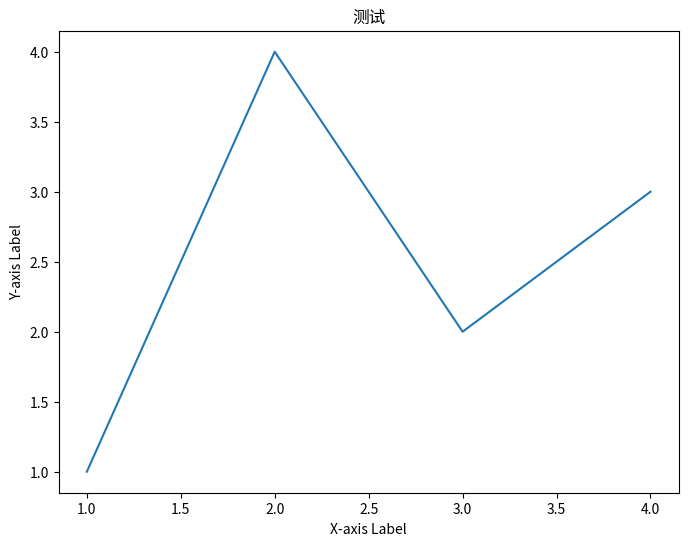

Note: Chinese characters may not display properly with DejaVu Sans
Consider installing a Chinese font for proper display


In [2]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

!pip install prettytable
!pip install rotary-embedding-torch
!pip install kornia
!pip install gateloop_transformer
!pip install webdataset

#@title 使用matplotlib显示中文字符
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import urllib.request
import os

# Download a Chinese font
font_url = "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"
font_filename = "SourceHanSansSC-Regular.otf"

if not os.path.exists(font_filename):
    print("Downloading Chinese font...")
    urllib.request.urlretrieve(font_url, font_filename)
    print("Font downloaded successfully!")

# Add the font to matplotlib
fm.fontManager.addfont(font_filename)
plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']
plt.rcParams['axes.unicode_minus'] = False

print("Chinese font configured!")


# Your plot with a note about font limitations
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3, 4], [1, 4, 2, 3])
plt.title('测试')  # English fallback
plt.xlabel('X-axis Label')  # English fallback
plt.ylabel('Y-axis Label')  # English fallback
plt.show()

print("Note: Chinese characters may not display properly with DejaVu Sans")
print("Consider installing a Chinese font for proper display")





In [14]:
#@title utilities
import torch

def tensor_allclose(a, b, atol=1e-8, rtol=1e-5):
    """
    比较两个张量是否满足：
    |a - b| ≤ atol + rtol * |b|

    参数：
    a, b: 要比较的PyTorch张量
    atol: 绝对容差（默认1e-8）
    rtol: 相对容差（默认1e-5）

    返回：
    bool: 是否所有元素都满足容差要求
    """
    if a.shape != b.shape:
        raise ValueError("张量形状不匹配")

    return torch.allclose(a, b, atol=atol, rtol=rtol)

import torch
import matplotlib.pyplot as plt

def compare_4d_slices(tensor1, tensor2,
                     dim=1,  # 切片维度：1(x),2(y),3(z)
                     index=0,  # 切片索引
                     atol=1e-5,
                     rtol=1e-3,
                     save_path=None  # 新增，保存路径（如 'result.pdf'）
                     ):
    """
    四维张量切片对比工具
    返回：
    - 差异统计指标
    - 可视化对比图
    用例：
    # 比较通道维度第50层的切片并保存为PDF
    stats, fig = compare_4d_slices(tensor1, tensor2, dim=1, index=50, save_path='compare.pdf')
    plt.show()
    print(stats)
    """

    # 维度验证
    assert tensor1.shape == tensor2.shape, "张量形状必须相同"
    assert tensor1.dim() == 4, "输入必须是四维张量"
    assert 1 <= dim <= 3, "切片维度需在[1,3]范围内"

    # 切片提取（保持四维结构）
    if dim == 1:
        slice1 = tensor1[0, index, ...]
        slice2 = tensor2[0, index, ...]
    elif dim == 2:
        slice1 = tensor1[0, :, index, ...]
        slice2 = tensor2[0, :, index, ...]
    elif dim == 3 or dim == -1:
        slice1 = tensor1[0, ..., index]
        slice2 = tensor2[0, ..., index]

    # 差异计算
    abs_diff = torch.abs(slice1 - slice2)
    rel_diff = abs_diff / (torch.abs(slice2) + atol)  # 避免除零

    # 统计指标
    stats = {
        'max_abs': abs_diff.max().item(),
        'mean_abs': abs_diff.mean().item(),
        'rel_over_threshold': (rel_diff > rtol).sum().item() / slice1.numel()
    }

    # 可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 原始数据可视化（取三维切片中间层）
    im0 = axes[0, 0].imshow(slice1.cpu().numpy(), cmap='turbo')
    axes[0, 0].set_title(f'Tensor1 Slice {dim}-{index}')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(slice2.cpu().numpy(), cmap='turbo')
    axes[0, 1].set_title(f'Tensor2 Slice {dim}-{index}')
    plt.colorbar(im1, ax=axes[0, 1])

    # 差异热图
    diff_map = axes[0, 2].imshow(abs_diff.cpu(), cmap='hot')
    plt.colorbar(diff_map, ax=axes[0, 2])
    axes[0, 2].set_title('Absolute Difference')

    # 差异分布直方图
    axes[1, 0].hist(abs_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Frequency')

    # 相对差异分布
    axes[1, 1].hist(rel_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 1].set_xlabel('Relative Difference')

    plt.tight_layout()

    # 新增：保存为PDF
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
        print(f'Figure saved to {save_path}')

    return stats, fig


import matplotlib.pyplot as plt
import numpy as np

def plot(tensor):
    """
    绘制一个 2D 张量

    参数:
    tensor: PyTorch 张量，形状为 [H, W]
    """
    # 将张量转换为 NumPy 数组
    if tensor.is_cuda:
        tensor = tensor.detach().cpu()

    img = tensor.numpy()

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制热图
    im = plt.imshow(img, cmap='viridis')

    # 添加颜色条
    plt.colorbar(im, label='值')

    # 添加标题和轴标签
    plt.title('地震数据切片可视化')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 显示图形
    plt.tight_layout()
    plt.show()

def downsample_3d_time_aware(x, target_size=(128, 128)):
    B, C, T, H, W = x.shape
    results = []

    # 逐时间步处理
    for t in range(T):
        time_slice = x[:, :, t, :, :]  # [B, C, H, W]
        down_slice = F.interpolate(
            time_slice,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        results.append(down_slice)

    return torch.stack(results, dim=2)  # 重组时间维度

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from scipy.stats import skew, kurtosis
from skimage.feature import local_binary_pattern

# 首先，将您的数据重新组织为列表格式
def prepare_seismic_dataset(fine_tune_video_slices):
    """
    将torch张量转换为地震数据列表
    输入: torch.Size([34560, 2, 64, 64])
    输出: 地震数据列表，每个元素为64x64的numpy数组
    """
    seismic_dataset = []

    # 转换为numpy数组
    if isinstance(fine_tune_video_slices, torch.Tensor):
        data_numpy = fine_tune_video_slices.cpu().numpy()
    else:
        data_numpy = fine_tune_video_slices

    print(f"原始数据形状: {data_numpy.shape}")

    # 遍历每个样本
    for i in range(data_numpy.shape[0]):
        # 对于每个样本的2个通道，我们有几种处理方式：

        # 方式1: 分别处理两个通道（推荐用于地震数据）
        for channel in range(data_numpy.shape[1]):
            seismic_slice = data_numpy[i, channel, :, :]  # 64x64
            seismic_dataset.append(seismic_slice)

        # 方式2: 如果您想合并两个通道，可以使用以下代码替代上面的循环
        # combined_slice = np.mean(data_numpy[i, :, :, :], axis=0)  # 平均两个通道
        # seismic_dataset.append(combined_slice)

        # 方式3: 如果您只想使用第一个通道
        # seismic_slice = data_numpy[i, 0, :, :]
        # seismic_dataset.append(seismic_slice)

    print(f"转换后数据集大小: {len(seismic_dataset)}")
    print(f"每个地震切片形状: {seismic_dataset[0].shape}")

    return seismic_dataset

# 质量评估算法的完整实现
def calculate_snr(seismic_data):
    """计算信噪比"""
    signal_estimate = ndimage.median_filter(seismic_data, size=3)
    noise = seismic_data - signal_estimate

    signal_power = np.mean(signal_estimate**2)
    noise_power = np.mean(noise**2)

    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    return snr

def evaluate_coherence(seismic_data):
    """评估同相轴的连续性和清晰度"""
    grad_x = np.gradient(seismic_data, axis=1)
    grad_y = np.gradient(seismic_data, axis=0)

    Jxx = ndimage.gaussian_filter(grad_x**2, sigma=2)
    Jxy = ndimage.gaussian_filter(grad_x * grad_y, sigma=2)
    Jyy = ndimage.gaussian_filter(grad_y**2, sigma=2)

    trace = Jxx + Jyy
    det = Jxx * Jyy - Jxy**2

    coherence = np.where(trace > 0,
                        (trace - 2*np.sqrt(np.maximum(det, 0) + 1e-10)) / (trace + 1e-10),
                        0)

    return np.mean(coherence)

def analyze_frequency_content(seismic_data):
    """分析频谱内容的质量"""
    fft_traces = np.fft.fft(seismic_data, axis=0)
    power_spectrum = np.abs(fft_traces)**2

    freq_axis = np.fft.fftfreq(seismic_data.shape[0])
    valid_freq_mask = (np.abs(freq_axis) >= 0.1) & (np.abs(freq_axis) <= 0.4)

    total_energy = np.sum(power_spectrum, axis=0)
    valid_energy = np.sum(power_spectrum[valid_freq_mask], axis=0)

    frequency_quality = np.mean(valid_energy / (total_energy + 1e-10))
    return frequency_quality

def calculate_texture_complexity(seismic_data):
    """计算纹理复杂度"""
    normalized_data = (seismic_data - np.mean(seismic_data)) / (np.std(seismic_data) + 1e-10)

    lbp = local_binary_pattern(normalized_data, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
    hist = hist + 1e-10
    entropy = -np.sum(hist * np.log2(hist))

    texture_regularity = 1.0 / (1.0 + entropy)
    return texture_regularity

def amplitude_statistics(seismic_data):
    """计算振幅统计特征"""
    std_amp = np.std(seismic_data)

    skewness = abs(skew(seismic_data.ravel()))
    kurt = abs(kurtosis(seismic_data.ravel()))

    amplitude_quality = 1.0 / (1.0 + skewness + kurt/10.0)
    dynamic_range = (np.max(seismic_data) - np.min(seismic_data)) / (std_amp + 1e-10)

    return amplitude_quality, dynamic_range

def comprehensive_quality_assessment(seismic_data):
    """综合质量评估"""
    try:
        snr = calculate_snr(seismic_data)
        coherence = evaluate_coherence(seismic_data)
        freq_quality = analyze_frequency_content(seismic_data)
        texture_reg = calculate_texture_complexity(seismic_data)
        amp_quality, dyn_range = amplitude_statistics(seismic_data)

        # 权重设置
        weights = {
            'snr': 0.30,
            'coherence': 0.30,
            'frequency': 0.10,
            'texture': 0.10,
            'amplitude': 0.50
        }

        # 标准化各指标到[0,1]范围
        snr_norm = np.clip((snr + 10) / 20, 0, 1)
        coherence_norm = np.clip(coherence, 0, 1)
        freq_norm = np.clip(freq_quality, 0, 1)
        texture_norm = np.clip(texture_reg, 0, 1)
        amp_norm = np.clip(amp_quality, 0, 1)

        # 计算综合质量分数
        quality_score = (weights['snr'] * snr_norm +
                        weights['coherence'] * coherence_norm +
                        weights['frequency'] * freq_norm +
                        weights['texture'] * texture_norm +
                        weights['amplitude'] * amp_norm)

        quality_metrics = {
            'overall_score': quality_score,
            'snr': snr,
            'coherence': coherence,
            'frequency_quality': freq_quality,
            'texture_regularity': texture_reg,
            'amplitude_quality': amp_quality,
            'dynamic_range': dyn_range
        }

        return quality_metrics

    except Exception as e:
        print(f"质量评估出错: {e}")
        # 返回低质量分数
        return {
            'overall_score': 0.0,
            'snr': -20,
            'coherence': 0.0,
            'frequency_quality': 0.0,
            'texture_regularity': 0.0,
            'amplitude_quality': 0.0,
            'dynamic_range': 0.0
        }

def filter_dataset(seismic_dataset, quality_threshold=0.5, batch_size=1000):
    """过滤数据集，移除低质量数据（批量处理以提高效率）"""

    high_quality_data = []
    quality_scores = []
    high_quality_indices = []  # 保存高质量数据的原始索引

    total_samples = len(seismic_dataset)

    print(f"开始处理 {total_samples} 个地震数据样本...")

    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        print(f"处理进度: {i+1}-{batch_end}/{total_samples} ({(batch_end/total_samples)*100:.1f}%)")

        for j in range(i, batch_end):
            seismic_data = seismic_dataset[j]
            metrics = comprehensive_quality_assessment(seismic_data)
            quality_scores.append(metrics['overall_score'])

            if metrics['overall_score'] >= quality_threshold:
                high_quality_data.append(seismic_data)
                high_quality_indices.append(j)

            # 每1000个样本输出一次详细信息
            if (j + 1) % 1000 == 0:
                print(f"  样本 {j+1}: 质量分数 = {metrics['overall_score']:.3f}")

    print(f"\n=== 过滤结果 ===")
    print(f"原始数据集大小: {len(seismic_dataset)}")
    print(f"过滤后数据集大小: {len(high_quality_data)}")
    print(f"过滤率: {(1 - len(high_quality_data)/len(seismic_dataset))*100:.1f}%")
    print(f"平均质量分数: {np.mean(quality_scores):.3f}")
    print(f"质量分数标准差: {np.std(quality_scores):.3f}")

    return high_quality_data, quality_scores, high_quality_indices

def convert_back_to_tensor(filtered_dataset, original_shape):
    """将过滤后的数据转换回张量格式"""
    # 假设原始数据是按通道分离的，需要重新组合
    num_samples = len(filtered_dataset) // 2  # 因为每个原始样本产生了2个通道

    if num_samples * 2 != len(filtered_dataset):
        print("警告: 过滤后的数据数量不是偶数，可能存在不完整的样本对")
        num_samples = len(filtered_dataset) // 2

    # 重新组织数据
    filtered_array = np.zeros((num_samples, 2, 64, 64))

    for i in range(num_samples):
        filtered_array[i, 0, :, :] = filtered_dataset[i * 2]      # 第一个通道
        filtered_array[i, 1, :, :] = filtered_dataset[i * 2 + 1]  # 第二个通道

    return torch.from_numpy(filtered_array).float()


#####可视化模块############
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

# ============================================================
# 统一输入为 numpy
# ============================================================
def _to_numpy(x, copy=True):
    if 'torch' in str(type(x)):
        try:
            import torch
            if isinstance(x, torch.Tensor):
                x = x.detach().cpu().numpy()
        except Exception:
            pass
    elif isinstance(x, list):
        x = np.array(x)
    if isinstance(x, np.ndarray) and copy:
        return x.copy()
    return x

# ============================================================
# 基础处理
# ============================================================
def apply_agc(data2d, window=15, eps=1e-6):
    data2d = _to_numpy(data2d)
    H, W = data2d.shape
    out = np.zeros_like(data2d)
    half = window // 2
    for i in range(H):
        lo = max(0, i - half)
          # hi 包含当前行
        hi = min(H, i + half + 1)
        rms = np.sqrt(np.mean(data2d[lo:hi, :]**2, axis=0)) + eps
        out[i, :] = data2d[i, :] / rms
    return out

def amplitude_clip(data2d, clip_percent=99.0):
    data2d = _to_numpy(data2d)
    if clip_percent is None:
        return data2d
    p = np.percentile(np.abs(data2d), clip_percent)
    if p <= 0:
        return data2d
    return np.clip(data2d, -p, p)

def global_normalize(video, method='std', clip_percent=99.0):
    v = _to_numpy(video)
    if clip_percent:
        p = np.percentile(np.abs(v), clip_percent)
        if p > 0:
            v = np.clip(v, -p, p)
    if method == 'std':
        std = v.std()
        if std > 0:
            v /= std
    elif method == 'max':
        m = np.abs(v).max()
        if m > 0:
            v /= m
    return v

# ============================================================
# 指标计算
# ============================================================
def compute_frame_metrics(pred_frame, gt_frame, eps=1e-9):
    """
    返回 dict: MSE, MAE, NMSE, CC(互相关系数)，可选 SSIM（依赖 skimage）
    pred_frame, gt_frame: [H,W]
    """
    p = _to_numpy(pred_frame, copy=False).astype(np.float32)
    g = _to_numpy(gt_frame, copy=False).astype(np.float32)
    # 对齐形状
    H = min(p.shape[0], g.shape[0])
    W = min(p.shape[1], g.shape[1])
    p = p[:H, :W]
    g = g[:H, :W]
    diff = p - g
    mse = np.mean(diff**2)
    mae = np.mean(np.abs(diff))
    power_g = np.sum(g**2) + eps
    nmse = np.sum(diff**2) / power_g
    # 互相关系数（归一化相关：cov / (std_p * std_g)）
    vp = p - p.mean()
    vg = g - g.mean()
    denom = (np.sqrt(np.sum(vp**2)) * np.sqrt(np.sum(vg**2)) + eps)
    cc = np.sum(vp * vg) / denom
    metrics = dict(MSE=mse, MAE=mae, NMSE=nmse, CC=cc)
    # 尝试 SSIM
    try:
        from skimage.metrics import structural_similarity as ssim
        ssim_val = ssim(g, p, data_range=p.max() - p.min() if p.max() > p.min() else 1.0)
        metrics['SSIM'] = ssim_val
    except Exception:
        pass
    return metrics

def compute_sequence_metrics(pred, gt):
    P = _to_numpy(pred)
    G = _to_numpy(gt)
    if P.ndim == 4: P = P[:,0]
    if G.ndim == 4: G = G[:,0]
    T = min(P.shape[0], G.shape[0])
    metrics_list = []
    for i in range(T):
        metrics_list.append(compute_frame_metrics(P[i], G[i]))
    # 汇总均值
    summary = {}
    for k in metrics_list[0].keys():
        summary[k] = float(np.mean([m[k] for m in metrics_list]))
    return metrics_list, summary

# ============================================================
# 可视化原子函数
# ============================================================
def plot_density_frame(
    frame,
    ax=None,
    cmap='seismic',
    invert_y=True,
    vmin=None,
    vmax=None,
    add_colorbar=False,
    title=None,
    dt=0.004,
    dx=25.0,
    depth_label='Time (s)',
    x_label='Distance (m)',
    aspect='auto',
    clip_percent=None
):
    frame = _to_numpy(frame)
    f = frame.copy()
    if clip_percent:
        f = amplitude_clip(f, clip_percent)
    if vmin is None or vmax is None:
        vmax_local = np.percentile(np.abs(f), 99.0)
        if vmin is None: vmin = -vmax_local
        if vmax is None: vmax =  vmax_local
    if ax is None:
        _, ax = plt.subplots(figsize=(5,5))
    extent = [0, frame.shape[1]*dx, frame.shape[0]*dt, 0] if invert_y else [0, frame.shape[1]*dx, 0, frame.shape[0]*dt]
    im = ax.imshow(
        f,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation='nearest',
        aspect=aspect,
        extent=extent
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(depth_label)
    if title:
        ax.set_title(title)
    if add_colorbar:
        plt.colorbar(im, ax=ax, shrink=0.7, pad=0.02)
    return ax

def plot_wiggle_frame(
    frame,
    ax=None,
    dt=0.004,
    dx=25.0,
    gain=1.0,
    max_traces=128,
    variable_area=True,
    fill_positive=True,
    fill_color='black',
    line_color='black',
    line_width=0.5,
    agc=None,
    clip_percent=99.0,
    title=None,
    depth_label='Time (s)',
    x_label='Distance (m)'
):
    frame = _to_numpy(frame)
    data = frame.copy()
    if agc:
        data = apply_agc(data, window=agc)
    data = amplitude_clip(data, clip_percent)
    H, W = data.shape
    if max_traces and W > max_traces:
        stride = int(np.ceil(W / max_traces))
        data = data[:, ::stride]
        W = data.shape[1]
    scale = gain / (np.max(np.abs(data)) + 1e-9)
    t = np.arange(H) * dt
    if ax is None:
        _, ax = plt.subplots(figsize=(6,5))
    for i in range(W):
        trace = data[:, i] * scale
        x_base = i * dx
        ax.plot(x_base + trace, t, color=line_color, lw=line_width)
        if variable_area:
            if fill_positive:
                ax.fill_betweenx(t, x_base, x_base + np.maximum(trace, 0), where=(trace > 0), color=fill_color, linewidth=0)
            else:
                ax.fill_betweenx(t, x_base, x_base + np.minimum(trace, 0), where=(trace < 0), color=fill_color, linewidth=0)
    ax.set_xlim(-dx, (W)*dx)
    ax.set_ylim(t[-1], t[0])
    ax.set_xlabel(x_label)
    ax.set_ylabel(depth_label)
    if title: ax.set_title(title)
    return ax

# ============================================================
# 多帧栅格
# ============================================================
def plot_frames_grid(
    video,
    indices=None,
    ncols=5,
    cmap='seismic',
    dt=0.004,
    dx=25.0,
    unify_amplitude=True,
    clip_percent=99.0,
    suptitle=None,
    frame_label_fmt="Frame {idx} (t={time:.3f}s)",
    time0=0.0
):
    vid = _to_numpy(video)
    if vid.ndim == 4:
        vid = vid[:,0]
    T, H, W = vid.shape
    if indices is None:
        indices = list(range(T))
    frames = [vid[i] for i in indices]
    if unify_amplitude:
        all_abs = np.abs(np.concatenate([f.ravel() for f in frames]))
        vmax_global = np.percentile(all_abs, clip_percent)
    else:
        vmax_global = None
    n = len(indices)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3.0*nrows), constrained_layout=True)
    axes = np.array(axes).reshape(nrows, ncols)
    for k, ax in enumerate(axes.ravel()):
        if k >= n:
            ax.axis('off')
            continue
        idx = indices[k]
        f = vid[idx]
        vmax = vmax_global if vmax_global else np.percentile(np.abs(f), clip_percent)
        vmin = -vmax
        extent = [0, W*dx, (H)*dt, 0]
        ax.imshow(f, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        time_val = time0 + idx*dt
        ax.set_title(frame_label_fmt.format(idx=idx, time=time_val), fontsize=9)
        ax.set_xlabel("Distance (m)")
        if k % ncols == 0:
            ax.set_ylabel("Time (s)")
        else:
            ax.set_yticklabels([])
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    if unify_amplitude:
        norm = colors.Normalize(vmin=-vmax_global, vmax=vmax_global)
        fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label="Amplitude")
    else:
        fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax, label="Amplitude")
    return fig

# ============================================================
# 序列对比 (A, B)
# ============================================================
def compare_two_sequences(
    video_a,
    video_b,
    label_a="Full (9f)",
    label_b="Inc (15f)",
    dt=0.004,
    dx=25.0,
    max_frames=6,
    clip_percent=99.0,
    cmap='seismic'
):
    A = _to_numpy(video_a)
    B = _to_numpy(video_b)
    if A.ndim == 4: A = A[:,0]
    if B.ndim == 4: B = B[:,0]
    common = min(A.shape[0], B.shape[0], max_frames)
    all_abs = np.abs(np.concatenate([A[:common].ravel(), B[:common].ravel()]))
    vmax = np.percentile(all_abs, clip_percent)
    vmin = -vmax
    fig, axes = plt.subplots(common, 2, figsize=(8, 2.8*common), constrained_layout=True)
    if common == 1:
        axes = axes.reshape(1, 2)
    extent = [0, A.shape[2]*dx, A.shape[1]*dt, 0]
    for i in range(common):
        axes[i,0].imshow(A[i], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axes[i,0].set_title(f"{label_a} - Frame {i}")
        axes[i,0].set_ylabel("Time (s)")
        axes[i,1].imshow(B[i], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axes[i,1].set_title(f"{label_b} - Frame {i}")
        if i < common -1:
            axes[i,0].set_xticklabels([])
            axes[i,1].set_xticklabels([])
    axes[-1,0].set_xlabel("Distance (m)")
    axes[-1,1].set_xlabel("Distance (m)")
    fig.suptitle("Sequence Comparison (Common Frames)", fontsize=14)
    return fig

# ============================================================
# Difference & Spectrum (A vs B)
# ============================================================
def difference_and_spectrum(
    video_a,
    video_b,
    dt=0.004,
    dx=25.0,
    frames_to_show=(0, -1),
    clip_percent=99.0,
    cmap='seismic'
):
    A = _to_numpy(video_a)
    B = _to_numpy(video_b)
    if A.ndim == 4: A = A[:,0]
    if B.ndim == 4: B = B[:,0]
    Ta = A.shape[0]
    Tb = B.shape[0]
    idxs = []
    for f in frames_to_show:
        if f < 0:
            idxs.append(min(Ta, Tb) + f)
        else:
            idxs.append(f)
    fig, axes = plt.subplots(len(idxs), 4, figsize=(14, 4*len(idxs)), constrained_layout=True)
    if len(idxs) == 1:
        axes = axes.reshape(1, 4)
    for row, i in enumerate(idxs):
        fA = A[i]
        fB = B[i]
        diff = fB - fA
        vmax = np.percentile(np.abs(np.concatenate([fA.ravel(), fB.ravel()])), clip_percent)
        vmin = -vmax
        dv = np.percentile(np.abs(diff), clip_percent)
        extent = [0, fA.shape[1]*dx, fA.shape[0]*dt, 0]
        axes[row,0].imshow(fA, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axes[row,0].set_title(f"A Frame {i}")
        axes[row,1].imshow(fB, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axes[row,1].set_title(f"B Frame {i}")
        axes[row,2].imshow(diff, cmap='seismic', vmin=-dv, vmax=dv, aspect='auto', extent=extent)
        axes[row,2].set_title("Difference (B - A)")
        F = np.fft.fftshift(np.fft.fft2(diff))
        amp_log = np.log1p(np.abs(F))
        axes[row,3].imshow(amp_log, cmap='magma', aspect='auto')
        axes[row,3].set_title("Log Spectrum |Diff|")
        for c in range(3):
            axes[row,c].set_xlabel("Distance (m)")
            if c == 0:
                axes[row,c].set_ylabel("Time (s)")
    fig.suptitle("Difference & Spectrum Analysis", fontsize=15)
    return fig

# ============================================================
# 与 Ground Truth 对比
# ============================================================
def plot_pred_gt_diff_grid(
    pred,
    gt,
    indices=None,
    ncols=3,
    dt=0.004,
    dx=25.0,
    clip_percent=99.0,
    cmap='seismic',
    add_metrics=True,
    suptitle="Prediction vs Ground Truth (Pred, GT, Diff)",
    square_box=True,            # 新增：是否使用正方形坐标区域
    box_aspect=1.0,             # 新增：可调节正方形比例（默认1）
    tighten_layout=True         # 新增：是否在最后调用 tight_layout（避免文字重叠）
):
    """
    每个选定帧绘制三列：Pred | GT | Diff
    square_box=True 时：使用 set_box_aspect(box_aspect) 使每个子图成为正方形区域。
    """
    P = _to_numpy(pred)
    G = _to_numpy(gt)
    if P.ndim == 4: P = P[:,0]
    if G.ndim == 4: G = G[:,0]
    T = min(P.shape[0], G.shape[0])
    if indices is None:
        indices = list(range(T))
    frames = indices

    # 全局幅度范围
    all_abs = np.abs(np.concatenate([P[frames].ravel(), G[frames].ravel()]))
    vmax = np.percentile(all_abs, clip_percent)
    vmin = -vmax

    n = len(frames)
    ncols = 3
    nrows = n  # 每帧独占一行（3列）

    # 为保证单个子图尽可能接近正方形：宽高按列行比做基础放大
    base_size = 2.8  # 可以调节
    fig_w = base_size * ncols
    fig_h = base_size * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), constrained_layout=False)

    if nrows == 1:
        axes = axes.reshape(1, ncols)

    for r, idx in enumerate(frames):
        pred_f = P[idx]
        gt_f = G[idx]
        diff = pred_f - gt_f
        dv = np.percentile(np.abs(diff), clip_percent)

        extent = [0, pred_f.shape[1]*dx, pred_f.shape[0]*dt, 0]  # 仍提供物理尺度（如不想拉伸可去掉 extent）

        axp = axes[r,0]
        axg = axes[r,1]
        axd = axes[r,2]

        im_p = axp.imshow(pred_f, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axp.set_title(f"Pred {idx}")

        im_g = axg.imshow(gt_f, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
        axg.set_title(f"GT {idx}")

        im_d = axd.imshow(diff, cmap='seismic', vmin=-dv, vmax=dv, aspect='auto', extent=extent)
        title_d = "Diff (Pred-GT)"
        if add_metrics:
            m = compute_frame_metrics(pred_f, gt_f)
            title_d += f"\nMSE={m['MSE']:.3e} CC={m['CC']:.3f}"
            if 'SSIM' in m:
                title_d += f" SSIM={m['SSIM']:.3f}"
        axd.set_title(title_d)

        for a in (axp, axg, axd):
            a.set_xlabel("Distance (m)")
        axp.set_ylabel("Time (s)")

        # 关键：正方形化
        if square_box:
            axp.set_box_aspect(box_aspect)
            axg.set_box_aspect(box_aspect)
            axd.set_box_aspect(box_aspect)

    if suptitle:
        fig.suptitle(suptitle, fontsize=14)

    if tighten_layout:
        # 避免标题与色标冲突，可再调节
        fig.tight_layout(rect=[0, 0, 1, 0.97])

    return fig


def compare_with_ground_truth(
    pred,
    gt,
    dt=0.004,
    dx=25.0,
    max_frames=6,
    clip_percent=99.0,
    cmap='seismic',
    show_summary=True,
    square_box=True,    # 新增
    box_aspect=1.0
):
    """
    快速对比若干前帧：Pred vs GT vs Diff + 指标打印
    """
    P = _to_numpy(pred)
    G = _to_numpy(gt)
    if P.ndim == 4: P = P[:,0]
    if G.ndim == 4: G = G[:,0]
    T = min(P.shape[0], G.shape[0], max_frames)

    fig = plot_pred_gt_diff_grid(
        P, G,
        indices=list(range(T)),
        dt=dt,
        dx=dx,
        clip_percent=clip_percent,
        cmap=cmap,
        suptitle=f"Pred vs GT (first {T} frames)",
        square_box=square_box,
        box_aspect=box_aspect
    )

    if show_summary:
        metrics_list, summary = compute_sequence_metrics(P[:T], G[:T])
        print("[Sequence Metrics over {} frames]".format(T))
        print("  " + "  ".join(f"{k}={v:.4g}" for k,v in summary.items()))
    return fig


def animate_pred_vs_gt(
    pred,
    gt,
    out_path=None,
    fps=3,
    dt=0.004,
    dx=25.0,
    clip_percent=99.0,
    cmap='seismic',
    dpi=120,
    writer='ffmpeg',
    show_metrics=True,
    square_display=True,    # 新增
    box_aspect=1.0
):
    """
    动画：预测 vs GT vs Diff
    square_display=True 时，为每个子图设置正方形轴域。
    """
    P = _to_numpy(pred)
    G = _to_numpy(gt)
    if P.ndim == 4: P = P[:,0]
    if G.ndim == 4: G = G[:,0]
    T = min(P.shape[0], G.shape[0])

    all_abs = np.abs(np.concatenate([P[:T].ravel(), G[:T].ravel()]))
    vmax = np.percentile(all_abs, clip_percent)
    vmin = -vmax
    diff_all = P[:T] - G[:T]
    dv = np.percentile(np.abs(diff_all), clip_percent)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3.2))
    extent = [0, P.shape[2]*dx, P.shape[1]*dt, 0]

    im_pred = axes[0].imshow(P[0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
    axes[0].set_title("Pred 0")
    im_gt = axes[1].imshow(G[0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto', extent=extent)
    axes[1].set_title("GT 0")
    im_diff = axes[2].imshow(diff_all[0], cmap='seismic', vmin=-dv, vmax=dv, aspect='auto', extent=extent)
    axes[2].set_title("Diff (Pred-GT)")

    for ax in axes:
        ax.set_xlabel("Distance (m)")
    axes[0].set_ylabel("Time (s)")

    if square_display:
        for ax in axes:
            ax.set_box_aspect(box_aspect)

    metrics_text = fig.text(0.01, 0.02, "", fontsize=9, ha='left', va='bottom')

    def update(f):
        im_pred.set_data(P[f])
        im_gt.set_data(G[f])
        d = diff_all[f]
        im_diff.set_data(d)
        axes[0].set_title(f"Pred {f}")
        axes[1].set_title(f"GT {f}")
        axes[2].set_title(f"Diff {f}")
        if show_metrics:
            m = compute_frame_metrics(P[f], G[f])
            line = "f={} MSE={:.2e} MAE={:.2e} CC={:.3f}".format(f, m['MSE'], m['MAE'], m['CC'])
            if 'SSIM' in m:
                line += f" SSIM={m['SSIM']:.3f}"
            metrics_text.set_text(line)
        return im_pred, im_gt, im_diff, metrics_text

    anim = FuncAnimation(fig, update, frames=T, interval=1000/fps, blit=False)

    if out_path:
        if writer == 'ffmpeg':
            anim.save(out_path, writer=FFMpegWriter(fps=fps), dpi=dpi)
        else:
            anim.save(out_path, writer=PillowWriter(fps=fps), dpi=dpi)
    return anim


def demo_all(
    gen_video_full,
    gen_video_inc,
    ground_truth=None,
    dt=0.004,
    dx=25.0,
    save_dir=None,
    prefix="demo",
    save_pdf=True,
    show=True,
    close_fig=False,
    gt_square=True,          # 新增：GT 对比使用正方形
    box_aspect=1.0           # 新增：正方形比例
):
    """
    综合演示 + 可选保存所有子图为 PDF。
    新增参数 gt_square / box_aspect 控制 GT 对比图是否正方形。
    """
    import os
    full_np = _to_numpy(gen_video_full)
    inc_np  = _to_numpy(gen_video_inc)

    fig_dict = {}
    path_dict = {}

    # 1. Full Sequence
    fig_full = plot_frames_grid(full_np, suptitle="Full Sequence", dt=dt, dx=dx)
    fig_dict["full_sequence"] = fig_full

    # 2. Incremental (first 9)
    fig_inc = plot_frames_grid(
        inc_np,
        indices=list(range(min(9, inc_np.shape[0]))),
        suptitle="Incremental (first 9)",
        dt=dt,
        dx=dx
    )
    fig_dict["incremental_first9"] = fig_inc

    # 3. 两序列对比
    fig_compare = compare_two_sequences(
        full_np,
        inc_np,
        label_a="Full",
        label_b="Inc",
        dt=dt,
        dx=dx,
        max_frames=6
    )
    fig_dict["sequence_comparison"] = fig_compare

    # 4. 第一帧 wiggle
    frame0 = full_np[0,0] if full_np.ndim == 4 else full_np[0]
    ax_wiggle = plot_wiggle_frame(frame0, dt=dt, dx=dx, agc=15, title="Wiggle + Variable Area (Frame 0)")
    fig_wiggle = ax_wiggle.figure
    fig_dict["wiggle_frame0"] = fig_wiggle

    # 5. 差异 + 频谱
    fig_diff_spec = difference_and_spectrum(full_np, inc_np, dt=dt, dx=dx, frames_to_show=(0, -1))
    fig_dict["difference_spectrum"] = fig_diff_spec

    # 6. Ground Truth 对比
    if ground_truth is not None:
        print("---- Ground Truth Comparison (Full vs GT) ----")
        fig_gt = compare_with_ground_truth(
            full_np,
            ground_truth,
            dt=dt,
            dx=dx,
            max_frames=6,
            square_box=gt_square,
            box_aspect=box_aspect
        )
        fig_dict["pred_gt_comparison"] = fig_gt

    # ========= 保存部分 =========
    if save_dir is not None and save_pdf:
        os.makedirs(save_dir, exist_ok=True)
        for name, fig in fig_dict.items():
            pdf_path = os.path.join(save_dir, f"{prefix}_{name}.pdf")
            try:
                fig.savefig(pdf_path, format="pdf", bbox_inches='tight')
                path_dict[name] = pdf_path
            except Exception as e:
                print(f"[WARN] 保存 {name} 失败: {e}")

    if show:
        plt.show()
    else:
        if close_fig:
            plt.close('all')

    if close_fig and show:
        for fig in fig_dict.values():
            plt.close(fig)

    return fig_dict, path_dict


In [4]:
#@title SeismicWorld 数据处理函数集合

import torch
import numpy as np
import matplotlib.pyplot as plt

def process_seismic_for_world(seismic_data):
    """
    处理地震数据用于SeismicWorld训练
    输入: seismic_data [b, t, X, Y, Z] = [20, 9, 64, 64, 64]
    输出: 沿X轴切片的视频数据 [b*X, t, Y, Z]
    """
    b, t, X, Y, Z = seismic_data.shape
    print(f"原始数据形状: {seismic_data.shape}")

    # 重新排列维度，将X轴作为batch维度
    # [b, t, X, Y, Z] -> [b, X, t, Y, Z] -> [b*X, t, Y, Z]
    seismic_slices = seismic_data.permute(0, 2, 1, 3, 4)  # [b, X, t, Y, Z]
    seismic_slices = seismic_slices.reshape(b * X, t, Y, Z)  # [b*X, t, Y, Z]

    print(f"处理后形状: {seismic_slices.shape}")
    print(f"现在有 {b*X} 个视频切片，每个视频有 {t} 帧，分辨率为 {Y}×{Z}")

    return seismic_slices

def reconstruct_4d_seismic(predicted_slices, original_batch_size, original_time_steps=9,
                          original_x_size=64, original_y_size=64, original_z_size=64):
    """
    将SeismicWorld预测的64个切片重新组合成4D时移地震体

    参数:
    - predicted_slices: [b*X, t, Y, Z] 预测的切片数据
    - original_batch_size: 原始batch大小
    - original_time_steps: 时间步数
    - original_x_size: X维度大小
    - original_y_size: Y维度大小
    - original_z_size: Z维度大小

    返回: [b, t, X, Y, Z] 重构的4D地震体
    """
    print(f"输入预测切片形状: {predicted_slices.shape}")

    # 确保输入形状正确
    total_slices, t, Y, Z = predicted_slices.shape
    expected_slices = original_batch_size * original_x_size

    if total_slices != expected_slices:
        raise ValueError(f"切片数量不匹配: 期望 {expected_slices}, 实际 {total_slices}")

    # 重新整形为 [b, X, t, Y, Z]
    reconstructed = predicted_slices.reshape(original_batch_size, original_x_size, t, Y, Z)

    # 重新排列维度为 [b, t, X, Y, Z]
    reconstructed = reconstructed.permute(0, 2, 1, 3, 4)

    print(f"重构后4D地震体形状: {reconstructed.shape}")

    return reconstructed

def compare_original_vs_reconstructed(original_data, reconstructed_data,
                                    batch_idx=0, time_idx=4, x_slice=32):
    """
    比较原始数据和重构数据的可视化
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 原始数据切片
    orig_slice = original_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[0].imshow(orig_slice, cmap='seismic', aspect='auto')
    axes[0].set_title(f'Original (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[0].axis('off')

    # 重构数据切片
    recon_slice = reconstructed_data[batch_idx, time_idx, x_slice, :, :].cpu().numpy()
    axes[1].imshow(recon_slice, cmap='seismic', aspect='auto')
    axes[1].set_title(f'Reconstructed (B:{batch_idx}, T:{time_idx}, X:{x_slice})')
    axes[1].axis('off')

    # 差异图
    diff = orig_slice - recon_slice
    im = axes[2].imshow(diff, cmap='RdBu', aspect='auto')
    axes[2].set_title(f'Difference')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # 计算重构误差统计
    mse = torch.mean((original_data - reconstructed_data) ** 2).item()
    mae = torch.mean(torch.abs(original_data - reconstructed_data)).item()
    print(f"重构误差 - MSE: {mse:.6f}, MAE: {mae:.6f}")

def visualize_slice_time_series(seismic_data, batch_idx=0, x_slice=32):
    """
    可视化某个X切片的时间序列
    """
    slice_data = seismic_data[batch_idx, :, x_slice, :, :]  # [t, Y, Z]
    t_steps = slice_data.shape[0]

    cols = 4
    rows = (t_steps + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(t_steps):
        row, col = i // cols, i % cols
        axes[row, col].imshow(slice_data[i].cpu().numpy(), cmap='seismic', aspect='auto')
        axes[row, col].set_title(f'Time step {i}')
        axes[row, col].axis('off')

    # 隐藏多余的子图
    for i in range(t_steps, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.suptitle(f'X-slice {x_slice} through time (Batch {batch_idx})', y=1.02)
    plt.show()

def format_as_video_batches(processed_data, videos_per_batch=64):
    """
    将处理后的数据重新组织成视频批次（可选功能）
    """
    total_videos, t, h, w = processed_data.shape

    if total_videos % videos_per_batch == 0:
        num_batches = total_videos // videos_per_batch
        video_batches = processed_data.reshape(num_batches, videos_per_batch, t, h, w)
        print(f"重新组织为 {num_batches} 个批次，每批次 {videos_per_batch} 个视频")
        return video_batches
    else:
        print(f"警告: 总视频数 {total_videos} 不能被 {videos_per_batch} 整除")
        return processed_data

def create_differenced_seismic_data(seismic_data):
    """
    Creates a differenced version of the seismic data along the time axis.

    Args:
        seismic_data (torch.Tensor): Input data with shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Differenced data of the same shape, where frame t > 0
                      is replaced by frame[t] - frame[t-1]. Frame 0 remains unchanged.
    """
    if not isinstance(seismic_data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")
    if seismic_data.dim() != 5:
        raise ValueError("Input data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = seismic_data.shape
    print(f"Original data shape for differencing: {seismic_data.shape}")

    # Initialize the output tensor with the same shape and type
    differenced_data = torch.zeros_like(seismic_data)

    # Keep the first frame (t=0) as is
    differenced_data[:, 0, :, :, :] = seismic_data[:, 0, :, :, :]

    # Calculate the difference for subsequent frames (t=1 to t-1)
    for i in range(1, t):
        differenced_data[:, i, :, :, :] = seismic_data[:, i, :, :, :] - seismic_data[:, i-1, :, :, :]

    print(f"Differenced data shape: {differenced_data.shape}")
    return differenced_data

def normalize_data(data, eps=1e-8):
    """
    Normalizes data using global mean and standard deviation.

    Args:
        data (torch.Tensor): Input data tensor.
        eps (float): Small value to prevent division by zero.

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
            - normalized_data: Tensor with normalized values.
            - mean: Calculated mean of the input data.
            - std: Calculated standard deviation of the input data.
    """
    if not isinstance(data, torch.Tensor):
        raise TypeError("Input data must be a PyTorch tensor.")

    # Calculate global mean and std
    # NOTE: For actual training, calculate these stats over the entire training dataset
    #       and reuse them for validation/testing and normalization here.
    #       Calculating per-tensor here for demonstration purposes.
    mean = torch.mean(data.float()) # Ensure float for calculation
    std = torch.std(data.float())

    print(f"Normalizing data: Mean={mean.item():.4f}, Std={std.item():.4f}")

    normalized_data = (data - mean) / (std + eps)
    return normalized_data, mean, std

def denormalize_data(normalized_data, mean, std, eps=1e-8):
    """
    Reverses the normalization process.

    Args:
        normalized_data (torch.Tensor): Data that was previously normalized.
        mean (torch.Tensor or float): Mean used during normalization.
        std (torch.Tensor or float): Standard deviation used during normalization.
        eps (float): Small value used during normalization's division.

    Returns:
        torch.Tensor: Data restored to its original scale.
    """
    if not isinstance(normalized_data, torch.Tensor):
        raise TypeError("Input normalized_data must be a PyTorch tensor.")

    print(f"Denormalizing data using: Mean={mean.item():.4f}, Std={std.item():.4f}")
    original_scale_data = normalized_data * (std + eps) + mean
    return original_scale_data

def recover_absolute_frames(differenced_data):
    """
    Recovers absolute frames from differenced data [frame_0, diff_1, diff_2, ...].

    Args:
        differenced_data (torch.Tensor): Data in differenced format,
                                         shape [b, t, X, Y, Z].

    Returns:
        torch.Tensor: Data with absolute frame values, shape [b, t, X, Y, Z].
    """
    if not isinstance(differenced_data, torch.Tensor):
        raise TypeError("Input differenced_data must be a PyTorch tensor.")
    if differenced_data.dim() != 5:
        raise ValueError("Input differenced_data must have 5 dimensions [b, t, X, Y, Z].")

    b, t, X, Y, Z = differenced_data.shape
    print(f"Recovering absolute frames from shape: {differenced_data.shape}")

    recovered_data = torch.zeros_like(differenced_data)

    # First frame is already absolute
    recovered_data[:, 0, :, :, :] = differenced_data[:, 0, :, :, :]

    # Cumulatively add differences for subsequent frames
    for i in range(1, t):
        recovered_data[:, i, :, :, :] = recovered_data[:, i-1, :, :, :] + differenced_data[:, i, :, :, :]

    print(f"Recovered absolute data shape: {recovered_data.shape}")
    return recovered_data

def seismic_world_diff_norm_workflow_demo(seismic_data):
    """
    Complete workflow: differencing, normalization, processing,
    simulated prediction, reconstruction, denormalization, recovery.
    """
    print("=== SeismicWorld Differencing & Normalization Workflow ===\n")
    original_shape = seismic_data.shape
    b, t, X, Y, Z = original_shape

    # Step 1: Create differenced data
    print("Step 1: Create differenced data")
    differenced_seismic_data = create_differenced_seismic_data(seismic_data)

    # Step 2: Normalize the differenced data
    print("\nStep 2: Normalize the differenced data")
    # NOTE: In a real scenario, 'data_mean' and 'data_std' should be pre-calculated
    #       on the training set and loaded here.
    normalized_diff_data, data_mean, data_std = normalize_data(differenced_seismic_data)
    # Keep mean/std safe, they are needed later!

    # Step 3: Process normalized differenced data for VQ-VAE input (slicing)
    print("\nStep 3: Process normalized differenced data into video slices")
    normalized_diff_video = process_seismic_for_world(normalized_diff_data)
    # Shape: [b*X, t, Y, Z]

    # Step 4: Simulate VQ-VAE Prediction
    # The model predicts the *normalized differenced slices*
    print("\nStep 4: Simulate VQ-VAE prediction (using processed input as placeholder)")
    predicted_normalized_diff_video = normalized_diff_video.clone() # Perfect reconstruction assumed

    # --- Recovery Steps ---

    # Step 5: Reconstruct the 4D shape from predicted slices
    print("\nStep 5: Reconstruct 4D shape from predicted normalized slices")
    predicted_normalized_diff_4d = reconstruct_4d_seismic(
        predicted_normalized_diff_video,
        original_batch_size=b,
        original_time_steps=t,
        original_x_size=X,
        original_y_size=Y,
        original_z_size=Z
    )
    # Shape: [b, t, X, Y, Z]

    # Step 6: Denormalize the reconstructed 4D prediction
    print("\nStep 6: Denormalize the reconstructed 4D data")
    predicted_diff_4d = denormalize_data(predicted_normalized_diff_4d, data_mean, data_std)
    # Shape: [b, t, X, Y, Z], values are back to the scale of differenced data

    # Step 7: Recover absolute frames from the denormalized differenced data
    print("\nStep 7: Recover absolute frames from denormalized differenced data")
    reconstructed_absolute_4d = recover_absolute_frames(predicted_diff_4d)
    # Shape: [b, t, X, Y, Z], values are back to the original absolute scale

    # Step 8: Compare final recovered data with original input
    print("\nStep 8: Compare original data vs fully recovered data")
    compare_original_vs_reconstructed(seismic_data, reconstructed_absolute_4d)

    return reconstructed_absolute_4d

# 主要工作流程示例
def seismic_world_workflow_demo(seismic_data):
    """
    完整的SeismicWorld工作流程演示
    """
    print("=== SeismicWorld 数据处理工作流程 ===\n")

    # 步骤1: 处理数据用于训练
    print("步骤1: 处理4D地震数据为切片视频")
    processed_slices = process_seismic_for_world(seismic_data)

    # 步骤2: 模拟SeismicWorld预测（这里用原始数据模拟）
    print("\n步骤2: SeismicWorld模型预测（此处用原始数据模拟）")
    predicted_slices = processed_slices.clone()  # 实际使用时这里是模型预测结果

    # 步骤3: 重构4D地震体
    print("\n步骤3: 重构4D地震体")
    reconstructed_4d = reconstruct_4d_seismic(
        predicted_slices,
        original_batch_size=seismic_data.shape[0],
        original_time_steps=seismic_data.shape[1],
        original_x_size=seismic_data.shape[2],
        original_y_size=seismic_data.shape[3],
        original_z_size=seismic_data.shape[4]
    )

    # 步骤4: 验证重构质量
    print("\n步骤4: 验证重构质量")
    compare_original_vs_reconstructed(seismic_data, reconstructed_4d)

    return processed_slices, reconstructed_4d




#Sleipner Validation

In [ ]:
#@title 读取Sleipner 4D Seismic Dataset的三维地震体
import matplotlib.pyplot as plt
import numpy as np
import os

# Install required libraries
try:
    import segyio
    print("segyio库已安装")
except ImportError:
    print("正在安装segyio库...")
    !pip install segyio
    import segyio

# Define file paths
file_paths = {
    '1994-2001': '/content/drive/MyDrive/SeismicWorld/dataset/94p01 2001 processing/data/94p01mid.sgy',
    '1994-2007': '/content/drive/MyDrive/SeismicWorld/dataset/94p07 2007 processing/data/94p07mid.sgy',
    '1999-2001': '/content/drive/MyDrive/SeismicWorld/dataset/99p01 2001 processing/data/99p01mid.sgy',
    '2001-2001': '/content/drive/MyDrive/SeismicWorld/dataset/01p01 2001 processing/data/01p01mid.sgy',
    '2010-2011': '/content/drive/MyDrive/SeismicWorld/dataset/10p11 2011 Imaging processing/data/10p11mid',
}

def analyze_segy_structure(file_path):
    """分析SEG-Y文件的3D结构"""
    try:
        with segyio.open(file_path, 'r') as segy:
            info = {
                'traces': segy.tracecount,
                'samples': len(segy.samples),
                'sample_interval': segy.bin[segyio.BinField.Interval],
                'sample_rate': segy.bin[segyio.BinField.Interval] / 1000,
                'format': segy.format,
                'sorting': segy.sorting,
                'is_3d': False,
                'geometry': 'Unknown'
            }

            # 检查是否为3D数据
            try:
                # 尝试获取inline和crossline信息
                if hasattr(segy, 'ilines') and hasattr(segy, 'xlines'):
                    info['is_3d'] = True
                    info['geometry'] = '3D Structured'
                    info['ilines'] = list(segy.ilines)[:10]  # 前10个inline号
                    info['xlines'] = list(segy.xlines)[:10]  # 前10个crossline号
                    info['n_ilines'] = len(segy.ilines)
                    info['n_xlines'] = len(segy.xlines)
                    info['cube_shape'] = (info['n_ilines'], info['n_xlines'], info['samples'])

                    print(f"✅ 检测到3D地震数据!")
                    print(f"   Inline范围: {min(segy.ilines)} - {max(segy.ilines)} (共{len(segy.ilines)}条)")
                    print(f"   Crossline范围: {min(segy.xlines)} - {max(segy.xlines)} (共{len(segy.xlines)}条)")
                    print(f"   3D数据体形状: {info['cube_shape']}")

                else:
                    # 尝试通过header分析几何结构
                    inline_set = set()
                    xline_set = set()

                    # 检查前1000道的inline/crossline信息
                    sample_size = min(1000, segy.tracecount)
                    for i in range(sample_size):
                        try:
                            iline = segy.header[i][segyio.TraceField.INLINE_3D]
                            xline = segy.header[i][segyio.TraceField.CROSSLINE_3D]
                            if iline != 0: inline_set.add(iline)
                            if xline != 0: xline_set.add(xline)
                        except:
                            pass

                    if len(inline_set) > 1 and len(xline_set) > 1:
                        info['is_3d'] = True
                        info['geometry'] = '3D Unstructured'
                        info['estimated_ilines'] = len(inline_set)
                        info['estimated_xlines'] = len(xline_set)
                        print(f"✅ 检测到3D地震数据 (非结构化)")
                        print(f"   估计Inline数量: {len(inline_set)}")
                        print(f"   估计Crossline数量: {len(xline_set)}")
                    else:
                        info['geometry'] = '2D Profile'
                        print(f"📏 检测到2D地震剖面")

            except Exception as e:
                print(f"⚠️ 3D结构分析出错: {e}")
                info['geometry'] = '2D Profile'

            # 获取坐标信息
            try:
                sample_traces = min(100, segy.tracecount)
                x_coords = []
                y_coords = []

                for i in range(sample_traces):
                    x = segy.header[i][segyio.TraceField.SourceX] or segy.header[i][segyio.TraceField.CDP_X]
                    y = segy.header[i][segyio.TraceField.SourceY] or segy.header[i][segyio.TraceField.CDP_Y]
                    if x != 0: x_coords.append(x)
                    if y != 0: y_coords.append(y)

                if x_coords and y_coords:
                    info['x_range'] = (min(x_coords), max(x_coords))
                    info['y_range'] = (min(y_coords), max(y_coords))
                else:
                    info['x_range'] = 'N/A'
                    info['y_range'] = 'N/A'
            except:
                info['x_range'] = 'N/A'
                info['y_range'] = 'N/A'

        return info

    except Exception as e:
        print(f"❌ 文件分析失败: {e}")
        return None

def load_3d_seismic_data(file_path, max_inlines=None):
    """加载3D地震数据"""
    try:
        with segyio.open(file_path, 'r') as segy:
            if hasattr(segy, 'ilines') and hasattr(segy, 'xlines'):
                # 结构化3D数据
                if max_inlines:
                    ilines_to_read = list(segy.ilines)[:max_inlines]
                else:
                    ilines_to_read = list(segy.ilines)

                # 读取3D数据体
                cube = segyio.tools.cube(segy)

                # 创建时间轴
                dt = segy.bin[segyio.BinField.Interval] / 1000
                time_axis = np.arange(len(segy.samples)) * dt

                return cube, time_axis, list(segy.ilines), list(segy.xlines)
            else:
                # 2D数据或非结构化数据
                data = np.array([segy.trace[i] for i in range(min(5000, segy.tracecount))])
                dt = segy.bin[segyio.BinField.Interval] / 1000
                time_axis = np.arange(len(segy.samples)) * dt
                return data, time_axis, None, None

    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None, None, None, None

# 主分析流程
seismic_data = {}
print("=" * 70)
print("SLEIPNER 4D SEISMIC DATASET - 3D结构分析")
print("=" * 70)

for year, file_path in file_paths.items():
    print(f"\n🔍 分析 {year}年数据集:")
    print(f"文件路径: {file_path}")

    if not os.path.exists(file_path):
        print(f"❌ 文件不存在: {file_path}")
        continue

    # 获取文件大小
    file_size = os.path.getsize(file_path) / (1024**2)
    print(f"文件大小: {file_size:.2f} MB")

    # 分析文件结构
    info = analyze_segy_structure(file_path)

    if info:
        print(f"   总道数: {info['traces']:,}")
        print(f"   采样点数: {info['samples']:,}")
        print(f"   采样间隔: {info['sample_interval']} μs")
        print(f"   数据格式: {info['format']}")
        print(f"   排序方式: {info['sorting']}")
        print(f"   几何结构: {info['geometry']}")
        print(f"   坐标范围: X{info['x_range']}, Y{info['y_range']}")

        # 加载数据
        print(f"   正在加载数据...")
        if info['is_3d']:
            cube, time_axis, ilines, xlines = load_3d_seismic_data(file_path, max_inlines=10)
            if cube is not None:
                seismic_data[year] = {
                    'data': cube,
                    'time': time_axis,
                    'ilines': ilines,
                    'xlines': xlines,
                    'info': info,
                    'type': '3D'
                }
                print(f"   ✅ 3D数据加载成功! 形状: {cube.shape}")
        else:
            data, time_axis, _, _ = load_3d_seismic_data(file_path)
            if data is not None:
                seismic_data[year] = {
                    'data': data,
                    'time': time_axis,
                    'info': info,
                    'type': '2D'
                }
                print(f"   ✅ 2D数据加载成功! 形状: {data.shape}")

# 可视化结果
if seismic_data:
    print(f"\n📊 生成可视化图表...")

    n_datasets = len(seismic_data)
    fig = plt.figure(figsize=(20, 12))

    for idx, (year, dataset) in enumerate(seismic_data.items()):
        if dataset['type'] == '3D':
            # 3D数据：显示inline切片、crossline切片和时间切片
            cube = dataset['data']
            time = dataset['time']

            # Inline切片 (中间inline)
            ax1 = plt.subplot(3, n_datasets, idx + 1)
            mid_inline = cube.shape[0] // 2
            inline_slice = cube[mid_inline, :, :]
            im1 = ax1.imshow(inline_slice.T, aspect='auto', cmap='seismic',
                           extent=[0, inline_slice.shape[0], time[-1], time[0]],
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax1.set_title(f'{year} - Inline切片\n(第{mid_inline}条inline)')
            ax1.set_xlabel('Crossline')
            ax1.set_ylabel('Time (ms)')

            # Crossline切片 (中间crossline)
            ax2 = plt.subplot(3, n_datasets, idx + 1 + n_datasets)
            mid_xline = cube.shape[1] // 2
            xline_slice = cube[:, mid_xline, :]
            im2 = ax2.imshow(xline_slice.T, aspect='auto', cmap='seismic',
                           extent=[0, xline_slice.shape[0], time[-1], time[0]],
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax2.set_title(f'{year} - Crossline切片\n(第{mid_xline}条crossline)')
            ax2.set_xlabel('Inline')
            ax2.set_ylabel('Time (ms)')

            # 时间切片 (中间时间)
            ax3 = plt.subplot(3, n_datasets, idx + 1 + 2*n_datasets)
            mid_time = cube.shape[2] // 2
            time_slice = cube[:, :, mid_time]
            im3 = ax3.imshow(time_slice, aspect='auto', cmap='seismic',
                           vmin=np.percentile(cube, 1), vmax=np.percentile(cube, 99))
            ax3.set_title(f'{year} - 时间切片\n(t={time[mid_time]:.1f}ms)')
            ax3.set_xlabel('Crossline')
            ax3.set_ylabel('Inline')

        else:
            # 2D数据：常规显示
            ax = plt.subplot(3, n_datasets, idx + 1)
            data = dataset['data']
            time = dataset['time']

            im = ax.imshow(data.T, aspect='auto', cmap='seismic',
                         extent=[0, data.shape[0], time[-1], time[0]],
                         vmin=np.percentile(data, 1), vmax=np.percentile(data, 99))
            ax.set_title(f'{year} - 2D剖面\n({data.shape[0]} traces)')
            ax.set_xlabel('Trace Number')
            ax.set_ylabel('Time (ms)')

    plt.tight_layout()
    plt.show()

# 总结报告
print(f"\n📋 数据结构总结:")
print("=" * 50)
for year, dataset in seismic_data.items():
    info = dataset['info']
    print(f"\n{year}年数据:")
    print(f"  类型: {dataset['type']}")
    print(f"  几何结构: {info['geometry']}")
    if dataset['type'] == '3D':
        print(f"  3D数据体形状: {dataset['data'].shape}")
        if 'cube_shape' in info:
            print(f"  (Inline × Crossline × Time): {info['cube_shape']}")
    else:
        print(f"  2D数据形状: {dataset['data'].shape}")
    print(f"  文件大小: {os.path.getsize(file_paths[year])/(1024**2):.1f} MB")

print(f"\n✅ 分析完成!")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title 将Sleipner工业数据处理成64x64x64的数据块

import torch
import numpy as np

data_1999 = seismic_data['1999-2001']['data']
data_2001 = seismic_data['2001-2001']['data']

print(f"原始数据形状: 1999: {data_1999.shape}, 2001: {data_2001.shape}")

# --- 步骤 1: 数据堆叠 ---
# 将两个时间点的数据沿着新的时间轴(t)堆叠
# 新形状: [t, X, Y, Z] -> [2, 287, 581, 1001]
try:
    industrial_data_4d = np.stack([data_1999, data_2001], axis=0)
    industrial_tensor = torch.from_numpy(industrial_data_4d)
    print(f"数据堆叠后形状: {industrial_tensor.shape}")
except Exception as e:
    print(f"数据堆叠时出错: {e}")
    print("请确保 data_1999 和 data_2001 的空间维度完全一致。")
    # 如果遇到错误，可以在这里停止或进行处理

# --- 步骤 2: 数据切块 (Patching) ---
# 这个过程将大的4D张量分割成小的 (2, 64, 64, 64) 的立方体
# 这些立方体的集合将成为你的新数据集，形状为 [N, t, patch_X, patch_Y, patch_Z]
# 其中 N 是立方体的总数

# 定义立方体尺寸和步长
patch_size = 64
stride = 64  # 使用64的步长意味着数据块之间不重叠

# 为了使用unfold，我们需要一个batch维度，先在最前面增加一个维度
# 形状变为: [b, t, X, Y, Z] -> [1, 2, 287, 581, 1001]
industrial_tensor = industrial_tensor.unsqueeze(0)

# 使用 unfold 函数高效地提取所有数据块
# 我们沿着空间维度 (X, Y, Z) 进行操作，它们分别是第2, 3, 4维
patches = industrial_tensor.unfold(2, patch_size, stride).unfold(3, patch_size, stride).unfold(4, patch_size, stride)
# unfold后的形状比较复杂: [b, t, num_x, num_y, num_z, patch_x, patch_y, patch_z]
# -> [1, 2, 4, 9, 15, 64, 64, 64]

# 调整维度顺序，为reshape做准备
# [b, num_x, num_y, num_z, t, patch_x, patch_y, patch_z]
patches = patches.permute(0, 2, 3, 4, 1, 5, 6, 7)

# Reshape: 将batch和所有数据块的索引合并成一个新的batch维度 N
# N = b * num_x * num_y * num_z
num_patches_total = patches.shape[0] * patches.shape[1] * patches.shape[2] * patches.shape[3]
sleipner_finetune_data = patches.reshape(num_patches_total, industrial_tensor.shape[1], patch_size, patch_size, patch_size)

print("\n--- 数据切块完成 ---")
print(f"立方体尺寸: {patch_size}x{patch_size}x{patch_size}")
print(f"步长: {stride} (不重叠)")
print(f"最终用于微调的数据形状: {sleipner_finetune_data.shape}")
print(f"这表示我们从工业数据中成功提取了 {sleipner_finetune_data.shape[0]} 个 (2, 64, 64, 64) 的时移地质体。")

# 现在 `sleipner_finetune_data` 张量的格式为 [N, t, X, Y, Z]
# N = 540, t = 2, X=Y=Z=64
# 这个张量可以直接用于你的SeismicWorld模型的微调流程

# 你可以像这样将它喂给你的处理函数:
fine_tune_video_slices = process_seismic_for_world(sleipner_finetune_data)
print(f"\n处理后用于VQ-VAE输入的视频切片形状: {fine_tune_video_slices.shape}")



原始数据形状: 1999: (287, 581, 1001), 2001: (287, 581, 1001)
数据堆叠后形状: torch.Size([2, 287, 581, 1001])

--- 数据切块完成 ---
立方体尺寸: 64x64x64
步长: 64 (不重叠)
最终用于微调的数据形状: torch.Size([540, 2, 64, 64, 64])
这表示我们从工业数据中成功提取了 540 个 (2, 64, 64, 64) 的时移地质体。
原始数据形状: torch.Size([540, 2, 64, 64, 64])
处理后形状: torch.Size([34560, 2, 64, 64])
现在有 34560 个视频切片，每个视频有 2 帧，分辨率为 64×64

处理后用于VQ-VAE输入的视频切片形状: torch.Size([34560, 2, 64, 64])


正在准备地震数据集...
原始数据形状: (34560, 2, 64, 64)
转换后数据集大小: 69120
每个地震切片形状: (64, 64)

开始过滤，质量阈值设置为: 0.88
开始处理 69120 个地震数据样本...
处理进度: 1-1000/69120 (1.4%)


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


  样本 1000: 质量分数 = 0.728
处理进度: 1001-2000/69120 (2.9%)
  样本 2000: 质量分数 = 0.671
处理进度: 2001-3000/69120 (4.3%)
  样本 3000: 质量分数 = 0.838
处理进度: 3001-4000/69120 (5.8%)
  样本 4000: 质量分数 = 0.625
处理进度: 4001-5000/69120 (7.2%)
  样本 5000: 质量分数 = 0.752
处理进度: 5001-6000/69120 (8.7%)
  样本 6000: 质量分数 = 0.657
处理进度: 6001-7000/69120 (10.1%)
  样本 7000: 质量分数 = 0.705
处理进度: 7001-8000/69120 (11.6%)
  样本 8000: 质量分数 = 0.850
处理进度: 8001-9000/69120 (13.0%)
  样本 9000: 质量分数 = 0.794
处理进度: 9001-10000/69120 (14.5%)
  样本 10000: 质量分数 = 0.858
处理进度: 10001-11000/69120 (15.9%)
  样本 11000: 质量分数 = 0.800
处理进度: 11001-12000/69120 (17.4%)
  样本 12000: 质量分数 = 0.689
处理进度: 12001-13000/69120 (18.8%)
  样本 13000: 质量分数 = 0.868
处理进度: 13001-14000/69120 (20.3%)
  样本 14000: 质量分数 = 0.827
处理进度: 14001-15000/69120 (21.7%)
  样本 15000: 质量分数 = 0.793
处理进度: 15001-16000/69120 (23.1%)
  样本 16000: 质量分数 = 0.750
处理进度: 16001-17000/69120 (24.6%)
  样本 17000: 质量分数 = 0.837
处理进度: 17001-18000/69120 (26.0%)
  样本 18000: 质量分数 = 0.808
处理进度: 18001-19000/69120 (27.5%)
  样本 

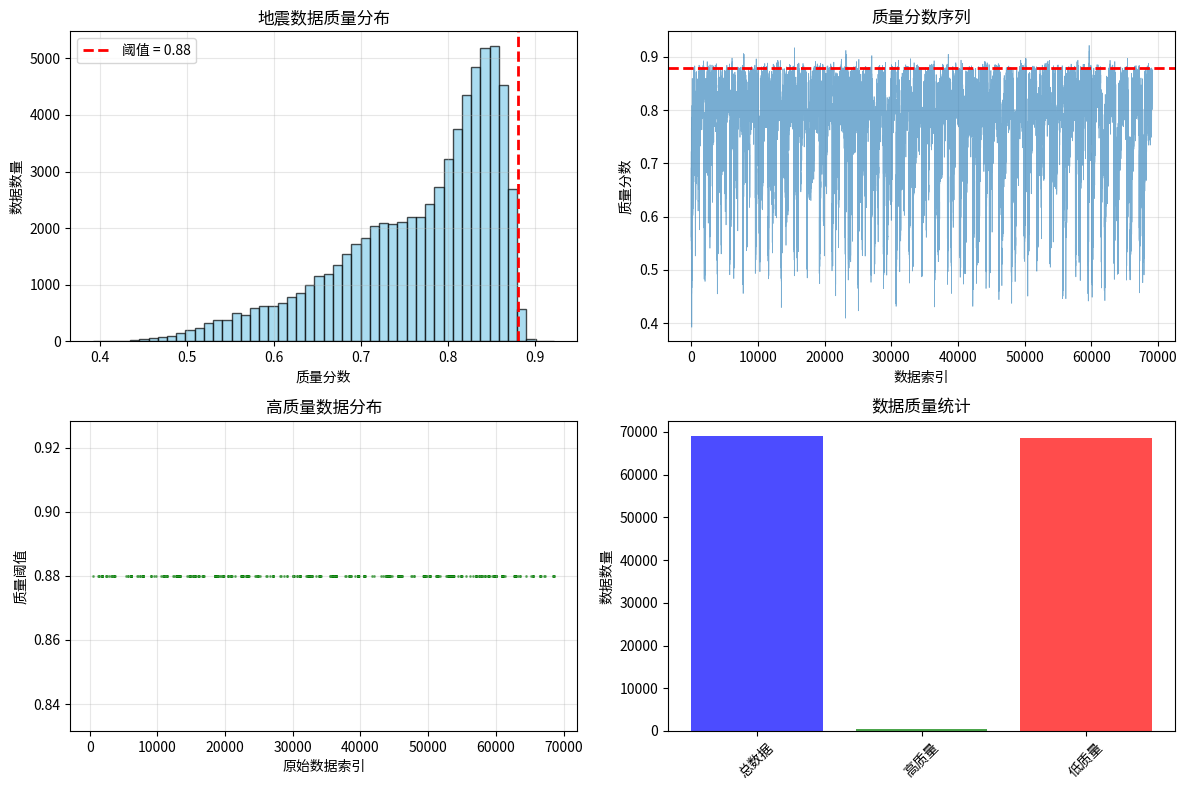

警告: 过滤后的数据数量不是偶数，可能存在不完整的样本对
过滤后张量形状: torch.Size([260, 2, 64, 64])


In [ ]:
#@title 过滤Sleipner数据
def main():
    # 准备数据集
    print("正在准备地震数据集...")
    seismic_dataset = prepare_seismic_dataset(fine_tune_video_slices)

    # 设置质量阈值（0-1之间，越高要求越严格）
    quality_threshold = 0.88

    # 过滤数据集
    print(f"\n开始过滤，质量阈值设置为: {quality_threshold}")
    filtered_dataset, scores, high_quality_indices = filter_dataset(
        seismic_dataset, quality_threshold, batch_size=1000
    )

    # 可视化质量分布
    plt.figure(figsize=(12, 8))

    # 子图1: 质量分数直方图
    plt.subplot(2, 2, 1)
    plt.hist(scores, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.axvline(quality_threshold, color='red', linestyle='--', linewidth=2,
               label=f'阈值 = {quality_threshold}')
    plt.xlabel('质量分数')
    plt.ylabel('数据数量')
    plt.title('地震数据质量分布')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图2: 质量分数随索引变化
    plt.subplot(2, 2, 2)
    plt.plot(scores, alpha=0.6, linewidth=0.5)
    plt.axhline(quality_threshold, color='red', linestyle='--', linewidth=2)
    plt.xlabel('数据索引')
    plt.ylabel('质量分数')
    plt.title('质量分数序列')
    plt.grid(True, alpha=0.3)

    # 子图3: 高质量数据的索引分布
    plt.subplot(2, 2, 3)
    plt.scatter(high_quality_indices, [quality_threshold] * len(high_quality_indices),
               alpha=0.6, s=1, color='green')
    plt.xlabel('原始数据索引')
    plt.ylabel('质量阈值')
    plt.title('高质量数据分布')
    plt.grid(True, alpha=0.3)

    # 子图4: 质量统计
    plt.subplot(2, 2, 4)
    quality_stats = {
        '总数据': len(seismic_dataset),
        '高质量': len(filtered_dataset),
        '低质量': len(seismic_dataset) - len(filtered_dataset)
    }
    plt.bar(quality_stats.keys(), quality_stats.values(),
           color=['blue', 'green', 'red'], alpha=0.7)
    plt.ylabel('数据数量')
    plt.title('数据质量统计')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # 将过滤后的数据转换回torch张量格式（如果需要）
    if len(filtered_dataset) > 0:
        # 重新组织为原始格式 (注意：这里假设您使用了方式1，即分别处理两个通道)
        filtered_tensor = convert_back_to_tensor(filtered_dataset, original_shape=fine_tune_video_slices.shape)
        print(f"过滤后张量形状: {filtered_tensor.shape}")

        return filtered_dataset, scores, high_quality_indices, filtered_tensor
    else:
        print("警告: 没有数据通过质量筛选！")
        return [], scores, [], None

filtered_dataset, scores, indices, filtered_tensor = main()

# Synthetic Pre-training

In [ ]:
#@title 读取一组时移（地震-河道标签）数据 碳封存


# Number of time steps
nt = 8  # Adjust based on your actual data

# Initialize empty lists to collect data
all_seismic_data = []
all_channel_data = []
all_gravity_data = []
all_magnetic_data = []
all_vp_data = []

# Base path for your data
base_path = "/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2/"
size = 64
# Loop through all indices
for selected_idx in range(20):  # 0 to 19
    # Load seismic data for current index
    seismic_file = f"{base_path}64_co2tl_seis_meandering_{selected_idx}.bin"
    gravity_file = f"{base_path}64_co2tl_gramaly_meandering_{selected_idx}.bin"
    magnetic_file = f"{base_path}64_co2tl_magmaly3D_meandering_{selected_idx}.bin"
    vp_file = f"{base_path}64_co2tl_vp_meandering_{selected_idx}.bin"

    # Check if file exists before loading
    if os.path.exists(seismic_file):
        seismic = np.fromfile(seismic_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_seismic_data.append(seismic)

        # # Load corresponding channel data
        # channel_file = f"{base_path}64_tld_channel_meandering_{selected_idx}.bin"
        # channel = np.fromfile(channel_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        # all_channel_data.append(channel)

        # Load gravity anomoly data
        gravity = np.fromfile(gravity_file, dtype=np.float32).reshape(nt+1, size, size)[None, ...]
        all_gravity_data.append(gravity)

        # Load magnetic anomoly data
        magnetic = np.fromfile(magnetic_file, dtype=np.float64).reshape(nt+1, size, size)[None, ...]
        all_magnetic_data.append(magnetic)

        # Load vp data
        vp = np.fromfile(vp_file, dtype=np.float64).reshape(nt+1, size, size, size)[None, ...]
        all_vp_data.append(vp)

        print(f"Loaded data for index {selected_idx}")
    else:
        print(f"Warning: File not found for index {selected_idx}")

# Concatenate all loaded data along the first dimension
if all_seismic_data and all_gravity_data and all_magnetic_data:
    seismic_data_total = np.concatenate(all_seismic_data, axis=0)
    gravity_data_total = np.concatenate(all_gravity_data, axis=0)
    magnetic_data_total = np.concatenate(all_magnetic_data, axis=0)
    vp_data_total = np.concatenate(all_vp_data, axis=0)
    # channel_data = np.concatenate(all_channel_data, axis=0)

    print(f"Combined seismic data shape: {seismic_data_total.shape}")
    print(f"Combined gravity data shape: {gravity_data_total.shape}")
    print(f"Combined magnetic data shape: {magnetic_data_total.shape}")
    print(f"Combined vp data shape: {vp_data_total.shape}")
    # print(f"Combined channel data shape: {channel_data.shape}")
else:
    print("No data was loaded. Check file paths.")


seismic_data = torch.from_numpy(seismic_data_total).float()# (20, 9, 64, 64, 64)
gravity_data = torch.from_numpy(gravity_data_total).float()
magnetic_data = torch.from_numpy(magnetic_data_total).float()
vp_data = torch.from_numpy(vp_data_total).float()
# Select first T (index 0) and last T (index -1 or 8)
seismic_data = seismic_data[:, [0, -1], :, :, :]
gravity_data = gravity_data[:, [0, -1], :, :]
magnetic_data = magnetic_data[:, [0, -1], :, :]
vp_data = vp_data[:, [0, -1], :, :]

# Now seismic_data shape will be: [20, 2, 64, 64, 64]
print(f"New shape:")
print(f"Combined seismic data shape: {seismic_data.shape}")
print(f"Combined gravity data shape: {gravity_data.shape}")
print(f"Combined magnetic data shape: {magnetic_data.shape}")
print(f"Combined vp data shape: {vp_data.shape}")


Loaded data for index 0
Loaded data for index 1
Loaded data for index 2
Loaded data for index 3
Loaded data for index 4
Loaded data for index 5
Loaded data for index 6
Loaded data for index 7
Loaded data for index 8
Loaded data for index 9
Loaded data for index 10
Loaded data for index 11
Loaded data for index 12
Loaded data for index 13
Loaded data for index 14
Loaded data for index 15
Loaded data for index 16
Loaded data for index 17
Loaded data for index 18
Loaded data for index 19
Combined seismic data shape: (20, 9, 64, 64, 64)
Combined gravity data shape: (20, 9, 64, 64)
Combined magnetic data shape: (20, 9, 64, 64)
Combined vp data shape: (20, 9, 64, 64, 64)
New shape:
Combined seismic data shape: torch.Size([20, 2, 64, 64, 64])
Combined gravity data shape: torch.Size([20, 2, 64, 64])
Combined magnetic data shape: torch.Size([20, 2, 64, 64])
Combined vp data shape: torch.Size([20, 2, 64, 64, 64])


In [5]:
#@title 0. 卡尔曼滤波与数据读取参数配置
#@markdown 模式与路径参数
base_path_co2 = "/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64_co2/"  #@param {type:"string"}
num_cases_co2 = 20                               #@param {type:"integer"}
nt_co2 = 8                                       #@param {type:"integer"} # 注意：实际为 nt+1 帧
volume_size = 64                                 #@param {type:"integer"}

#@markdown 时间选择模式: "full"=全部时间步; "endpoints"=仅首末
time_selection_mode = "full"                     #@param ["full", "endpoints"]

#@markdown 是否对 seismic / vp / gravity / magnetic 执行卡尔曼滤波
apply_kalman_seismic = True                      #@param {type:"boolean"}
apply_kalman_vp = True                           #@param {type:"boolean"}
apply_kalman_gravity = True                      #@param {type:"boolean"}
apply_kalman_magnetic = True                     #@param {type:"boolean"}

#@markdown 是否计算RTS平滑（后向平滑）
apply_rts_smoother = True                        #@param {type:"boolean"}

#@markdown 是否计算时间差分特征 (t>0: x_t - x_{t-1})
compute_temporal_diff = True                     #@param {type:"boolean"}

#@markdown 多物理融合加权（为 None 则不生成融合）
fusion_enable = True                             #@param {type:"boolean"}
fusion_weights = {                               #@param
    "seismic": 0.5,
    "vp": 0.2,
    "gravity": 0.2,
    "magnetic": 0.1
}

#@markdown 卡尔曼滤波超参
process_var_seismic = 1e-3                       #@param {type:"number"}
obs_var_seismic     = 1e-2                       #@param {type:"number"}
process_var_vp      = 5e-4                       #@param {type:"number"}
obs_var_vp          = 2e-3                       #@param {type:"number"}
process_var_gravity = 1e-4                       #@param {type:"number"}
obs_var_gravity     = 5e-4                       #@param {type:"number"}
process_var_magnetic= 1e-4                       #@param {type:"number"}
obs_var_magnetic    = 5e-4                       #@param {type:"number"}

#@markdown 运行设备
import torch, os, numpy as np
KF_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"[配置] time_selection_mode={time_selection_mode}, device={KF_DEVICE}")
print(f"[配置] fusion_enable={fusion_enable}, fusion_weights={fusion_weights if fusion_enable else None}")


[配置] time_selection_mode=full, device=cuda
[配置] fusion_enable=True, fusion_weights={'seismic': 0.5, 'vp': 0.2, 'gravity': 0.2, 'magnetic': 0.1}


In [6]:
#@title 读取碳封存多时刻数据（保留全时间序列）
import numpy as np, torch, os

def load_co2_multiphysics_dataset(
    base_path: str,
    num_cases: int,
    nt: int,
    size: int
):
    """
    加载碳封存多物理数据:
    返回:
        seismic: (B, T, Z, Y, X)
        gravity: (B, T, Y, X)
        magnetic:(B, T, Y, X)
        vp:      (B, T, Z, Y, X)
    """
    all_seismic, all_gravity, all_magnetic, all_vp = [], [], [], []

    for idx in range(num_cases):
        seismic_file  = f"{base_path}64_co2tl_seis_meandering_{idx}.bin"
        gravity_file  = f"{base_path}64_co2tl_gramaly_meandering_{idx}.bin"
        magnetic_file = f"{base_path}64_co2tl_magmaly3D_meandering_{idx}.bin"
        vp_file       = f"{base_path}64_co2tl_vp_meandering_{idx}.bin"

        if not (os.path.exists(seismic_file) and os.path.exists(gravity_file)
                and os.path.exists(magnetic_file) and os.path.exists(vp_file)):
            print(f"[警告] 第 {idx} 个样本文件缺失，跳过。")
            continue

        # nt+1 帧
        seismic  = np.fromfile(seismic_file,  dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        gravity  = np.fromfile(gravity_file,  dtype=np.float32).reshape(nt+1, size, size)[None, ...]
        magnetic = np.fromfile(magnetic_file, dtype=np.float64).reshape(nt+1, size, size)[None, ...]
        vp       = np.fromfile(vp_file,       dtype=np.float64).reshape(nt+1, size, size, size)[None, ...]

        all_seismic.append(seismic)
        all_gravity.append(gravity)
        all_magnetic.append(magnetic)
        all_vp.append(vp)

    if not all_seismic:
        raise RuntimeError("没有成功加载任何样本，请检查路径与文件。")

    seismic  = np.concatenate(all_seismic,  axis=0)  # (B, T, Z, Y, X)
    gravity  = np.concatenate(all_gravity,  axis=0)  # (B, T, Y, X)
    magnetic = np.concatenate(all_magnetic, axis=0)  # (B, T, Y, X)
    vp       = np.concatenate(all_vp,       axis=0)  # (B, T, Z, Y, X)

    print(f"[加载完成] seismic {seismic.shape}, gravity {gravity.shape}, magnetic {magnetic.shape}, vp {vp.shape}")
    return seismic, gravity, magnetic, vp

seismic_np, gravity_np, magnetic_np, vp_np = load_co2_multiphysics_dataset(
    base_path=base_path_co2,
    num_cases=num_cases_co2,
    nt=nt_co2,
    size=volume_size
)

# 时间选择
if time_selection_mode == "endpoints":
    time_indices = [0, -1]
    seismic_np  = seismic_np[:, time_indices]
    gravity_np  = gravity_np[:, time_indices]
    magnetic_np = magnetic_np[:, time_indices]
    vp_np       = vp_np[:, time_indices]
    print(f"[时间裁剪] 使用 endpoints，仅保留 {len(time_indices)} 帧: {time_indices}")
else:
    print(f"[时间保留] 使用 full 模式，保留全部 {seismic_np.shape[1]} 帧")

# 转 Torch
seismic_data_total  = torch.from_numpy(seismic_np).float().to(KF_DEVICE)      # (B,T,Z,Y,X)
gravity_data_total  = torch.from_numpy(gravity_np).float().to(KF_DEVICE)      # (B,T,Y,X)
magnetic_data_total = torch.from_numpy(magnetic_np).float().to(KF_DEVICE)     # (B,T,Y,X)
vp_data_total       = torch.from_numpy(vp_np).float().to(KF_DEVICE)           # (B,T,Z,Y,X)

print(f"[Torch] seismic {seismic_data_total.shape}, vp {vp_data_total.shape}")


[加载完成] seismic (20, 9, 64, 64, 64), gravity (20, 9, 64, 64), magnetic (20, 9, 64, 64), vp (20, 9, 64, 64, 64)
[时间保留] 使用 full 模式，保留全部 9 帧
[Torch] seismic torch.Size([20, 9, 64, 64, 64]), vp torch.Size([20, 9, 64, 64, 64])


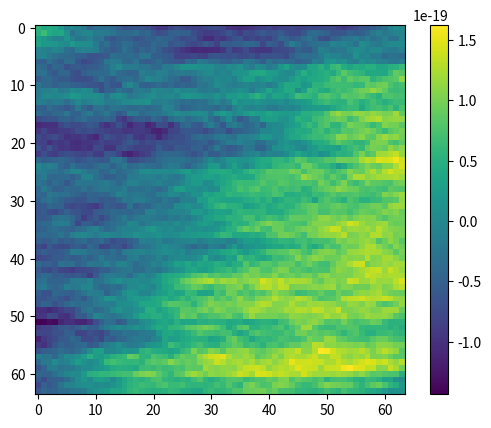

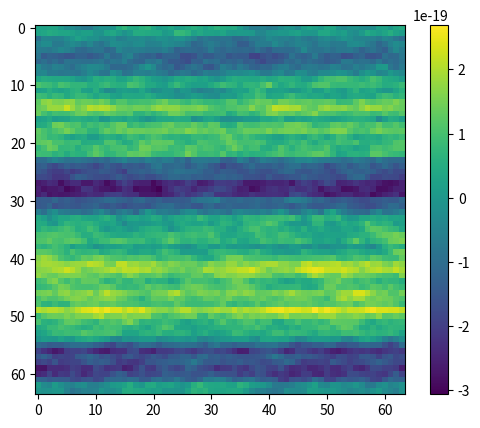

In [ ]:
#@title 检查磁力异常图，重力异常是后来生成的
# 热力图
plt.imshow(magnetic_data[3,0], cmap='viridis')
plt.colorbar()
plt.show()
plt.imshow(magnetic_data[0,1], cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
#@title 读取一组时移（地震-河道标签）数据 油气开采


# Number of time steps
nt = 10  # Adjust based on your actual data

# Initialize empty lists to collect data
all_seismic_data = []
all_channel_data = []
all_gravity_data = []
all_magnetic_data = []
all_vp_data = []

# Base path for your data
base_path = "/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/"
size = 64
# Loop through all indices
for selected_idx in range(20):  # 0 to 19
    # Load seismic data for current index
    seismic_file = f"{base_path}64_tldMul_seis_meandering_{selected_idx}.bin"
    gravity_file = f"{base_path}64_tldMul_gramaly_meandering_{selected_idx}.bin"
    magnetic_file = f"{base_path}64_tldMul_magmaly3D_meandering_{selected_idx}.bin"
    vp_file = f"{base_path}64_tldMul_vp_meandering_{selected_idx}.bin"

    # Check if file exists before loading
    if os.path.exists(seismic_file):
        seismic = np.fromfile(seismic_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_seismic_data.append(seismic)

        # # Load corresponding channel data
        # channel_file = f"{base_path}64_tld_channel_meandering_{selected_idx}.bin"
        # channel = np.fromfile(channel_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        # all_channel_data.append(channel)

        # Load gravity anomoly data
        gravity = np.fromfile(gravity_file, dtype=np.float32).reshape(nt+1, size, size)[None, ...]
        all_gravity_data.append(gravity)

        # Load magnetic anomoly data
        magnetic = np.fromfile(magnetic_file, dtype=np.float64).reshape(nt+1, size, size)[None, ...]
        all_magnetic_data.append(magnetic)

        # Load vp data
        vp = np.fromfile(vp_file, dtype=np.float64).reshape(nt+1, size, size, size)[None, ...]
        all_vp_data.append(vp)

        print(f"Loaded data for index {selected_idx}")
    else:
        print(f"Warning: File not found for index {selected_idx}")

# Concatenate all loaded data along the first dimension
if all_seismic_data and all_gravity_data and all_magnetic_data:
    seismic_data_total = np.concatenate(all_seismic_data, axis=0)
    gravity_data_total = np.concatenate(all_gravity_data, axis=0)
    magnetic_data_total = np.concatenate(all_magnetic_data, axis=0)
    vp_data_total = np.concatenate(all_vp_data, axis=0)
    # channel_data = np.concatenate(all_channel_data, axis=0)

    print(f"Combined seismic data shape: {seismic_data_total.shape}")  # Should be (20, nt+1, 256, 256, 256)
    print(f"Combined gravity data shape: {gravity_data_total.shape}")  # (20, nt+1, 256, 256)
    print(f"Combined magnetic data shape: {magnetic_data_total.shape}") # (20, nt+1, 256, 256)
    print(f"Combined vp data shape: {vp_data_total.shape}") # (20, nt+1, 256, 256, 256)
    # print(f"Combined channel data shape: {channel_data.shape}")  # Should be (20, nt+1, 256, 256, 256)
else:
    print("No data was loaded. Check file paths.")

Loaded data for index 0
Loaded data for index 1
Loaded data for index 2
Loaded data for index 3
Loaded data for index 4
Loaded data for index 5
Loaded data for index 6
Loaded data for index 7
Loaded data for index 8
Loaded data for index 9
Loaded data for index 10
Loaded data for index 11
Loaded data for index 12
Loaded data for index 13
Loaded data for index 14
Loaded data for index 15
Loaded data for index 16
Loaded data for index 17
Loaded data for index 18
Loaded data for index 19
Combined seismic data shape: (20, 11, 64, 64, 64)
Combined gravity data shape: (20, 11, 64, 64)
Combined magnetic data shape: (20, 11, 64, 64)
Combined vp data shape: (20, 11, 64, 64, 64)
Successfully saved seismic slice to /content/drive/MyDrive/DiTing2.0/seismic_slice_x_middle_t0.pdf
Successfully saved seismic slice to /content/drive/MyDrive/DiTing2.0/seismic_slice_x_middle_t9.pdf


In [ ]:
#@title 可视化Sleipner地震体切片 （不运行）
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_seismic_slice(seismic_data, output_pdf_path, time_step_to_plot=0, slice_axis='z', slice_index=None):
    """
    Visualizes a 2D slice of a 3D seismic data volume and saves it as a PDF.

    Args:
        seismic_data (np.ndarray): The 3D seismic data volume (e.g., shape: [depth, height, width]).
        output_pdf_path (str): The file path to save the output PDF file.
        time_step_to_plot (int): The time step to visualize from the 4D data.
        slice_axis (str): The axis to slice along ('x', 'y', or 'z').
        slice_index (int, optional): The index of the slice to visualize.
                                     If None, the middle slice will be used.
    """
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_pdf_path)
    if not os.path.exists(output_dir) and output_dir:
        os.makedirs(output_dir)

    # Select the 3D volume for the specified time step
    seismic_3d = seismic_data[time_step_to_plot]

    # Determine the slice index
    if slice_index is None:
        if slice_axis == 'z':
            slice_index = seismic_3d.shape[0] // 2
        elif slice_axis == 'y':
            slice_index = seismic_3d.shape[1] // 2
        else:  # 'x'
            slice_index = seismic_3d.shape[2] // 2

    # Extract the 2D slice
    if slice_axis == 'z':
        seismic_slice = seismic_3d[slice_index, :, :]
        title = f'Seismic Slice (Z-axis) at Index {slice_index}, Time Step {time_step_to_plot}'
        xlabel, ylabel = 'X-axis', 'Y-axis'
    elif slice_axis == 'y':
        seismic_slice = seismic_3d[:, slice_index, :]
        title = f'Seismic Slice (Y-axis) at Index {slice_index}, Time Step {time_step_to_plot}'
        xlabel, ylabel = 'X-axis', 'Z-axis'
    else:  # 'x'
        seismic_slice = seismic_3d[:, :, slice_index]
        title = f'Seismic Slice (X-axis) at Index {slice_index}, Time Step {time_step_to_plot}'
        xlabel, ylabel = 'Y-axis', 'Z-axis'

    # Plotting
    plt.figure(figsize=(10, 8))
    im = plt.imshow(seismic_slice.T, cmap='seismic', aspect='auto') # Transpose for better orientation
    plt.colorbar(im, label='Amplitude')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Save the figure as a PDF
    plt.savefig(output_pdf_path, format='pdf', bbox_inches='tight')
    plt.close() # Close the plot to free up memory
    print(f"Successfully saved seismic slice to {output_pdf_path}")

# 从总数据中选择第一个地震体 (index 0)
# 它的形状将是 (11, 64, 64, 64) -> (nt+1, size, size, size)
index = 1
first_seismic_volume = seismic_data_total[index]

# --- 使用示例 ---

# 示例1：可视化第一个时间步(t=0)，Z轴的中间切片
visualize_seismic_slice(
    seismic_data=first_seismic_volume,
    output_pdf_path=f_path+f'/seismic_slice_x_middle_t0_{index}.pdf',
    time_step_to_plot=0,
    slice_axis='x' # 'x', 'y', or 'z'
    # slice_index 未指定，将自动选择中间切片
)

# 示例2：可视化第五个时间步(t=4)，Y轴的第20个切片
visualize_seismic_slice(
    seismic_data=first_seismic_volume,
    output_pdf_path=f_path+f'/seismic_slice_x_middle_t9_{index}.pdf',
    time_step_to_plot=9,
    slice_axis='x',
    # slice_index=20
)


Successfully saved seismic slice to /content/drive/MyDrive/DiTing2.0/seismic_slice_x_middle_t0_1.pdf
Successfully saved seismic slice to /content/drive/MyDrive/DiTing2.0/seismic_slice_x_middle_t9_1.pdf


原始数据形状: torch.Size([20, 9, 64, 64, 64])
处理后形状: torch.Size([1280, 9, 64, 64])
现在有 1280 个视频切片，每个视频有 9 帧，分辨率为 64×64


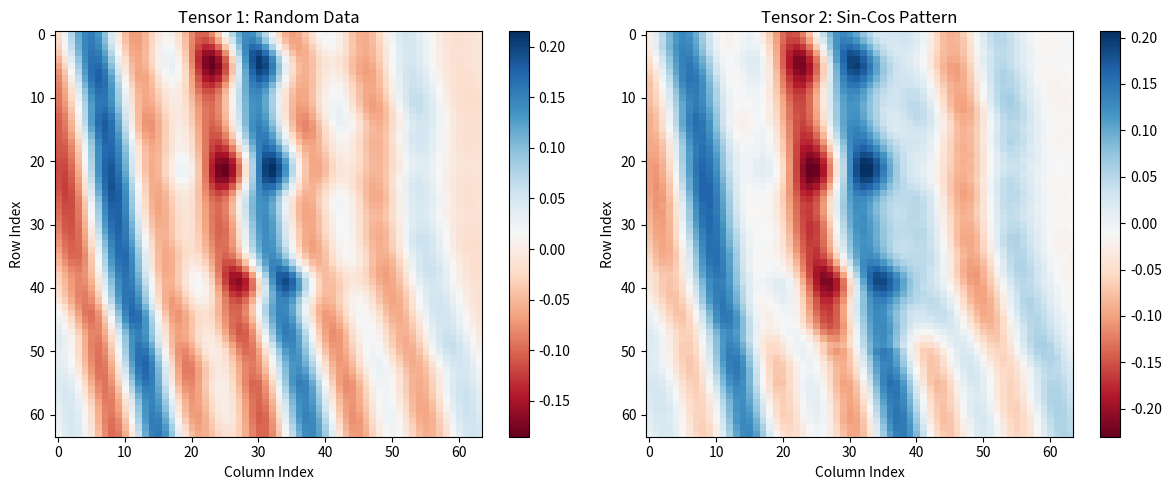

In [7]:
#@title 载入数据集
# choose here
seismic_data_video = process_seismic_for_world(seismic_data_total.cpu()) # torch.Size([1280, 2, 64, 64]) -- pretrain
# seismic_data_video = fine_tune_video_slices # fine-tune
# seismic_data_video = filtered_tensor # fine-tune

# 创建可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

idx = 0

# 可视化第一个tensor
im1 = axes[0].imshow(seismic_data_video[idx,0].numpy(), cmap='RdBu', aspect='auto')
axes[0].set_title('Tensor 1: Random Data')
axes[0].set_xlabel('Column Index')
axes[0].set_ylabel('Row Index')
plt.colorbar(im1, ax=axes[0])

# 可视化第二个tensor
im2 = axes[1].imshow(seismic_data_video[idx,8].numpy(), cmap='RdBu', aspect='auto')
axes[1].set_title('Tensor 2: Sin-Cos Pattern')
axes[1].set_xlabel('Column Index')
axes[1].set_ylabel('Row Index')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [8]:
# @title VQ-VAE:Separate Training {"vertical-output":true,"form-width":"30%"}
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import Module, ModuleList
import os
from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive/SeismicWorld') # Adjust path if needed
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder
import json
from datetime import datetime
from typing import  Union, Tuple, Optional, List, Dict, Any
from torch import Tensor
from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast
from einops import rearrange, repeat
from torch import nn, einsum, Tensor
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import torch
import torch.nn as nn
from torch import Tensor
from typing import Optional, Tuple, Union, List
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

TRAIN_MODE = False #@param

# 兼容不同PyTorch版本的混合精度导入
try:
    # 新版本 PyTorch (>= 2.0)
    from torch.amp import autocast, GradScaler
    def get_autocast_context(device_type='cuda'):
        return autocast(device_type=device_type, dtype=torch.float16)
    def get_grad_scaler(device_type='cuda'):
        return GradScaler(device_type)
    AMP_AVAILABLE = True
    print("Using torch.amp (PyTorch >= 2.0)")
except ImportError:
    try:
        # 旧版本 PyTorch (1.6-2.0)
        from torch.cuda.amp import autocast, GradScaler
        def get_autocast_context(device_type='cuda'):
            return autocast(enabled=True, dtype=torch.float16)
        def get_grad_scaler(device_type='cuda'):
            return GradScaler()
        AMP_AVAILABLE = True
        print("Using torch.cuda.amp (PyTorch 1.6-2.0)")
    except ImportError:
        # 非常旧的版本，不支持混合精度
        AMP_AVAILABLE = False
        print("Mixed precision not available in this PyTorch version")
        def get_autocast_context(device_type='cuda'):
            from contextlib import nullcontext
            return nullcontext()
        def get_grad_scaler(device_type='cuda'):
            return None
# choose here
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU
# DEVICE = device # XLA

print(f"Using device: {DEVICE}")


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=torch.int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=torch.int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor, # 输入形状: [batch, ...] 或 [batch, num_codebooks, ...] (取决于keep_num_codebooks_dim)
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        # indices形状: [batch, ..., 1] (在最后一维添加维度1)

        codes_non_centered = (indices // self._basis) % self._levels
        # indices形状: [batch, ..., 1]
        # self._basis形状: [codebook_dim] 例如 [1, 8, 64, 512, 2560, 12800]
        # self._levels形状: [codebook_dim] 例如 [8, 8, 8, 5, 5, 5]
        # codes_non_centered形状: [batch, ..., codebook_dim] 例如 [batch, seq_len, 6] 或 [batch, num_codebooks, H, W, 6]

        codes = self._scale_and_shift_inverse(codes_non_centered)
        # codes形状: [batch, ..., codebook_dim] (形状不变，但数值从[0, level-1]转换为[-1, 1])

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)') # [batch, seq_len, num_codebooks, codebook_dim]
            # codes形状变化: [batch, ..., num_codebooks, codebook_dim] -> [batch, ..., num_codebooks * codebook_dim]
            # 例如: [batch, seq_len, num_codebooks, 6] -> [batch, seq_len, num_codebooks * 6]
        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')
            # codes形状变化: [batch, H, W, dim] -> [batch, dim, H, W] (图像格式)
            # 或 [batch, H, W, T, dim] -> [batch, dim, H, W, T] (视频格式)

        return codes # torch.Size([1, 8, 8, 512])
        # 最终返回的codes形状:
        # - 图像/视频: [batch, dim, H, W] 或 [batch, dim, H, W, T]
        # - 序列: [batch, seq_len, dim]

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# Dynamic自适应版
class FSQDQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        scale = F.sigmoid(self.ada_param)*4
        return torch.tanh(scale*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes

    def forward(
        self,
        z: torch.Tensor,
    ):
        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

class FSQLQuantizer(nn.Module):

    def __init__(
        self,
        levels: list[int],
        dim: Optional[int] = None,
        num_codebooks=1,
        keep_num_codebooks_dim: Optional[bool] = None,
        scale: Optional[float] = None,
        init_scale=1.0,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)

        _levels = torch.tensor(levels,dtype=int32)

        self.register_buffer("_levels", _levels, persistent=False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent=False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks

        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

        self.init_scale=init_scale
        self.ada_param = nn.Parameter(torch.ones(codebook_dim)*self.init_scale,requires_grad=True)

    @property
    def embedding_dim(self):
        return self.dim

    @property
    def num_embeddings(self):
        return self.codebook_size


    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0)
        shift = (offset / half_l).atanh()
        return torch.tanh(self.ada_param*(z + shift)) * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""


        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        return codes



    def forward(
        self,
        z: torch.Tensor,
    ):

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions
        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

def default(val, d):
    return val if exists(val) else d

def cast_tuple(t, length = 1):
    return t if isinstance(t, tuple) else ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0

def pad_at_dim(t, pad, dim = -1, value = 0.):
    dims_from_right = (- dim - 1) if dim < 0 else (t.ndim - dim - 1)
    padded_dims = [(0, 0)] * dims_from_right + [pad] + [(0, 0)] * (t.ndim - dims_from_right - 1)
    return F.pad(t, tuple(rearrange(torch.tensor(padded_dims), 'r n -> n r').tolist()), value = value)

# --- VQ-VAE Class ---
class VQVAE(Module):
    """
    Vector Quantized Variational Autoencoder (VQ-VAE) using MagvitV2 style
    encoder/decoder and Finite Scalar Quantization (FSQ).
    """
    def __init__(
        self,
        *,
        image_size: int,
        channels: int = 1,
        init_dim: int = 128,
        fsq_levels: List[int], # e.g., [8, 8, 8, 5, 5, 5]
        fsq_dim: Optional[int] = None, # Dimension of encoder output / FSQ input. If None, calculated based on layers.
        num_fsq_codebooks: int = 1, # As per FSQ class
        encoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1), # dim: 128 -> 256
            ('consecutive_residual', 3), ('time_spatial_down', 1),                     # dim: 256
            ('consecutive_residual', 4), ('time_spatial_down', 1),                     # dim: 256
            ('channel_residual', 1), ('consecutive_residual', 3),                      # dim: 256 -> 512
            ('consecutive_residual', 4),                                               # dim: 512
        ),
        decoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
             # Inverse of encoder layers (example, adjust as needed)
            ('consecutive_residual', 4),                                               # dim: 512
            ('consecutive_residual', 3), ('channel_residual', 1),                      # dim: 512 -> 256
            ('time_spatial_up', 1), ('consecutive_residual', 4),                       # dim: 256
            ('time_spatial_up', 1), ('consecutive_residual', 3),                       # dim: 256
            ('channel_residual', 1), ('spatial_up', 1), ('consecutive_residual', 4),   # dim: 256 -> 128
        ),
        input_conv_kernel_size: Tuple[int, int, int] = (7, 7, 7),
        output_conv_kernel_size: Tuple[int, int, int] = (3, 3, 3),
        separate_first_frame_encoding: bool = False,
        pad_mode: str = 'constant',
    ):
        super().__init__()
        self.image_size = image_size
        self.channels = channels
        self.separate_first_frame_encoding = separate_first_frame_encoding

        # --- Encoder ---
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=channels,
            init_dim=init_dim,
            layers=encoder_layers,
            input_conv_kernel_size=input_conv_kernel_size,
            pad_mode=pad_mode,
            separate_first_frame_encoding=separate_first_frame_encoding
        )

        # Determine FSQ dimension if not provided
        if fsq_dim is None:
            # 根据encoder_layers计算最终维度
            current_dim = init_dim
            for layer_def in encoder_layers:
                layer_type, *layer_params = cast_tuple(layer_def)
                if layer_type == 'channel_residual':
                     # channel_residual层会将维度翻倍
                     current_dim = current_dim * 2
            fsq_dim = current_dim
            print(f"Auto-determined FSQ dimension: {fsq_dim}")
        self.fsq_dim = fsq_dim

        # --- Quantizer ---
        self.quantizer = FSQLQuantizer(
            dim=fsq_dim,
            levels=fsq_levels,
            num_codebooks=num_fsq_codebooks,
            # keep_num_codebooks_dim=True # Keep separate dim for codebooks if num_codebooks > 1
                                         # Set based on how you want indices shaped
        )
        self.codebook_size = self.quantizer.codebook_size # Total size of the discrete codebook

        # --- Decoder ---
        # Decoder's init_dim should match the FSQ output dimension
        self.decoder = MagvitV2decoder(
             image_size=image_size,
             channels=channels,
             init_dim=init_dim,#fsq_dim, # Decoder input dim = FSQ output dim
             layers=decoder_layers, # Provide appropriate decoder layers
             output_conv_kernel_size=output_conv_kernel_size,
             separate_first_frame_encoding=separate_first_frame_encoding
        )

    def encode(
        self,
        video_or_images: Tensor
    ) -> Tuple[Tensor, Optional[Tensor], bool]:
        """ Encodes input video/images into continuous latent features. """
        assert video_or_images.ndim in {4, 5} # B, C, H, W or B, C, T, H, W
        assert video_or_images.shape[-2:] == (self.image_size, self.image_size)

        is_image = video_or_images.ndim == 4
        if is_image:
            video = rearrange(video_or_images, 'b c ... -> b c 1 ...')
            video_contains_first_frame = True # Treat image as the first frame
        else:
            video = video_or_images
            # Heuristic: Assume first frame exists if T > 1 or if specifically handling
            video_contains_first_frame = video.shape[2] > 0

        # Encoder forward pass
        # Note: cond is returned but not used in this basic VQVAE setup
        encoded_features, cond, video_contains_first_frame_out = self.encoder(
            video,
            cond=None, # No conditioning in basic VQVAE
            video_contains_first_frame=video_contains_first_frame
        )
        return encoded_features, cond, video_contains_first_frame_out

    def quantize(self, features: Tensor) -> Tuple[Tensor, Tensor]:
        """ Quantizes continuous features using FSQ. """
        quantized, indices = self.quantizer(features)
        return quantized, indices

    def decode(
        self,
        quantized_features: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True
    ) -> Tensor:
        """ Decodes quantized features back into video/images. """
        recon_video = self.decoder(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video

    def encode_to_indices(self, video_or_images: Tensor) -> Tensor:
        """ Encodes input directly to discrete FSQ indices. """
        features, _, _ = self.encode(video_or_images)
        _, indices = self.quantize(features)
        # Indices shape depends on FSQ keep_num_codebooks_dim and input shape
        # e.g., [B, T', H', W'] or [B, T', H', W', C] if keep_num_codebooks_dim=True
        return indices

    def decode_from_indices(
        self,
        indices: Tensor,
        cond: Optional[Tensor] = None, # Pass condition if decoder uses it
        video_contains_first_frame: bool = True # Important context for decoder padding
        ) -> Tensor:
        """ Decodes discrete FSQ indices back into video/images. """
        # Convert indices back to the continuous-like quantized vectors
        # project_out=True applies the final linear layer if FSQ has projections
        # 如果indices传入是单帧'序列'： [1,1,8,8] [B,T,..]
        quantized_features = self.quantizer.indices_to_codes(indices, project_out=True)
        print(f'quantized_features={quantized_features.shape}') # torch.Size([B:1, T:1, 8, 8, D:512]) 序列的dim512是在最后

        # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')

        # # Ensure the shape matches decoder input (B, D, T', H', W')
        # # FSQ indices_to_codes might return [B, ..., D], need to permute
        # if quantized_features.shape[-1] == self.fsq_dim and quantized_features.ndim > 3:
        #      # Example reshape/permute if indices were [B, T', H', W', D] or similar
        #      # This depends heavily on the exact shape returned by indices_to_codes
        #      # Assuming FSQ returns [B, T', H', W', D] and decoder expects [B, D, T', H', W']
        #      expected_spatial_dims = indices.ndim - 2 # B and T are non-spatial
        #      if quantized_features.ndim == expected_spatial_dims + 1: # Check if D is last
        #          num_spatial_dims = len(quantized_features.shape[1:-1])
        #          permute_dims = [0] + [quantized_features.ndim - 1] + list(range(1, 1 + num_spatial_dims))
        #          quantized_features = quantized_features.permute(*permute_dims).contiguous()
        #      else:
        #          print(f"Warning: Unexpected shape from indices_to_codes: {quantized_features.shape}. Decoder might fail.")
        #          # Attempt a generic permute if possible
        #          if quantized_features.ndim >= 4:
        #               quantized_features = rearrange(quantized_features, 'b ... d -> b d ...')


        # Decode the features
        recon_video = self.decode(
            quantized_features,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        return recon_video.squeeze(2) # 不这样会出现多余的维度

    def forward(
        self,
        video_or_images: Tensor,
        return_indices: bool = False,
        return_loss: bool = False, # Placeholder for potential loss calculation
        beta: float = 0.25
        ) -> Union[Tensor, Tuple[Tensor, Tensor], Tuple[Tensor, Tensor, Tensor]]:
        """
        Full forward pass: Encode -> Quantize -> Decode.

        Args:
            video_or_images (Tensor):
            图像输入：[B, C, H, W]
            视频输入：[B, C, H, W] （每次处理一帧）
            return_indices (bool): If True, also return the discrete code indices.
            return_loss (bool): If True, calculate and return reconstruction loss
                                (and potentially commitment loss - requires modification).

        Returns:
            Tensor or Tuple:
                - Reconstructed video/images.
                - (Optional) FSQ indices.
                - (Optional) Loss tensor (if return_loss=True).
        """
        # 1. Encode
        features, cond, video_contains_first_frame = self.encode(video_or_images)
        # print(f'编码器的输出形状/FSQ的输入形状为{features.shape}') # torch.Size([5, 512, 1, 8, 8])

        # 2. Quantize
        quantized, indices = self.quantize(features) # 原版FSQ期望的输入形状：多玛本[batch, num_codebooks, height, width, time]；单码本：[batch, height, width, time]
        # print(f'FSQ的输出code形状为{quantized.shape}') # torch.Size([5, 512, 1, 8, 8])  在FSQ的forward()变成了[5,1,8,8,512->6]
        # print(f'FSQ的输出indices形状为{indices.shape}')# torch.Size([5, 1, 8, 8]) FSQ要求的输入形状: [batch, ...] 或 [batch, num_codebooks, ...]

        # 3. Decode
        recon_output = self.decode(
            quantized,
            cond=cond,
            video_contains_first_frame=video_contains_first_frame
        )
        # print(f'解码器的输出code形状为{recon_output.shape}') # torch.Size([5, 1, 1, 64, 64])

        # --- Optional: Loss Calculation ---
        loss = None
        if return_loss:
            # Reconstruction Loss (e.g., MSE)
            # Ensure original input and reconstruction match shape (handle image vs video)
            original_input = video_or_images
            if original_input.ndim == 4: # Input was image
                 # Decoder might output B,C,1,H,W, compare with B,C,H,W
                 if recon_output.shape[2] == 1:
                      recon_output_for_loss = recon_output.squeeze(2)
                 else:
                      recon_output_for_loss = recon_output # Should match if decoder handles images correctly
            else: # Input was video
                 recon_output_for_loss = recon_output

            # Handle potential padding differences if decoder output length != input length
            target_len = original_input.shape[2] if original_input.ndim == 5 else 1
            recon_len = recon_output_for_loss.shape[2] if recon_output_for_loss.ndim == 5 else 1

            if target_len != recon_len:
                 min_len = min(target_len, recon_len)
                 print(f"Warning: Reconstruction length ({recon_len}) differs from input length ({target_len}). Calculating loss on first {min_len} frames.")
                 if original_input.ndim == 5:
                      original_input = original_input[:, :, :min_len, :, :]
                 if recon_output_for_loss.ndim == 5:
                      recon_output_for_loss = recon_output_for_loss[:, :, :min_len, :, :]

            recon_loss = F.mse_loss(recon_output_for_loss, original_input)

            # Commitment Loss (Optional - typical in VQ-VAE but FSQ might not need it explicitly)
            # If needed, it's typically: beta * ||sg(features) - quantized||^2
            commit_loss = F.mse_loss(features, quantized.detach())
            loss = recon_loss + beta * commit_loss
            # loss = recon_loss # Simple reconstruction loss for now

        # --- Return Values ---
        if return_loss and return_indices:
            return recon_output, indices, loss
        elif return_loss:
            return recon_output, loss
        elif return_indices:
            return recon_output, indices
        else:
            return recon_output

# --- VideoWorldLDM Class Definition (Copied from your code) ---
class VideoWorldLDM(nn.Module):
    def __init__(self, image_size=128, latent_channels=1, frame_num=9,act_embedding_num=8):
        super().__init__()
        self.encoder = MagvitV2LAencoder(
            image_size=image_size,
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num,
        layers=(
            ('consecutive_residual', 4), ('spatial_down', 1), ('channel_residual', 1),
            ('consecutive_residual', 3), ('spatial_down', 1), ('consecutive_residual', 4),
            ('spatial_down', 1), ('channel_residual', 1), ('consecutive_residual', 3),
            ('consecutive_residual', 4)
        ))
        self.quantizer = FSQ( dim=512, levels=[8, 8, 8, 5, 5, 5], num_codebooks=1)
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size, channels=latent_channels, init_dim=128,
            use_pre_video=False, use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3), ('channel_residual', 1), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 4), ('condation', 1),
            ('spatial_up', 1), ('consecutive_residual', 3), ('channel_residual', 1),
            ('condation', 1), ('spatial_up', 1), ('consecutive_residual', 4),
            ('condation', 1), ('consecutive_residual', 4)
        ))
        # Store channels for input check
        self.channels = latent_channels

    def forward(self, x):
        if x.dim() == 4: x = x.unsqueeze(0)
        # Ensure input has correct channel dimension C
        if x.shape[1] != self.channels:
             # Example: Input might be [B, T, C, H, W], needs permute
             if x.shape[2] == self.channels:
                  x = x.permute(0, 2, 1, 3, 4) # B, C, T, H, W
             else:
                  raise ValueError(f"Input channel dimension {x.shape[1]} or {x.shape[2]} does not match model channels {self.channels}")

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # encoded shape might be [B, D, T', H', W'] or similar, depends on encoder output
        # print(f"Encoded shape before quantizer: {encoded.shape}")

        quantized, indices = self.quantizer(encoded)
        # print(f"Quantized shape: {quantized.shape}")
        # print(f"Indices shape: {indices.shape}")

        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

# --- SeismicWorldVideoWorld Class Definition (Modified for clarity and token mapping) ---
class SeismicWorldVideoWorld(nn.Module):
    def __init__(
        self,
        codebook_size_ldm,
        codebook_size_frame,
        special_token_count=3,     # BOS/EOS/PAD
        max_seq_length=1024,
        hidden_size=4096,
        num_hidden_layers=12,
        num_attention_heads=16,
        intermediate_size=4096,
        num_ldm_codes_per_step=1, # Number of LDM codes per time step (H in paper)
        num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
        pretrained_model_path=None,
        device=None,
    ):
        super().__init__()
        self.codebook_size_ldm = codebook_size_ldm
        self.codebook_size_frame = codebook_size_frame
        self.special_token_count = special_token_count

        # Define vocabulary ranges
        self.ldm_token_offset = 0
        self.frame_token_offset = self.codebook_size_ldm
        self.special_token_offset = self.codebook_size_ldm + self.codebook_size_frame

        self.vocab_size = self.special_token_offset + special_token_count

        self.max_seq_length = max_seq_length
        self.num_ldm_codes_per_step = num_ldm_codes_per_step
        self.num_frame_tokens_per_step = num_frame_tokens_per_step
        self.tokens_per_step = num_ldm_codes_per_step + num_frame_tokens_per_step
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # InternLM configuration
        if pretrained_model_path:
            # from MoE.modeling_internlm import InternLMForCausalLM # Assuming import exists
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16, # Consider float32 for stability if needed
                low_cpu_mem_usage=True,
            )
            print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
            self.model.resize_token_embeddings(self.vocab_size)
            if self.model.config.max_position_embeddings < max_seq_length:
                print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
                # Be cautious with resizing position embeddings, might need interpolation
                self.model.resize_position_embeddings(max_seq_length)
        else:
            # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM # Assuming import exists
            config = InternLMConfig(
                vocab_size=self.vocab_size,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True, # Enable for generation
                # Add other relevant InternLM config options if needed
            )
            self.model = InternLMForCausalLM(config)

        # Positional Encoding - More sophisticated encoding might be needed
        # Simple approach: Treat each step (LDM codes + Frame tokens) as a "time" unit
        # and position within the step as "space" unit.
        self.num_time_steps_for_pos = math.ceil(max_seq_length / self.tokens_per_step) + 1 # +1 for BOS potentially
        self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
        # Use a single embedding for position within the combined step
        self.step_pos_embed = nn.Embedding(self.tokens_per_step, hidden_size)

        # Special token IDs
        self.bos_token_id = self.special_token_offset
        self.eos_token_id = self.special_token_offset + 1
        self.pad_token_id = self.special_token_offset + 2
        # Ensure PAD ID matches InternLM's expected PAD ID if using HF trainer etc.
        # self.model.config.pad_token_id = self.pad_token_id

        self.to(self.device)

    def get_token_type_ids(self, input_ids):
        """ Distinguish between BOS, LDM, Frame, PAD tokens """
        token_type_ids = torch.zeros_like(input_ids)
        # Mark LDM tokens (type 1)
        token_type_ids[(input_ids >= self.ldm_token_offset) & (input_ids < self.frame_token_offset)] = 1
        # Mark Frame tokens (type 2)
        token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 2
        # Mark Special tokens (type 0 or specific types if needed)
        token_type_ids[input_ids == self.bos_token_id] = 0 # Or a specific BOS type
        token_type_ids[input_ids == self.eos_token_id] = 0 # Or a specific EOS type
        token_type_ids[input_ids == self.pad_token_id] = 0 # Or a specific PAD type
        return token_type_ids


    def add_positional_encoding(self, input_ids):
        """
        Adds positional encoding based on time step and position within the step.
        Assumes input_ids shape [B, seq_len] and structure like:
        [BOS, ldm_0_0, ..., ldm_0_N, frame_0_0, ..., frame_0_M, ldm_1_0, ...]
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device

        # Create position IDs: 0, 1, 2, ..., seq_len-1
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

        # Calculate time step ID and position within step ID
        # This assumes a fixed structure per step, adjust if structure varies
        # Start counting steps after BOS token
        positions_after_bos = position_ids - 1 # -1 for positions 0, 1, ... relative to first LDM/Frame token
        time_step_ids = torch.zeros_like(position_ids)
        position_in_step_ids = torch.zeros_like(position_ids)

        # Handle BOS token separately (time step 0, position 0)
        is_not_bos = (input_ids != self.bos_token_id)
        time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.tokens_per_step + 1 # Steps 1, 2, ...
        position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.tokens_per_step

        # Clamp time_step_ids to max embedding index
        time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

        # Get embeddings
        time_pos = self.time_pos_embed(time_step_ids)
        step_pos = self.step_pos_embed(position_in_step_ids)

        # Combine embeddings (simple addition)
        pos_encoding = time_pos + step_pos
        return pos_encoding


    def forward(
        self,
        input_ids,      # [B, seq_len], input token sequence (BOS+Z0+frame0+...)
        labels=None,    # [B, seq_len], target token sequence (shifted input_ids)
        attention_mask=None,
        return_dict=None # Use model's default usually
    ):
        """
        Teacher Forcing training.
        input_ids: [B, seq_len]
        labels: [B, seq_len] (should be input_ids shifted left, with -100 for padding)
        """
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

        # Get token embeddings
        inputs_embeds = self.model.get_input_embeddings()(input_ids)

        # Add positional encoding
        pos_encoding = self.add_positional_encoding(input_ids)
        inputs_embeds = inputs_embeds + pos_encoding

        # Optional: Add token type embeddings if needed
        # token_type_ids = self.get_token_type_ids(input_ids)
        # token_type_embeddings = self.model.get_input_embeddings()(token_type_ids) # Or a separate type embedding layer
        # inputs_embeds = inputs_embeds + token_type_embeddings

        # Prepare attention mask if not provided (handle padding)
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()

        # Prepare labels for Causal LM
        # Standard practice: shift logits and labels, compute loss only on non-padded label tokens
        if labels is not None:
             shift_logits = outputs.logits[..., :-1, :].contiguous()
             shift_labels = labels[..., 1:].contiguous()
             # Flatten the tokens
             loss_fct = nn.CrossEntropyLoss()
             shift_logits = shift_logits.view(-1, self.config.vocab_size)
             shift_labels = shift_labels.view(-1)
             # Enable model parallelism
             shift_labels = shift_labels.to(shift_logits.device)
             loss = loss_fct(shift_logits, shift_labels)
             # The InternLMForCausalLM forward pass likely handles this internally if labels are provided.
             # We just need to pass the labels argument to the underlying model.
             pass # No explicit loss calculation needed here if labels are passed to self.model

        # Call the underlying InternLM model
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels, # Pass labels here for internal loss calculation
            use_cache=False, # Typically False during training
            return_dict=return_dict,
            output_hidden_states=False, # Set as needed
            output_attentions=False,    # Set as needed
        )

        return outputs # Return the output object from InternLM, which contains loss, logits, etc.


    @torch.no_grad()
    def generate(
        self,
        input_ids, # [B, seq_len], initial sequence (e.g., BOS + ldm_tokens_0 + frame_tokens_0)
        max_new_tokens,
        attention_mask=None, # Optional initial attention mask
        temperature=1.0,
        top_k=None,
        eos_token_id=None, # Specify EOS token ID for stopping
        **kwargs # Pass other generation config args to model.generate
    ):
        """
        Autoregressive generation using the underlying model's generate method.
        Handles positional encoding addition.
        """
        self.model.eval()
        device = input_ids.device
        batch_size, cur_len = input_ids.shape

        # Prepare initial inputs for the model's generate method
        # The generate method typically handles caching and token selection.
        # We need a way to inject our custom positional encoding logic if
        # the model's internal generate doesn't support it directly.

        # Option 1: Use model.generate directly if it works with custom embeddings (less likely)
        # This might fail if generate expects `input_ids` and calculates embeddings internally.

        # Option 2: Manual generation loop (more control, less optimized than HF generate)
        generated = input_ids
        past_key_values = None
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

        for _ in range(max_new_tokens):
            # Prepare inputs for the current step
            if past_key_values is None:
                # First step: use the full input_ids
                current_input_ids = generated
                current_attention_mask = attention_mask
            else:
                # Subsequent steps: use only the last generated token
                current_input_ids = generated[:, -1:]
                # Update attention mask for the new token
                current_attention_mask = torch.cat(
                    [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
                )
                attention_mask = current_attention_mask # Update for next iteration

            # Get embeddings and add positional encoding for the current input sequence length
            current_seq_len = current_input_ids.shape[1]
            inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
            # Need positional encoding only for the current input tokens
            pos_encoding = self.add_positional_encoding(generated) # Pos encoding for the whole sequence so far
            if past_key_values is None:
                 current_pos_encoding = pos_encoding # Use full encoding for first step
            else:
                 current_pos_encoding = pos_encoding[:, -1:, :] # Use only encoding for the last token

            current_inputs_embeds = inputs_embeds + current_pos_encoding

            # Forward pass
            outputs = self.model(
                inputs_embeds=current_inputs_embeds,
                attention_mask=current_attention_mask,
                past_key_values=past_key_values,
                use_cache=True,
                return_dict=True,
            )

            # Get logits for the next token
            next_token_logits = outputs.logits[:, -1, :] # [B, vocab_size]

            # Apply temperature scaling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

            # Sample next token
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # [B, 1]

            # Append generated token
            generated = torch.cat([generated, next_token], dim=1)

            # Update past_key_values
            past_key_values = outputs.past_key_values

            # Check for EOS token
            if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
                break

            # Update attention mask length for next iteration if using manual loop with past_key_values
            # (Already handled above by updating attention_mask)

        return generated

def train_vq_pre_train(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float,
    beta: float, # Weight for the commitment loss term in VQVAE
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 512, # Pass other VQVAE params as needed
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    # ... other VQVAE parameters if needed
    save_path_prefix: Optional[str] = "vqvae_trained", # Changed to prefix
    save_best_only: bool = True, # Whether to save only the best model
    patience: int = 5, # Early stopping patience
    min_delta: float = 1e-6 # Minimum change to qualify as an improvement
    ):
    """
    Trains the VQ-VAE model with best model saving and optional early stopping.

    Args:
        vq_dataloader: TPU dataloader.
        image_size: Height/Width of the video frames.
        vid_channels: Number of channels in the video.
        vid_frames: Number of frames in the video clips (used for info, VQVAE handles variable T).
        fsq_levels_config: List of levels for the FSQ quantizer.
        vq_epochs: Number of epochs to train.
        batch_size: Training batch size.
        learning_rate: Optimizer learning rate.
        beta: Weight for the commitment loss component.
        num_workers: Number of DataLoader workers.
        device: Computation device ('cuda' or 'cpu').
        init_dim: Initial dimension for VQVAE encoder/decoder.
        fsq_dim: Dimension entering the FSQ layer (can be auto-determined).
        encoder_layers: Custom encoder layer configuration.
        decoder_layers: Custom decoder layer configuration.
        save_path_prefix: Prefix for saving model files.
        save_best_only: If True, only save the best model. If False, save both best and final.
        patience: Number of epochs to wait for improvement before early stopping (0 to disable).
        min_delta: Minimum change in loss to qualify as an improvement.

    Returns:
        The trained VQ-VAE model.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    print(f"Data shape: {seismic_data_video.shape}")
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, LR={learning_rate}, Beta={beta}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    # Use provided args, falling back to defaults in VQVAE definition if None
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        # Only pass layers if they are provided, otherwise use VQVAE defaults
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
        # Add other VQVAE __init__ args here if needed
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Optimizer ---
    optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)

    # GPU混合精度训练
    scaler = GradScaler() if device.startswith('cuda') else None

    # 最佳模型跟踪变量
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    # 训练历史记录
    train_losses = []

    # 准备保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")

    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # 预定义最佳模型保存路径
    best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
    info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")

    # 训练循环
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_tuple in progress_bar:
            batch_videos = batch_tuple.to(device)
            # print(f'batch_videos的形状是{batch_videos.shape}，应该是[B,C,H,W]') # batch_videos的形状是torch.Size([5, 1, 64, 64])，应该是[B,C,H,W]

            optimizer.zero_grad()

            # GPU混合精度训练
            if scaler is not None:
                with autocast(device_type='cuda', dtype=torch.float16):  # GPU使用float16
                    try:
                        reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta) # batch_videos是一帧一帧传入的，[B,C,H,W]
                    except Exception as e:
                        print(f"Error during VQVAE forward pass: {e}")
                        raise e

                    if loss is None:
                        raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                # 缩放损失并反向传播
                scaler.scale(loss).backward()

                # 梯度裁剪
                scaler.unscale_(optimizer)
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)

                # 优化器步骤
                scaler.step(optimizer)
                scaler.update()
            else:
                # CPU训练或不使用混合精度
                try:
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta)
                except Exception as e:
                    print(f"Error during VQVAE forward pass: {e}")
                    raise e

                if loss is None:
                    raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

                loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            total_epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=loss.item())

        # 计算平均损失
        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_epoch_loss)

        # 检查是否是最佳模型并实时保存
        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            # 实时保存最佳模型
            if save_path_prefix:
                try:
                    torch.save(vqvae_model.state_dict(), best_model_path)

                    # 同时保存训练信息
                    training_info = {
                        'best_loss': best_loss,
                        'best_epoch': best_epoch,
                        'current_epoch': epoch + 1,
                        'train_losses': train_losses,
                        'model_args': vqvae_model_args,
                        'training_params': {
                            'learning_rate': learning_rate,
                            'beta': beta,
                            'batch_size': batch_size,
                        }
                    }
                    with open(info_path, 'w') as f:
                        import json
                        json.dump(training_info, f, indent=2)

                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Model Saved)")
                except Exception as e:
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Save Error: {e})")
            else:
                print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        # Early stopping检查
        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")

    # 最终保存处理
    if save_path_prefix:
        try:
            # 如果不是只保存最佳模型，也保存最终模型
            if not save_best_only:
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")

            print(f"Best VQ-VAE model saved to {best_model_path}")
            print(f"Training info saved to {info_path}")

        except Exception as e:
            print(f"Error in final save operations: {e}")

    # 载入最佳模型权重到返回的模型中
    if save_path_prefix and os.path.exists(best_model_path):
        try:
            vqvae_model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model weights: {e}")

    vqvae_model.eval()
    return vqvae_model

def train_vq(
    vq_dataloader, # Input data tensor [N, C, T, H, W]
    image_size: int,
    vid_channels: int,
    vid_frames: int,
    fsq_levels_config: List[int],
    vq_epochs: int,
    batch_size: int,
    learning_rate: float,
    beta: float, # Weight for the commitment loss term in VQVAE
    pre_trained_model_path: Optional[str] = None, # Path to pre-trained model for fine-tuning
    num_workers: int = 0,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    init_dim: int = 128, # Pass other VQVAE params as needed
    fsq_dim: Optional[int] = None,
    encoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None, # Use defaults or pass specifics
    decoder_layers: Optional[Tuple[Union[str, Tuple[str, int]], ...]] = None,
    # ... other VQVAE parameters if needed
    save_path_prefix: Optional[str] = "vqvae_trained", # Changed to prefix
    save_best_only: bool = True, # Whether to save only the best model
    patience: int = 5, # Early stopping patience
    min_delta: float = 1e-6 # Minimum change to qualify as an improvement
    ):
    """
    Trains the VQ-VAE model with best model saving and optional early stopping.
    Handles loading from standard state_dicts and full training checkpoints.
    """
    print(f"--- Starting VQ-VAE Training on device: {device} ---")
    print(f"Parameters: Epochs={vq_epochs}, BatchSize={batch_size}, LR={learning_rate}, Beta={beta}")
    print(f"Best model saving: {save_best_only}, Early stopping patience: {patience}")

    # --- Instantiate the VQ-VAE ---
    vqvae_model_args = {
        'image_size': image_size,
        'channels': vid_channels,
        'fsq_levels': fsq_levels_config,
        'init_dim': init_dim,
        'fsq_dim': fsq_dim,
        **({'encoder_layers': encoder_layers} if encoder_layers else {}),
        **({'decoder_layers': decoder_layers} if decoder_layers else {}),
    }
    vqvae_model = VQVAE(**vqvae_model_args).to(device)

    # --- Load pre-trained model if path is provided ---
    if pre_trained_model_path and os.path.exists(pre_trained_model_path):
        try:
            print(f"Loading pre-trained model for fine-tuning from: {pre_trained_model_path}")
            # Load the entire saved object
            checkpoint = torch.load(pre_trained_model_path, map_location=device)

            # *** MODIFICATION START ***
            # Check if this is a checkpoint dictionary or a raw state_dict
            if 'model_state_dict' in checkpoint:
                # This is a checkpoint file, extract the model's state_dict
                state_dict_to_load = checkpoint['model_state_dict']
                print("Detected a checkpoint file. Extracting 'model_state_dict'.")
            else:
                # This is likely a raw state_dict file
                state_dict_to_load = checkpoint
                print("Detected a raw state_dict file.")
            # *** MODIFICATION END ***

            # Load the weights into the model. strict=True ensures architectures match.
            vqvae_model.load_state_dict(state_dict_to_load, strict=True)
            print("Successfully loaded pre-trained weights.")

        except Exception as e:
            print(f"Error loading pre-trained model: {e}")
            print("Proceeding with random initialization instead.")
    elif pre_trained_model_path:
        print(f"Warning: Pre-trained model path provided but not found: {pre_trained_model_path}")
        print("Proceeding with random initialization.")
    else:
        print("No pre-trained model provided. Training from scratch.")


    # --- Optimizer ---
    optimizer = optim.Adam(vqvae_model.parameters(), lr=learning_rate)

    # GPU混合精度训练
    scaler = get_grad_scaler(str(device)) if AMP_AVAILABLE and 'cuda' in str(device) else None


    # 最佳模型跟踪变量
    best_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    # 训练历史记录
    train_losses = []

    # 准备保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.dirname(save_path_prefix) if save_path_prefix else "."
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
        print(f"Created directory: {save_dir}")

    base_filename = os.path.basename(save_path_prefix) if save_path_prefix else "vqvae_trained"

    # 预定义最佳模型保存路径
    best_model_path = os.path.join(save_dir, f"{base_filename}_best_{timestamp}.pth")
    info_path = os.path.join(save_dir, f"{base_filename}_training_info_{timestamp}.json")

    # 训练循环
    for epoch in range(vq_epochs):
        vqvae_model.train()
        total_epoch_loss = 0.0
        num_batches = 0
        progress_bar = tqdm(vq_dataloader, desc=f"VQ-VAE Epoch {epoch+1}/{vq_epochs}", leave=False)

        for batch_videos in progress_bar:
            batch_videos = batch_videos.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Autocast context for mixed precision
            with get_autocast_context(str(device)) if scaler else torch.no_grad():
                try:
                    reconstructed_video, loss = vqvae_model(batch_videos, return_loss=True, beta=beta)
                except Exception as e:
                    print(f"Error during VQVAE forward pass: {e}")
                    raise e

                if loss is None:
                    raise ValueError("Loss is None. Ensure return_loss=True works correctly.")

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                clip_grad_norm_(vqvae_model.parameters(), max_norm=1.0)
                optimizer.step()

            total_epoch_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix(loss=loss.item())

        avg_epoch_loss = total_epoch_loss / num_batches if num_batches > 0 else 0.0
        train_losses.append(avg_epoch_loss)

        is_best = avg_epoch_loss < (best_loss - min_delta)
        if is_best:
            best_loss = avg_epoch_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0
            if save_path_prefix:
                try:
                    # Save only the model's state_dict for cleaner reloading
                    torch.save(vqvae_model.state_dict(), best_model_path)
                    training_info = {
                        'best_loss': best_loss, 'best_epoch': best_epoch, 'current_epoch': epoch + 1,
                        'train_losses': train_losses, 'model_args': vqvae_model_args,
                        'training_params': {'learning_rate': learning_rate, 'beta': beta, 'batch_size': batch_size}
                    }
                    with open(info_path, 'w') as f:
                        json.dump(training_info, f, indent=2)
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Model Saved)")
                except Exception as e:
                    print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best - Save Error: {e})")
            else:
                print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f} ⭐ (Best)")
        else:
            epochs_without_improvement += 1
            print(f"VQ-VAE Epoch {epoch+1}/{vq_epochs} - Average Loss: {avg_epoch_loss:.6f}")

        if patience > 0 and epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best loss: {best_loss:.6f} at epoch {best_epoch}")
            break

    print("--- VQ-VAE Training Finished ---")
    print(f"Best model achieved loss: {best_loss:.6f} at epoch {best_epoch}")

    if save_path_prefix:
        try:
            if not save_best_only:
                final_model_path = os.path.join(save_dir, f"{base_filename}_final_{timestamp}.pth")
                torch.save(vqvae_model.state_dict(), final_model_path)
                print(f"Final VQ-VAE model saved to {final_model_path}")
            print(f"Best VQ-VAE model saved to {best_model_path}")
            print(f"Training info saved to {info_path}")
        except Exception as e:
            print(f"Error in final save operations: {e}")

    if save_path_prefix and os.path.exists(best_model_path):
        try:
            vqvae_model.load_state_dict(torch.load(best_model_path, map_location=device))
            print("Loaded best model weights into returned model")
        except Exception as e:
            print(f"Error loading best model weights: {e}")

    vqvae_model.eval()
    return vqvae_model

class FrameDataset(Dataset):
    """
    将视频数据 [N, C, T, H, W] 重新组织为单帧数据 [N*T, C, H, W]
    """
    def __init__(self, video_tensor):
        """
        Args:
            video_tensor: shape [N, C, T, H, W]
        """
        self.video_tensor = video_tensor
        N, C, T, H, W = video_tensor.shape

        # 重构为 [N*T, C, H, W] - 每一帧都是独立的样本
        self.frames = video_tensor.reshape(N * T, C, H, W)
        print(f"Original video shape: {video_tensor.shape}")
        print(f"Reshaped frames shape: {self.frames.shape}")
        print(f"Total frames: {len(self.frames)}")

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return self.frames[idx]

if TRAIN_MODE:
  # --- Define training parameters ---
  VQ_EPOCHS = 50
  BATCH_SIZE = 12 # 16
  LEARNING_RATE = 1e-4
  BETA = 0.25
  FSQ_LEVELS = [7, 7, 7, 5, 5, 5]
  NUM_WORKERS = 1

  # --- 数据集 --- 包含旧逻辑
  # seismic_data_video = normalized_diff_video.clone()
  seismic_data_video_ = seismic_data_video.unsqueeze(1)
  print(f"Reshaped data shape: {seismic_data_video_.shape}") # Output: [1280, 1, 9, 64, 64]
  B,C,T,H,W = seismic_data_video_.shape

  frame_dataset = FrameDataset(seismic_data_video_)
  frame_dataloader = DataLoader(
      frame_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=NUM_WORKERS
  )

  # --- 验证数据形状 ---
  for batch in frame_dataloader:
      print(f"Frame batch shape: {batch.shape}")  # 应该是 [BATCH_SIZE, C, H, W]
      break


  # 3. Run training (ensure vid_channels matches the C added above)
  trained_vqvae = train_vq(
      vq_dataloader=frame_dataloader,
      image_size=H,
      vid_channels=C,
      vid_frames=T,
      fsq_levels_config=FSQ_LEVELS,
      vq_epochs=VQ_EPOCHS,
      batch_size=BATCH_SIZE,
      learning_rate=LEARNING_RATE,
      beta=BETA,
      num_workers=NUM_WORKERS,
      pre_trained_model_path=f_path+'/seismic_world_checkpoints/vqvae_trained_best_20250613_124407_LinearFSQ_777555.pth',
      device=DEVICE,
      init_dim=128,
      fsq_dim=None,
      save_path_prefix=f_path+"/seismic_world_checkpoints/vqvae_trained",
      save_best_only=True,  # 只保存最佳模型
      patience=3,           # 5个epoch没有改善就早停
      min_delta=1e-6        # 最小改善阈值
  )

  print("VQ-VAE training complete.")


Using torch.amp (PyTorch >= 2.0)
Using device: cuda


In [9]:
# @title VQ-VAE Model Inference and Visualization {"vertical-output":true}
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import glob
from datetime import datetime

# 设置设备
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

def load_trained_vqvae(model_path, image_size, vid_channels, fsq_levels, init_dim=128, device='cuda'):
  """
  载入训练好的VQ-VAE模型

  Args:
      model_path: 模型权重文件路径
      image_size: 图像尺寸
      vid_channels: 视频通道数
      fsq_levels: FSQ量化级别
      init_dim: 初始维度
      device: 计算设备

  Returns:
      载入权重的VQ-VAE模型
  """
  # 重新实例化模型（确保架构一致）
  vqvae_model = VQVAE(
      image_size=image_size,
      channels=vid_channels,
      fsq_levels=fsq_levels,
      init_dim=init_dim,
      fsq_dim=None,  # 自动计算
  ).to(device)

  # 载入权重
  if os.path.exists(model_path):
      state_dict = torch.load(model_path, map_location=device)
      vqvae_model.load_state_dict(state_dict)
      print(f"Successfully loaded model from: {model_path}")
  else:
      raise FileNotFoundError(f"Model file not found: {model_path}")

  vqvae_model.eval()
  return vqvae_model

def visualize_reconstruction(original, reconstructed, indices=None, num_samples=4, num_frames=9):
    """
    可视化原始视频和重建视频的对比

    Args:
        original: 原始视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        reconstructed: 重建视频张量 [B, C, T, H, W] 或单帧张量 [B, C, H, W]
        indices: 量化索引（可选）
        num_samples: 显示的样本数量
        num_frames: 显示的帧数（对于单帧输入会被忽略）
    """
    # 确保输入是numpy数组
    if torch.is_tensor(original):
        original = original.detach().cpu().numpy()
    if torch.is_tensor(reconstructed):
        reconstructed = reconstructed.detach().cpu().numpy()

    # 调试信息
    print(f"Original shape: {original.shape}")
    print(f"Reconstructed shape: {reconstructed.shape}")

    # 检查输入是否为单帧（4维）还是视频序列（5维）
    is_single_frame = len(original.shape) == 4

    if is_single_frame:
        # 单帧情况：[B, C, H, W]
        batch_size, channels, height, width = original.shape
        num_frames = 1  # 强制设置为1帧
        print("检测到单帧输入，将显示图像对比")
    else:
        # 视频序列情况：[B, C, T, H, W]
        batch_size, channels, time_steps, height, width = original.shape
        num_frames = min(num_frames, time_steps)
        print(f"检测到视频序列输入，时间步数: {time_steps}")

    # 限制显示的样本数量
    num_samples = min(num_samples, batch_size)

    # 创建子图
    if is_single_frame:
        # 单帧情况：只需要2行（原始和重建）
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
        if num_samples == 1:
            axes = axes.reshape(2, 1)
    else:
        # 视频序列情况：保持原有布局
        fig, axes = plt.subplots(2 * num_samples, num_frames, figsize=(num_frames * 3, num_samples * 6))
        if num_samples == 1:
            axes = axes.reshape(2, num_frames)

    for sample_idx in range(num_samples):
        if is_single_frame:
            # 单帧处理
            # 获取原始数据
            orig_data = original[sample_idx]  # [C, H, W]
            recon_data = reconstructed[sample_idx]  # [C, H, W]

            print(f"Sample {sample_idx} - orig_data shape: {orig_data.shape}")
            print(f"Sample {sample_idx} - recon_data shape: {recon_data.shape}")

            if channels == 1:
                # 单通道图像：[1, H, W] -> [H, W]
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]
            elif channels == 3:
                # RGB图像：[3, H, W] -> [H, W, 3]
                orig_frame = np.transpose(orig_data, (1, 2, 0))  # [H, W, 3]
                recon_frame = np.transpose(recon_data, (1, 2, 0))  # [H, W, 3]
            else:
                # 多通道情况，取第一个通道
                orig_frame = orig_data[0]  # [H, W]
                recon_frame = recon_data[0]  # [H, W]

            print(f"After processing - orig_frame shape: {orig_frame.shape}")
            print(f"After processing - recon_frame shape: {recon_frame.shape}")

            # 确保数据是2D（灰度）或3D（RGB）
            if orig_frame.ndim == 3 and orig_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                orig_frame = orig_frame[0]
            if recon_frame.ndim == 3 and recon_frame.shape[0] == 1:
                # 如果是 [1, H, W]，转换为 [H, W]
                recon_frame = recon_frame[0]

            print(f"Final - orig_frame shape: {orig_frame.shape}")
            print(f"Final - recon_frame shape: {recon_frame.shape}")

            # 归一化到[0,1]范围用于显示
            orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
            recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

            # 显示原始图像
            if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                axes[0, sample_idx].imshow(orig_frame_norm)  # RGB
            else:
                axes[0, sample_idx].imshow(orig_frame_norm, cmap='viridis')  # 灰度
            axes[0, sample_idx].set_title(f'Original Sample {sample_idx+1}')
            axes[0, sample_idx].axis('off')

            # 显示重建图像
            if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                axes[1, sample_idx].imshow(recon_frame_norm)  # RGB
            else:
                axes[1, sample_idx].imshow(recon_frame_norm, cmap='viridis')  # 灰度
            axes[1, sample_idx].set_title(f'Reconstructed Sample {sample_idx+1}')
            axes[1, sample_idx].axis('off')

        else:
            # 视频序列处理（原有逻辑）
            for frame_idx in range(num_frames):
                if channels == 1:
                    # 单通道视频帧
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]
                elif channels == 3:
                    # RGB视频帧：[3, H, W] -> [H, W, 3]
                    orig_frame = np.transpose(original[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                    recon_frame = np.transpose(reconstructed[sample_idx, :, frame_idx], (1, 2, 0))  # [H, W, 3]
                else:
                    # 多通道情况，取第一个通道
                    orig_frame = original[sample_idx, 0, frame_idx]  # [H, W]
                    recon_frame = reconstructed[sample_idx, 0, frame_idx]  # [H, W]

                # 归一化到[0,1]范围用于显示
                orig_frame_norm = (orig_frame - orig_frame.min()) / (orig_frame.max() - orig_frame.min() + 1e-8)
                recon_frame_norm = (recon_frame - recon_frame.min()) / (recon_frame.max() - recon_frame.min() + 1e-8)

                # 显示原始帧
                if orig_frame_norm.ndim == 3 and orig_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm)
                else:
                    axes[2*sample_idx, frame_idx].imshow(orig_frame_norm, cmap='viridis')
                axes[2*sample_idx, frame_idx].set_title(f'Original S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx, frame_idx].axis('off')

                # 显示重建帧
                if recon_frame_norm.ndim == 3 and recon_frame_norm.shape[-1] == 3:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm)
                else:
                    axes[2*sample_idx+1, frame_idx].imshow(recon_frame_norm, cmap='viridis')
                axes[2*sample_idx+1, frame_idx].set_title(f'Reconstructed S{sample_idx+1} F{frame_idx+1}')
                axes[2*sample_idx+1, frame_idx].axis('off')

    plt.tight_layout()
    plt.show()

    # 计算重建误差统计
    mse = np.mean((original[:num_samples] - reconstructed[:num_samples]) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse + 1e-8))

    print(f"\n重建质量统计:")
    print(f"MSE: {mse:.6f}")
    print(f"PSNR: {psnr:.2f} dB")

    if is_single_frame:
        print(f"处理的样本数量: {num_samples}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")
    else:
        print(f"处理的样本数量: {num_samples}")
        print(f"显示的帧数: {num_frames}")
        print(f"通道数: {channels}")
        print(f"图像尺寸: {height} x {width}")

def analyze_quantization(indices, codebook_size):
    """
    分析量化索引的分布

    Args:
        indices: 量化索引张量
        codebook_size: 码本大小
    """
    if torch.is_tensor(indices):
        indices_np = indices.detach().cpu().numpy().flatten()
    else:
        indices_np = indices.flatten()

    # 计算索引分布
    unique_indices, counts = np.unique(indices_np, return_counts=True)
    usage_ratio = len(unique_indices) / codebook_size

    print(f"\n量化分析:")
    print(f"码本大小: {codebook_size}")
    print(f"使用的码字数量: {len(unique_indices)}")
    print(f"码本利用率: {usage_ratio:.2%}")
    print(f"最常用的5个码字: {unique_indices[np.argsort(counts)[-5:]]}")

    # 可视化索引分布
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(indices_np, bins=min(50, len(unique_indices)), alpha=0.7, color='skyblue')
    plt.title('量化索引分布')
    plt.xlabel('索引值')
    plt.ylabel('频次')

    plt.subplot(1, 2, 2)
    # 修复：确保x轴和y轴数据长度匹配
    sorted_counts = np.sort(counts)[::-1]  # 降序排列
    num_bars = min(20, len(sorted_counts))  # 取前20个或所有（如果少于20个）

    plt.bar(range(num_bars), sorted_counts[:num_bars])
    plt.title(f'前{num_bars}个最常用码字的使用频次')
    plt.xlabel('码字排名')
    plt.ylabel('使用次数')

    plt.tight_layout()
    plt.show()

# === 主要推理和可视化代码 ===

# 1. 设置参数（与训练时保持一致）
IMAGE_SIZE = 64
VID_CHANNELS = 1
FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5]
INIT_DIM = 128
BATCH_SIZE = 4
NUM_WORKERS = 1

# 2. 找到并载入最新的训练模型
try:
  checkpoint_dir = f_path + "/seismic_world_checkpoints"
  model_path = checkpoint_dir+'/vqvae_trained_best_20250810_051658.pth'

  # 载入模型
  trained_vqvae = load_trained_vqvae(
      model_path=model_path,
      image_size=IMAGE_SIZE,
      vid_channels=VID_CHANNELS,
      fsq_levels=FSQ_LEVELS,
      init_dim=INIT_DIM,
      device=DEVICE
  )

  print("模型载入成功!")

except Exception as e:
  print(f"载入模型时出错: {e}")
  print("请确保已完成VQ-VAE训练并且模型文件存在")
  raise

# 3. 准备测试数据
print(f"原始地震数据形状: {seismic_data_video.shape}") # torch.Size([1280, 2, 64, 64])
i = 0
seismic_data_video_2slices = seismic_data_video[:,i:i+2]
if seismic_data_video.dim() == 4:  # [N, T, H, W]
  test_data = seismic_data_video_2slices.unsqueeze(1)  # 添加通道维度 [N, C, T, H, W]
else:
  test_data = seismic_data_video_2slices

print(f"测试数据形状: {test_data.shape}")

# 创建测试数据加载器
frame_dataset = FrameDataset(test_data)
test_dataloader = DataLoader(
    frame_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 没有设置SEED保证复现?
    num_workers=NUM_WORKERS
)

infer = False #@param
make_frames_tokens = False #@param

if infer:
  # 4. 执行推理
  print("\n开始推理...")
  idx = 900
  with torch.no_grad():
    # 取第一个批次进行详细分析
    test_batch = next(iter(test_dataloader)).to(DEVICE)
    # test_batch = test_data[idx:idx+4].to(DEVICE)
    print(f"测试批次形状: {test_batch.shape}")


    # 完整的前向传播
    reconstructed, indices, loss = trained_vqvae(
        test_batch,
        return_indices=True,
        return_loss=True
    )

    print(f"重建数据形状: {reconstructed.shape}")
    print(f"量化索引形状: {indices.shape}")
    print(f"重建损失: {loss.item():.6f}")

    # 5. 可视化结果
    print("\n生成可视化...")

    # 可视化重建对比
    visualize_reconstruction(
        original=test_batch,
        reconstructed=reconstructed,
        indices=indices,
        num_samples=min(2, test_batch.shape[0]),  # 显示2个样本
        num_frames=min(9, test_batch.shape[2])    # 显示9帧
    )

    # 分析量化效果
    codebook_size = trained_vqvae.quantizer.codebook_size
    analyze_quantization(indices, codebook_size)

  # # 6. 测试编码-解码流程
  print("\n测试编码-解码流程...")
  with torch.no_grad():
    # 直接编码到索引
    test_sample = test_batch[:1]  # 取一个样本 # [1,1,64,64]
    encoded_indices = trained_vqvae.encode_to_indices(test_sample)
    print(f"编码索引形状: {encoded_indices.shape}") # torch.Size([1, 1, 8, 8])

    # 从索引解码
    decoded_video = trained_vqvae.decode_from_indices(
        encoded_indices,
        video_contains_first_frame=True
    )
    print(f"解码视频形状: {decoded_video.shape}") # torch.Size([1, 1, 9, 64, 64])

    # 计算编码-解码的重建误差
    encode_decode_mse = F.mse_loss(test_sample, decoded_video).item()
    print(f"编码-解码MSE: {encode_decode_mse:.6f}") # 0.004258

  print("\n推理和可视化完成!")

if make_frames_tokens:
  def generate_video_tokens(vqvae_model, video_data, batch_size=4, device='cuda'):
      """
      使用VQ-VAE的encode_to_indices方法生成视频tokens

      Args:
          vqvae_model: 训练好的VQ-VAE模型
          video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
          batch_size: 批处理大小
          device: 设备

      Returns:
          video_tokens: 所有视频的tokens [N, T, H', W'] 或相应形状
      """
      vqvae_model.eval()

      # # 确保数据格式正确
      # if video_data.dim() == 4:  # [N, T, H, W] - 缺少通道维度
      #     video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]
      #     print(f"添加通道维度后的形状: {video_data.shape}")

      N, T, H, W = video_data.shape
      print(f"处理视频数据形状: {video_data.shape}")

      all_video_tokens = []

      with torch.no_grad():
          # 按视频批次处理
          for i in range(0, N, batch_size):
              end_idx = min(i + batch_size, N)
              batch_videos = video_data[i:end_idx].to(device)  # [batch_size, C, T, H, W]

              print(f"处理视频批次 {i//batch_size + 1}/{(N-1)//batch_size + 1}, "
                    f"视频索引 {i}-{end_idx-1}, 批次形状: {batch_videos.shape}")

              batch_tokens_list = []

              # 对批次中的每个视频逐帧处理
              for video_idx in range(batch_videos.shape[0]):
                  video = batch_videos[video_idx]  # [T, H, W]
                  video_tokens_list = []

                  # 逐帧编码
                  for t in range(T):
                      # 提取单帧 [C, H, W] -> [1, C, H, W] (添加batch维度)
                      frame = video[t:t+1, :, :].unsqueeze(0)
                      # 使用VQ-VAE的encode_to_indices方法直接获取tokens
                      frame_tokens = vqvae_model.encode_to_indices(frame)  # [1, H', W'] 或其他形状

                      # 移除batch维度
                      frame_tokens = frame_tokens.squeeze(0)  # [H', W'] 或其他形状

                      video_tokens_list.append(frame_tokens.cpu())

                  # 将该视频的所有帧tokens堆叠 [T, H', W'] 或相应形状
                  video_tokens = torch.stack(video_tokens_list, dim=0)
                  batch_tokens_list.append(video_tokens)

              # 将批次中的所有视频tokens堆叠 [batch_size, T, H', W']
              batch_tokens = torch.stack(batch_tokens_list, dim=0)
              all_video_tokens.append(batch_tokens)

      # 合并所有批次 [N, T, H', W']
      all_video_tokens = torch.cat(all_video_tokens, dim=0)

      print(f"生成的视频tokens形状: {all_video_tokens.shape}")
      print(f"Token数据类型: {all_video_tokens.dtype}")

      return all_video_tokens

  def generate_video_tokens_efficient(vqvae_model, video_data, batch_size=16, device='cuda'):
      """
      更高效的版本：将所有帧重组后批量处理

      Args:
          vqvae_model: 训练好的VQ-VAE模型
          video_data: 原始视频数据 [N, T, H, W] 或 [N, C, T, H, W]
          batch_size: 帧的批处理大小
          device: 设备

      Returns:
          video_tokens: 所有视频的tokens [N, T, H', W']
      """
      vqvae_model.eval()

      # 确保数据格式正确
      if video_data.dim() == 4:  # [N, T, H, W]
          video_data = video_data.unsqueeze(1)  # -> [N, C, T, H, W]

      N, C, T, H, W = video_data.shape
      print(f"处理视频数据形状: {video_data.shape}")

      # 重组数据：[N, C, T, H, W] -> [N*T, C, H, W]
      all_frames = video_data.view(N * T, C, H, W)
      print(f"重组后的帧数据形状: {all_frames.shape}")

      all_frame_tokens = []

      with torch.no_grad():
          # 批量处理所有帧
          for i in range(0, all_frames.shape[0], batch_size):
              end_idx = min(i + batch_size, all_frames.shape[0])
              batch_frames = all_frames[i:end_idx].to(device)  # [batch_size, C, H, W]

              print(f"处理帧批次 {i//batch_size + 1}/{(all_frames.shape[0]-1)//batch_size + 1}, "
                    f"帧索引 {i}-{end_idx-1}")

              # 批量编码帧
              batch_tokens = vqvae_model.encode_to_indices(batch_frames)  # [batch_size, H', W']
              all_frame_tokens.append(batch_tokens.cpu())

      # 合并所有帧tokens [N*T, H', W']
      all_frame_tokens = torch.cat(all_frame_tokens, dim=0)

      # 重新组织为视频格式 [N*T, H', W'] -> [N, T, H', W']
      token_shape = all_frame_tokens.shape[1:]  # (H', W') 或其他空间维度
      video_tokens = all_frame_tokens.view(N, T, *token_shape)

      print(f"生成的视频tokens形状: {video_tokens.shape}")
      print(f"Token数据类型: {video_tokens.dtype}")

      return video_tokens


  # 使用示例
  print("开始生成视频tokens...")

  # 方法1: 逐视频逐帧处理（更符合VideoWorld的处理方式）
  video_tokens = generate_video_tokens(
      vqvae_model=trained_vqvae,
      video_data=seismic_data_video,
      batch_size=BATCH_SIZE,
      device=DEVICE
  )

  # 或者使用方法2: 高效批量处理
  # video_tokens = generate_video_tokens_efficient(
  #     vqvae_model=trained_vqvae,
  #     video_data=seismic_data_video,
  #     batch_size=BATCH_SIZE * 4,  # 可以用更大的批次
  #     device=DEVICE
  # )

  print(f"完成! 生成了形状为 {video_tokens.shape} 的视频tokens")

  # 检查tokens的值范围（用于验证）
  print(f"Tokens值范围: min={video_tokens.min()}, max={video_tokens.max()}")
  print(f"Tokens唯一值数量: {len(torch.unique(video_tokens))}")

  from datetime import datetime

  # 生成详细的时间戳和描述信息
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  num_videos = video_tokens.shape[0]
  num_frames = video_tokens.shape[1]

  # 创建保存目录
  save_dir = f_path + "/dataset/frame_tokens"
  try:
      os.makedirs(save_dir, exist_ok=True)
      print(f"目录已创建/确认存在: {save_dir}")
  except Exception as e:
      print(f"创建目录失败: {e}")

  # 保存tokens
  filename = f"frame_tokens_{num_videos}videos_{num_frames}frames_{timestamp}.pt"
  save_path = f_path + f"/dataset/frame_tokens/{filename}"

  torch.save({
      'tokens': video_tokens,
      'original_shape': seismic_data_video.shape,
      'fsq_levels': FSQ_LEVELS,
      'codebook_size': trained_vqvae.codebook_size,
      'timestamp': timestamp,
      'generation_info': {
          'num_videos': num_videos,
          'frames_per_video': num_frames,
          'token_spatial_shape': video_tokens.shape[2:],
          'total_frames': num_videos * num_frames,
          'token_dtype': str(video_tokens.dtype),
          'device_used': str(DEVICE)
      }
  }, save_path)

  print(f"视频tokens已保存到: {save_path}")
  print(f"文件名: {filename}")

  # 可选：验证tokens可以正确解码
  print("\n验证tokens解码...")
  with torch.no_grad():
      # 取第一个视频的第一帧进行验证
      test_tokens = video_tokens[0, 0:1].to(DEVICE)  # [1, 1, H', W']

      try:
          decoded_frame = trained_vqvae.decode_from_indices(
              test_tokens,
              video_contains_first_frame=True
          )
          print(f"解码验证成功! 解码帧形状: {decoded_frame.shape}")
      except Exception as e:
          print(f"解码验证失败: {e}")
          print("这可能是正常的，取决于VQ-VAE的具体实现")

Using device: cuda
Auto-determined FSQ dimension: 512
Successfully loaded model from: /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/vqvae_trained_best_20250810_051658.pth
模型载入成功!
原始地震数据形状: torch.Size([1280, 9, 64, 64])
测试数据形状: torch.Size([1280, 1, 2, 64, 64])
Original video shape: torch.Size([1280, 1, 2, 64, 64])
Reshaped frames shape: torch.Size([2560, 1, 64, 64])
Total frames: 2560


# 单帧-单帧

In [ ]:
# @title SeismicWorld auto-regressive transformer training
TRAIN_MODE = False #@param
LOAD_2_INFER = True #@param

# --- SeismicWorld Frame-Only Auto-regressive Transformer Training---
class SeismicWorld(nn.Module):
  def __init__(
      self,
      codebook_size_frame,
      special_token_count=3,     # BOS/EOS/PAD
      max_seq_length=1024,
      hidden_size=4096,
      num_hidden_layers=12,
      num_attention_heads=16,
      intermediate_size=4096,
      num_frame_tokens_per_step=16*16, # Number of frame tokens per time step
      pretrained_model_path=None,
      device=None,
  ):
      super().__init__()
      self.codebook_size_frame = codebook_size_frame
      self.special_token_count = special_token_count

      # Define vocabulary ranges (simplified without LDM tokens)
      self.frame_token_offset = 0  # Frame tokens start from 0
      self.special_token_offset = self.codebook_size_frame

      self.vocab_size = self.special_token_offset + special_token_count

      self.max_seq_length = max_seq_length
      self.num_frame_tokens_per_step = num_frame_tokens_per_step
      self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # InternLM configuration
      if pretrained_model_path:
          # from MoE.modeling_internlm import InternLMForCausalLM
          self.model = InternLMForCausalLM.from_pretrained(
              pretrained_model_path,
              torch_dtype=torch.float16,
              low_cpu_mem_usage=True,
          )
          print(f"Resizing token embeddings from {self.model.config.vocab_size} to {self.vocab_size}")
          self.model.resize_token_embeddings(self.vocab_size)
          if self.model.config.max_position_embeddings < max_seq_length:
              print(f"Resizing position embeddings from {self.model.config.max_position_embeddings} to {max_seq_length}")
              self.model.resize_position_embeddings(max_seq_length)
      else:
          # from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
          config = InternLMConfig(
              vocab_size=self.vocab_size,
              hidden_size=hidden_size,
              num_hidden_layers=num_hidden_layers,
              num_attention_heads=num_attention_heads,
              intermediate_size=intermediate_size,
              max_position_embeddings=max_seq_length,
              rms_norm_eps=1e-6,
              use_cache=True,
          )
          self.model = InternLMForCausalLM(config)

      # Positional Encoding for frame sequences
      self.num_time_steps_for_pos = math.ceil(max_seq_length / self.num_frame_tokens_per_step) + 1
      self.time_pos_embed = nn.Embedding(self.num_time_steps_for_pos, hidden_size)
      self.step_pos_embed = nn.Embedding(self.num_frame_tokens_per_step, hidden_size)

      # Special token IDs
      self.bos_token_id = self.special_token_offset
      self.eos_token_id = self.special_token_offset + 1
      self.pad_token_id = self.special_token_offset + 2

      self.to(self.device)

  def get_token_type_ids(self, input_ids):
      """ Distinguish between BOS, Frame, PAD tokens """
      token_type_ids = torch.zeros_like(input_ids)
      # Mark Frame tokens (type 1)
      token_type_ids[(input_ids >= self.frame_token_offset) & (input_ids < self.special_token_offset)] = 1
      # Mark Special tokens (type 0)
      token_type_ids[input_ids == self.bos_token_id] = 0
      token_type_ids[input_ids == self.eos_token_id] = 0
      token_type_ids[input_ids == self.pad_token_id] = 0
      return token_type_ids

  def add_positional_encoding(self, input_ids):
      """
      Adds positional encoding based on time step and position within the step.
      Assumes input_ids shape [B, seq_len] and structure like:
      [BOS, frame_0_0, ..., frame_0_M, frame_1_0, ..., frame_1_M, ...]
      """
      batch_size, seq_len = input_ids.shape
      device = input_ids.device

      position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

      # Calculate time step ID and position within step ID
      positions_after_bos = position_ids - 1  # -1 for positions relative to first frame token
      time_step_ids = torch.zeros_like(position_ids)
      position_in_step_ids = torch.zeros_like(position_ids)

      # Handle BOS token separately (time step 0, position 0)
      is_not_bos = (input_ids != self.bos_token_id)
      time_step_ids[is_not_bos] = positions_after_bos[is_not_bos] // self.num_frame_tokens_per_step + 1
      position_in_step_ids[is_not_bos] = positions_after_bos[is_not_bos] % self.num_frame_tokens_per_step

      # Clamp time_step_ids to max embedding index
      time_step_ids = torch.clamp(time_step_ids, 0, self.num_time_steps_for_pos - 1)

      # Get embeddings
      time_pos = self.time_pos_embed(time_step_ids)
      step_pos = self.step_pos_embed(position_in_step_ids)

      # Combine embeddings
      pos_encoding = time_pos + step_pos
      return pos_encoding

  def forward(
      self,
      input_ids,
      labels=None,
      attention_mask=None,
      return_dict=None
  ):
      """
      Teacher Forcing training for frame-only sequences.
      input_ids: [B, seq_len] - BOS + frame_0 + frame_1 + ...
      labels: [B, seq_len] - shifted input_ids with -100 for padding
      """
      return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict

      # Get token embeddings
      inputs_embeds = self.model.get_input_embeddings()(input_ids)

      # Add positional encoding
      pos_encoding = self.add_positional_encoding(input_ids)
      inputs_embeds = inputs_embeds + pos_encoding

      # Prepare attention mask if not provided
      if attention_mask is None:
          attention_mask = (input_ids != self.pad_token_id).long()

      # Call the underlying InternLM model
      outputs = self.model(
          inputs_embeds=inputs_embeds,
          attention_mask=attention_mask,
          labels=labels,
          use_cache=False,
          return_dict=return_dict,
          output_hidden_states=False,
          output_attentions=False,
      )

      return outputs

  @torch.no_grad()
  def generate(
      self,
      input_ids,
      max_new_tokens,
      attention_mask=None,
      temperature=1.0,
      top_k=None,
      eos_token_id=None,
      **kwargs
  ):
      """
      Autoregressive generation for frame sequences.
      """
      self.model.eval()
      device = input_ids.device
      batch_size, cur_len = input_ids.shape

      generated = input_ids
      past_key_values = None
      if attention_mask is None:
          attention_mask = torch.ones_like(input_ids)

      effective_eos_token_id = eos_token_id if eos_token_id is not None else self.eos_token_id

      for _ in range(max_new_tokens):
          if past_key_values is None:
              current_input_ids = generated
              current_attention_mask = attention_mask
          else:
              current_input_ids = generated[:, -1:]
              current_attention_mask = torch.cat(
                  [attention_mask, attention_mask.new_ones((batch_size, 1))], dim=-1
              )
              attention_mask = current_attention_mask

          # Get embeddings and add positional encoding
          inputs_embeds = self.model.get_input_embeddings()(current_input_ids)
          pos_encoding = self.add_positional_encoding(generated)
          if past_key_values is None:
              current_pos_encoding = pos_encoding
          else:
              current_pos_encoding = pos_encoding[:, -1:, :]

          current_inputs_embeds = inputs_embeds + current_pos_encoding

          # Forward pass
          outputs = self.model(
              inputs_embeds=current_inputs_embeds,
              attention_mask=current_attention_mask,
              past_key_values=past_key_values,
              use_cache=True,
              return_dict=True,
          )

          # Get logits for the next token
          next_token_logits = outputs.logits[:, -1, :]

          # Apply temperature scaling
          if temperature != 1.0:
              next_token_logits = next_token_logits / temperature

          # Apply top-k filtering
          if top_k is not None:
              v, _ = torch.topk(next_token_logits, top_k, dim=-1)
              next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')

          # Sample next token
          probs = F.softmax(next_token_logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)

          # Append generated token
          generated = torch.cat([generated, next_token], dim=1)

          # Update past_key_values
          past_key_values = outputs.past_key_values

          # Check for EOS token, no EOS in output
          if effective_eos_token_id is not None and (next_token == effective_eos_token_id).all():
              break

      return generated

# --- Training Pipeline for Frame-Only SeismicWorld (with EOS token and Best Model Saving) ---
def train_seismic_world_frame_only(
  seismic_data_video,  # torch.Size([1280, 2, 64, 64])
  vqvae_model,
  device,
  # Model hyperparameters
  transformer_hidden_size=1024,
  transformer_num_layers=8,
  transformer_num_heads=8,
  transformer_intermediate_size=4096,
  # Training hyperparameters
  transformer_batch_size=16,
  transformer_epochs=10,
  learning_rate=1e-4,
  max_grad_norm=1.0,
  num_workers=4,
  # Best model saving parameters
  validation_split=0.1,  # 10% for validation
  save_best_model=True,
  best_model_path='seismic_world_frame_only_best.pth',
  patience=3,  # Early stopping patience (optional)
  ### MODIFIED ###
  # Add a parameter to specify the path of the pre-trained model to continue training (fine-tuning)
  resume_from_checkpoint=None,
):
  """
  Complete training pipeline for frame-only SeismicWorld model with EOS token and best model saving.

  Args:
      seismic_data_video: Tensor of shape [1280, 2, 64, 64] - video data
      vqvae_model: Trained VQ-VAE model for frame tokenization
      device: Training device
      validation_split: Fraction of data to use for validation
      save_best_model: Whether to save the best model based on validation loss
      best_model_path: Path to save the best model
      patience: Early stopping patience (0 to disable early stopping)
      resume_from_checkpoint (str, optional): Path to a checkpoint to resume training from. Defaults to None.
  """

  print("=== Starting Frame-Only SeismicWorld Training (with EOS and Best Model Saving) ===")

  # Get VQ-VAE codebook size
  codebook_size_frame = vqvae_model.codebook_size
  print(f"Frame codebook size: {codebook_size_frame}")

  # Calculate sequence parameters
  # Assuming VQ-VAE downsamples 64x64 to 8x8
  num_frame_tokens_per_step = 8 * 8  # Adjust based on actual VQ-VAE output
  frame_num = seismic_data_video.shape[1]  # 2 frames per video

  # Sequence structure: BOS + Frame_0_tokens + Frame_1_tokens + EOS
  max_seq_length = 1 + frame_num * num_frame_tokens_per_step + 1  # +1 for EOS
  print(f"Max sequence length: {max_seq_length}")

  # Initialize transformer model
  model_transformer = SeismicWorld(
      codebook_size_frame=codebook_size_frame,
      special_token_count=3,  # BOS, EOS, PAD
      max_seq_length=max_seq_length,
      hidden_size=transformer_hidden_size,
      num_hidden_layers=transformer_num_layers,
      num_attention_heads=transformer_num_heads,
      intermediate_size=transformer_intermediate_size,
      num_frame_tokens_per_step=num_frame_tokens_per_step,
      device=device,
  ).to(device)

  # Setup optimizer
  optimizer_transformer = torch.optim.AdamW(
      model_transformer.parameters(),
      lr=learning_rate,
      weight_decay=0.01
  )

  ### MODIFIED ###
  # --- RESUME FROM CHECKPOINT ---
  start_epoch = 0
  best_train_loss = float('inf')
  # Check if a checkpoint path is provided and the file exists
  if resume_from_checkpoint and os.path.exists(resume_from_checkpoint):
      print(f"--- Resuming training from checkpoint: {resume_from_checkpoint} ---")
      checkpoint = torch.load(resume_from_checkpoint, map_location=device)

      # Load model and optimizer states
      model_transformer.load_state_dict(checkpoint['model_state_dict'])
      optimizer_transformer.load_state_dict(checkpoint['optimizer_state_dict'])

      # Restore training state
      start_epoch = checkpoint['epoch']
      best_train_loss = checkpoint.get('best_train_loss', float('inf'))

      print(f"  -> Resuming from epoch {start_epoch + 1}")
      print(f"  -> Loaded model and optimizer state.")
      print(f"  -> Previous best training loss: {best_train_loss:.4f}")
  else:
      print("--- Starting training from scratch ---")


  print("--- Preparing Frame Tokens ---")
  vqvae_model.eval()
  vqvae_model.to(device)

  all_input_ids = []
  all_labels = []
  all_attention_masks = []

  # Process data in batches to manage memory
  batch_size_prep = 64  # Batch size for token preparation
  num_batches = math.ceil(len(seismic_data_video) / batch_size_prep)

  with torch.no_grad():
      for batch_idx in tqdm(range(num_batches), desc="Generating Frame Tokens"):
          start_idx = batch_idx * batch_size_prep
          end_idx = min(start_idx + batch_size_prep, len(seismic_data_video))

          # Get batch data: [B, T, H, W]
          batch_videos = seismic_data_video[start_idx:end_idx].to(device)
          current_batch_size = batch_videos.size(0)
          # print(f'batch_videos={batch_videos.shape}') # torch.Size([64, 2, 64, 64])

          # Get frame tokens from VQ-VAE
          # Expected output: [B, T', H', W'] where T'=2, H'=8, W'=8
          all_frame_indices_1 = vqvae_model.encode_to_indices(batch_videos[:,:1,...])
          all_frame_indices_2 = vqvae_model.encode_to_indices(batch_videos[:,1:2,...])
          all_frame_indices = torch.cat([all_frame_indices_1, all_frame_indices_2], dim=1)

          # print(f'all_frame_indices={all_frame_indices.shape}')

          # Reshape: [B, T', H', W'] -> [B, T', H'*W']
          B, T_prime, H_prime, W_prime = all_frame_indices.shape
          num_space_frame_tokens = H_prime * W_prime
          all_frame_indices_flat = all_frame_indices.view(B, T_prime, num_space_frame_tokens)

          # Construct sequences: BOS + Frame_0 + Frame_1 + ... + EOS
          bos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.bos_token_id,
              device=device,
              dtype=torch.long
          )

          eos_token = torch.full(
              (current_batch_size, 1),
              model_transformer.eos_token_id,
              device=device,
              dtype=torch.long
          )

          # Build sequence for each sample
          sequence_parts = [bos_token]

          for t in range(T_prime):
              frame_tokens = all_frame_indices_flat[:, t, :]  # [B, num_space_frame_tokens]
              # Add frame token offset
              frame_tokens_offset = frame_tokens + model_transformer.frame_token_offset
              sequence_parts.append(frame_tokens_offset)

          # Add EOS token at the end
          sequence_parts.append(eos_token)

          # Concatenate all parts to get complete sequence
          # [BOS, frame0_tokens..., frame1_tokens..., EOS]
          complete_sequence = torch.cat(sequence_parts, dim=1)

          # === CORRECTED INPUT/LABEL CREATION ===
          seq_len = complete_sequence.shape[1]

          # Check if sequence is too long
          if seq_len > model_transformer.max_seq_length:
              print(f"Warning: Sequence length {seq_len} exceeds max {model_transformer.max_seq_length}. Truncating.")
              complete_sequence = complete_sequence[:, :model_transformer.max_seq_length]
              seq_len = model_transformer.max_seq_length

          # Create input_ids and labels with proper shifting
          # input_ids: [BOS, frame0_tokens..., frame1_tokens...]  (all tokens except EOS)
          # labels:    [frame0_tokens..., frame1_tokens..., EOS]   (all tokens except BOS)
          input_ids = complete_sequence[:, :-1]  # Remove last token (EOS for input)
          labels = complete_sequence[:, 1:]      # Remove first token (BOS for labels)

          # Current lengths after shifting
          current_input_len = input_ids.shape[1]
          current_label_len = labels.shape[1]

          # Pad to max_seq_length - 1 (to account for the shift)
          target_length = model_transformer.max_seq_length - 1

          if current_input_len < target_length:
              padding_length = target_length - current_input_len

              # Pad input_ids with pad_token_id
              input_padding = torch.full(
                  (current_batch_size, padding_length),
                  model_transformer.pad_token_id,
                  device=device,
                  dtype=torch.long
              )
              input_ids = torch.cat([input_ids, input_padding], dim=1)

              # Pad labels with -100 (ignored in loss calculation)
              label_padding = torch.full(
                  (current_batch_size, padding_length),
                  -100,
                  device=device,
                  dtype=torch.long
              )
              labels = torch.cat([labels, label_padding], dim=1)

          # Create attention mask (1 for real tokens, 0 for padding)
          attention_mask = (input_ids != model_transformer.pad_token_id).long()

          # Store results
          all_input_ids.append(input_ids.cpu())
          all_labels.append(labels.cpu())
          all_attention_masks.append(attention_mask.cpu())

  # Combine all processed batches
  all_input_ids_tensor = torch.cat(all_input_ids, dim=0)
  all_labels_tensor = torch.cat(all_labels, dim=0)
  all_attention_masks_tensor = torch.cat(all_attention_masks, dim=0)

  print(f"Total training samples: {len(all_input_ids_tensor)}")
  print(f"Input shape: {all_input_ids_tensor.shape}")
  print(f"Labels shape: {all_labels_tensor.shape}")
  print(f"Attention mask shape: {all_attention_masks_tensor.shape}")

  # === TRAIN/VALIDATION SPLIT ===
  total_samples = len(all_input_ids_tensor)
  val_size = int(total_samples * validation_split)
  train_size = total_samples - val_size

  # Random split
  indices = torch.randperm(total_samples)
  train_indices = indices[:train_size]
  val_indices = indices[train_size:]

  # Create train and validation datasets
  train_input_ids = all_input_ids_tensor[train_indices]
  train_attention_masks = all_attention_masks_tensor[train_indices]
  train_labels = all_labels_tensor[train_indices]

  val_input_ids = all_input_ids_tensor[val_indices]
  val_attention_masks = all_attention_masks_tensor[val_indices]
  val_labels = all_labels_tensor[val_indices]

  print(f"Training samples: {len(train_input_ids)}")
  print(f"Validation samples: {len(val_input_ids)}")

  # Create datasets and dataloaders
  train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
  val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

  train_dataloader = DataLoader(
      train_dataset,
      batch_size=transformer_batch_size,
      shuffle=True,
      num_workers=num_workers
  )
  val_dataloader = DataLoader(
      val_dataset,
      batch_size=transformer_batch_size,
      shuffle=False,
      num_workers=num_workers
  )

  # === BEST MODEL TRACKING VARIABLES ===
  best_epoch = start_epoch if 'checkpoint' in locals() else 0
  epochs_without_improvement = 0

  print("--- Starting Transformer Training ---")
  model_transformer.train()

  ### MODIFIED ###
  # The loop now starts from `start_epoch` (0 if new training, checkpoint epoch number if resuming)
  for epoch in range(start_epoch, transformer_epochs):
      # === TRAINING PHASE ===
      model_transformer.train()
      epoch_train_loss = 0.0
      train_progress_bar = tqdm(
          train_dataloader,
          desc=f"Training Epoch {epoch+1}/{transformer_epochs}"
      )

      for input_ids, attention_mask, labels in train_progress_bar:
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          labels = labels.to(device)

          optimizer_transformer.zero_grad()

          # Forward pass
          outputs = model_transformer(
              input_ids=input_ids,
              labels=labels,
              attention_mask=attention_mask,
              return_dict=True
          )

          transformer_loss = outputs.loss

          # Check for valid loss
          if transformer_loss is None:
              print("Warning: Transformer loss is None. Skipping step.")
              continue
          if torch.isnan(transformer_loss) or torch.isinf(transformer_loss):
              print(f"Warning: Invalid loss: {transformer_loss.item()}. Skipping step.")
              continue

          epoch_train_loss += transformer_loss.item()

          # Backward pass
          transformer_loss.backward()
          torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), max_grad_norm)
          optimizer_transformer.step()

          train_progress_bar.set_postfix(loss=transformer_loss.item())

      avg_train_loss = epoch_train_loss / len(train_dataloader)

      # === VALIDATION PHASE ===
      model_transformer.eval()
      epoch_val_loss = 0.0
      val_progress_bar = tqdm(
          val_dataloader,
          desc=f"Validation Epoch {epoch+1}/{transformer_epochs}"
      )

      with torch.no_grad():
          for input_ids, attention_mask, labels in val_progress_bar:
              input_ids = input_ids.to(device)
              attention_mask = attention_mask.to(device)
              labels = labels.to(device)

              # Forward pass
              outputs = model_transformer(
                  input_ids=input_ids,
                  labels=labels,
                  attention_mask=attention_mask,
                  return_dict=True
              )

              val_loss = outputs.loss

              if val_loss is not None and not (torch.isnan(val_loss) or torch.isinf(val_loss)):
                  epoch_val_loss += val_loss.item()

              val_progress_bar.set_postfix(loss=val_loss.item() if val_loss is not None else 0.0)

      avg_val_loss = epoch_val_loss / len(val_dataloader)

      print(f"Epoch {epoch+1}/{transformer_epochs}")
      print(f"  Train Loss: {avg_train_loss:.4f}")
      # print(f"  Val Loss:   {avg_val_loss:.4f}")

      # === BEST MODEL SAVING ===
      if save_best_model and avg_train_loss < best_train_loss:
          best_train_loss = avg_train_loss
          best_epoch = epoch + 1
          epochs_without_improvement = 0

          # Save best model
          torch.save({
              'epoch': epoch + 1,
              'model_state_dict': model_transformer.state_dict(),
              'optimizer_state_dict': optimizer_transformer.state_dict(),
              'train_loss': avg_train_loss,
              'val_loss': avg_val_loss,
              'best_train_loss': best_train_loss,
          }, best_model_path)

          print(f"  🎉 New best model saved! Train Loss: {best_train_loss:.4f}")
      else:
          epochs_without_improvement += 1
          print(f"  No improvement for {epochs_without_improvement} epochs. Best: {best_train_loss:.4f} (Epoch {best_epoch})")

      # === EARLY STOPPING ===
      if patience > 0 and epochs_without_improvement >= patience:
          print(f"\n⏹️  Early stopping triggered after {patience} epochs without improvement.")
          print(f"Best training loss: {best_train_loss:.4f} at epoch {best_epoch}")
          break

  print("\n--- Training Complete ---")
  print(f"Best training loss: {best_train_loss:.4f} achieved at epoch {best_epoch}")

  # Load best model if it was saved
  if save_best_model and os.path.exists(best_model_path):
      print(f"Loading best model from {best_model_path}")
      checkpoint = torch.load(best_model_path, map_location=device)
      model_transformer.load_state_dict(checkpoint['model_state_dict'])
      print(f"Best model loaded (Epoch {checkpoint['epoch']}, Train Loss: {checkpoint['train_loss']:.4f})")

  return model_transformer, best_train_loss, best_epoch

# --- Inference Function with EOS Detection ---
def generate_next_frame(model, vqvae_model, first_frame, device, max_new_tokens=64, temperature=1.0):
    """
    Generate the next frame given the first frame.

    Args:
        model: Trained SeismicWorld model
        vqvae_model: VQ-VAE model for encoding/decoding
        first_frame: Input frame tensor [H, W] or [1, H, W]
        device: Device for computation
        max_new_tokens: Maximum number of tokens to generate
        temperature: Sampling temperature

    Returns:
        generated_frame: The generated next frame
    """
    model.eval()
    vqvae_model.eval()

    with torch.no_grad():
        # Encode first frame to tokens
        if first_frame.dim() == 2:
            first_frame = first_frame.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
        elif first_frame.dim() == 3:
            first_frame = first_frame.unsqueeze(0)  # [1, C, H, W]

        # Get frame tokens: [1, 1, H', W'] -> [1, H'*W']
        frame_indices = vqvae_model.encode_to_indices(first_frame.unsqueeze(1).to(device))
        frame_tokens = frame_indices.view(1, -1)  # Flatten spatial dimensions

        # Add frame token offset
        frame_tokens_offset = frame_tokens + model.frame_token_offset

        # Create initial sequence: [BOS, frame0_tokens...]
        bos_token = torch.tensor([[model.bos_token_id]], device=device)
        input_sequence = torch.cat([bos_token, frame_tokens_offset], dim=1)

        # Generate tokens one by one
        for _ in range(max_new_tokens):
            # Get model predictions
            outputs = model(input_ids=input_sequence, return_dict=True)
            logits = outputs.logits  # [1, seq_len, vocab_size]

            # Get next token probabilities
            next_token_logits = logits[0, -1, :] / temperature  # [vocab_size]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Sample next token
            next_token = torch.multinomial(next_token_probs, 1)  # [1]

            # Check if EOS token
            if next_token.item() == model.eos_token_id:
                print("Generated EOS token. Stopping generation.")
                break

            # Add to sequence
            input_sequence = torch.cat([input_sequence, next_token.unsqueeze(0)], dim=1)

            # Check sequence length limit
            if input_sequence.shape[1] >= model.max_seq_length:
                print("Reached maximum sequence length. Stopping generation.")
                break

        # Extract generated frame tokens (everything after first frame and BOS)
        first_frame_end = 1 + frame_tokens.shape[1]  # BOS + first_frame_tokens
        generated_tokens = input_sequence[0, first_frame_end:]  # Generated tokens only

        # Remove frame token offset
        generated_frame_tokens = generated_tokens - model.frame_token_offset

        # Reshape to spatial dimensions and decode
        num_spatial_tokens = 8 * 8  # Adjust based on VQ-VAE output
        if len(generated_frame_tokens) >= num_spatial_tokens:
            # Take only the tokens for one frame
            frame_tokens_2d = generated_frame_tokens[:num_spatial_tokens].view(1, 1, 8, 8)

            # Decode using VQ-VAE
            generated_frame = vqvae_model.decode_from_indices(frame_tokens_2d)
            return generated_frame.squeeze()
        else:
            print(f"Warning: Generated only {len(generated_frame_tokens)} tokens, expected {num_spatial_tokens}")
            return None

def load_trained_seismic_world(
    model_path,
    codebook_size_frame,
    max_seq_length=130,  # Adjust based on your training setup
    hidden_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=4096,
    num_frame_tokens_per_step=64,
    device=None
):
    """
    Load a trained SeismicWorld model from checkpoint.

    Args:
        model_path: Path to the saved model checkpoint
        codebook_size_frame: VQ-VAE codebook size
        max_seq_length: Maximum sequence length used during training
        hidden_size: Transformer hidden size
        num_hidden_layers: Number of transformer layers
        num_attention_heads: Number of attention heads
        intermediate_size: Transformer intermediate size
        num_frame_tokens_per_step: Tokens per frame
        device: Device to load model on

    Returns:
        model: Loaded SeismicWorld model
        checkpoint: Checkpoint dictionary with training info
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with same architecture as training
    model = SeismicWorld(
        codebook_size_frame=codebook_size_frame,
        special_token_count=3,  # BOS, EOS, PAD
        max_seq_length=max_seq_length,
        hidden_size=hidden_size,
        num_hidden_layers=num_hidden_layers,
        num_attention_heads=num_attention_heads,
        intermediate_size=intermediate_size,
        num_frame_tokens_per_step=num_frame_tokens_per_step,
        device=device,
    ).to(device)

    # Load checkpoint
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)

    # Load model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Print checkpoint info
    print(f"Model loaded successfully!")
    print(f"  Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"  Train Loss: {checkpoint.get('train_loss', 'Unknown'):.4f}")
    print(f"  Val Loss: {checkpoint.get('val_loss', 'Unknown'):.4f}")
    # print(f"  Best Val Loss: {checkpoint.get('best_val_loss', 'Unknown'):.4f}")

    return model, checkpoint

# --- 训练 ---
# seismic_data_video: torch.Size([1280, 2, 64, 64])

# vqvae_model: trained VQ-VAE model
# Frame Tokenizer / VQ-VAE
IMAGE_SIZE = 64
VID_CHANNELS = 1
FSQ_LEVELS = [7, 7, 7, 5, 5, 5] # [8, 8, 8, 5, 5, 5]
INIT_DIM = 128
BATCH_SIZE = 4
NUM_WORKERS = 1

checkpoint_dir = f_path + "/seismic_world_checkpoints"
model_path = checkpoint_dir+'/vqvae_trained_best_20250630_042612.pth'

# 载入模型
vqvae_model = load_trained_vqvae(
    model_path=model_path,
    image_size=IMAGE_SIZE,
    vid_channels=VID_CHANNELS,
    fsq_levels=FSQ_LEVELS,
    init_dim=INIT_DIM,
    device=DEVICE
)

print("模型载入成功!")

codebook_size_frame = 42875 # Example: Set your frame VQ-VAE codebook size
num_space_frame_tokens = 8*8 # Example: Number of tokens per frame (e.g., 16x16 spatial resolution)

pretrained_checkpoint_path = checkpoint_dir + '/seismic_world_best_pretrained.pth'

if TRAIN_MODE:
  # Make sure the checkpoint file exists before trying to resume
  if not os.path.exists(pretrained_checkpoint_path):
      print(f"Checkpoint file not found at {pretrained_checkpoint_path}. Starting training from scratch.")
      pretrained_checkpoint_path = None


  model_transformer, best_train_loss, best_epoch = train_seismic_world_frame_only(
      # Data parameters
      seismic_data_video=seismic_data_video.squeeze(1),
      vqvae_model=vqvae_model,
      device=DEVICE,

      # Model hyperparameters (should generally match the pre-trained model)
      transformer_hidden_size=1024,
      transformer_num_layers=8,
      transformer_num_heads=16,
      transformer_intermediate_size=4096,

      # Training hyperparameters (you might want to use a lower learning rate for fine-tuning)
      transformer_batch_size=6,
      transformer_epochs=150,  # You can set a new total number of epochs
      learning_rate=5e-5,      # A smaller learning rate is often used for fine-tuning
      max_grad_norm=1.0,
      num_workers=1,

      # Validation and saving parameters
      validation_split=0.05,
      save_best_model=True,
      # It's good practice to save the fine-tuned model to a new file
      best_model_path=checkpoint_dir+'/seismic_world_best_finetuned.pth',
      patience=0, # You might want to adjust patience for fine-tuning

      ### MODIFIED ###
      # Pass the path to your pre-trained model here
      resume_from_checkpoint=pretrained_checkpoint_path
  )

  print("--- Fine-tuning Complete ---")

if LOAD_2_INFER:
  # --- Load the trained model ---
  model_path = checkpoint_dir + '/seismic_world_best_pretrained.pth'
  loaded_model, checkpoint_info = load_trained_seismic_world(
      model_path=model_path,
      codebook_size_frame=42875,  # Use the same as training
      max_seq_length=130,         # BOS + 64 + 64 + EOS + PAD = 130 or 65
      hidden_size=1024,
      num_hidden_layers=8,
      num_attention_heads=16,
      intermediate_size=4096,
      num_frame_tokens_per_step=64,
      device=DEVICE
  )

  # Set to evaluation mode for inference
  loaded_model.eval()
  print("Model ready for inference!")


Auto-determined FSQ dimension: 512


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Successfully loaded model from: /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/vqvae_trained_best_20250630_042612.pth
模型载入成功!
Loading model from /content/drive/MyDrive/SeismicWorld/seismic_world_checkpoints/seismic_world_best_pretrained.pth
Model loaded successfully!
  Epoch: 98
  Train Loss: 0.1168
  Val Loss: 1.4714
Model ready for inference!


[Info] Full seismic video data loaded: shape=torch.Size([1280, 9, 64, 64])

=== Running Pair: video=70, source_t=0, target_t=8 ===
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])


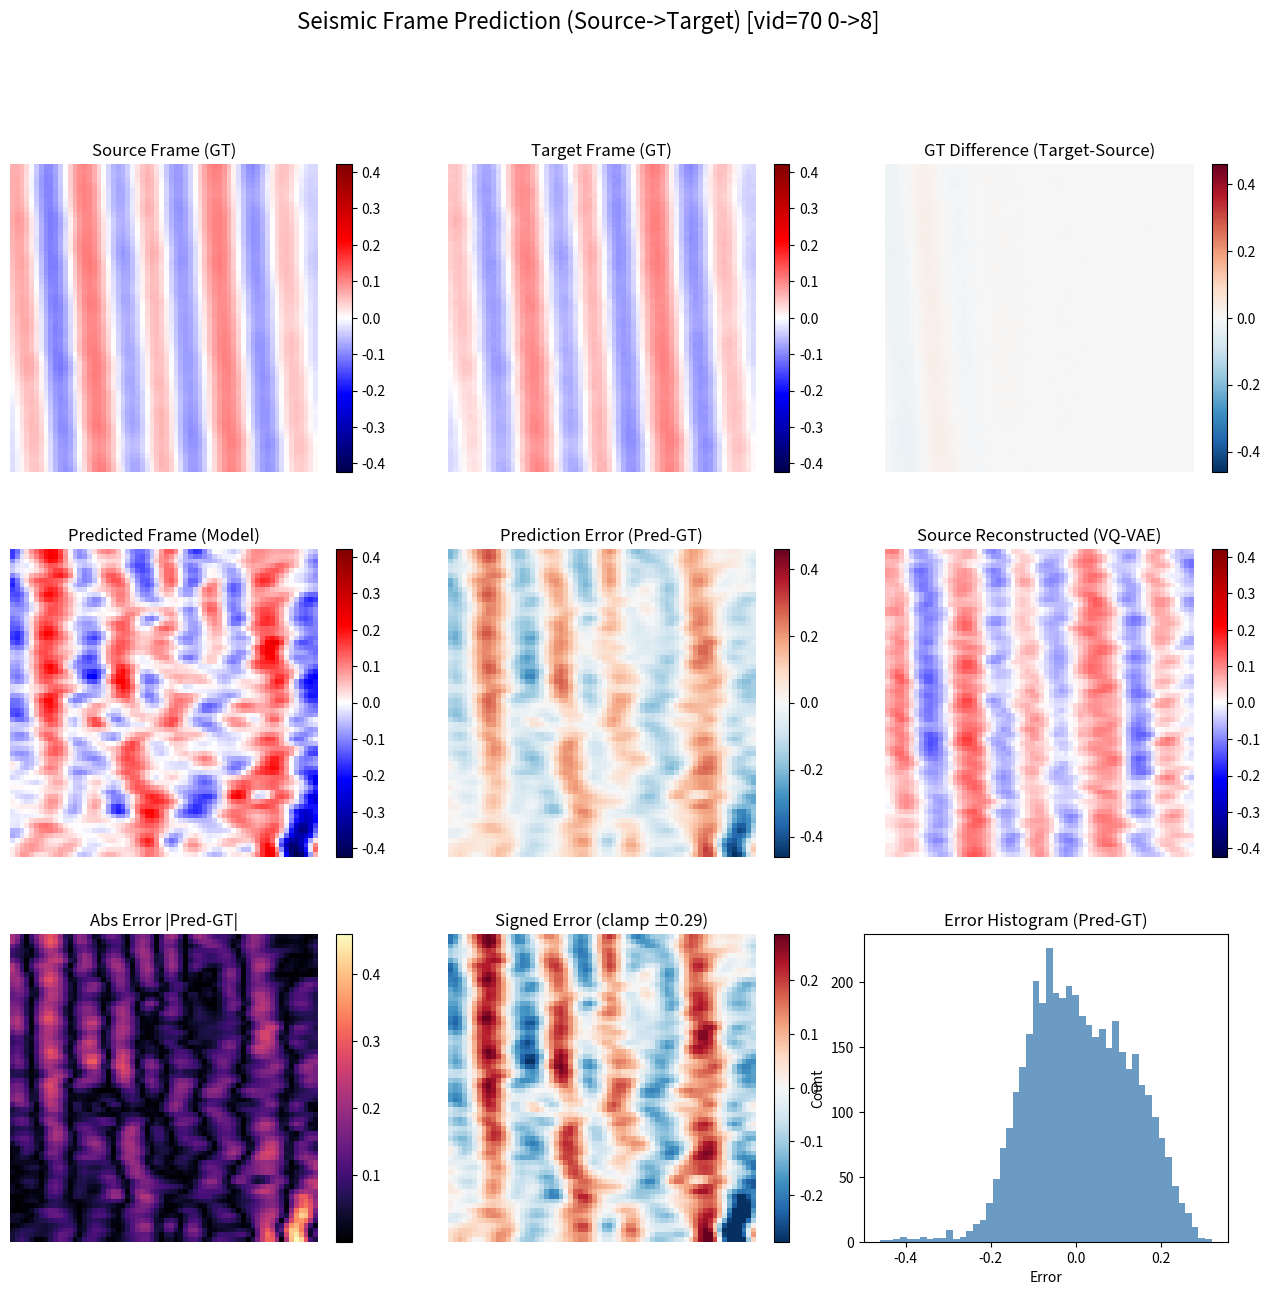

[Metrics] video=70 0->8  MAE=0.0976  RMSE=0.1189  Corr=-0.3291  SSIM=-0.1131  TokensGen=64 Time=0.767s

=== Summary (All Pairs) ===
VID   70  0->8  MAE=0.0976 RMSE=0.1189 Corr=-0.3291 SSIM=-0.1131 Time=0.767s Tokens=64


In [ ]:
# @title Generation & Comparison: Arbitrary Frame Pair(s) (Full Mode Support) {"vertical-output":true}
import math, torch, numpy as np, matplotlib.pyplot as plt, os, time
from typing import List, Tuple, Dict

#========================
# 配置参数
#========================
# (1) 指定使用的全量地震序列张量变量名：
#    - 如果你之前 full 模式的数据变量叫 seismic_data_video_full，请改这里
#    - 若没有该变量，会自动尝试使用 seismic_data_video（如果它本身就是 [N,9,H,W]）
FULL_DATA_VAR_NAME = "seismic_data_video"

# (2) 选择单个或多个 (video_idx, t_source, t_target) 组合
# 单个示例：
video_idx = 70        #@param {type:"integer"}
t_source  = 0         #@param {type:"integer"}
t_target  = 8         #@param {type:"integer"}

# 多组批量（如果不想批量，留空列表即可）
# 例如：[(71,0,1),(71,0,5),(71,3,8)]
batch_triplets: List[Tuple[int,int,int]] = []  #@param

# 若 batch_triplets 非空，则忽略上面的单个 (video_idx, t_source, t_target)
use_batch_list = len(batch_triplets) > 0

# (3) 采样与生成参数
temperature = 0.9     #@param {type:"number"}
top_k = 50            #@param {type:"integer"}
add_eos_in_generation = True  #@param {type:"boolean"} 是否允许生成 EOS 早停
override_max_new_tokens = 0   #@param {type:"integer"}  >0 则强制生成这么多 tokens (否则自动 = tokens_per_frame + (1 if add_eos else 0))

# (4) 可视化与输出
show_plots = True     #@param {type:"boolean"}
save_plots = True     #@param {type:"boolean"}
save_dir = f_path + "/generation_results"  #@param {type:"string"}
os.makedirs(save_dir, exist_ok=True)

# (5) 误差与显示裁剪（若想统一色标可设为 True）
use_symmetric_colorbar = True #@param {type:"boolean"}

#========================
# 前置依赖检查
#========================
assert 'loaded_model' in globals(), "需要已加载的 SeismicWorld Transformer (变量 loaded_model)"
assert 'vqvae_model' in globals(), "需要已加载的 VQ-VAE 模型 (变量 vqvae_model)"

# 取 full 数据
if FULL_DATA_VAR_NAME in globals():
    full_video_data = globals()[FULL_DATA_VAR_NAME]
else:
    raise ValueError(f"找不到变量 {FULL_DATA_VAR_NAME}，请确认 full 模式数据已在该变量中。")

if full_video_data.dim() != 4:
    raise ValueError(f"{FULL_DATA_VAR_NAME} 应为 [N,T,H,W]，当前 shape={tuple(full_video_data.shape)}")

N_full, T_full, H_full, W_full = full_video_data.shape
print(f"[Info] Full seismic video data loaded: shape={full_video_data.shape}")

tokens_per_frame = loaded_model.num_frame_tokens_per_step  # 训练时设定 (例: 64)
spatial_side = int(math.sqrt(tokens_per_frame))
assert spatial_side * spatial_side == tokens_per_frame, "tokens_per_frame 必须能开平方(对应 VQ-VAE 2D 网格)。"

#========================
# 工具函数
#========================
def encode_frame_to_tokens(frame_1hw: torch.Tensor) -> torch.Tensor:
    """
    输入: frame_1hw [1,1,H,W] (float)
    输出: tokens [1, tokens_per_frame] (long)  （未加 offset）
    """
    with torch.no_grad():
        # vqvae_model.encode_to_indices 期望 [B,1,H,W] 或 [B,T,H,W]?
        # 之前使用 encode_to_indices(sample_first_frame) 其中 sample_first_frame = [1,1,64,64]
        idx_map = vqvae_model.encode_to_indices(frame_1hw.to(DEVICE))  # [1,1,spatial_side,spatial_side]
        if idx_map.dim() == 4:
            # [B,1,h,w]
            flat = idx_map.view(1, -1)  # [1, tokens_per_frame]
        elif idx_map.dim() == 3:
            flat = idx_map.view(1, -1)
        else:
            raise RuntimeError(f"encode_to_indices 返回未知形状 {idx_map.shape}")
    return flat.long()

def generate_next_frame_tokens(
    source_tokens_with_offset: torch.Tensor,
    max_new_tokens: int,
    temperature: float,
    top_k: int,
    add_eos: bool
) -> torch.Tensor:
    """
    输入: source_tokens_with_offset [1, 1 + tokens_per_frame]  (BOS + 源帧tokens(带offset))
    返回: generated_sequence [1, seq_len_generated] (包含源 + 生成 token)
    """
    eos_id = loaded_model.eos_token_id if add_eos else None
    gen = loaded_model.generate(
        input_ids=source_tokens_with_offset,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_k=top_k,
        eos_token_id=eos_id
    )
    return gen  # [1, L]

def extract_predicted_frame_tokens(full_generated: torch.Tensor,
                                   input_length: int,
                                   tokens_per_frame: int,
                                   has_eos: bool,
                                   frame_token_offset: int,
                                   special_token_offset: int) -> torch.Tensor:
    """
    从生成的完整序列中分离出预测帧的前 tokens_per_frame 个 frame tokens (扣 offset).
    full_generated: [1, L]
    input_length: 原输入序列长度 (BOS + 源帧tokens)
    返回 [tokens_per_frame] (long)
    """
    gen_part = full_generated[:, input_length:]  # 只取新生成部分 [1, M]
    gen_tokens = gen_part[0]

    # 过滤掉特殊 token
    is_frame = (gen_tokens >= frame_token_offset) & (gen_tokens < special_token_offset)
    frame_tokens_only = gen_tokens[is_frame]

    if frame_tokens_only.numel() < tokens_per_frame:
        # 不足则截断+pad
        need = tokens_per_frame - frame_tokens_only.numel()
        frame_tokens_only = torch.cat([
            frame_tokens_only,
            torch.zeros(need, dtype=frame_tokens_only.dtype, device=frame_tokens_only.device)
        ])
    else:
        frame_tokens_only = frame_tokens_only[:tokens_per_frame]

    # 去 offset
    frame_tokens_only = frame_tokens_only - frame_token_offset
    return frame_tokens_only  # [tokens_per_frame]

def decode_tokens_to_frame(tokens_1d: torch.Tensor) -> torch.Tensor:
    """
    tokens_1d: [tokens_per_frame] (long, 无 offset)
    返回: reconstructed_frame [1,1,64,64]
    """
    idx_map = tokens_1d.view(1, 1, spatial_side, spatial_side)
    with torch.no_grad():
        frame = vqvae_model.decode_from_indices(
            idx_map.to(DEVICE),
            video_contains_first_frame=True
        )  # 期望输出 [1,1,64,64]
    return frame

def simple_ssim(img1: np.ndarray, img2: np.ndarray) -> float:
    mu1, mu2 = img1.mean(), img2.mean()
    sigma1, sigma2 = img1.std(), img2.std()
    sigma12 = np.mean((img1 - mu1)*(img2 - mu2))
    c1, c2 = 0.01**2, 0.03**2
    return ((2*mu1*mu2 + c1)*(2*sigma12 + c2))/((mu1**2 + mu2**2 + c1)*(sigma1**2 + sigma2**2 + c2)+1e-12)

def tensor_to_np(frame_tensor: torch.Tensor) -> np.ndarray:
    """
    frame_tensor: [1,1,64,64] 或 [1,64,64]
    返回: [64,64] numpy
    """
    if frame_tensor.dim() == 4:
        return frame_tensor.squeeze(0).squeeze(0).detach().cpu().numpy()
    elif frame_tensor.dim() == 3:
        return frame_tensor.squeeze(0).detach().cpu().numpy()
    else:
        raise ValueError(f"Unexpected tensor shape {frame_tensor.shape}")

def visualize_pair(
    img_source_orig, img_target_orig, img_pred,
    save_path: str = None,
    title_extra: str = ""
):
    """
    三行六图布局：
    Row1: Source (GT), Target (GT), GT diff (Target-Source)
    Row2: Predicted (decoded), Prediction Error (Pred - Target), Source Reconstructed (VQ-VAE)
    Row3: (可选) 绝对误差 / 直方图 / 其他; 这里放: Abs Error, Signed Error Clamped, Histogram(误差)
    """
    # 这里我们还可以把源帧通过 encode->decode 再展示 VQ-VAE 重建
    # 以衡量 tokenization 重建误差
    with torch.no_grad():
        src_tensor = torch.from_numpy(img_source_orig).float().to(DEVICE)
        src_tensor = src_tensor.unsqueeze(0).unsqueeze(0)
        src_idx = vqvae_model.encode_to_indices(src_tensor)
        src_rec = vqvae_model.decode_from_indices(src_idx, video_contains_first_frame=True)
        img_source_rec = tensor_to_np(src_rec)

    diff_gt = img_target_orig - img_source_orig
    diff_pred = img_pred - img_target_orig
    abs_err = np.abs(diff_pred)

    vmax_src = np.max(np.abs(img_source_orig)) if use_symmetric_colorbar else img_source_orig.max()
    vmax_tgt = np.max(np.abs(img_target_orig)) if use_symmetric_colorbar else img_target_orig.max()
    vmax_pred = np.max(np.abs(img_pred)) if use_symmetric_colorbar else img_pred.max()
    vmax_diff_gt = np.max(np.abs(diff_gt))
    vmax_diff_pred = np.max(np.abs(diff_pred))
    vmax_src_rec = np.max(np.abs(img_source_rec))

    # 统一一个振幅范围（可选）；也可以分别
    if use_symmetric_colorbar:
        amp = max(vmax_src, vmax_tgt, vmax_pred, vmax_src_rec)
        vmax_src = vmax_tgt = vmax_pred = vmax_src_rec = amp
        err_amp = max(vmax_diff_gt, vmax_diff_pred)
        vmax_diff_gt = vmax_diff_pred = err_amp

    fig, axes = plt.subplots(3, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.25, wspace=0.2)

    im0 = axes[0,0].imshow(img_source_orig, cmap='seismic',
                           vmin=-vmax_src if use_symmetric_colorbar else None,
                           vmax=vmax_src if use_symmetric_colorbar else None)
    axes[0,0].set_title("Source Frame (GT)")
    axes[0,0].axis('off'); plt.colorbar(im0, ax=axes[0,0], fraction=0.046)

    im1 = axes[0,1].imshow(img_target_orig, cmap='seismic',
                           vmin=-vmax_tgt if use_symmetric_colorbar else None,
                           vmax=vmax_tgt if use_symmetric_colorbar else None)
    axes[0,1].set_title("Target Frame (GT)")
    axes[0,1].axis('off'); plt.colorbar(im1, ax=axes[0,1], fraction=0.046)

    im2 = axes[0,2].imshow(diff_gt, cmap='RdBu_r',
                           vmin=-vmax_diff_gt, vmax=vmax_diff_gt)
    axes[0,2].set_title("GT Difference (Target-Source)")
    axes[0,2].axis('off'); plt.colorbar(im2, ax=axes[0,2], fraction=0.046)

    im3 = axes[1,0].imshow(img_pred, cmap='seismic',
                           vmin=-vmax_pred if use_symmetric_colorbar else None,
                           vmax=vmax_pred if use_symmetric_colorbar else None)
    axes[1,0].set_title("Predicted Frame (Model)")
    axes[1,0].axis('off'); plt.colorbar(im3, ax=axes[1,0], fraction=0.046)

    im4 = axes[1,1].imshow(diff_pred, cmap='RdBu_r',
                           vmin=-vmax_diff_pred, vmax=vmax_diff_pred)
    axes[1,1].set_title("Prediction Error (Pred-GT)")
    axes[1,1].axis('off'); plt.colorbar(im4, ax=axes[1,1], fraction=0.046)

    im5 = axes[1,2].imshow(img_source_rec, cmap='seismic',
                           vmin=-vmax_src_rec if use_symmetric_colorbar else None,
                           vmax=vmax_src_rec if use_symmetric_colorbar else None)
    axes[1,2].set_title("Source Reconstructed (VQ-VAE)")
    axes[1,2].axis('off'); plt.colorbar(im5, ax=axes[1,2], fraction=0.046)

    # Row 3
    im6 = axes[2,0].imshow(abs_err, cmap='magma')
    axes[2,0].set_title("Abs Error |Pred-GT|")
    axes[2,0].axis('off'); plt.colorbar(im6, ax=axes[2,0], fraction=0.046)

    # Clamped signed error (强调小误差区域)
    clamp_val = np.percentile(np.abs(diff_pred), 99)
    im7 = axes[2,1].imshow(np.clip(diff_pred, -clamp_val, clamp_val), cmap='RdBu_r',
                           vmin=-clamp_val, vmax=clamp_val)
    axes[2,1].set_title(f"Signed Error (clamp ±{clamp_val:.2f})")
    axes[2,1].axis('off'); plt.colorbar(im7, ax=axes[2,1], fraction=0.046)

    # Histogram of error
    axes[2,2].hist(diff_pred.flatten(), bins=50, color='steelblue', alpha=0.8)
    axes[2,2].set_title("Error Histogram (Pred-GT)")
    axes[2,2].set_xlabel("Error")
    axes[2,2].set_ylabel("Count")

    fig.suptitle(f"Seismic Frame Prediction (Source->Target) {title_extra}", fontsize=16, y=0.99)
    if save_plots and save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show_plots:
        plt.show()
    else:
        plt.close(fig)

def compute_metrics(pred: np.ndarray, gt: np.ndarray, src: np.ndarray) -> Dict[str,float]:
    diff = pred - gt
    rec_err_src = src - pred  # (非必须，只演示)
    return {
        "MAE": float(np.abs(diff).mean()),
        "RMSE": float(np.sqrt((diff**2).mean())),
        "Pred_vs_GT_Corr": float(np.corrcoef(pred.flatten(), gt.flatten())[0,1]),
        "SSIM_Pred_GT": float(simple_ssim(pred, gt)),
        "GT_FrameDiff_Range": float((gt - src).max() - (gt - src).min())
    }

#========================
# 主流程
#========================
pairs_to_run = batch_triplets if use_batch_list else [(video_idx, t_source, t_target)]
results_all = []

for (vid, ts, tt) in pairs_to_run:
    if not (0 <= vid < N_full):
        print(f"[Skip] video_idx {vid} 超界")
        continue
    if not (0 <= ts < T_full and 0 <= tt < T_full):
        print(f"[Skip] time indices {ts},{tt} 超界 (T={T_full})")
        continue
    if ts == tt:
        print(f"[Skip] 源与目标时间索引相同 ({ts})，无预测意义")
        continue

    print(f"\n=== Running Pair: video={vid}, source_t={ts}, target_t={tt} ===")

    # 取源帧 / 目标帧
    source_frame = full_video_data[vid, ts]  # [64,64]
    target_frame = full_video_data[vid, tt]

    # 组装成 [1,1,H,W]
    source_frame_t = source_frame.unsqueeze(0).unsqueeze(0).float()
    target_frame_t = target_frame.unsqueeze(0).unsqueeze(0).float()

    # 编码源帧 tokens
    source_tokens = encode_frame_to_tokens(source_frame_t)  # [1, tokens_per_frame]

    # 构建初始序列: BOS + 源帧 tokens (带 offset)
    bos_token = torch.tensor([[loaded_model.bos_token_id]], device=DEVICE)
    source_tokens_offset = source_tokens + loaded_model.frame_token_offset
    input_sequence = torch.cat([bos_token.to(DEVICE), source_tokens_offset.to(DEVICE)], dim=1)  # [1, 1+tokens_per_frame]

    # 计算最大生成 tokens
    if override_max_new_tokens > 0:
        max_new = override_max_new_tokens
    else:
        max_new = tokens_per_frame + (1 if add_eos_in_generation else 0)

    # 生成
    start_time = time.time()
    generated_full = generate_next_frame_tokens(
        source_tokens_with_offset=input_sequence,
        max_new_tokens=max_new,
        temperature=temperature,
        top_k=top_k,
        add_eos=add_eos_in_generation
    )
    gen_time = time.time() - start_time

    # 提取预测帧 tokens
    predicted_frame_tokens = extract_predicted_frame_tokens(
        full_generated=generated_full,
        input_length=input_sequence.shape[1],
        tokens_per_frame=tokens_per_frame,
        has_eos=add_eos_in_generation,
        frame_token_offset=loaded_model.frame_token_offset,
        special_token_offset=loaded_model.special_token_offset
    )

    # 解码预测帧
    predicted_frame = decode_tokens_to_frame(predicted_frame_tokens)  # [1,1,64,64]

    # 同时将源帧/目标帧通过 VQ-VAE 直接 decode 以对齐统计 (这里源帧不需再 decode，因为直接原像素即可)
    src_np = tensor_to_np(source_frame_t)
    tgt_np = tensor_to_np(target_frame_t)
    pred_np = tensor_to_np(predicted_frame)

    # 统计
    metrics = compute_metrics(pred_np, tgt_np, src_np)
    metrics.update({
        "video_idx": vid,
        "t_source": ts,
        "t_target": tt,
        "gen_tokens": int(generated_full.shape[1] - input_sequence.shape[1]),
        "gen_time_sec": gen_time
    })
    results_all.append(metrics)

    # 可视化
    fn = f"gen_vid{vid}_s{ts}_t{tt}_{int(time.time())}.png"
    save_path = os.path.join(save_dir, fn)
    visualize_pair(
        img_source_orig=src_np,
        img_target_orig=tgt_np,
        img_pred=pred_np,
        save_path=save_path if save_plots else None,
        title_extra=f"[vid={vid} {ts}->{tt}]"
    )

    # 打印简要
    print(f"[Metrics] video={vid} {ts}->{tt}  MAE={metrics['MAE']:.4f}  RMSE={metrics['RMSE']:.4f}  "
          f"Corr={metrics['Pred_vs_GT_Corr']:.4f}  SSIM={metrics['SSIM_Pred_GT']:.4f}  "
          f"TokensGen={metrics['gen_tokens']} Time={metrics['gen_time_sec']:.3f}s")

#========================
# 汇总输出
#========================
if results_all:
    print("\n=== Summary (All Pairs) ===")
    for m in results_all:
        print(f"VID {m['video_idx']:4d}  {m['t_source']}->{m['t_target']}  "
              f"MAE={m['MAE']:.4f} RMSE={m['RMSE']:.4f} Corr={m['Pred_vs_GT_Corr']:.4f} "
              f"SSIM={m['SSIM_Pred_GT']:.4f} Time={m['gen_time_sec']:.3f}s Tokens={m['gen_tokens']}")
else:
    print("没有成功的结果。")


=== Frame-to-Frame Generation Example ===
Using sample from seismic_data_video: torch.Size([1, 1, 64, 64])
Encoding first frame to tokens...
First frame indices shape: torch.Size([1, 1, 8, 8])
Second frame indices shape: torch.Size([1, 1, 8, 8])
First frame tokens shape: torch.Size([1, 64])
Second frame tokens shape: torch.Size([1, 64])
Input sequence shape (BOS + first frame): torch.Size([1, 65])
Target sequence shape (BOS + second frame): torch.Size([1, 65])
Generating next frame...
Generated sequence shape: torch.Size([1, 129])
Original input length: 65
Generated tokens: 64
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: torch.Size([1, 1, 64, 64])
Valid frame tokens: 64
Number of complete frames to reconstruct: 1
Frame 0 indices shape: torch.Size([1, 1, 8, 8])
quantized_features=torch.Size([1, 1, 8, 8, 512])
Frame 0 reconstructed shape: tor

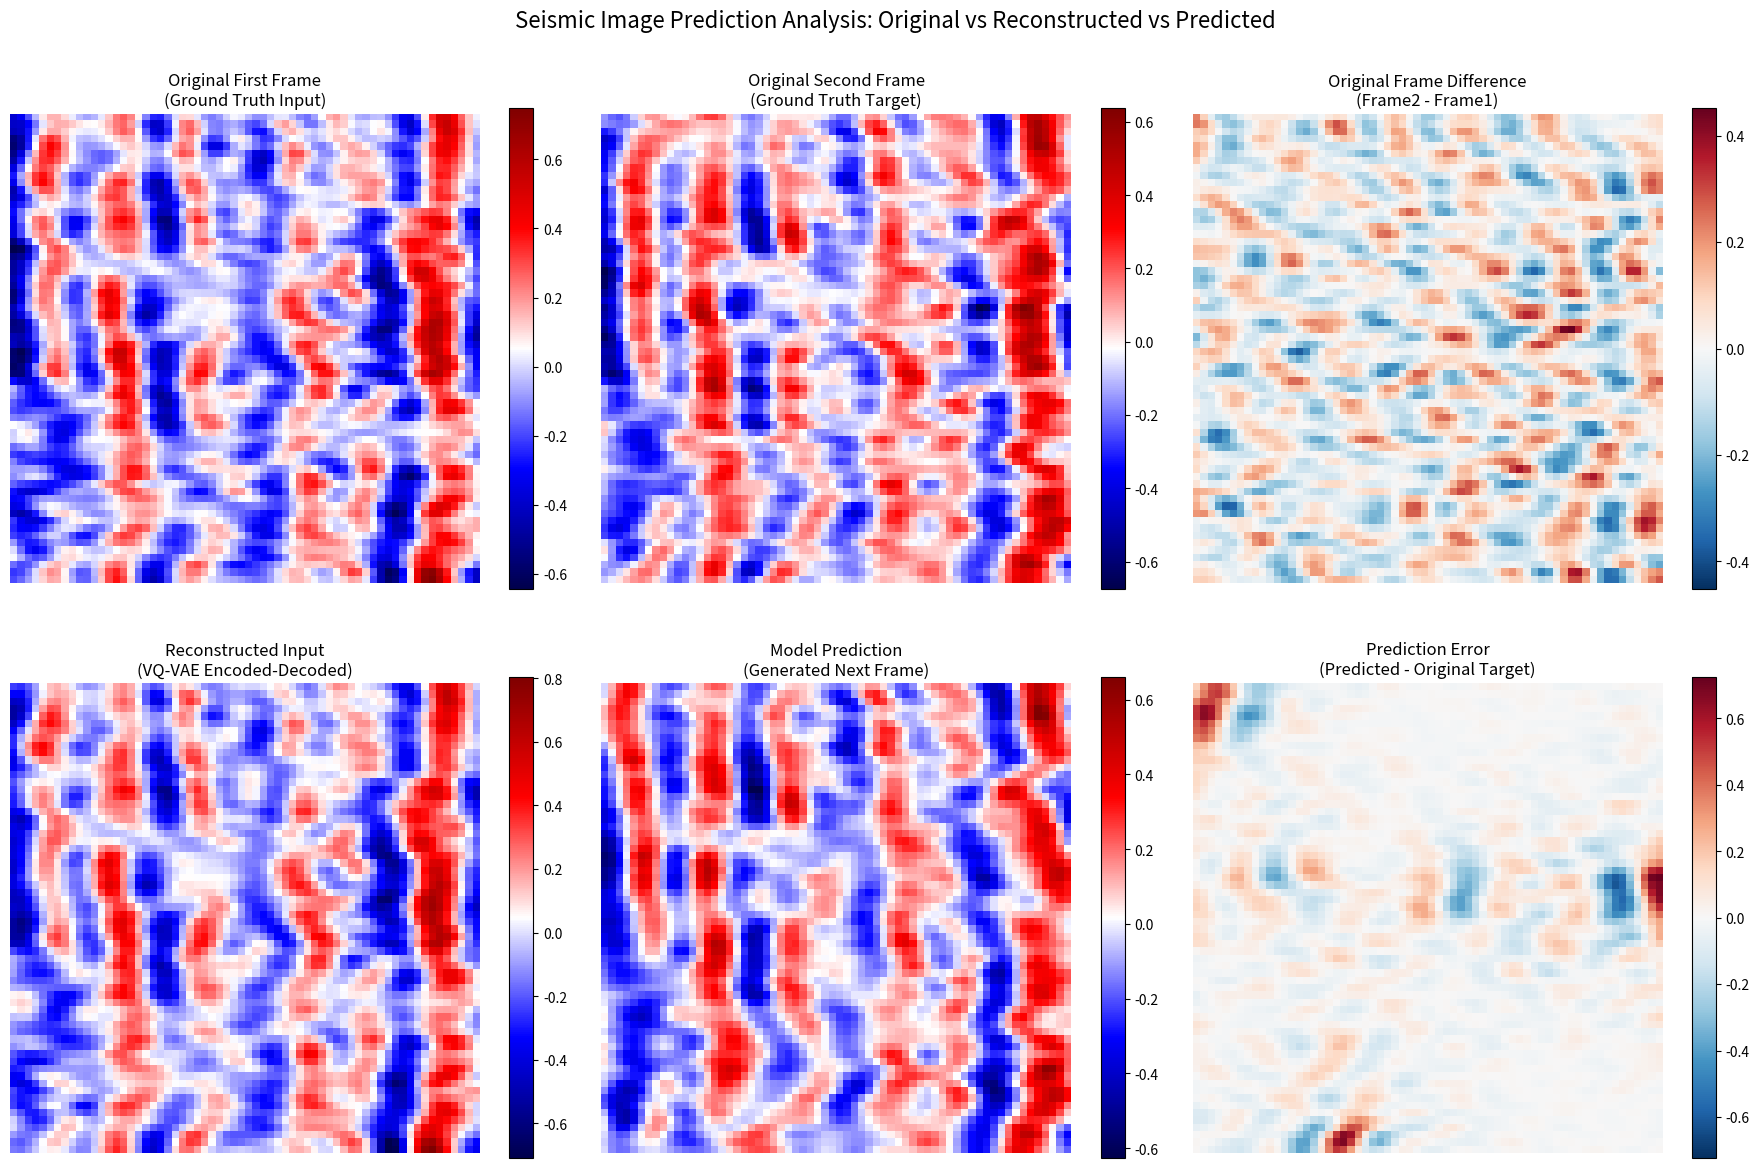

In [ ]:
#@title Generation: Given first frame, predict next frame
#@title reconstruct image from generated sequence
def reconstruct_images_from_generated_sequence(
    generated_sequence,
    vqvae_model,
    seismic_world_model,
    device,
    return_both_frames=True
):
    """
    将生成的token序列重建为图片

    Args:
        generated_sequence: [1, seq_len] 生成的token序列
        vqvae_model: 训练好的VQ-VAE模型
        seismic_world_model: SeismicWorld模型 (用于获取token偏移量)
        device: 设备
        return_both_frames: 是否返回两帧图片，否则只返回生成的第二帧

    Returns:
        reconstructed_images: 重建的图片 tensor
    """
    vqvae_model.eval()

    with torch.no_grad():
        # 1. 移除 BOS token 和可能的 EOS/PAD tokens
        sequence = generated_sequence.squeeze(0)  # [seq_len]

        # 找到有效的frame tokens (排除特殊tokens)
        frame_mask = (sequence >= seismic_world_model.frame_token_offset) & \
                    (sequence < seismic_world_model.special_token_offset)

        frame_tokens = sequence[frame_mask]
        print(f"Valid frame tokens: {len(frame_tokens)}")

        # 2. 移除token偏移量，恢复原始VQ-VAE indices
        frame_indices = frame_tokens - seismic_world_model.frame_token_offset

        # 3. 根据每帧64个tokens分割序列
        tokens_per_frame = seismic_world_model.num_frame_tokens_per_step  # 64

        if len(frame_indices) < tokens_per_frame:
            print(f"Warning: Not enough tokens for a complete frame. Got {len(frame_indices)}, expected {tokens_per_frame}")
            # 用0填充不足的tokens
            padding_needed = tokens_per_frame - len(frame_indices)
            padding = torch.zeros(padding_needed, dtype=frame_indices.dtype, device=device)
            frame_indices = torch.cat([frame_indices, padding])

        reconstructed_frames = []

        # 4. 处理每一帧
        num_complete_frames = len(frame_indices) // tokens_per_frame
        print(f"Number of complete frames to reconstruct: {num_complete_frames}")

        for frame_idx in range(num_complete_frames):
            start_idx = frame_idx * tokens_per_frame
            end_idx = start_idx + tokens_per_frame

            # 获取当前帧的indices
            current_frame_indices = frame_indices[start_idx:end_idx]

            # 5. 重塑为空间维度 [1, 1, 8, 8] (假设是8x8的spatial tokens)
            spatial_size = int(math.sqrt(tokens_per_frame))  # 8
            current_frame_indices = current_frame_indices.view(1, 1, spatial_size, spatial_size)

            print(f"Frame {frame_idx} indices shape: {current_frame_indices.shape}")

            # 6. 使用VQ-VAE解码
            try:
                reconstructed_frame = vqvae_model.decode_from_indices(
                    current_frame_indices,
                    video_contains_first_frame=True
                )

                print(f"Frame {frame_idx} reconstructed shape: {reconstructed_frame.shape}")
                reconstructed_frames.append(reconstructed_frame)

            except Exception as e:
                print(f"Error reconstructing frame {frame_idx}: {e}")
                # 创建一个零填充的帧作为fallback
                fallback_frame = torch.zeros(1, 1, 64, 64, device=device)
                reconstructed_frames.append(fallback_frame)

        if not reconstructed_frames:
            print("No frames could be reconstructed!")
            return None

        # 7. 组合所有帧
        if return_both_frames and len(reconstructed_frames) >= 2:
            # 返回两帧 [1, 2, 64, 64]
            combined_frames = torch.cat(reconstructed_frames[:2], dim=1)
        elif len(reconstructed_frames) >= 1:
            # 只返回第一帧（或生成的帧）
            combined_frames = reconstructed_frames[-1]  # 取最后生成的帧
        else:
            return None

        return combined_frames

# Generation example: Given first frame, predict next frame
print("=== Frame-to-Frame Generation Example ===")

index = 71 #@param {type:"integer"}
# Method 1: Using a sample from your seismic data
if 'seismic_data_video' in locals():
    # Take the first frame from your seismic data
    sample_first_frame = seismic_data_video[index:index+1, 0:1, :, :]  # [1, 1, 64, 64]
    sample_second_frame = seismic_data_video[index:index+1, 1:2, :, :]  # [1, 1, 64, 64]
    print(f"Using sample from seismic_data_video: {sample_first_frame.shape}")
else:
    print(f"seismic_data_video DOES NOT EXIST!")

# Encode the first frame using VQ-VAE
print("Encoding first frame to tokens...")
vqvae_model.eval()
with torch.no_grad():
    # Encode first frame: [1, 1, 64, 64] -> [1, 1, 8, 8]
    first_frame_indices = vqvae_model.encode_to_indices(sample_first_frame.to(DEVICE))
    second_frame_indices = vqvae_model.encode_to_indices(sample_second_frame.to(DEVICE))
    print(f"First frame indices shape: {first_frame_indices.shape}")
    print(f"Second frame indices shape: {second_frame_indices.shape}")

    # Flatten spatial dimensions: [1, 1, 8, 8] -> [1, 64]
    first_frame_tokens = first_frame_indices.view(1, -1)
    second_frame_tokens = second_frame_indices.view(1, -1)
    print(f"First frame tokens shape: {first_frame_tokens.shape}")
    print(f"Second frame tokens shape: {second_frame_tokens.shape}")

    # Add frame token offset
    first_frame_tokens_offset = first_frame_tokens + loaded_model.frame_token_offset
    second_frame_tokens_offset = second_frame_tokens + loaded_model.frame_token_offset

# Create input sequence: BOS + first_frame_tokens
bos_token = torch.tensor([[loaded_model.bos_token_id]], device=DEVICE)
input_sequence = torch.cat([bos_token, first_frame_tokens_offset], dim=1)
target_sequence = torch.cat([bos_token, second_frame_tokens_offset], dim=1) # add bos_token?
print(f"Input sequence shape (BOS + first frame): {input_sequence.shape}")
print(f"Target sequence shape (BOS + second frame): {target_sequence.shape}")

# Generate the next frame tokens
print("Generating next frame...")
generated_sequence = loaded_model.generate(
    input_ids=input_sequence,
    max_new_tokens=65,  # 64 tokens for next frame + 1 EOS token = 65
    temperature=0.9,
    top_k=50,
    eos_token_id=loaded_model.eos_token_id
)


print(f"Generated sequence shape: {generated_sequence.shape}")
print(f"Original input length: {input_sequence.shape[1]}")
print(f"Generated tokens: {generated_sequence.shape[1] - input_sequence.shape[1]}")

# 使用示例 - 重构第一张图（前65个token）
reconstructed_images_1 = reconstruct_images_from_generated_sequence( # input_frame
    generated_sequence=generated_sequence[:,0:65],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

# 使用示例 - 重构第二张图（后64个token）
reconstructed_images_2 = reconstruct_images_from_generated_sequence( # prediction_frame
    generated_sequence=generated_sequence[:,-65:],
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)

reconstructed_images_3 = reconstruct_images_from_generated_sequence( # target_frame
    generated_sequence=target_sequence,
    vqvae_model=vqvae_model,
    seismic_world_model=loaded_model,
    device=DEVICE,
    return_both_frames=True
)
# 定义图像处理函数
def process_image_for_display(img_tensor):
    """将tensor转换为可显示的numpy数组"""
    if img_tensor.dim() == 4:  # [1, C, H, W]
        return img_tensor.squeeze(0).squeeze(0).cpu().numpy()
    elif img_tensor.dim() == 5:  # [1, C, T, H, W]
        return img_tensor.squeeze(0).squeeze(0).squeeze(0).cpu().numpy()
    else:
        return img_tensor.cpu().numpy()

save = True #@param {type:"boolean"}

if (reconstructed_images_1 is not None and
    reconstructed_images_2 is not None and
    reconstructed_images_3 is not None):

    print(f"Input image shape: {reconstructed_images_1.shape}")
    print(f"Prediction image shape: {reconstructed_images_2.shape}")
    print(f"Target image shape: {reconstructed_images_3.shape}")

    # 处理图像
    img_input = process_image_for_display(reconstructed_images_1)      # 输入
    img_prediction = process_image_for_display(reconstructed_images_2) # 预测
    img_target = process_image_for_display(reconstructed_images_3)     # 标签
    img_diff = img_prediction - img_target                             # 预测与标签的差异

    # 处理原图
    img_original_first = process_image_for_display(sample_first_frame)   # 原始第一帧
    img_original_second = process_image_for_display(sample_second_frame) # 原始第二帧
    img_original_diff = img_original_second - img_original_first         # 原图差值

    # 创建2x3的子图布局
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 第一行：原图对比
    # 子图1：原始第一帧
    im1 = axes[0,0].imshow(img_original_first, cmap='seismic')
    axes[0,0].set_title('Original First Frame\n(Ground Truth Input)', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)

    # 子图2：原始第二帧
    im2 = axes[0,1].imshow(img_original_second, cmap='seismic')
    axes[0,1].set_title('Original Second Frame\n(Ground Truth Target)', fontsize=12, fontweight='bold')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1], shrink=0.8)

    # 子图3：原图差值
    original_diff_max = np.abs(img_original_diff).max()
    im3 = axes[0,2].imshow(img_original_diff, cmap='RdBu_r', vmin=-original_diff_max, vmax=original_diff_max)
    axes[0,2].set_title('Original Frame Difference\n(Frame2 - Frame1)', fontsize=12, fontweight='bold')
    axes[0,2].axis('off')
    plt.colorbar(im3, ax=axes[0,2], shrink=0.8)

    # 第二行：重建图对比
    # 子图4：重建输入图像
    im4 = axes[1,0].imshow(img_input, cmap='seismic')
    axes[1,0].set_title('Reconstructed Input\n(VQ-VAE Encoded-Decoded)', fontsize=12, fontweight='bold')
    axes[1,0].axis('off')
    plt.colorbar(im4, ax=axes[1,0], shrink=0.8)

    # 子图5：预测图像
    im5 = axes[1,1].imshow(img_prediction, cmap='seismic')
    axes[1,1].set_title('Model Prediction\n(Generated Next Frame)', fontsize=12, fontweight='bold')
    axes[1,1].axis('off')
    plt.colorbar(im5, ax=axes[1,1], shrink=0.8)

    # 子图6：预测误差
    pred_diff_max = np.abs(img_diff).max()
    im6 = axes[1,2].imshow(img_diff, cmap='RdBu_r', vmin=-pred_diff_max, vmax=pred_diff_max)
    axes[1,2].set_title('Prediction Error\n(Predicted - Original Target)', fontsize=12, fontweight='bold')
    axes[1,2].axis('off')
    plt.colorbar(im6, ax=axes[1,2], shrink=0.8)

    # 调整子图间距
    plt.tight_layout()

    # 添加总标题
    fig.suptitle('Seismic Image Prediction Analysis: Original vs Reconstructed vs Predicted',
                 fontsize=16, fontweight='bold', y=1.02)

    # 显示详细统计信息
    print("="*80)
    print("COMPREHENSIVE PREDICTION ANALYSIS STATISTICS")
    print("="*80)

    print(f"Original First Frame Stats:")
    print(f"  Shape: {img_original_first.shape}")
    print(f"  Range: [{img_original_first.min():.4f}, {img_original_first.max():.4f}]")
    print(f"  Mean: {img_original_first.mean():.4f}, Std: {img_original_first.std():.4f}")

    print(f"\nOriginal Second Frame Stats:")
    print(f"  Shape: {img_original_second.shape}")
    print(f"  Range: [{img_original_second.min():.4f}, {img_original_second.max():.4f}]")
    print(f"  Mean: {img_original_second.mean():.4f}, Std: {img_original_second.std():.4f}")

    print(f"\nReconstructed Input Image Stats:")
    print(f"  Shape: {img_input.shape}")
    print(f"  Range: [{img_input.min():.4f}, {img_input.max():.4f}]")
    print(f"  Mean: {img_input.mean():.4f}, Std: {img_input.std():.4f}")

    print(f"\nPredicted Image Stats:")
    print(f"  Shape: {img_prediction.shape}")
    print(f"  Range: [{img_prediction.min():.4f}, {img_prediction.max():.4f}]")
    print(f"  Mean: {img_prediction.mean():.4f}, Std: {img_prediction.std():.4f}")

    print(f"\nOriginal Frame Difference Stats:")
    print(f"  Range: [{img_original_diff.min():.4f}, {img_original_diff.max():.4f}]")
    print(f"  Mean: {img_original_diff.mean():.4f}, Std: {img_original_diff.std():.4f}")
    print(f"  Mean Absolute Difference: {np.abs(img_original_diff).mean():.4f}")

    print(f"\nPrediction Error Stats (vs Original Target):")
    print(f"  Range: [{img_diff.min():.4f}, {img_diff.max():.4f}]")
    print(f"  Mean: {img_diff.mean():.4f}, Std: {img_diff.std():.4f}")
    print(f"  Mean Absolute Error (MAE): {np.abs(img_diff).mean():.4f}")
    print(f"  Root Mean Square Error (RMSE): {np.sqrt(np.mean(img_diff**2)):.4f}")

    # VQ-VAE重建质量评估
    input_reconstruction_error = img_input - img_original_first
    print(f"\nVQ-VAE Reconstruction Quality (Input):")
    print(f"  Reconstruction MAE: {np.abs(input_reconstruction_error).mean():.4f}")
    print(f"  Reconstruction RMSE: {np.sqrt(np.mean(input_reconstruction_error**2)):.4f}")

    # 相似性指标
    correlation_pred_orig = np.corrcoef(img_prediction.flatten(), img_original_second.flatten())[0,1]
    correlation_pred_target = np.corrcoef(img_prediction.flatten(), img_target.flatten())[0,1]
    correlation_orig_frames = np.corrcoef(img_original_first.flatten(), img_original_second.flatten())[0,1]

    print(f"\nCorrelation Analysis:")
    print(f"  Prediction vs Original Target: {correlation_pred_orig:.4f}")
    print(f"  Prediction vs Reconstructed Target: {correlation_pred_target:.4f}")
    print(f"  Original Frame1 vs Frame2: {correlation_orig_frames:.4f}")

    # 结构相似性指标 (简化版)
    def simple_ssim(img1, img2):
        mu1, mu2 = img1.mean(), img2.mean()
        sigma1, sigma2 = img1.std(), img2.std()
        sigma12 = np.mean((img1 - mu1) * (img2 - mu2))

        c1, c2 = 0.01**2, 0.03**2
        ssim = ((2*mu1*mu2 + c1) * (2*sigma12 + c2)) / ((mu1**2 + mu2**2 + c1) * (sigma1**2 + sigma2**2 + c2))
        return ssim

    ssim_pred_orig = simple_ssim(img_prediction, img_original_second)
    ssim_input_orig = simple_ssim(img_input, img_original_first)

    print(f"\nStructural Similarity (SSIM):")
    print(f"  Prediction vs Original Target: {ssim_pred_orig:.4f}")
    print(f"  VQ-VAE Input Reconstruction: {ssim_input_orig:.4f}")

    print("="*80)

    if save:
      # 保存图片为PDF格式
      plt.savefig(f_path+f'/SW地震预测展示图{index}_finetuned.pdf',
                  format='pdf',           # 指定PDF格式
                  dpi=300,               # 设置分辨率
                  bbox_inches='tight',   # 紧凑布局，去除多余空白
                  facecolor='white',     # 背景色为白色
                  edgecolor='none',      # 无边框
                  transparent=False)     # 非透明背景
      print(f'已经成功保存到{f_path}/SW地震预测展示图{index}.pdf')
    plt.show()

else:
    print("Error: One or more reconstructed images is None")
    if reconstructed_images_1 is None:
        print("- Input image reconstruction failed")
    if reconstructed_images_2 is None:
        print("- Prediction image reconstruction failed")
    if reconstructed_images_3 is None:
        print("- Target image reconstruction failed")


# 单帧-多帧 （忽略第一帧自回归预测）

In [16]:
# @title 多帧版 SeismicWorld 训练与自回归推理（扩展） {"vertical-output":true,"form-width":"30%"}
import os, math, json, shutil
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

############################################
# 0. 工具函数
############################################
def _safe_mkdir(path: str):
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def _load_history(json_path: str) -> List[Dict[str, Any]]:
    if os.path.exists(json_path):
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
            if isinstance(data, list):
                return data
        except Exception as e:
            print(f"[Warn] 读取历史 JSON 失败({e})，重建: {json_path}")
    return []

def _save_history(json_path: str, history: List[Dict[str, Any]]):
    tmp_path = json_path + ".tmp"
    with open(tmp_path, 'w') as f:
        json.dump(history, f, indent=2, ensure_ascii=False)
    os.replace(tmp_path, json_path)

def _prune_checkpoints(history: List[Dict[str, Any]], keep_last_best: int):
    if keep_last_best <= 0 or len(history) <= keep_last_best:
        return history, []
    to_delete = history[:-keep_last_best]
    remain = history[-keep_last_best:]
    delete_files = [item['checkpoint_path'] for item in to_delete if 'checkpoint_path' in item]
    return remain, delete_files

############################################
# 1. VQ-VAE -> 序列编码
############################################
def build_frame_sequence_tokens(
    videos_4d: torch.Tensor,     # [N, T, H, W]
    vqvae_model,
    device,
    mode: str = 'multiframe',    # 'multiframe' or 'pair'
    max_frames: int = None,
    downsample_time: int = 1,
    print_every: int = 200
):
    """
    输出:
        sequences: list[Tensor]
            - multiframe: 每元素 [T, K]
            - pair:       每元素 [2, K]
        meta: dict
            - num_tokens_per_frame
            - Hq, Wq
            - codebook_size
            - mode
            - original_frames
    """
    assert videos_4d.dim() == 4, "videos_4d 需为 [N, T, H, W]"
    N, T, H, W = videos_4d.shape
    if max_frames is not None:
        T = min(T, max_frames)
        videos_4d = videos_4d[:, :T]

    if downsample_time > 1:
        videos_4d = videos_4d[:, ::downsample_time]
        T = videos_4d.shape[1]

    vqvae_model.eval().to(device)

    all_frames = videos_4d.reshape(N * T, 1, H, W)
    batch_size_enc = 64
    frame_tokens_list = []
    with torch.no_grad():
        for i in tqdm(range(0, len(all_frames), batch_size_enc), desc="VQ-VAE 编码所有帧"):
            batch = all_frames[i:i+batch_size_enc].to(device)
            indices = vqvae_model.encode_to_indices(batch)  # 预期 [B,Hq,Wq] or [B,1,Hq,Wq]
            if indices.dim() == 4:
                indices = indices.squeeze(1)
            # 安全防御
            if (indices < 0).any() or (indices >= vqvae_model.codebook_size).any():
                raise ValueError("VQ-VAE 返回越界 token，请检查 encode_to_indices。")
            frame_tokens_list.append(indices.cpu())
    all_frame_tokens = torch.cat(frame_tokens_list, dim=0)  # [N*T, Hq, Wq]
    Hq, Wq = all_frame_tokens.shape[-2], all_frame_tokens.shape[-1]
    num_tokens_per_frame = Hq * Wq

    all_frame_tokens = all_frame_tokens.view(N, T, Hq, Wq)

    sequences = []
    for n in range(N):
        video_tokens = all_frame_tokens[n]  # [T,Hq,Wq]
        if mode == 'multiframe':
            flat_tokens = video_tokens.view(T, num_tokens_per_frame)
            sequences.append(flat_tokens)
        elif mode == 'pair':
            for t in range(T - 1):
                pair_flat = video_tokens[t:t+2].view(2, num_tokens_per_frame)
                sequences.append(pair_flat)
        else:
            raise ValueError("mode 必须为 'multiframe' 或 'pair'")
        if (n+1) % print_every == 0:
            print(f"[Info] 已处理视频 {n+1}/{N}")

    meta = {
        'num_tokens_per_frame': num_tokens_per_frame,
        'Hq': Hq,
        'Wq': Wq,
        'codebook_size': vqvae_model.codebook_size,
        'mode': mode,
        'original_frames': T
    }
    return sequences, meta

############################################
# 2. Transformer 模型 (整合补丁)
############################################
class SeismicWorldMulti(nn.Module):
    def __init__(
        self,
        codebook_size_frame,
        num_frame_tokens_per_step,
        max_frames,
        special_token_count=3,      # BOS/EOS/PAD
        hidden_size=1024,
        num_hidden_layers=8,
        num_attention_heads=16,
        intermediate_size=4096,
        device=None,
        use_special_token_embed=True,
        use_global_pos_embed=True
    ):
        super().__init__()
        self.codebook_size_frame = codebook_size_frame
        self.num_frame_tokens_per_step = num_frame_tokens_per_step
        self.max_frames = max_frames
        self.special_token_count = special_token_count

        # 词表布局
        self.frame_token_offset = 0
        self.special_token_offset = codebook_size_frame
        self.vocab_size = self.special_token_offset + special_token_count

        # 最长序列: BOS + max_frames*K + EOS
        self.max_seq_length = 1 + max_frames * num_frame_tokens_per_step + 1

        # 使用 InternLM (你已有代码库)
        from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
        config = InternLMConfig(
            vocab_size=self.vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            max_position_embeddings=self.max_seq_length,
            rms_norm_eps=1e-6,
            use_cache=True
        )
        self.model = InternLMForCausalLM(config)

        # 位置嵌入
        self.time_pos_embed = nn.Embedding(max_frames + 2, hidden_size)        # +2 余量
        self.in_frame_pos_embed = nn.Embedding(num_frame_tokens_per_step, hidden_size)
        self.use_global_pos_embed = use_global_pos_embed
        if use_global_pos_embed:
            self.global_pos_embed = nn.Embedding(self.max_seq_length, hidden_size)

        self.use_special_token_embed = use_special_token_embed
        if use_special_token_embed:
            self.special_token_embed = nn.Embedding(special_token_count, hidden_size)

        self.bos_token_id = self.special_token_offset
        self.eos_token_id = self.special_token_offset + 1
        self.pad_token_id = self.special_token_offset + 2

        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        # 后续注入
        self.hq = None
        self.wq = None

        # 默认切换到向量化版本
        self.use_vectorized_positional_encoding(True)

    # ========= 向量化位置编码（补丁版） =========
    def add_positional_encoding_vectorized(self, input_ids: torch.Tensor):
        B, L = input_ids.shape
        device = input_ids.device

        # 防御：范围检查
        if (input_ids >= self.vocab_size).any() or (input_ids < 0).any():
            bad_positions = (input_ids >= self.vocab_size) | (input_ids < 0)
            raise ValueError(f"[add_positional_encoding] 越界 token: {input_ids[bad_positions][:10]} ... vocab={self.vocab_size}")

        token_embeds = self.model.get_input_embeddings()(input_ids)

        # global position
        if self.use_global_pos_embed:
            if L > self.max_seq_length:
                raise ValueError(f"序列长度 {L} 超过 max_seq_length {self.max_seq_length}")
            pos_ids = torch.arange(L, device=device).unsqueeze(0).expand(B, L)
            global_pos = self.global_pos_embed(pos_ids)
        else:
            global_pos = 0.0

        # 帧 token mask
        is_frame = (input_ids < self.codebook_size_frame)

        # EOS 截断后不算帧
        eos_mask = (input_ids == self.eos_token_id)
        if eos_mask.any():
            has_eos = eos_mask.any(dim=1)
            first_eos_pos = eos_mask.float().argmax(dim=1)
            for b in range(B):
                if has_eos[b]:
                    p = first_eos_pos[b].item()
                    is_frame[b, p:] = False

        # 帧序号 (线性)
        frame_seq = torch.cumsum(is_frame.long(), dim=1) - 1
        frame_seq = frame_seq.masked_fill(~is_frame, -1)

        K = self.num_frame_tokens_per_step
        safe_seq = frame_seq.clone()
        safe_seq[safe_seq < 0] = 0
        time_ids = (safe_seq // K) + 1
        in_frame_ids = safe_seq % K
        time_ids = time_ids.clamp(max=self.max_frames + 1)
        time_ids = time_ids.masked_fill(frame_seq < 0, 0)
        in_frame_ids = in_frame_ids.masked_fill(frame_seq < 0, 0)

        time_embed = self.time_pos_embed(time_ids)
        in_frame_embed = self.in_frame_pos_embed(in_frame_ids)
        frame_pos_enc = time_embed + in_frame_embed

        special_mask = (input_ids >= self.special_token_offset)
        frame_pos_enc = frame_pos_enc.masked_fill(special_mask.unsqueeze(-1), 0.0)

        if self.use_special_token_embed:
            special_subids = (input_ids - self.special_token_offset).clamp(min=0, max=self.special_token_count - 1)
            special_embed_vec = self.special_token_embed(special_subids) * special_mask.unsqueeze(-1)
        else:
            special_embed_vec = 0.0

        return token_embeds + global_pos + frame_pos_enc + special_embed_vec

    def use_vectorized_positional_encoding(self, flag: bool = True):
        if flag:
            self.add_positional_encoding = self.add_positional_encoding_vectorized

    # ========= Forward =========
    def forward(self, input_ids, labels=None, attention_mask=None, return_dict=True):
        if (input_ids >= self.vocab_size).any() or (input_ids < 0).any():
            bad = input_ids[(input_ids >= self.vocab_size) | (input_ids < 0)]
            raise ValueError(f"[forward] 越界 token: {bad[:20]} ... vocab={self.vocab_size}")
        inputs_embeds = self.add_positional_encoding(input_ids)
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            use_cache=False,
            return_dict=return_dict
        )
        return outputs

    # ========= 采样 =========
    @torch.no_grad()
    def sample_step(
        self,
        logits,
        temperature=1.0,
        top_k=None,
        top_p=None,
        greedy=False,
        repetition_penalty=1.0,
        frequency_penalty=0.0,
        prev_tokens=None,
        banned_token_ids=None,
        generator=None
    ):
        logits = logits.clone()

        if banned_token_ids:
            logits[:, banned_token_ids] = -1e9

        if prev_tokens is not None and (repetition_penalty != 1.0 or frequency_penalty > 0.0):
            for b in range(logits.size(0)):
                hist = prev_tokens[b]
                if hist.numel() > 0:
                    unique, counts = hist.unique(return_counts=True)
                    for u, c in zip(unique, counts):
                        u_i = int(u.item())
                        if u_i == self.pad_token_id:
                            continue
                        if repetition_penalty != 1.0:
                            logits[b, u_i] /= repetition_penalty
                        if frequency_penalty > 0.0:
                            logits[b, u_i] -= c.item() * frequency_penalty

        if temperature != 1.0:
            logits /= temperature

        if top_k is not None and top_k > 0:
            topk_vals, _ = torch.topk(logits, top_k)
            cutoff = topk_vals[:, -1].unsqueeze(-1)
            logits = logits.masked_fill(logits < cutoff, -1e9)

        if top_p is not None and 0 < top_p < 1.0:
            probs = torch.softmax(logits, dim=-1)
            sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=-1)
            cum = torch.cumsum(sorted_probs, dim=-1)
            mask = cum > top_p
            mask[:, 0] = False
            sorted_probs = sorted_probs.masked_fill(mask, 0.0)
            probs = torch.zeros_like(probs).scatter_(-1, sorted_idx, sorted_probs)
        else:
            probs = torch.softmax(logits, dim=-1)

        if greedy:
            next_token = torch.argmax(probs, dim=-1, keepdim=True)
        else:
            next_token = torch.multinomial(probs, 1, generator=generator)
        return next_token

    # ========= 多帧生成 =========
    @torch.no_grad()
    def generate_frames(
        self,
        first_frame_tokens,
        num_future_frames,
        temperature=1.0,
        top_k=64,
        top_p=0.95,
        greedy=False,
        repetition_penalty=1.0,
        frequency_penalty=0.0,
        allow_eos_early=False,
        max_new_tokens=None,
        generator=None
    ):
        self.eval()
        B, K = first_frame_tokens.shape
        device = first_frame_tokens.device

        bos = torch.full((B, 1), self.bos_token_id, dtype=torch.long, device=device)
        seq = torch.cat([bos, first_frame_tokens + self.frame_token_offset], dim=1)

        total_target_frames = 1 + num_future_frames
        for frame_idx in range(1, total_target_frames):
            for k_pos in range(K):
                outputs = self.forward(seq)
                logits = outputs.logits[:, -1, :]
                banned = [self.pad_token_id, self.eos_token_id]
                next_token = self.sample_step(
                    logits,
                    temperature=temperature,
                    top_k=top_k,
                    top_p=top_p,
                    greedy=greedy,
                    repetition_penalty=repetition_penalty,
                    frequency_penalty=frequency_penalty,
                    prev_tokens=seq,
                    banned_token_ids=banned,
                    generator=generator
                )
                seq = torch.cat([seq, next_token], dim=1)

        # 追加 EOS
        outputs = self.forward(seq)
        logits = outputs.logits[:, -1, :]
        eos_token = self.sample_step(
            logits,
            temperature=1.0,
            top_k=None,
            top_p=None,
            greedy=True,
            banned_token_ids=[self.pad_token_id],
            generator=generator
        )
        eos_token[eos_token != self.eos_token_id] = self.eos_token_id
        seq = torch.cat([seq, eos_token], dim=1)
        return seq

    @torch.no_grad()
    def decode_frames_indices(self, frames_tokens_2d, vqvae_model):
        if self.hq is None or self.wq is None:
            raise ValueError("未设置 hq/wq。")
        K = self.num_frame_tokens_per_step
        assert self.hq * self.wq == K
        frames_list = []
        for t in range(frames_tokens_2d.size(0)):
            indices_flat = frames_tokens_2d[t] - self.frame_token_offset
            indices_2d = indices_flat.view(1, 1, self.hq, self.wq)
            rec = vqvae_model.decode_from_indices(indices_2d.to(next(self.parameters()).device))
            if rec.dim() == 5:
                rec = rec.squeeze(2)
            frames_list.append(rec.cpu())
        return torch.cat(frames_list, dim=0)

############################################
# 3. 序列 -> LM Tensors
############################################
def build_language_model_tensors(
    sequences_token_frames: list,
    model: SeismicWorldMulti,
    mode: str = 'multiframe',
    ignore_first_frame_in_pair: bool = True,
    include_eos_loss_in_pair: bool = True
):
    """
    返回:
        input_ids_all: [B, L]  (不含最后一个 token；绝不包含 -100)
        labels_all:    [B, L]  (与 input_ids_all 对齐；可含 -100 作为 ignore_index)
        attn_all:      [B, L]
    """
    input_list, label_list, mask_list = [], [], []

    max_seq_len_full = model.max_seq_length   # BOS + max_frames*K + EOS
    target_len = max_seq_len_full - 1         # 去掉最后一个 token (训练常规 next-token)
    K = model.num_frame_tokens_per_step

    for frames_tok in sequences_token_frames:
        if frames_tok.dim() != 2 or frames_tok.size(1) != K:
            raise ValueError(f"帧 tokens 形状不匹配，期望第二维={K}, got={tuple(frames_tok.shape)}")
        T_cur = frames_tok.size(0)
        if mode == 'pair':
            if T_cur != 2:
                raise ValueError(f"pair 模式帧数必须=2, got={T_cur}")
        else:
            if T_cur > model.max_frames:
                raise ValueError(f"样本帧数 {T_cur} 超过模型 max_frames={model.max_frames}")

        bos = torch.tensor([model.bos_token_id], dtype=torch.long)
        eos = torch.tensor([model.eos_token_id], dtype=torch.long)
        frames_with_offset = frames_tok + model.frame_token_offset   # [T,K]
        flat_frames = frames_with_offset.reshape(-1)                 # [T*K]
        full_seq = torch.cat([bos, flat_frames, eos], dim=0)         # 长度 = 1 + T*K + 1

        if full_seq.size(0) > max_seq_len_full:
            raise ValueError(
                f"序列长度 {full_seq.size(0)} 超过模型最大 {max_seq_len_full} "
                f"(T={T_cur}, K={K}, max_frames={model.max_frames})"
            )

        # 关键：clone 断开与 full_seq 的共享，避免 in-place 污染
        input_ids = full_seq[:-1].clone()
        labels    = full_seq[1:].clone()

        if mode == 'pair' and ignore_first_frame_in_pair:
            # 屏蔽第一帧 K 个 token 的损失
            if K > labels.size(0):
                raise ValueError("内部逻辑错误：labels 长度不足以屏蔽第一帧。")
            labels[:K] = -100
            if not include_eos_loss_in_pair:
                labels[-1] = -100

        # Padding 到统一长度
        cur_len = input_ids.size(0)
        if cur_len < target_len:
            pad_len = target_len - cur_len
            pad_tokens = torch.full((pad_len,), model.pad_token_id, dtype=torch.long)
            input_ids = torch.cat([input_ids, pad_tokens], dim=0)
            label_pad = torch.full((pad_len,), -100, dtype=torch.long)
            labels = torch.cat([labels, label_pad], dim=0)
        elif cur_len > target_len:
            # 理论不应出现；出现说明 max_seq_length 设定不匹配
            raise ValueError(f"内部错误: cur_len={cur_len} > target_len={target_len}")

        attn_mask = (input_ids != model.pad_token_id).long()

        # 断言 input_ids 不含 -100
        if (input_ids == -100).any():
            raise AssertionError("input_ids 不应包含 -100，说明 clone 逻辑失效或后续有误写。")

        # 收集
        input_list.append(input_ids.unsqueeze(0))
        label_list.append(labels.unsqueeze(0))
        mask_list.append(attn_mask.unsqueeze(0))

    input_ids_all = torch.cat(input_list, dim=0)
    labels_all    = torch.cat(label_list, dim=0)
    attn_all      = torch.cat(mask_list, dim=0)

    # 最终安全检查
    if (input_ids_all == -100).any():
        raise AssertionError("最终 input_ids_all 含 -100，存在逻辑错误。")
    if (labels_all[(labels_all != -100)] >= model.vocab_size).any():
        raise ValueError("labels 中存在越界索引。")

    return input_ids_all, labels_all, attn_all

############################################
# 4. 训练（含 sanity check）
############################################
def sanity_check_one_batch(model, input_ids_all, attn_all, labels_all, device, num=2):
    model.eval()
    with torch.no_grad():
        test_inp = input_ids_all[:num].to(device)
        test_attn = attn_all[:num].to(device)
        test_lab = labels_all[:num].to(device)
        out = model(test_inp, labels=test_lab, attention_mask=test_attn, return_dict=True)
        print("[Sanity] forward ok, loss =", float(out.loss))

def train_seismic_world_multi(
    videos_4d: torch.Tensor,
    vqvae_model,
    device,
    mode='multiframe',
    max_frames=None,
    epochs=40,
    batch_size=8,
    lr=5e-5,
    hidden_size=1024,
    num_layers=8,
    num_heads=16,
    inter_size=4096,
    val_split=0.05,
    patience=5,
    save_best_path="seismic_world_multi_best.pth",
    resume_from=None,
    downsample_time=1,
    keep_last_best=5,
    history_json_path=None,
    create_latest_pointer=True,
    min_delta=0.0,
    pair_ignore_first_frame_loss: bool = True,
    pair_include_eos_loss: bool = True
):
    N,T,H,W = videos_4d.shape
    print(f"[Info] 原始输入: {videos_4d.shape}, mode={mode}")

    sequences, meta = build_frame_sequence_tokens(
        videos_4d, vqvae_model, device,
        mode=mode,
        max_frames=max_frames,
        downsample_time=downsample_time
    )
    K = meta['num_tokens_per_frame']
    print(f"[Info] 每帧 token 数 K={K}, codebook_size={meta['codebook_size']}")

    if mode == 'multiframe':
        effective_max_frames = meta['original_frames']
    else:
        effective_max_frames = 2
        print(f"[Info][PAIR] ignore_first_frame={pair_ignore_first_frame_loss}, include_eos_loss={pair_include_eos_loss}")

    if max_frames is not None:
        effective_max_frames = min(effective_max_frames, max_frames)

    model = SeismicWorldMulti(
        codebook_size_frame=meta['codebook_size'],
        num_frame_tokens_per_step=K,
        max_frames=effective_max_frames,
        hidden_size=hidden_size,
        num_hidden_layers=num_layers,
        num_attention_heads=num_heads,
        intermediate_size=inter_size,
        device=device
    )
    model.hq = meta['Hq']
    model.wq = meta['Wq']

    needed_max_frames = meta['original_frames'] if mode=='multiframe' else 2
    if max_frames is not None:
        needed_max_frames = min(needed_max_frames, max_frames)
    if needed_max_frames != model.max_frames:
        print(f"[Warn] 模型 max_frames={model.max_frames} 与数据帧数 {needed_max_frames} 不完全一致。")

    lm_sequences = [seq.clone() for seq in sequences]
    input_ids_all, labels_all, attn_all = build_language_model_tensors(
        lm_sequences,
        model,
        mode=mode,
        ignore_first_frame_in_pair=pair_ignore_first_frame_loss,
        include_eos_loss_in_pair=pair_include_eos_loss
    )
    print(f"[Info] LM tensors: input={input_ids_all.shape}, labels={labels_all.shape}")

    # 调试：范围检查
    if (input_ids_all >= model.vocab_size).any():
        raise ValueError("input_ids 存在越界索引")
    if (labels_all[(labels_all!=-100)] >= model.vocab_size).any():
        raise ValueError("labels 存在越界索引")

    total_samples = input_ids_all.size(0)
    val_size = max(1, int(total_samples * val_split))
    train_size = total_samples - val_size
    perm = torch.randperm(total_samples)
    train_idx, val_idx = perm[:train_size], perm[train_size:]
    train_ds = TensorDataset(input_ids_all[train_idx], attn_all[train_idx], labels_all[train_idx])
    val_ds   = TensorDataset(input_ids_all[val_idx], attn_all[val_idx], labels_all[val_idx])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    print(f"[Info] train={train_size}, val={val_size}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    save_dir = os.path.dirname(save_best_path) if os.path.dirname(save_best_path) else "."
    _safe_mkdir(save_dir)
    base_name = os.path.splitext(os.path.basename(save_best_path))[0]
    if history_json_path is None:
        history_json_path = os.path.join(save_dir, f"{base_name}_history.json")
    history = _load_history(history_json_path)

    best_loss = float('inf')
    epochs_no_improve = 0
    start_epoch = 0

    if resume_from and os.path.exists(resume_from):
        try:
            ckpt = torch.load(resume_from, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            start_epoch = ckpt.get('epoch', 0)
            best_loss = ckpt.get('best_loss', best_loss)
            print(f"[Resume] {resume_from}: epoch={start_epoch}, best_loss={best_loss:.4f}")
        except Exception as e:
            print(f"[Warn] resume 失败: {e}")

    print(f"[Info] keep_last_best={keep_last_best}, history_json={history_json_path}, min_delta={min_delta}")

    # Sanity
    sanity_check_one_batch(model, input_ids_all, attn_all, labels_all, device)

    for epoch in range(start_epoch, epochs):
        # Train
        model.train()
        train_loss_sum = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            inp, attn, lab = [x.to(device) for x in batch]
            optimizer.zero_grad()
            out = model(inp, labels=lab, attention_mask=attn, return_dict=True)
            loss = out.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss_sum += loss.item()
        avg_train_loss = train_loss_sum / len(train_loader)

        # Val
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                inp, attn, lab = [x.to(device) for x in batch]
                out = model(inp, labels=lab, attention_mask=attn, return_dict=True)
                if out.loss is not None:
                    val_loss_sum += out.loss.item()
        avg_val_loss = val_loss_sum / max(1, len(val_loader))
        improved = avg_val_loss < (best_loss - min_delta)

        print(f"[Epoch {epoch+1}] train={avg_train_loss:.4f}, val={avg_val_loss:.4f}, "
              f"prev_best={best_loss:.4f}, improved={improved}")

        if improved:
            best_loss = avg_val_loss
            epochs_no_improve = 0
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            ts_filename = f"{base_name}_best_epoch{epoch+1}_val{avg_val_loss:.4f}_{timestamp}.pth"
            ts_path = os.path.join(save_dir, ts_filename)
            payload = {
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss,
                'config': {
                    'mode': mode,
                    'K': K,
                    'max_frames': effective_max_frames,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'num_heads': num_heads,
                    'inter_size': inter_size,
                    'num_tokens_per_frame': K,
                    'hq': meta['Hq'],
                    'wq': meta['Wq']
                }
            }
            torch.save(payload, ts_path)
            torch.save(payload, save_best_path)

            record = {
                'epoch': epoch+1,
                'val_loss': avg_val_loss,
                'train_loss': avg_train_loss,
                'best_loss_after_save': best_loss,
                'checkpoint_path': ts_path,
                'timestamp': timestamp
            }
            history.append(record)
            # 去重
            seen = {}
            for r in history:
                seen[(r['epoch'], r['checkpoint_path'])] = r
            history = list(seen.values())
            history.sort(key=lambda x: x['epoch'])

            if keep_last_best > 0:
                history, to_delete_files = _prune_checkpoints(history, keep_last_best)
                for fdel in to_delete_files:
                    if os.path.exists(fdel):
                        try:
                            os.remove(fdel)
                            print(f"[Prune] 删除过期: {fdel}")
                        except Exception as e:
                            print(f"[Warn] 删除失败 {fdel}: {e}")

            _save_history(history_json_path, history)

            if create_latest_pointer:
                latest_ptr = os.path.join(save_dir, f"{base_name}_latest_best.txt")
                with open(latest_ptr, 'w') as f:
                    f.write(ts_path + "\n")
                latest_ckpt = os.path.join(save_dir, f"{base_name}_latest_best.pth")
                try:
                    shutil.copyfile(ts_path, latest_ckpt)
                except Exception as e:
                    print(f"[Warn] 复制 latest 失败: {e}")

            print(f"  ✅ 新最佳: {ts_path}")
        else:
            epochs_no_improve += 1
            if patience > 0 and epochs_no_improve >= patience:
                print("  ⏹️ 早停触发")
                break

    print(f"[Training Finished] best_val_loss={best_loss:.4f}")
    if os.path.exists(save_best_path):
        ckpt = torch.load(save_best_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        print("[Info] 载入最终最佳权重")
    summary = {
        'best_val_loss': best_loss,
        'history_file': history_json_path,
        'num_tokens_per_frame': K,
        'mode': mode,
        'kept_checkpoints': [h['checkpoint_path'] for h in history]
    }
    return model, summary

############################################
# 5. 推理
############################################
@torch.no_grad()
def autoregressive_generate_sequence(
    model,
    vqvae_model,
    first_frame,
    device,
    total_frames: int,
    strategy: str = 'multiframe_full',
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    greedy: bool = False,
    repetition_penalty: float = 1.0,
    frequency_penalty: float = 0.0,
    allow_eos_early: bool = True,
    max_new_tokens: Optional[int] = None,
    return_tokens: bool = False,
    seed: Optional[int] = None,
    verbose: bool = False
) -> torch.Tensor:
    assert total_frames >= 1
    if seed is not None:
        gens = torch.Generator(device=device).manual_seed(seed)
    else:
        gens = None

    model.eval()
    vqvae_model.eval()

    # 统一形状
    if first_frame.dim() == 2:
        first_frame_tensor = first_frame.unsqueeze(0).unsqueeze(0)
    elif first_frame.dim() == 3:
        if first_frame.size(0) != 1:
            raise ValueError("期望单通道")
        first_frame_tensor = first_frame.unsqueeze(0)
    elif first_frame.dim() == 4:
        if first_frame.size(0) != 1:
            raise ValueError("batch 只能=1")
        first_frame_tensor = first_frame
    else:
        raise ValueError("不支持 first_frame shape")

    first_frame_tensor = first_frame_tensor.to(device)

    with torch.no_grad():
        frame_tokens_2d = vqvae_model.encode_to_indices(first_frame_tensor)
        if frame_tokens_2d.dim() == 4:
            frame_tokens_2d = frame_tokens_2d.squeeze(1)
    B, Hq, Wq = frame_tokens_2d.shape
    assert B == 1
    K = Hq * Wq
    flat_first_tokens = frame_tokens_2d.view(1, K)

    if getattr(model, "hq", None) is None or getattr(model, "wq", None) is None:
        model.hq, model.wq = Hq, Wq
    if getattr(model, "num_frame_tokens_per_step", None) is None:
        model.num_frame_tokens_per_step = K

    decoded_frames: List[torch.Tensor] = [first_frame_tensor.detach().cpu()]
    per_frame_tokens: List[torch.Tensor] = [flat_first_tokens[0] + model.frame_token_offset]

    if total_frames == 1:
        out = torch.cat(decoded_frames, dim=0)
        return (out, per_frame_tokens) if return_tokens else out

    strategy = strategy.lower()
    if strategy not in ('multiframe_full', 'incremental', 'pair_rollout'):
        raise ValueError(f"未知 strategy={strategy}")

    if strategy == 'pair_rollout':
        if getattr(model, "max_frames", None) != 2:
            raise ValueError("pair_rollout 只适用于 max_frames=2")
        current_frame_tensor = first_frame_tensor
        for step in range(1, total_frames):
            cur_tokens_2d = vqvae_model.encode_to_indices(current_frame_tensor)
            if cur_tokens_2d.dim() == 4:
                cur_tokens_2d = cur_tokens_2d.squeeze(1)
            cur_flat = cur_tokens_2d.view(1, K)
            gen_seq = model.generate_frames(
                first_frame_tokens=cur_flat,
                num_future_frames=1,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                greedy=greedy,
                repetition_penalty=repetition_penalty,
                frequency_penalty=frequency_penalty,
                allow_eos_early=False,
                max_new_tokens=max_new_tokens,
                generator=gens
            )
            seq_body = gen_seq[0, 1:]
            eos_pos = (seq_body == model.eos_token_id).nonzero(as_tuple=False)
            if eos_pos.numel() > 0:
                seq_body = seq_body[:eos_pos[0,0]]
            if seq_body.numel() < 2*K:
                raise RuntimeError("pair_rollout: 生成 token 不足")
            second_tokens_with_offset = seq_body[K:2*K]
            per_frame_tokens.append(second_tokens_with_offset.clone())
            second_tokens_plain = second_tokens_with_offset - model.frame_token_offset
            second_tokens_2d = second_tokens_plain.view(1, 1, Hq, Wq)
            recon = vqvae_model.decode_from_indices(second_tokens_2d.to(device))
            if recon.dim() == 5:
                recon = recon.squeeze(2)
            decoded_frames.append(recon.detach().cpu())
            current_frame_tensor = recon
            if verbose:
                print(f"[pair_rollout] step {step}/{total_frames-1}")

    elif strategy == 'multiframe_full':
        num_future = total_frames - 1
        gen_seq = model.generate_frames(
            first_frame_tokens=flat_first_tokens,
            num_future_frames=num_future,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            greedy=greedy,
            repetition_penalty=repetition_penalty,
            frequency_penalty=frequency_penalty,
            allow_eos_early=allow_eos_early,
            max_new_tokens=max_new_tokens,
            generator=gens
        )
        seq_body = gen_seq[0, 1:]
        eos_pos = (seq_body == model.eos_token_id).nonzero(as_tuple=False)
        if eos_pos.numel() > 0:
            seq_body = seq_body[:eos_pos[0,0]]
        needed_tokens = (1 + num_future) * K
        if seq_body.numel() < needed_tokens:
            raise RuntimeError(f"multiframe_full: token 不足 {seq_body.numel()}/{needed_tokens}")
        all_frame_tokens = seq_body[:needed_tokens].view(1 + num_future, K)
        for f_idx in range(1, 1 + num_future):
            ft_with_offset = all_frame_tokens[f_idx]
            per_frame_tokens.append(ft_with_offset.clone())
            ft_plain = ft_with_offset - model.frame_token_offset
            ft_plain_2d = ft_plain.view(1, 1, Hq, Wq)
            recon = vqvae_model.decode_from_indices(ft_plain_2d.to(device))
            if recon.dim() == 5:
                recon = recon.squeeze(2)
            decoded_frames.append(recon.detach().cpu())
            if verbose:
                print(f"[multiframe_full] 帧 {f_idx}/{num_future}")

    elif strategy == 'incremental':
        current_frame_tensor = first_frame_tensor
        for step in range(1, total_frames):
            cur_tokens_2d = vqvae_model.encode_to_indices(current_frame_tensor)
            if cur_tokens_2d.dim() == 4:
                cur_tokens_2d = cur_tokens_2d.squeeze(1)
            cur_flat = cur_tokens_2d.view(1, K)
            gen_seq = model.generate_frames(
                first_frame_tokens=cur_flat,
                num_future_frames=1,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                greedy=greedy,
                repetition_penalty=repetition_penalty,
                frequency_penalty=frequency_penalty,
                allow_eos_early=False,
                max_new_tokens=max_new_tokens,
                generator=gens
            )
            seq_body = gen_seq[0, 1:]
            eos_pos = (seq_body == model.eos_token_id).nonzero(as_tuple=False)
            if eos_pos.numel() > 0:
                seq_body = seq_body[:eos_pos[0,0]]
            if seq_body.numel() < 2*K:
                raise RuntimeError("incremental: token 不足")
            next_tokens_with_offset = seq_body[K:2*K]
            per_frame_tokens.append(next_tokens_with_offset.clone())
            next_tokens_plain = next_tokens_with_offset - model.frame_token_offset
            next_tokens_2d = next_tokens_plain.view(1, 1, Hq, Wq)
            recon = vqvae_model.decode_from_indices(next_tokens_2d.to(device))
            if recon.dim() == 5:
                recon = recon.squeeze(2)
            decoded_frames.append(recon.detach().cpu())
            current_frame_tensor = recon
            if verbose:
                print(f"[incremental] 生成第 {step} 帧")

    frames_tensor = torch.cat(decoded_frames, dim=0)
    if return_tokens:
        return frames_tensor, per_frame_tokens
    return frames_tensor

############################################
# 6. 模型加载
############################################
def load_seismic_world_multi_model(
    checkpoint_path: str,
    vqvae_model,
    device,
    guess_square_grid: bool = True,
    probe_frame: torch.Tensor = None,
    verbose: bool = True
):
    payload = torch.load(checkpoint_path, map_location=device)
    cfg = payload['config']
    K = cfg['num_tokens_per_frame']

    model = SeismicWorldMulti(
        codebook_size_frame=vqvae_model.codebook_size,
        num_frame_tokens_per_step=K,
        max_frames=cfg['max_frames'],
        hidden_size=cfg['hidden_size'],
        num_hidden_layers=cfg['num_layers'],
        num_attention_heads=cfg['num_heads'],
        intermediate_size=cfg['inter_size'],
        device=device
    )

    if 'hq' in cfg and 'wq' in cfg:
        hq, wq = cfg['hq'], cfg['wq']
    else:
        hq = wq = None
        if probe_frame is not None:
            with torch.no_grad():
                pf = probe_frame
                if pf.dim() == 2:
                    pf = pf.unsqueeze(0).unsqueeze(0)
                elif pf.dim() == 3:
                    pf = pf.unsqueeze(0)
                inds = vqvae_model.encode_to_indices(pf.to(device))
                if inds.dim() == 4:
                    inds = inds.squeeze(1)
                hq, wq = inds.shape[-2:]
        elif guess_square_grid:
            root = int(math.isqrt(K))
            if root * root == K:
                hq = wq = root
        if hq is None or wq is None:
            raise ValueError("无法推断 (hq,wq)。请提供 probe_frame。")

    model.hq = hq
    model.wq = wq
    model.load_state_dict(payload['model_state_dict'])
    model.eval()
    if verbose:
        print(f"[Loaded] epoch={payload.get('epoch')} best_loss={payload.get('best_loss')}")
        print(f"          K={K}, latent grid=({hq},{wq}), max_frames={cfg['max_frames']}")
    return model, payload


In [17]:
#@title 训练（多帧 9 帧版本）
seed=123 #@param
if seed is not None:
  torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

TRAIN_MODE = False #@param
INFER_MODE = True #@param

if TRAIN_MODE:
  # 假设 seismic_data_video : [N, 9, 64, 64]
  # 没有断点续训
  model_multi, info = train_seismic_world_multi(
      videos_4d=seismic_data_video,
      vqvae_model=trained_vqvae,
      device=DEVICE,
      mode='multiframe',
      max_frames=9,
      epochs=80,
      batch_size=6,
      lr=5e-5,
      patience=5,
      save_best_path=checkpoint_dir + "/seismic_world_9frame_best.pth",
      keep_last_best=4,                      # 只保留最近4个最佳
      history_json_path=checkpoint_dir + "/seismic_world_9frame_history.json",
      create_latest_pointer=True,
      min_delta=1e-5
  )
  print(info)
#########################
#   load
#########################
if INFER_MODE:
  def load_seismic_world_multi_model(
      checkpoint_path: str,
      vqvae_model,
      device,
      guess_square_grid: bool = True,
      probe_frame: torch.Tensor = None,  # Optional: real frame [1,1,H,W] to infer (Hq,Wq)
      verbose: bool = True
  ):
      """
      Loads a SeismicWorldMulti model from a saved checkpoint.
      Args:
          checkpoint_path: path to *.pth saved by train_seismic_world_multi
          vqvae_model: a trained VQ-VAE instance (needed for codebook_size)
          device: torch.device
          guess_square_grid: if hq,wq not stored, try sqrt(K)
          probe_frame: if provided, will encode with vqvae_model to get exact latent (Hq,Wq)
                      (overrides guess_square_grid if successful)
      Returns:
          model (SeismicWorldMulti), checkpoint payload (dict)
      """
      payload = torch.load(checkpoint_path, map_location=device)
      cfg = payload['config']
      K = cfg['num_tokens_per_frame']

      # Build model
      model = SeismicWorldMulti(
          codebook_size_frame=vqvae_model.codebook_size,
          num_frame_tokens_per_step=K,
          max_frames=cfg['max_frames'],
          hidden_size=cfg['hidden_size'],
          num_hidden_layers=cfg['num_layers'],
          num_attention_heads=cfg['num_heads'],
          intermediate_size=cfg['inter_size'],
          device=device
      )

      # Recover hq,wq
      hq = wq = None
      if 'hq' in cfg and 'wq' in cfg:
          hq, wq = cfg['hq'], cfg['wq']
      else:
          if probe_frame is not None:
              with torch.no_grad():
                  if probe_frame.dim() == 2:
                      probe_batch = probe_frame.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
                  elif probe_frame.dim() == 3:
                      probe_batch = probe_frame.unsqueeze(0)               # [1,1,H,W]
                  elif probe_frame.dim() == 4:
                      probe_batch = probe_frame
                  else:
                      raise ValueError("Unsupported probe_frame shape.")
                  inds = vqvae_model.encode_to_indices(probe_batch.to(device))  # shape [1,Hq,Wq] or [1,1,Hq,Wq]
                  if inds.dim() == 4:
                      inds = inds.squeeze(1)
                  hq, wq = inds.shape[-2:]
          elif guess_square_grid:
              root = int(math.isqrt(K))
              if root * root == K:
                  hq = wq = root
          if hq is None or wq is None:
              raise ValueError("Could not infer (hq,wq). Provide probe_frame or store them during training.")

      model.hq = hq
      model.wq = wq

      # Load weights
      model.load_state_dict(payload['model_state_dict'])
      model.eval()

      if verbose:
          print(f"[Loaded] epoch={payload.get('epoch')} best_loss={payload.get('best_loss')}")
          print(f"          K={K}, latent grid=({hq},{wq}), max_frames={cfg['max_frames']}")
      return model, payload

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # Load SeismicWorldMulti
  lm_path = checkpoint_dir + "/seismic_world_9frame_best.pth"
  model_multi, payload = load_seismic_world_multi_model(
      checkpoint_path=lm_path,
      vqvae_model=trained_vqvae,
      device=device,
      probe_frame=seismic_data_video[0,0]  # shape [H,W]
  )

  # 使用训练好的 9 帧模型一次性生成剩余 8 帧
  first_frame = seismic_data_video[0,0]  # [64,64]
  GT = seismic_data_video[0,:]
  gen_video_full = autoregressive_generate_sequence(
      model=model_multi,
      vqvae_model=trained_vqvae,
      first_frame=first_frame,
      device=DEVICE,
      total_frames=9,
      strategy='multiframe_full',
      temperature=1.0,
      greedy=True
  )

  print("生成视频形状:", gen_video_full.shape)  # 期望 [9,1,64,64]

  # 多帧增量滚动
  gen_video_inc = autoregressive_generate_sequence(
      model=model_multi,
      vqvae_model=trained_vqvae,
      first_frame=first_frame,
      device=DEVICE,
      total_frames=15,       # 即使模型训练到 9 帧，也可滚动超出
      strategy='incremental',
      temperature=0.95,
      top_k=40
  )


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[Loaded] epoch=16 best_loss=0.4770127914168618
          K=64, latent grid=(8,8), max_frames=9
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
生成视频形状: torch.Size([9, 1, 64, 64])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 8, 8, 512])
quantized_features=torch.Size([1, 1, 

In [14]:
#@title 训练（单帧版本）多帧版本兼容了单帧版本
seed=123 #@param
if seed is not None:
  torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

TRAIN_MODE = False #@param
INFER_MODE = True #@param

if TRAIN_MODE:
  pair_model, pair_info = train_seismic_world_multi(
      videos_4d=seismic_data_video,
      vqvae_model=trained_vqvae,
      device=DEVICE,
      mode='pair',
      max_frames=2,          # 固定 pair
      epochs=60,
      batch_size=12,
      lr=1e-4,
      save_best_path=checkpoint_dir + "/seismic_world_pair_best.pth",
      patience=5
  )
if INFER_MODE:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # Load SeismicWorldMulti
  lm_path = checkpoint_dir + "/seismic_world_pair_best.pth"
  pair_model, payload = load_seismic_world_multi_model(
      checkpoint_path=lm_path,
      vqvae_model=trained_vqvae,
      device=device,
      probe_frame=seismic_data_video[0,0]  # shape [H,W]
  )
  GT = seismic_data_video[0,:]
  gen_pair_video = autoregressive_generate_sequence(
      model=pair_model,
      vqvae_model=trained_vqvae,
      first_frame=seismic_data_video[0,0],  # [64,64]
      device=DEVICE,
      total_frames=9,
      strategy='pair_rollout',
      temperature=0.9,
      top_k=50,
      top_p=0.95,
      greedy=False,
      verbose=True
  )
  print(gen_pair_video.shape)  # [9,1,64,64]

InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[Loaded] epoch=19 best_loss=0.386790653069814
          K=64, latent grid=(8,8), max_frames=2
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 1/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 2/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 3/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 4/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 5/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 6/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 7/8
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] step 8/8
torch.Size([9, 1, 64, 64])


---- Ground Truth Comparison (Full vs GT) ----
[Sequence Metrics over 6 frames]
  MSE=0.006724  MAE=0.05602  NMSE=1.262  CC=0.1066  SSIM=0.3232


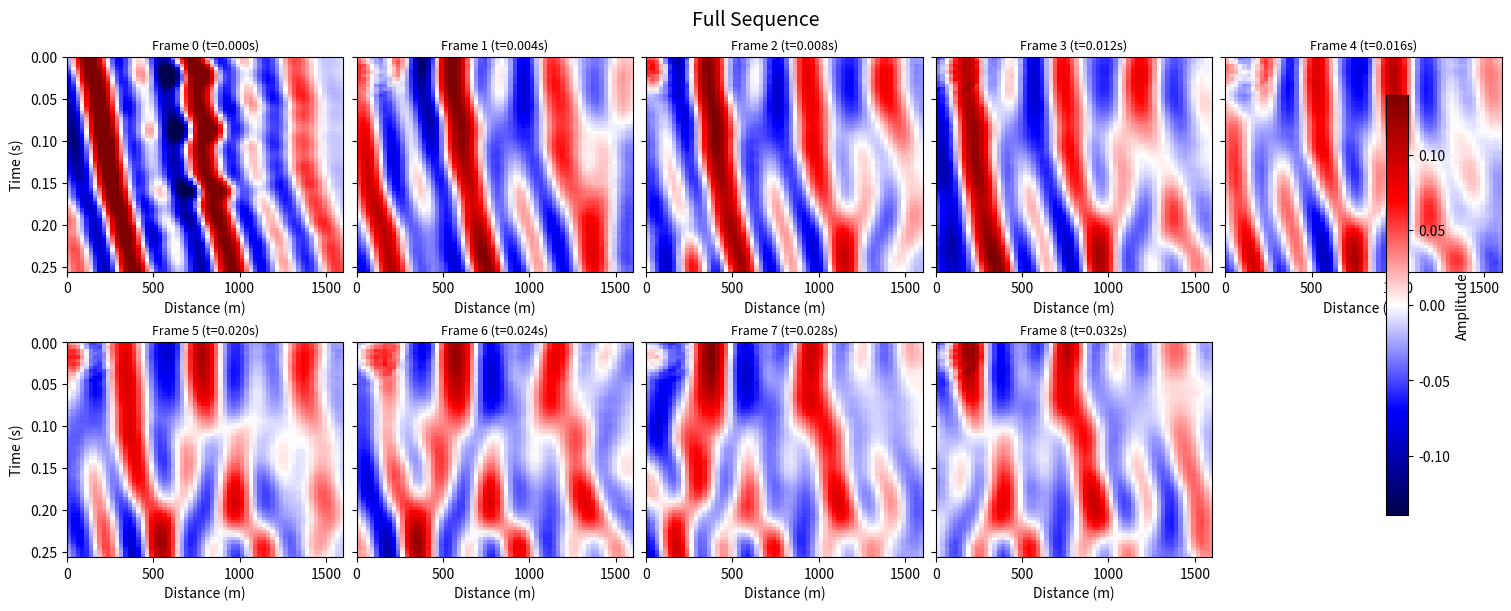

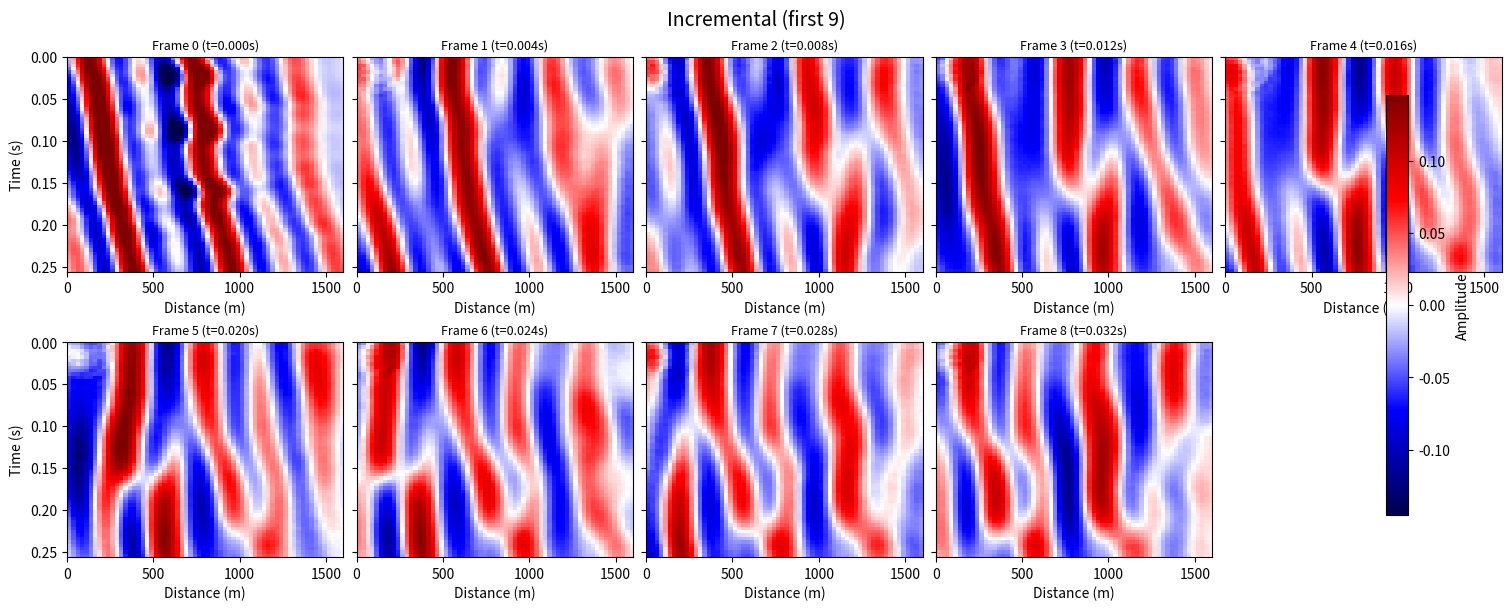

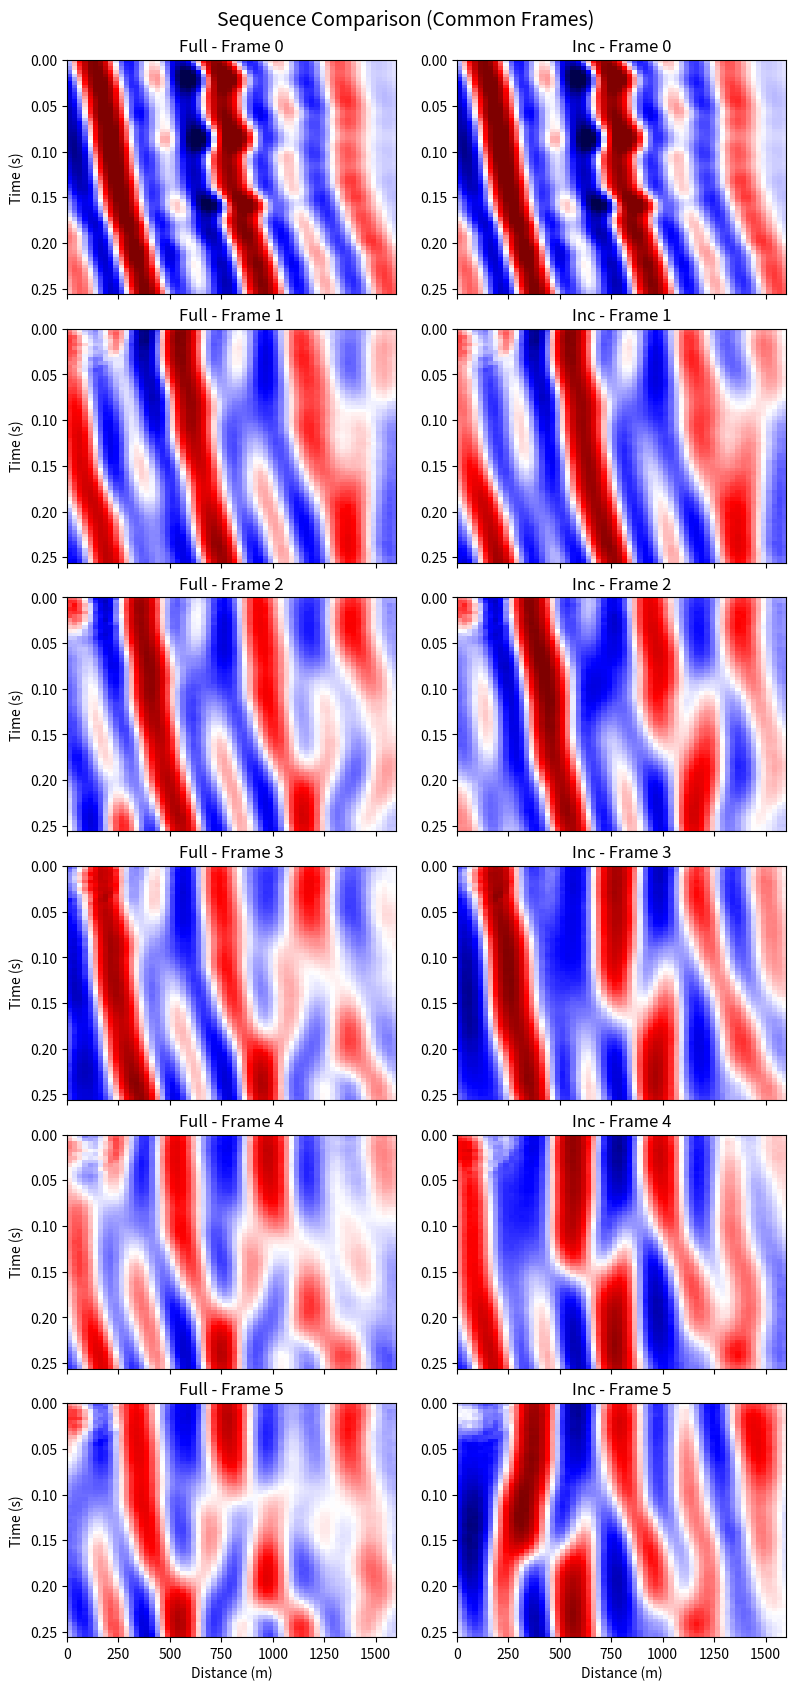

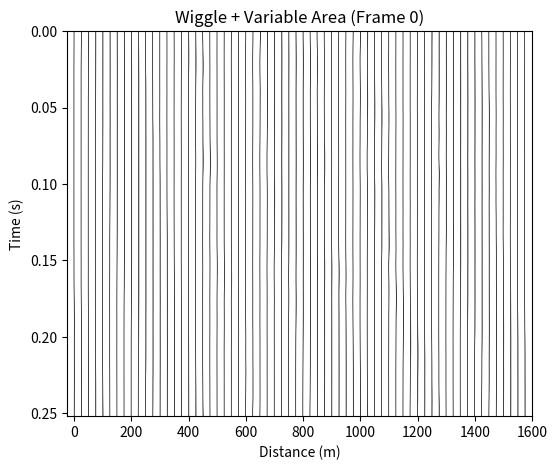

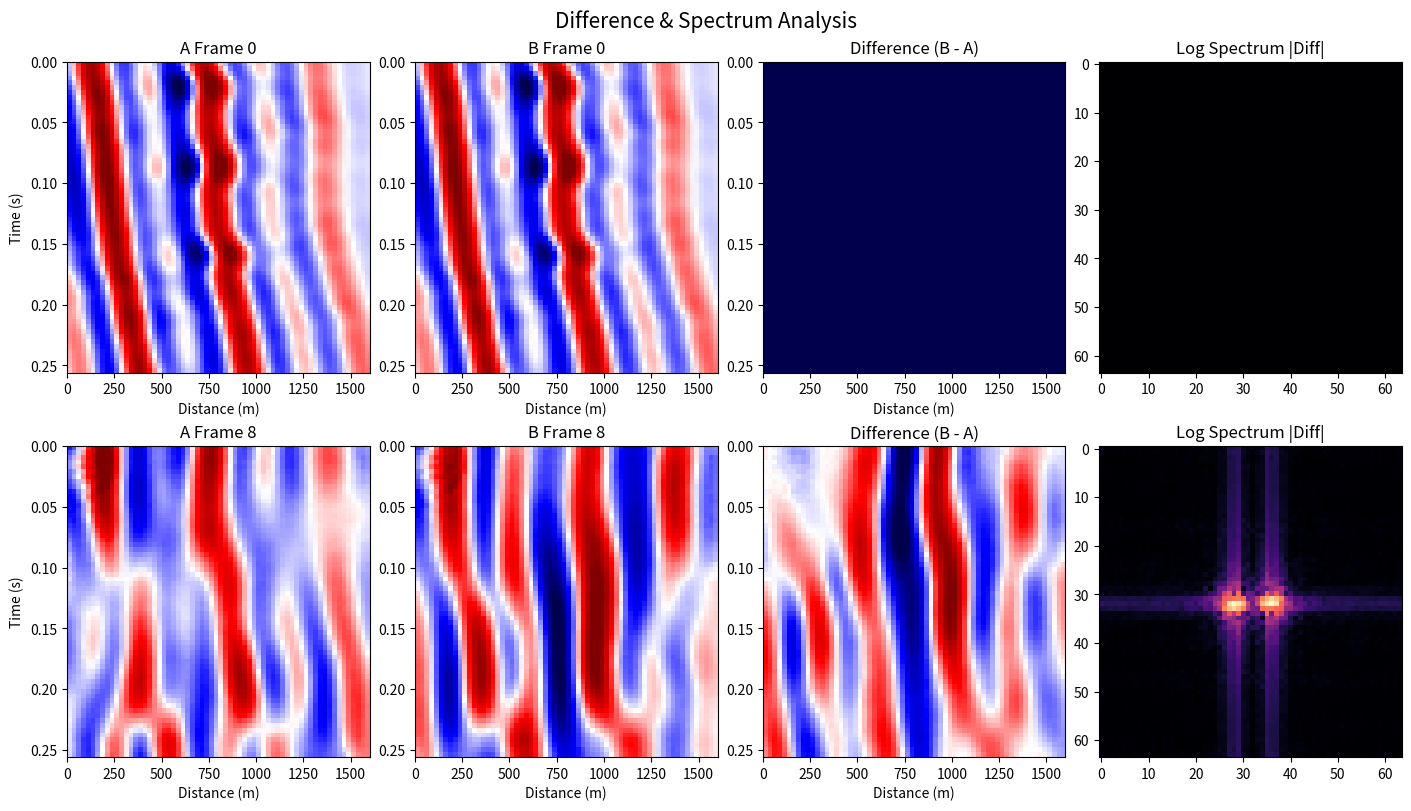

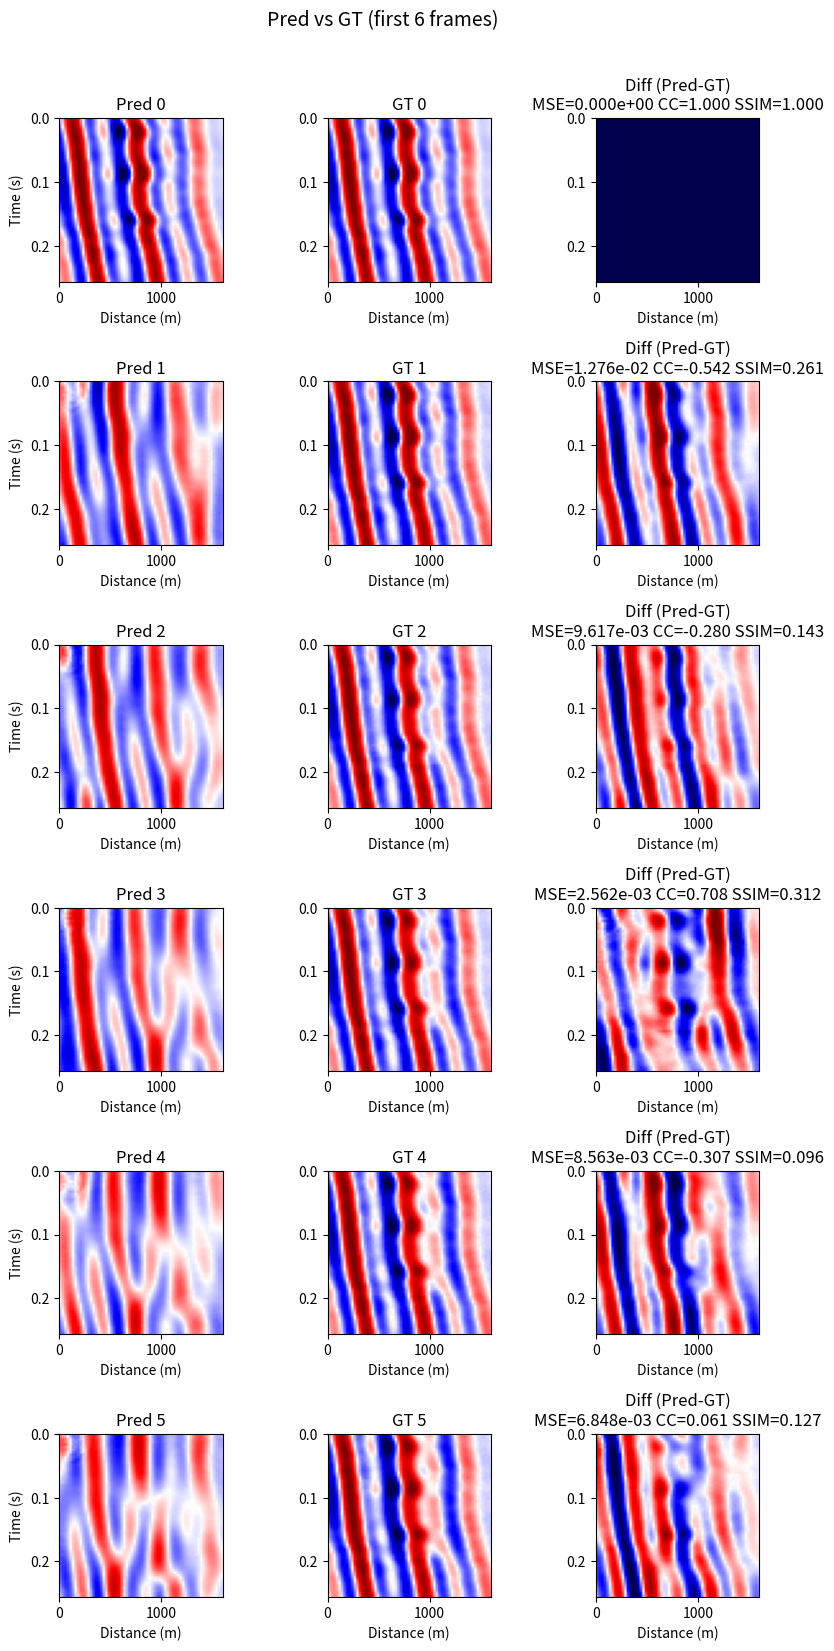

{'full_sequence': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_full_sequence.pdf', 'incremental_first9': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_incremental_first9.pdf', 'sequence_comparison': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_sequence_comparison.pdf', 'wiggle_frame0': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_wiggle_frame0.pdf', 'difference_spectrum': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_difference_spectrum.pdf', 'pred_gt_comparison': '/content/drive/MyDrive/SeismicWorld/Non-AR_multiframe_pred_gt_comparison.pdf'}


In [19]:
figs, paths = demo_all(
    gen_video_full=gen_video_full,
    gen_video_inc=gen_video_inc,
    ground_truth=GT.unsqueeze(1),
    dt=0.004,
    dx=25.0,
    save_dir=f_path,
    prefix="Non-AR_multiframe",
    save_pdf=True,
    show=True,
    close_fig=False,
    gt_square=True,
    box_aspect=1.0
)
print(paths)

# 单帧-多帧 （全帧AR）

In [10]:
# @title SeismicWorld 改进版：统一自回归训练 + 物理一致性损失接口 (v1.1) { form-width: "30%", vertical-output: true }
# ===============================
# 目录:
# 0. 环境与导入
# 1. 工具函数 & 日志
# 2. 物理一致性损失占位 (PhysicsConsistencyLoss)
# 3. 序列构建：VQ-VAE 编码 -> Token 序列
# 4. Transformer 模型 (统一 AR 位置编码)
# 5. 语言模型张量构建 (不再屏蔽第一帧)
# 6. 训练循环 (支持 multiframe / pair / sliding + 物理损失)
# 7. 推理 (三种策略)
# 8. 检查点加载
# ===============================

import os, math, json, shutil, random
from datetime import datetime
from typing import List, Dict, Any, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

# ===============================
# 0. 环境与导入
# ===============================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===============================
# 1. 工具函数 & 日志
# ===============================
def _safe_mkdir(path: str):
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def _load_history(json_path: str) -> List[Dict[str, Any]]:
    if os.path.exists(json_path):
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)
            if isinstance(data, list):
                return data
        except Exception as e:
            print(f"[Warn] 读取历史 JSON 失败({e})，重建: {json_path}")
    return []

def _save_history(json_path: str, history: List[Dict[str, Any]]):
    tmp_path = json_path + ".tmp"
    with open(tmp_path, 'w') as f:
        json.dump(history, f, indent=2, ensure_ascii=False)
    os.replace(tmp_path, json_path)

def _prune_checkpoints(history: List[Dict[str, Any]], keep_last_best: int):
    if keep_last_best <= 0 or len(history) <= keep_last_best:
        return history, []
    to_delete = history[:-keep_last_best]
    remain = history[-keep_last_best:]
    delete_files = [item['checkpoint_path'] for item in to_delete if 'checkpoint_path' in item]
    return remain, delete_files

# ===============================
# 2. 物理一致性损失占位
# ===============================
class PhysicsConsistencyLoss(nn.Module):
    """
    物理一致性/先验损失占位:
    mode:
      - none: 不使用
      - laplacian_smooth: 对每帧(x)计算 Laplacian(x)^2 均值
      - gradient_energy:  对每帧梯度平方和
      - acoustic_forward: 占位 (后续接入声波/弹性波正演 residual)
    参数:
      reduction: 'mean' or 'sum'
      spatial_dims: 2 or 3 (目前假设输入帧为 [B, C, H, W]，若未来 3D 则 [B,C,D,H,W])
    """
    def __init__(
        self,
        mode: str = 'none',
        reduction: str = 'mean',
        spatial_dims: int = 2,
        eps: float = 1e-8
    ):
        super().__init__()
        self.mode = mode.lower()
        self.reduction = reduction
        self.spatial_dims = spatial_dims
        self.eps = eps

    def forward(self, decoded_frames: torch.Tensor) -> torch.Tensor:
        """
        decoded_frames: [B, C, ...] 支持 2D 或未来扩展 3D。
        返回: 标量 loss (tensor)
        """
        if self.mode == 'none':
            return torch.zeros([], device=decoded_frames.device)

        if self.mode == 'laplacian_smooth':
            return self._laplacian_smooth(decoded_frames)

        if self.mode == 'gradient_energy':
            return self._gradient_energy(decoded_frames)

        if self.mode == 'acoustic_forward':
            # 占位：后续可集成物理正演器 (例如声波方程传播)，然后
            # loss = ||模拟数据 - 观测数据||^2 或 ||波动方程残差||^2
            raise NotImplementedError("acoustic_forward 模式尚未实现，请在此接入正演算子。")

        raise ValueError(f"未知物理损失模式: {self.mode}")

    def _laplacian_smooth(self, x: torch.Tensor) -> torch.Tensor:
        """
        对 2D: 简单 5 点离散: lap = -4x + 上下左右
        """
        if self.spatial_dims != 2:
            raise NotImplementedError("当前 laplacian_smooth 仅实现 2D.")
        B,C,H,W = x.shape
        lap = -4 * x
        lap += F.pad(x[:,:,1:,:], (0,0,0,1))  # 上
        lap += F.pad(x[:,:,:-1,:], (0,0,1,0))  # 下
        lap += F.pad(x[:,:,:,1:], (0,1,0,0))  # 左
        lap += F.pad(x[:,:,:,:-1], (1,0,0,0))  # 右
        val = (lap ** 2).mean(dim=(1,2,3))  # 每样本
        return val.mean() if self.reduction == 'mean' else val.sum()

    def _gradient_energy(self, x: torch.Tensor) -> torch.Tensor:
        if self.spatial_dims != 2:
            raise NotImplementedError("gradient_energy 当前仅实现 2D.")
        dx = x[:,:,:,1:] - x[:,:,:,:-1]
        dy = x[:,:,1:,:] - x[:,:,:-1,:]
        val = (dx**2).mean(dim=(1,2,3)) + (dy**2).mean(dim=(1,2,3))
        return val.mean() if self.reduction == 'mean' else val.sum()


# ===============================
# 3. 序列构建：VQ-VAE 编码 -> Token 序列
# ===============================
def encode_video_frames_to_tokens(
    videos_4d: torch.Tensor,   # [N, T, H, W]
    vqvae_model,
    device,
    batch_size_enc: int = 64
) -> Tuple[torch.Tensor, Dict[str, Any]]:
    """
    输出:
      all_tokens: [N, T, Hq, Wq] 量化索引
      meta: {Hq, Wq, num_tokens_per_frame, codebook_size, original_frames}
    """
    assert videos_4d.dim() == 4
    N,T,H,W = videos_4d.shape
    vqvae_model.eval().to(device)
    frames = videos_4d.reshape(N*T, 1, H, W)
    token_list = []
    with torch.no_grad():
        for i in tqdm(range(0, N*T, batch_size_enc), desc="VQ-VAE 编码帧"):
            batch = frames[i:i+batch_size_enc].to(device)
            idx = vqvae_model.encode_to_indices(batch)  # 期望 [B,Hq,Wq] 或 [B,1,Hq,Wq]
            if idx.dim() == 4:
                idx = idx.squeeze(1)
            token_list.append(idx.cpu())
    all_tokens = torch.cat(token_list, dim=0).view(N, T, *token_list[0].shape[-2:])
    Hq, Wq = all_tokens.shape[-2:]
    meta = {
        'Hq': Hq,
        'Wq': Wq,
        'num_tokens_per_frame': Hq*Wq,
        'codebook_size': vqvae_model.codebook_size,
        'original_frames': T
    }
    return all_tokens, meta

def build_samples_by_mode(
    all_tokens: torch.Tensor,          # [N, T, Hq, Wq]
    mode: str = 'multiframe',
    max_frames: Optional[int] = None,
    sliding_window_size: int = 4,
    sliding_window_stride: int = 1
) -> List[torch.Tensor]:
    """
    返回: list[Tensor] 其中每个 Tensor 形状 [Ti, Hq, Wq]
    模式:
      - multiframe: 每个样本=整个视频或截断到 max_frames
      - pair: 相邻帧两两组成 (T-1) 样本
      - sliding: 长度=sliding_window_size 的滑动窗口
    """
    N, T, Hq, Wq = all_tokens.shape
    samples = []
    mode = mode.lower()
    for n in range(N):
        video = all_tokens[n]  # [T,Hq,Wq]
        if max_frames is not None:
            video = video[:max_frames]
        cur_T = video.size(0)
        if mode == 'multiframe':
            samples.append(video)
        elif mode == 'pair':
            for t in range(cur_T - 1):
                samples.append(video[t:t+2])
        elif mode == 'sliding':
            if sliding_window_size > cur_T:
                continue
            for start in range(0, cur_T - sliding_window_size + 1, sliding_window_stride):
                samples.append(video[start:start+sliding_window_size])
        else:
            raise ValueError(f"未知 mode={mode}")
    return samples

# ===============================
# 4. Transformer 模型 (统一 AR 位置编码)
# ===============================
class SeismicWorldAR(nn.Module):
    """
    核心点：
      - 全部帧 token (展平) 线性拼接；自回归。
      - vocab = frame_codebook_size + special(BOS/EOS/PAD)
      - 位置编码: (时间步 + 帧内位置) + 可选全局位置
    """
    def __init__(
        self,
        codebook_size_frame: int,
        num_frame_tokens_per_step: int,
        max_frames: int,
        hidden_size: int = 1024,
        num_hidden_layers: int = 8,
        num_attention_heads: int = 16,
        intermediate_size: int = 4096,
        special_token_count: int = 3,
        use_global_pos_embed: bool = True,
        device: Optional[torch.device] = None
    ):
        super().__init__()
        self.codebook_size_frame = codebook_size_frame
        self.num_frame_tokens_per_step = num_frame_tokens_per_step
        self.max_frames = max_frames
        self.special_token_count = special_token_count

        self.frame_token_offset = 0
        self.special_token_offset = codebook_size_frame
        self.vocab_size = codebook_size_frame + special_token_count

        # 序列最大长度 = BOS + max_frames*K + EOS
        self.max_seq_length = 1 + max_frames * num_frame_tokens_per_step + 1

        # InternLM (假定已在环境中)
        from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM
        config = InternLMConfig(
            vocab_size=self.vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            max_position_embeddings=self.max_seq_length,
            rms_norm_eps=1e-6,
            use_cache=True
        )
        self.model = InternLMForCausalLM(config)

        self.time_pos_embed = nn.Embedding(max_frames + 2, hidden_size)
        self.in_frame_pos_embed = nn.Embedding(num_frame_tokens_per_step, hidden_size)
        self.use_global_pos_embed = use_global_pos_embed
        if use_global_pos_embed:
            self.global_pos_embed = nn.Embedding(self.max_seq_length, hidden_size)

        # Special token 直接使用模型 embedding，不再单独 special_token_embed（简化）
        self.bos_token_id = self.special_token_offset
        self.eos_token_id = self.special_token_offset + 1
        self.pad_token_id = self.special_token_offset + 2

        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        # decode 需要的 latent grid
        self.hq = None
        self.wq = None

    def add_positional_encoding(self, input_ids: torch.Tensor):
        """
        与版本2一致的 AR 逻辑：序列结构
        [BOS][Frame0 tokens ...][Frame1 tokens ...] ... [EOS][PAD...]
        """
        B,L = input_ids.shape
        device = input_ids.device
        tok_embed = self.model.get_input_embeddings()(input_ids)

        if self.use_global_pos_embed:
            pos_ids = torch.arange(L, device=device).unsqueeze(0).expand(B,L)
            global_pos = self.global_pos_embed(pos_ids)
        else:
            global_pos = 0.0

        # 识别帧 token
        is_frame = (input_ids < self.codebook_size_frame)

        # 构建帧序号
        frame_seq = torch.cumsum(is_frame.long(), dim=1) - 1  # 帧 token 索引（全局）
        frame_seq = frame_seq.masked_fill(~is_frame, -1)

        K = self.num_frame_tokens_per_step
        safe = frame_seq.clone()
        safe[safe < 0] = 0
        time_ids = (safe // K) + 1               # 第几帧 (1-based)
        in_frame_ids = safe % K

        time_ids = time_ids.masked_fill(frame_seq < 0, 0)
        in_frame_ids = in_frame_ids.masked_fill(frame_seq < 0, 0)
        time_embed = self.time_pos_embed(time_ids)
        in_frame_embed = self.in_frame_pos_embed(in_frame_ids)
        frame_pos = time_embed + in_frame_embed
        frame_pos = frame_pos.masked_fill((~is_frame).unsqueeze(-1), 0.0)

        return tok_embed + global_pos + frame_pos

    def forward(self, input_ids, labels=None, attention_mask=None, return_dict=True):
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()
        inputs_embeds = self.add_positional_encoding(input_ids)
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            use_cache=False,
            return_dict=return_dict
        )
        return outputs

    ### 补丁 1: 修改 SeismicWorldAR.sample_step (可选增强)
    # 如果你想在 sample_step 内统一支持“限制只采 frame tokens”：
    def sample_step(self, logits, temperature=1.0, top_k=None, top_p=None, greedy=False, generator=None,
                    banned_token_ids: Optional[List[int]] = None,
                    restrict_to_frame_tokens: bool = False):
        logits = logits.clone()

        # 限制只允许 frame token
        if restrict_to_frame_tokens:
            # 将 frame_token 区间以外全部置极小
            logits[:, self.codebook_size_frame:] = -1e9

        if banned_token_ids:
            for tid in banned_token_ids:
                logits[:, tid] = -1e9

        if temperature != 1.0:
            logits /= max(temperature, 1e-8)

        if top_k is not None and top_k > 0:
            vk, _ = torch.topk(logits, top_k)
            cutoff = vk[:, -1].unsqueeze(-1)
            logits = logits.masked_fill(logits < cutoff, -1e9)

        if top_p is not None and 0 < top_p < 1.0:
            probs = torch.softmax(logits, dim=-1)
            sorted_probs, sorted_idx = torch.sort(probs, descending=True, dim=-1)
            cum = sorted_probs.cumsum(dim=-1)
            mask = cum > top_p
            mask[:, 0] = False
            sorted_probs = sorted_probs.masked_fill(mask, 0.0)
            probs = torch.zeros_like(probs).scatter(-1, sorted_idx, sorted_probs)
        else:
            probs = torch.softmax(logits, dim=-1)

        if greedy:
            next_tok = probs.argmax(dim=-1, keepdim=True)
        else:
            next_tok = torch.multinomial(probs, 1, generator=generator)
        return next_tok


    ### 补丁 2: 修改 SeismicWorldAR.generate_frames
    # 关键：在帧内 token 生成时强制 restrict_to_frame_tokens=True，并屏蔽 BOS/EOS/PAD
    @torch.no_grad()
    def generate_frames(
        self,
        first_frame_tokens: torch.Tensor,   # [B,K]
        num_future_frames: int,
        temperature: float = 1.0,
        top_k: Optional[int] = 64,
        top_p: Optional[float] = 0.95,
        greedy: bool = False,
        generator=None
    ):
        self.eval()
        B,K = first_frame_tokens.shape
        bos = torch.full((B,1), self.bos_token_id, dtype=torch.long, device=first_frame_tokens.device)
        # 注意：frame token 原始范围 0..codebook_size_frame-1
        seq = torch.cat([bos, first_frame_tokens + self.frame_token_offset], dim=1)

        total_frames = 1 + num_future_frames
        for f in range(1, total_frames):
            for kpos in range(K):
                out = self.forward(seq)
                logits = out.logits[:, -1, :]  # [B, vocab]
                nxt = self.sample_step(
                    logits,
                    temperature=temperature,
                    top_k=top_k,
                    top_p=top_p,
                    greedy=greedy,
                    generator=generator,
                    # 禁止特殊 token
                    banned_token_ids=[self.pad_token_id, self.bos_token_id, self.eos_token_id],
                    restrict_to_frame_tokens=True
                )
                seq = torch.cat([seq, nxt], dim=1)

        # 全部帧 token 生成完毕后再追加 EOS
        eos = torch.full((B,1), self.eos_token_id, dtype=torch.long, device=seq.device)
        seq = torch.cat([seq, eos], dim=1)
        return seq


    @torch.no_grad()
    def decode_frames_indices(self, frames_tokens_2d: torch.Tensor, vqvae_model):
        """
        frames_tokens_2d: [T, K]  帧 token (含 frame_token_offset)
        """
        if self.hq is None or self.wq is None:
            raise ValueError("未设置 hq/wq")
        K = self.num_frame_tokens_per_step
        assert self.hq * self.wq == K
        frames_list = []
        for t in range(frames_tokens_2d.size(0)):
            flat = frames_tokens_2d[t] - self.frame_token_offset
            idx2d = flat.view(1,1,self.hq,self.wq)
            rec = vqvae_model.decode_from_indices(idx2d.to(next(self.parameters()).device))
            if rec.dim() == 5:
                rec = rec.squeeze(2)
            frames_list.append(rec.cpu())
        return torch.cat(frames_list, dim=0)

# ===============================
# 5. 构建 AR 训练张量 (统一，无屏蔽)
# ===============================
def build_language_model_tensors_ar(
    sample_frames_tokens: List[torch.Tensor],  # 每个元素 [Ti, Hq, Wq] (纯索引)
    model: SeismicWorldAR
):
    """
    把每个样本 -> [BOS, frame_flat..., EOS] 并做右移:
      input_ids = seq[:-1], labels = seq[1:]
    Padding 统一到 model.max_seq_length - 1 (因为训练 next-token)。
    """
    K = model.num_frame_tokens_per_step
    max_len_full = model.max_seq_length

    inputs_all, labels_all, attn_all = [], [], []
    for frames in sample_frames_tokens:
        Ti = frames.shape[0]
        if Ti > model.max_frames:
            raise ValueError(f"样本帧数 {Ti} > 模型 max_frames {model.max_frames}")
        # flatten
        flat_tokens = frames.view(Ti, K)  # [Ti,K]
        flat_all = flat_tokens.reshape(-1)  # Ti*K

        bos = torch.tensor([model.bos_token_id], dtype=torch.long)
        eos = torch.tensor([model.eos_token_id], dtype=torch.long)

        seq = torch.cat([bos, flat_all + model.frame_token_offset, eos], dim=0)  # len = 1 + Ti*K + 1
        if seq.size(0) > max_len_full:
            raise ValueError(f"序列长度 {seq.size(0)} 超过上限 {max_len_full}")

        # shift
        input_ids = seq[:-1].clone()
        labels = seq[1:].clone()

        target_len = max_len_full - 1
        cur_len = input_ids.size(0)
        if cur_len < target_len:
            pad_len = target_len - cur_len
            pad_tok = torch.full((pad_len,), model.pad_token_id, dtype=torch.long)
            input_ids = torch.cat([input_ids, pad_tok], dim=0)

            label_pad = torch.full((pad_len,), -100, dtype=torch.long)
            labels = torch.cat([labels, label_pad], dim=0)
        elif cur_len > target_len:
            raise ValueError("内部长度不匹配")

        attn = (input_ids != model.pad_token_id).long()
        inputs_all.append(input_ids.unsqueeze(0))
        labels_all.append(labels.unsqueeze(0))
        attn_all.append(attn.unsqueeze(0))

    input_ids_all = torch.cat(inputs_all, dim=0)
    labels_all = torch.cat(labels_all, dim=0)
    attn_all = torch.cat(attn_all, dim=0)
    return input_ids_all, labels_all, attn_all

# ===============================
# 6. 训练 (集成物理损失)
# ===============================
def train_seismic_world_ar(
    videos_4d: torch.Tensor,      # [N,T,H,W]
    vqvae_model,
    device: torch.device,
    train_mode: str = 'multiframe',       # multiframe / pair / sliding
    max_frames: Optional[int] = None,
    sliding_window_size: int = 4,
    sliding_window_stride: int = 1,

    # Transformer
    hidden_size: int = 1024,
    num_layers: int = 8,
    num_heads: int = 16,
    inter_size: int = 4096,

    # 优化
    epochs: int = 40,
    batch_size: int = 8,
    lr: float = 5e-5,
    weight_decay: float = 0.01,
    grad_clip: float = 1.0,
    val_split: float = 0.05,
    patience: int = 5,
    min_delta: float = 0.0,

    # 物理损失
    physics_mode: str = 'none',
    physics_loss_weight: float = 0.1,
    physics_every_n_steps: int = 10,
    physics_frame_sample_ratio: float = 0.5,   # 对 batch 中部分样本做物理损失
    decode_for_physics: bool = True,           # 是否解码 token -> 连续场用于物理损失
    max_physics_frames: int = 2,               # 每个样本选取前 n 帧 (防止过慢)

    # Checkpoint
    save_best_path: str = "seismic_world_ar_best.pth",
    resume_from: Optional[str] = None,
    keep_last_best: int = 5,
    history_json_path: Optional[str] = None,
    create_latest_pointer: bool = True,

    # 其他
    seed: Optional[int] = None,
    verbose: bool = True
):
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)

    videos_4d = videos_4d.to(torch.float32)
    N,T,H,W = videos_4d.shape
    if verbose:
        print(f"[Info] 输入视频 shape={videos_4d.shape}, train_mode={train_mode}")

    # 1) 编码成 token
    all_tokens, meta = encode_video_frames_to_tokens(videos_4d, vqvae_model, device)
    K = meta['num_tokens_per_frame']
    codebook_size = meta['codebook_size']

    # 2) 按模式构建样本
    samples = build_samples_by_mode(
        all_tokens,
        mode=train_mode,
        max_frames=max_frames,
        sliding_window_size=sliding_window_size,
        sliding_window_stride=sliding_window_stride
    )
    if len(samples) == 0:
        raise ValueError("没有生成任何训练样本，检查模式或参数。")
    if verbose:
        print(f"[Info] 样本数={len(samples)} (mode={train_mode}) 每帧 token 数 K={K}")

    # 3) 确定模型 max_frames
    if train_mode == 'multiframe':
        max_frames_model = samples[0].shape[0]  # 截断后的视频帧数
    elif train_mode == 'pair':
        max_frames_model = 2
    else: # sliding
        max_frames_model = sliding_window_size

    # 4) 初始化模型
    model = SeismicWorldAR(
        codebook_size_frame=codebook_size,
        num_frame_tokens_per_step=K,
        max_frames=max_frames_model,
        hidden_size=hidden_size,
        num_hidden_layers=num_layers,
        num_attention_heads=num_heads,
        intermediate_size=inter_size,
        device=device
    )
    model.hq = meta['Hq']
    model.wq = meta['Wq']

    # 5) 构建 LM tensors
    lm_frames_tokens = [s.clone() for s in samples]
    input_ids_all, labels_all, attn_all = build_language_model_tensors_ar(lm_frames_tokens, model)
    total_samples = input_ids_all.size(0)
    if verbose:
        print(f"[Info] LM tensors: input={input_ids_all.shape}, labels={labels_all.shape}")

    # 划分训练验证
    val_size = max(1, int(total_samples * val_split))
    train_size = total_samples - val_size
    perm = torch.randperm(total_samples)
    train_idx, val_idx = perm[:train_size], perm[train_size:]
    train_ds = TensorDataset(input_ids_all[train_idx], attn_all[train_idx], labels_all[train_idx])
    val_ds   = TensorDataset(input_ids_all[val_idx], attn_all[val_idx], labels_all[val_idx])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    if verbose:
        print(f"[Info] train={train_size}, val={val_size}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 6) 物理损失模块
    physics_loss_module = PhysicsConsistencyLoss(mode=physics_mode).to(device)
    if physics_mode != 'none':
        print(f"[Info] 启用物理一致性损失 mode={physics_mode}, weight={physics_loss_weight}")

    # 7) Checkpoint 配置
    save_dir = os.path.dirname(save_best_path) if os.path.dirname(save_best_path) else "."
    _safe_mkdir(save_dir)
    base_name = os.path.splitext(os.path.basename(save_best_path))[0]
    if history_json_path is None:
        history_json_path = os.path.join(save_dir, f"{base_name}_history.json")
    history = _load_history(history_json_path)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    start_epoch = 0

    if resume_from and os.path.exists(resume_from):
        try:
            ckpt = torch.load(resume_from, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            start_epoch = ckpt.get('epoch', 0)
            best_val_loss = ckpt.get('best_loss', best_val_loss)
            print(f"[Resume] {resume_from}: epoch={start_epoch}, best_val_loss={best_val_loss:.4f}")
        except Exception as e:
            print(f"[Warn] resume 失败: {e}")

    # 8) 训练循环
    global_step = 0
    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss_sum = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            inp, attn, lab = [x.to(device) for x in batch]
            optimizer.zero_grad()
            out = model(inp, labels=lab, attention_mask=attn, return_dict=True)
            ce_loss = out.loss

            # 物理损失 (按频率 & 抽样)
            phys_loss = torch.zeros_like(ce_loss)
            use_physics = (physics_mode != 'none') and (global_step % physics_every_n_steps == 0)
            if use_physics and decode_for_physics:
                # 从 batch 中抽样部分样本
                B = inp.size(0)
                choose_num = max(1, int(B * physics_frame_sample_ratio))
                select_idx = torch.randperm(B)[:choose_num]

                with torch.no_grad():
                    # 取这些样本的非 PAD token (不含最后 padding)，解析出帧 token
                    # 方法：还原出 (Ti,K) 的每帧 token 索引 (Plain)
                    # 注意: input_ids = [BOS frame_tokens...], 我们只需要已出现的帧 token
                    # 通过统计前 (1 + Ti*K) 长度；简化：直接解析所有 frame token 并限制 max_physics_frames
                    pass

                decoded_collect = []
                for si in select_idx:
                    seq_ids = inp[si]  # [L]
                    # 排除 PAD
                    real_mask = (seq_ids != model.pad_token_id)
                    real_ids = seq_ids[real_mask]

                    # 去掉 BOS (开头) 和可能结尾的 EOS（训练 input_ids 不含最终 EOS，因为 shift 后截掉？这里 input_ids 是 seq[:-1]，末尾不含真正 EOS；因此 real_ids[0]=BOS）
                    if real_ids[0] == model.bos_token_id:
                        real_ids = real_ids[1:]

                    # 截取最多 max_frames_model*K
                    max_token_for_frames = model.max_frames * model.num_frame_tokens_per_step
                    frame_tokens_all = real_ids[:max_token_for_frames]

                    # 切分成帧
                    num_full_tokens = (frame_tokens_all.size(0) // K) * K
                    frame_tokens_all = frame_tokens_all[:num_full_tokens]
                    Ti = frame_tokens_all.size(0) // K
                    Ti = min(Ti, max_physics_frames)
                    if Ti <= 0:
                        continue
                    frame_tokens_plain = (frame_tokens_all.view(Ti, K) - model.frame_token_offset).clamp(min=0)
                    # 解码
                    idx_2d = frame_tokens_plain.view(Ti, 1, model.hq, model.wq)
                    rec = vqvae_model.decode_from_indices(idx_2d.to(device))
                    if rec.dim() == 5:
                        rec = rec.squeeze(2)
                    decoded_collect.append(rec)  # [Ti,1,H,W]

                if len(decoded_collect) > 0:
                    decoded_batch = torch.cat(decoded_collect, dim=0)  # [M,1,H,W]
                    phys_loss = physics_loss_module(decoded_batch)
                    if torch.isfinite(phys_loss):
                        phys_loss = phys_loss * physics_loss_weight
                    else:
                        phys_loss = torch.zeros_like(ce_loss)

            total_loss = ce_loss + phys_loss
            total_loss.backward()
            if grad_clip is not None and grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_loss_sum += total_loss.item()
            global_step += 1

        avg_train_loss = train_loss_sum / len(train_loader)

        # 验证
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                inp, attn, lab = [x.to(device) for x in batch]
                out = model(inp, labels=lab, attention_mask=attn, return_dict=True)
                if out.loss is not None:
                    val_loss_sum += out.loss.item()
        avg_val_loss = val_loss_sum / max(1, len(val_loader))
        improved = avg_val_loss < (best_val_loss - min_delta)

        print(f"[Epoch {epoch+1}] train_total={avg_train_loss:.4f}, val_ce={avg_val_loss:.4f}, "
              f"prev_best={best_val_loss:.4f}, improved={improved}")

        if improved:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            ckpt_name = f"{base_name}_best_epoch{epoch+1}_val{avg_val_loss:.4f}_{timestamp}.pth"
            ckpt_path = os.path.join(save_dir, ckpt_name)
            payload = {
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_val_loss,
                'config': {
                    'train_mode': train_mode,
                    'K': K,
                    'max_frames': model.max_frames,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'num_heads': num_heads,
                    'inter_size': inter_size,
                    'hq': model.hq,
                    'wq': model.wq,
                    'physics_mode': physics_mode,
                    'physics_loss_weight': physics_loss_weight
                }
            }
            torch.save(payload, ckpt_path)
            torch.save(payload, save_best_path)
            record = {
                'epoch': epoch+1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_loss_after_save': best_val_loss,
                'checkpoint_path': ckpt_path,
                'timestamp': timestamp
            }
            history.append(record)
            history.sort(key=lambda x: x['epoch'])
            if keep_last_best > 0:
                history, to_delete = _prune_checkpoints(history, keep_last_best)
                for fdel in to_delete:
                    if os.path.exists(fdel):
                        try: os.remove(fdel)
                        except Exception as e: print(f"[Warn] 删除失败 {fdel}: {e}")
            _save_history(history_json_path, history)
            if create_latest_pointer:
                with open(os.path.join(save_dir, f"{base_name}_latest_best.txt"), 'w') as f:
                    f.write(ckpt_path + "\n")
            print(f"  ✅ 新最佳: {ckpt_path}")
        else:
            epochs_no_improve += 1
            if patience > 0 and epochs_no_improve >= patience:
                print("  ⏹️ 早停触发")
                break

    print(f"[Training Finished] best_val_loss={best_val_loss:.4f}")
    if os.path.exists(save_best_path):
        ckpt = torch.load(save_best_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        print("[Info] 载入最终最佳权重")

    summary = {
        'best_val_loss': best_val_loss,
        'history_file': history_json_path,
        'num_tokens_per_frame': K,
        'train_mode': train_mode,
        'kept_checkpoints': [h['checkpoint_path'] for h in history]
    }
    return model, summary

# ===============================
# 7. 推理函数 (三种策略)
# ===============================
@torch.no_grad()
def autoregressive_generate_sequence(
    model: SeismicWorldAR,
    vqvae_model,
    first_frame: torch.Tensor,       # [H,W] or [1,H,W] or [1,1,H,W]
    device: torch.device,
    total_frames: int,
    strategy: str = 'multiframe_full',
    temperature: float = 1.0,
    top_k: Optional[int] = 64,
    top_p: Optional[float] = 0.95,
    greedy: bool = False,
    seed: Optional[int] = None,
    return_tokens: bool = False,
    verbose: bool = False
):
    assert total_frames >= 1
    if seed is not None:
        gens = torch.Generator(device=device).manual_seed(seed)
    else:
        gens = None
    model.eval()
    vqvae_model.eval()

    # 归一化 first_frame shape
    if first_frame.dim() == 2:
        first_frame_tensor = first_frame.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    elif first_frame.dim() == 3:
        if first_frame.size(0) != 1:
            raise ValueError("期望单通道")
        first_frame_tensor = first_frame.unsqueeze(0)
    elif first_frame.dim() == 4:
        if first_frame.size(0) != 1:
            raise ValueError("batch 只能=1")
        first_frame_tensor = first_frame
    else:
        raise ValueError("不支持 first_frame shape")
    first_frame_tensor = first_frame_tensor.to(device)

    frame_tokens_2d = vqvae_model.encode_to_indices(first_frame_tensor)
    if frame_tokens_2d.dim() == 4:
        frame_tokens_2d = frame_tokens_2d.squeeze(1)
    B,Hq,Wq = frame_tokens_2d.shape
    assert B == 1
    K = Hq * Wq
    flat_first = frame_tokens_2d.view(1,K)

    if model.hq is None or model.wq is None:
        model.hq, model.wq = Hq, Wq

    decoded_frames = [first_frame_tensor.detach().cpu()]
    token_frames = [flat_first[0] + model.frame_token_offset]

    if total_frames == 1:
        return (torch.cat(decoded_frames, dim=0), token_frames) if return_tokens else torch.cat(decoded_frames, dim=0)

    strategy = strategy.lower()
    if strategy not in ('multiframe_full','incremental','pair_rollout'):
        raise ValueError(f"未知 strategy={strategy}")

    if strategy == 'pair_rollout' and model.max_frames != 2:
        raise ValueError("pair_rollout 需要模型 max_frames=2")

    if strategy == 'multiframe_full':
        num_future = total_frames - 1
        gen_seq = model.generate_frames(
            first_frame_tokens=flat_first,
            num_future_frames=num_future,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            greedy=greedy,
            generator=gens
        )
        seq_body = gen_seq[0,1:]
        eos_pos = (seq_body == model.eos_token_id).nonzero(as_tuple=False)
        if eos_pos.numel() > 0:
            seq_body = seq_body[:eos_pos[0,0]]
        needed = (1+num_future)*K
        if seq_body.numel() < needed:
            raise RuntimeError("生成 token 不足")
        all_ft = seq_body[:needed].view(1+num_future, K)
        for i in range(1,1+num_future):
            ft_offset = all_ft[i]
            token_frames.append(ft_offset.clone())
            plain = ft_offset - model.frame_token_offset
            idx2d = plain.view(1,1,Hq,Wq)
            rec = vqvae_model.decode_from_indices(idx2d.to(device))
            if rec.dim()==5: rec=rec.squeeze(2)
            decoded_frames.append(rec.cpu())
            if verbose:
                print(f"[multiframe_full] 生成帧 {i}/{num_future}")

    else:
        # incremental / pair_rollout
        current_frame_tensor = first_frame_tensor
        for step in range(1, total_frames):
            cur_tokens_2d = vqvae_model.encode_to_indices(current_frame_tensor)
            if cur_tokens_2d.dim()==4:
                cur_tokens_2d = cur_tokens_2d.squeeze(1)
            cur_flat = cur_tokens_2d.view(1,K)
            gen_seq = model.generate_frames(
                first_frame_tokens=cur_flat,
                num_future_frames=1,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                greedy=greedy,
                generator=gens
            )
            seq_body = gen_seq[0,1:]
            eos_pos = (seq_body == model.eos_token_id).nonzero(as_tuple=False)
            if eos_pos.numel() > 0:
                seq_body = seq_body[:eos_pos[0,0]]
            if seq_body.numel() != 2*K:
                print("[Debug] Unexpected seq_body length:", seq_body.numel(), "expected:", 2*K)
                # 可在此直接回退 greedy=True 或 temperature 降低再试一次
                raise RuntimeError(f"{strategy}: 生成长度异常")
            print("DEBUG: seq_body_len=", seq_body.numel(), "K=", K, "first20=", seq_body[:20].tolist())

            if seq_body.numel() < 2*K:
                raise RuntimeError(f"{strategy}: token 不足")
            next_with_offset = seq_body[K:2*K]
            token_frames.append(next_with_offset.clone())
            plain = next_with_offset - model.frame_token_offset
            idx2d = plain.view(1,1,Hq,Wq)
            rec = vqvae_model.decode_from_indices(idx2d.to(device))
            if rec.dim()==5: rec=rec.squeeze(2)
            decoded_frames.append(rec.cpu())
            current_frame_tensor = rec
            if verbose:
                print(f"[{strategy}] 生成第 {step} 帧")

    frames_tensor = torch.cat(decoded_frames, dim=0)
    return (frames_tensor, token_frames) if return_tokens else frames_tensor

# ===============================
# 8. 加载模型
# ===============================
def load_seismic_world_ar_model(
    checkpoint_path: str,
    vqvae_model,
    device: torch.device,
    probe_frame: Optional[torch.Tensor] = None,
    verbose: bool = True
):
    payload = torch.load(checkpoint_path, map_location=device)
    cfg = payload['config']
    K = cfg['K']
    model = SeismicWorldAR(
        codebook_size_frame=vqvae_model.codebook_size,
        num_frame_tokens_per_step=K,
        max_frames=cfg['max_frames'],
        hidden_size=cfg['hidden_size'],
        num_hidden_layers=cfg['num_layers'],
        num_attention_heads=cfg['num_heads'],
        intermediate_size=cfg['inter_size'],
        device=device
    )
    hq, wq = cfg.get('hq'), cfg.get('wq')
    if hq is None or wq is None:
        if probe_frame is None:
            raise ValueError("缺少 (hq,wq) 并且未提供 probe_frame")
        pf = probe_frame
        if pf.dim()==2:
            pf = pf.unsqueeze(0).unsqueeze(0)
        elif pf.dim()==3:
            pf = pf.unsqueeze(0)
        with torch.no_grad():
            inds = vqvae_model.encode_to_indices(pf.to(device))
            if inds.dim()==4:
                inds = inds.squeeze(1)
            hq, wq = inds.shape[-2:]
    model.hq, model.wq = hq, wq
    model.load_state_dict(payload['model_state_dict'])
    model.eval()
    if verbose:
        print(f"[Loaded] epoch={payload.get('epoch')} best_loss={payload.get('best_loss')}")
        print(f"  max_frames={cfg['max_frames']} latent=({hq},{wq}) K={K}")
    return model, payload



In [11]:
# @title 统一训练 / 推理：pair | sliding | multiframe + 多指标评估 (MSE/PSNR/SSIM/LPIPS) { form-width: "38%", vertical-output: true }

# ========= 可选模式说明 =========
# mode_select:
#   'pair'        : 相邻两帧监督，适合短步滚动外推
#   'sliding'     : 长序列滑动窗口 (window_size >= 2)，更关注局部 Markov 上下文
#   'multiframe'  : 一次性建模整段 (max_frames 固定)，适合定长块整体生成
#
# 推理策略建议：
#   pair        -> pair_rollout / incremental
#   sliding     -> incremental  (或自定义 sliding_rollout 若已实现)
#   multiframe  -> multiframe_full + incremental

# ========= 基本参数 =========
mode_select = 'pair'          # @param ["pair", "sliding", "multiframe"]
seed = 123                    # @param {type:"integer"}
TRAIN_MODE = False            # @param {type:"boolean"}
INFER_MODE = True             # @param {type:"boolean"}

# ========= 通用训练超参 =========
epochs = 60                   # @param {type:"integer"}
batch_size = 30               # @param {type:"integer"}
learning_rate = 1e-4          # @param {type:"number"}
val_split = 0.05              # @param {type:"number"}
patience = 5                  # @param {type:"integer"}
min_delta = 0.0               # @param {type:"number"}

# ========= Transformer 结构 =========
hidden_size = 768             # @param {type:"integer"}
num_layers = 6                # @param {type:"integer"}
num_heads = 12                # @param {type:"integer"}
inter_size = 3072             # @param {type:"integer"}

# ========= 物理一致性 (可选) =========
physics_mode = 'none'         # @param ["none", "laplacian_smooth", "gradient_energy"]
physics_loss_weight = 0.05    # @param {type:"number"}
physics_every_n_steps = 10    # @param {type:"integer"}
physics_frame_sample_ratio = 0.5  # @param {type:"number"}
decode_for_physics = True
max_physics_frames = 2

# ========= 模式特定参数 =========
# pair: 不需要额外参数
# sliding:
sliding_window_size = 5       # @param {type:"integer"}
sliding_window_stride = 1     # @param {type:"integer"}
# multiframe:
multiframe_max_frames = 9     # @param {type:"integer"}

# ========= 推理参数 =========
# 统一：想生成的总帧数（>= 初始第一帧）
rollout_total_frames = 15     # @param {type:"integer"}
temperature = 0.8             # @param {type:"number"}
top_k = 50                    # @param {type:"integer"}
top_p = 0.95                  # @param {type:"number"}
greedy = False                # 仅 multiframe_full 时可设 True 获得确定结果

# multiframe 专属完整块生成（只在 multiframe 时启用）
use_multiframe_full_at_test = True
multiframe_full_frames = 9    # 与训练的 multiframe_max_frames 一致

# ========= 评估设置 =========
enable_metrics = True
compute_lpips = True          # 若安装失败自动降级
lpips_net = 'vgg'             # 传给 LPIPS 的后端，可 'alex' / 'vgg' / 'squeeze'
limit_eval_frames = None      # 可设整数限制评估前多少帧；None 则使用可比最短长度
ssim_window = 11              # 用于简易 SSIM (必须为奇数)
eps = 1e-8

# ========= 导入与随机种子 =========
import os, math, random, torch
import torch.nn.functional as F
if seed is not None:
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ========= 路径设定 =========
os.makedirs(checkpoint_dir, exist_ok=True)
if mode_select == 'pair':
    ckpt_tag = 'pair'
elif mode_select == 'sliding':
    ckpt_tag = f'sliding_w{sliding_window_size}'
else:
    ckpt_tag = f'multiframe_{multiframe_max_frames}f'

best_ckpt_path = os.path.join(checkpoint_dir, f"seismic_world_ar_{ckpt_tag}_best.pth")
history_json_path = os.path.join(checkpoint_dir, f"seismic_world_ar_{ckpt_tag}_history.json")

# ========= 简易 SSIM (灰度) =========
def ssim_torch(x, y, window_size=11, C1=0.01**2, C2=0.03**2):
    # x,y: [B,1,H,W] 归一化到 [0,1] 近似
    # 若 H,W < window_size 则退化为 MSE 转换
    if min(x.shape[-2:]) < window_size:
        mse = F.mse_loss(x, y)
        return 1.0 - mse.item()
    # 构造 2D 高斯核
    import math
    gauss_1d = torch.Tensor([
        math.exp(-(i - window_size//2)**2 / (2.0 * (window_size/6.0)**2))
        for i in range(window_size)
    ])
    gauss_1d /= gauss_1d.sum()
    kernel = torch.outer(gauss_1d, gauss_1d)
    kernel = kernel / kernel.sum()
    kernel = kernel.to(x.device).unsqueeze(0).unsqueeze(0)

    def filt(z):
        return torch.conv2d(z, kernel, padding=window_size//2, groups=1)

    mu_x = filt(x)
    mu_y = filt(y)
    sigma_x = filt(x * x) - mu_x * mu_x
    sigma_y = filt(y * y) - mu_y * mu_y
    sigma_xy = filt(x * y) - mu_x * mu_y

    ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2) + 1e-12)
    return ssim_map.mean().item()

# ========= 可选 LPIPS =========
!pip install lpips
lpips_model = None
if enable_metrics and compute_lpips:
    try:
        import lpips
        lpips_model = lpips.LPIPS(net=lpips_net).to(DEVICE)
        lpips_model.eval()
    except Exception as e:
        print(f"[Warn] LPIPS 未启用: {e}")
        lpips_model = None

# ========= 训练 =========
if TRAIN_MODE:
    assert seismic_data_video.ndim == 4, f"数据维度应为 [N,T,H,W]，得到 {seismic_data_video.shape}"
    total_frames_data = seismic_data_video.shape[1]
    if mode_select == 'pair':
        assert total_frames_data >= 2, "pair 模式至少需要 2 帧"
        train_mode = 'pair'
        max_frames_arg = None
    elif mode_select == 'sliding':
        assert total_frames_data >= sliding_window_size, "sliding 窗口大于数据长度"
        train_mode = 'sliding'
        max_frames_arg = None
    else:  # multiframe
        assert total_frames_data >= multiframe_max_frames, "multiframe_max_frames 大于数据T"
        train_mode = 'multiframe'
        max_frames_arg = multiframe_max_frames

    print(f"== 开始训练: mode={mode_select} ==")
    model_ar, train_summary = train_seismic_world_ar(
        videos_4d = seismic_data_video,
        vqvae_model = trained_vqvae,
        device = DEVICE,
        train_mode = train_mode,
        max_frames = max_frames_arg,

        # sliding 相关
        sliding_window_size = sliding_window_size if mode_select=='sliding' else None,
        sliding_window_stride = sliding_window_stride if mode_select=='sliding' else None,

        # Transformer
        hidden_size = hidden_size,
        num_layers = num_layers,
        num_heads = num_heads,
        inter_size = inter_size,

        # 优化
        epochs = epochs,
        batch_size = batch_size,
        lr = learning_rate,
        val_split = val_split,
        patience = patience,
        min_delta = min_delta,

        # 物理损失
        physics_mode = physics_mode,
        physics_loss_weight = physics_loss_weight,
        physics_every_n_steps = physics_every_n_steps,
        physics_frame_sample_ratio = physics_frame_sample_ratio,
        decode_for_physics = decode_for_physics,
        max_physics_frames = max_physics_frames,

        # 保存
        save_best_path = best_ckpt_path,
        history_json_path = history_json_path,
        keep_last_best = 4,
        create_latest_pointer = True,

        seed = seed,
        verbose = True
    )
    print("== 训练完成 ==")
    print("Summary:", train_summary)

# ========= 推理 & 评估 =========
if INFER_MODE:
    if not os.path.exists(best_ckpt_path):
        raise FileNotFoundError(f"未找到权重: {best_ckpt_path}，请先训练。")

    print(f"== 加载模型 ({mode_select}) ==")
    model_ar, payload = load_seismic_world_ar_model(
        checkpoint_path = best_ckpt_path,
        vqvae_model = trained_vqvae,
        device = DEVICE,
        probe_frame = seismic_data_video[0,0],
        verbose = True
    )

    # 选择推理策略
    if mode_select == 'pair':
        strategies = ['pair_rollout', 'incremental']
    elif mode_select == 'sliding':
        strategies = ['incremental']  # 可扩展 'sliding_rollout'
    else:
        strategies = []
        if use_multiframe_full_at_test:
            strategies.append('multiframe_full')
        strategies.append('incremental')

    first_frame = seismic_data_video[0,0]   # [H,W]
    GT_video = seismic_data_video[0]        # [T,H,W]
    results = {}

    for strat in strategies:
        # 针对 multiframe_full 单独使用 multiframe_full_frames
        total_gen = multiframe_full_frames if (strat == 'multiframe_full') else rollout_total_frames
        print(f"\n== 生成策略: {strat} (目标帧数={total_gen}) ==")
        gen_video = autoregressive_generate_sequence(
            model = model_ar,
            vqvae_model = trained_vqvae,
            first_frame = first_frame,
            device = DEVICE,
            total_frames = total_gen,
            strategy = strat,
            temperature = (1.0 if (strat=='multiframe_full' and greedy) else temperature),
            top_k = None if (strat=='multiframe_full' and greedy) else top_k,
            top_p = None if (strat=='multiframe_full' and greedy) else top_p,
            greedy = (True if (strat=='multiframe_full' and greedy) else greedy),
            seed = seed,
            verbose = True
        )
        print(f"[{strat}] 生成形状: {gen_video.shape}")  # [F,1,H,W]
        results[strat] = gen_video

    # ========= 计算指标 =========
    if enable_metrics:
        print("\n== 评价指标计算 ==")
        def to_01(x):
            # 简易归一化到 [0,1]（假设数据约在 [-1,1] 或 0-1，可按真实情况调整）
            xmin = x.min()
            xmax = x.max()
            if (xmax - xmin) < 1e-9:
                return torch.zeros_like(x)
            return (x - xmin) / (xmax - xmin)

        for strat, gen in results.items():
            # 与 GT 可比较的帧数
            Fg = gen.shape[0]
            Ft = GT_video.shape[0]
            compare_frames = min(Fg, Ft)
            if limit_eval_frames is not None:
                compare_frames = min(compare_frames, limit_eval_frames)
            if compare_frames < 2:
                print(f"[{strat}] 可比较帧太少，跳过指标。")
                continue

            gen_use = gen[:compare_frames].squeeze(1)        # [F,H,W]
            gt_use = GT_video[:compare_frames]               # [F,H,W]

            # 张量放设备
            gen_use = gen_use.to(DEVICE)
            gt_use = gt_use.to(DEVICE)

            mse = F.mse_loss(gen_use, gt_use).item()
            # PSNR
            data_range = (gt_use.max() - gt_use.min()).item()
            if data_range < 1e-9:
                psnr = float('inf')
            else:
                psnr = 10.0 * math.log10((data_range ** 2) / (mse + 1e-12))

            # SSIM（逐帧平均）
            ssim_vals = []
            for i in range(compare_frames):
                x = to_01(gen_use[i:i+1].unsqueeze(1))  # [1,1,H,W]
                y = to_01(gt_use[i:i+1].unsqueeze(1))
                ssim_vals.append(ssim_torch(x, y, window_size=ssim_window))
            ssim_mean = sum(ssim_vals) / len(ssim_vals)

            # LPIPS (若可用，需要 3 通道；复制到 3 通道)
            lpips_mean = None
            if lpips_model is not None:
                lpips_scores = []
                for i in range(compare_frames):
                    # 将 1xHxW 正规化到 [-1,1] 再复制 3 通道
                    g = gen_use[i]
                    t = gt_use[i]
                    g01 = to_01(g)
                    t01 = to_01(t)
                    g_tensor = (g01 * 2 - 1).unsqueeze(0).repeat(3,1,1).unsqueeze(0)  # [1,3,H,W]
                    t_tensor = (t01 * 2 - 1).unsqueeze(0).repeat(3,1,1).unsqueeze(0)
                    with torch.no_grad():
                        d = lpips_model(g_tensor, t_tensor).item()
                    lpips_scores.append(d)
                lpips_mean = sum(lpips_scores)/len(lpips_scores)

            print(f"[{strat}] Frames={compare_frames}  MSE={mse:.6f}  PSNR={psnr:.2f}dB  SSIM={ssim_mean:.4f}" +
                  (f"  LPIPS={lpips_mean:.4f}" if lpips_mean is not None else "  LPIPS=NA"))

print("Cell 完成。")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
== 加载模型 (pair) ==


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[Loaded] epoch=11 best_loss=0.44635049336486393
  max_frames=2 latent=(8,8) K=64

== 生成策略: pair_rollout (目标帧数=15) ==
DEBUG: seq_body_len= 128 K= 64 first20= [1317, 1037, 1037, 41453, 1037, 1037, 41453, 41173, 41453, 1037, 41173, 41453, 1037, 1037, 41453, 1037, 41404, 1037, 41404, 41404]
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] 生成第 1 帧
DEBUG: seq_body_len= 128 K= 64 first20= [1037, 1037, 41453, 1037, 1037, 41453, 41173, 41453, 1037, 41173, 41453, 1037, 41173, 41453, 1037, 41453, 1037, 41173, 41453, 1317]
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] 生成第 2 帧
DEBUG: seq_body_len= 128 K= 64 first20= [1037, 41453, 1037, 41173, 41453, 1037, 41453, 1037, 1037, 41453, 1037, 41173, 41453, 1037, 41453, 1037, 41173, 41404, 1317, 41173]
quantized_features=torch.Size([1, 1, 8, 8, 512])
[pair_rollout] 生成第 3 帧
DEBUG: seq_body_len= 128 K= 64 first20= [41453, 1037, 41173, 41453, 1037, 41453, 1037, 1037, 41404, 1037, 41173, 41453, 1037, 41453, 1037, 41173, 41173,

---- Ground Truth Comparison (Full vs GT) ----
[Sequence Metrics over 6 frames]
  MSE=0.007419  MAE=0.05906  NMSE=1.396  CC=0.131  SSIM=0.3154


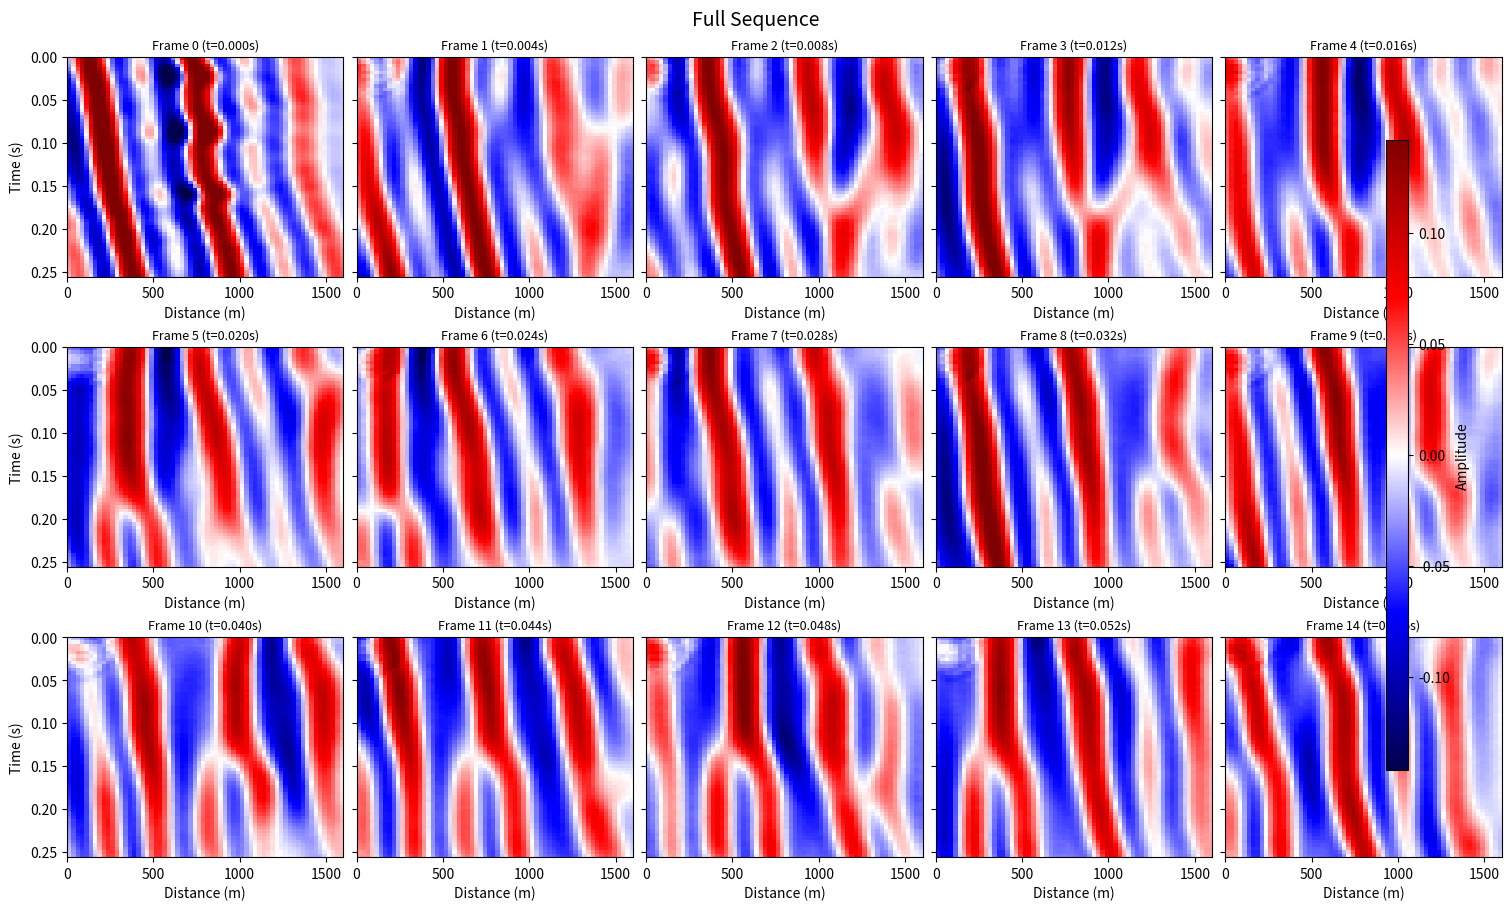

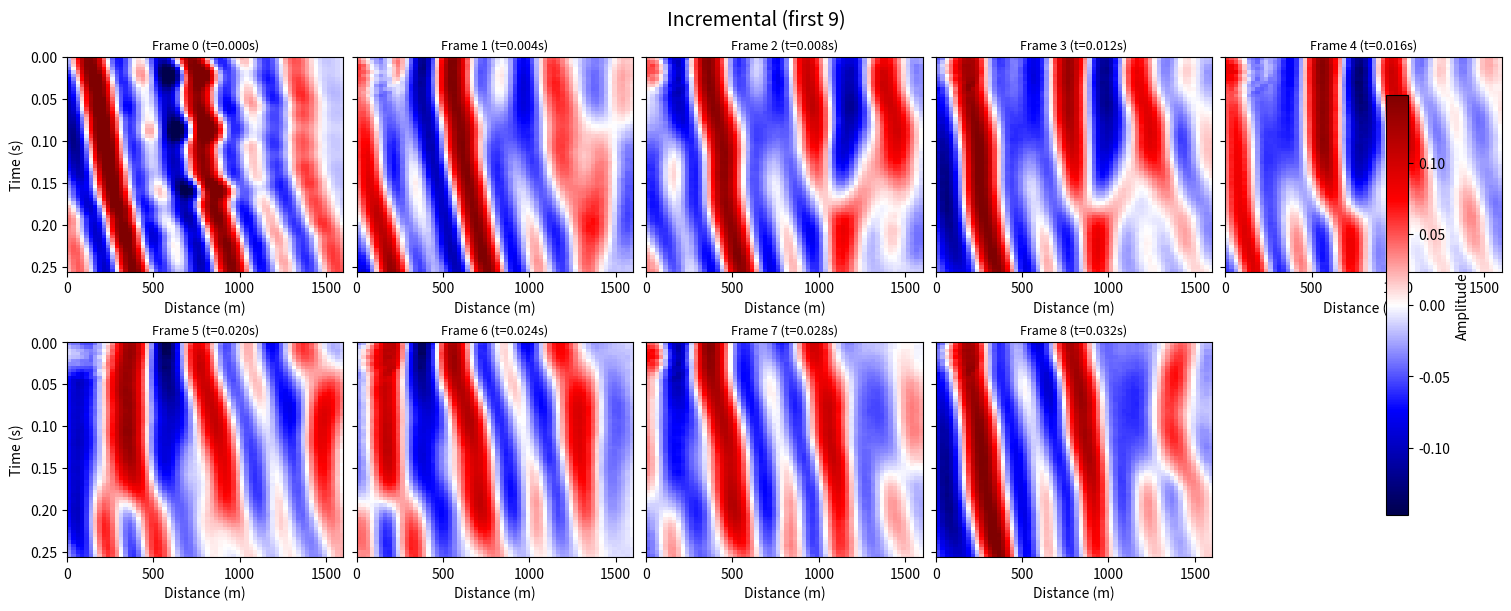

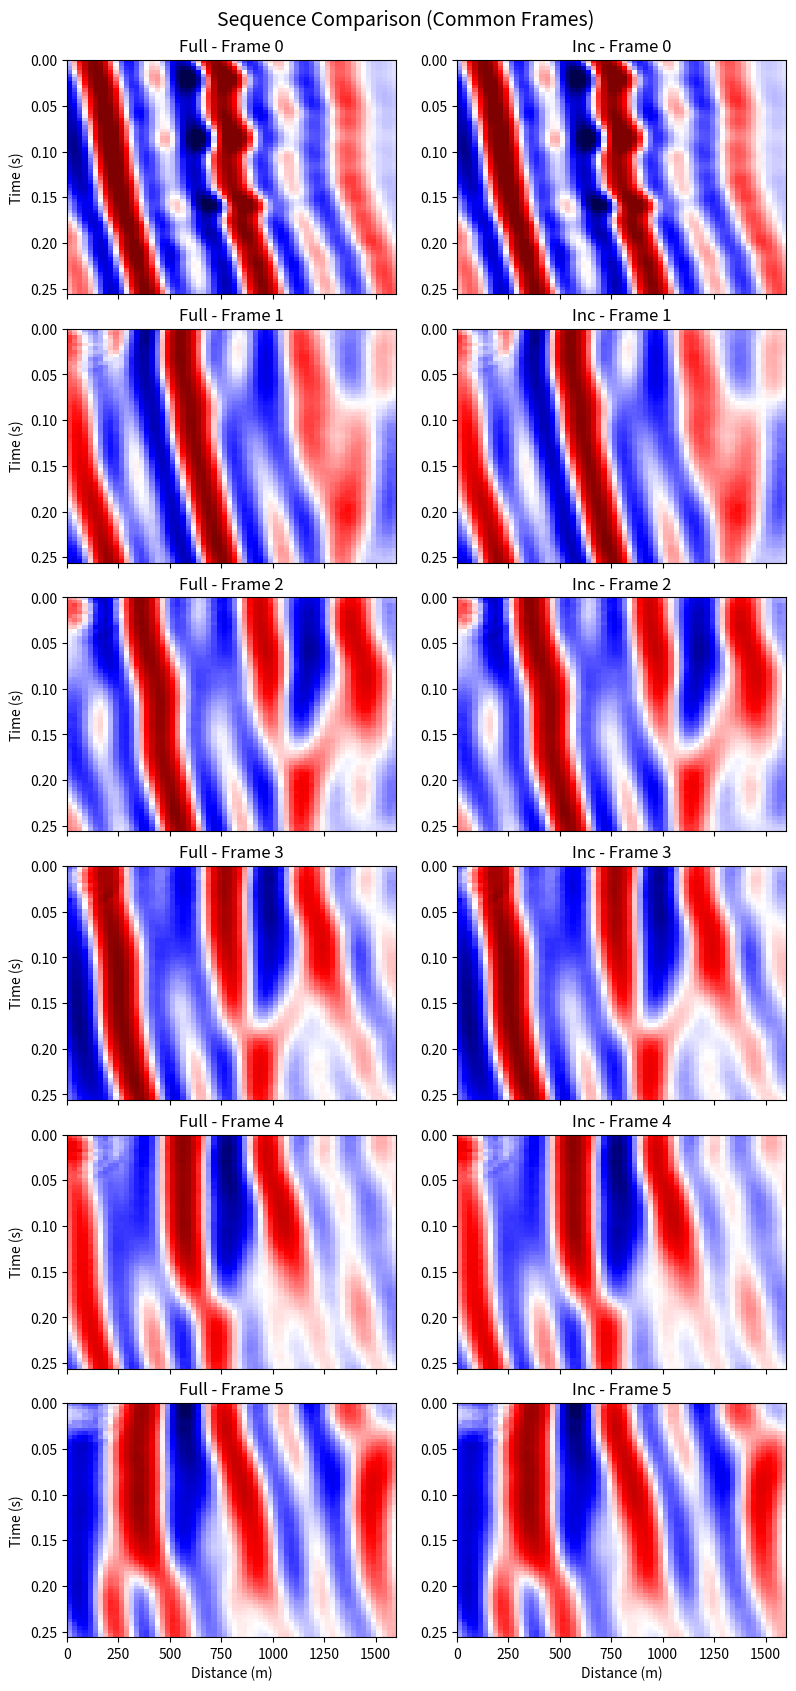

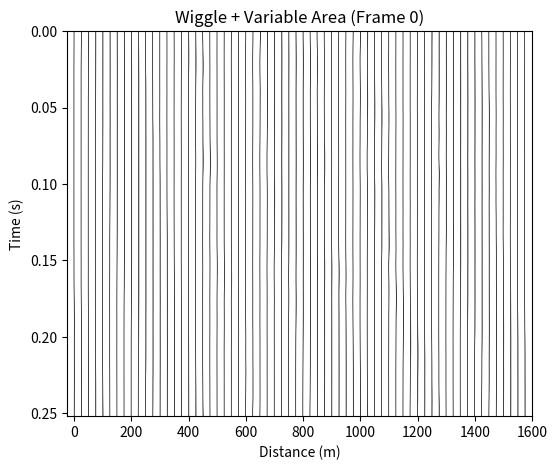

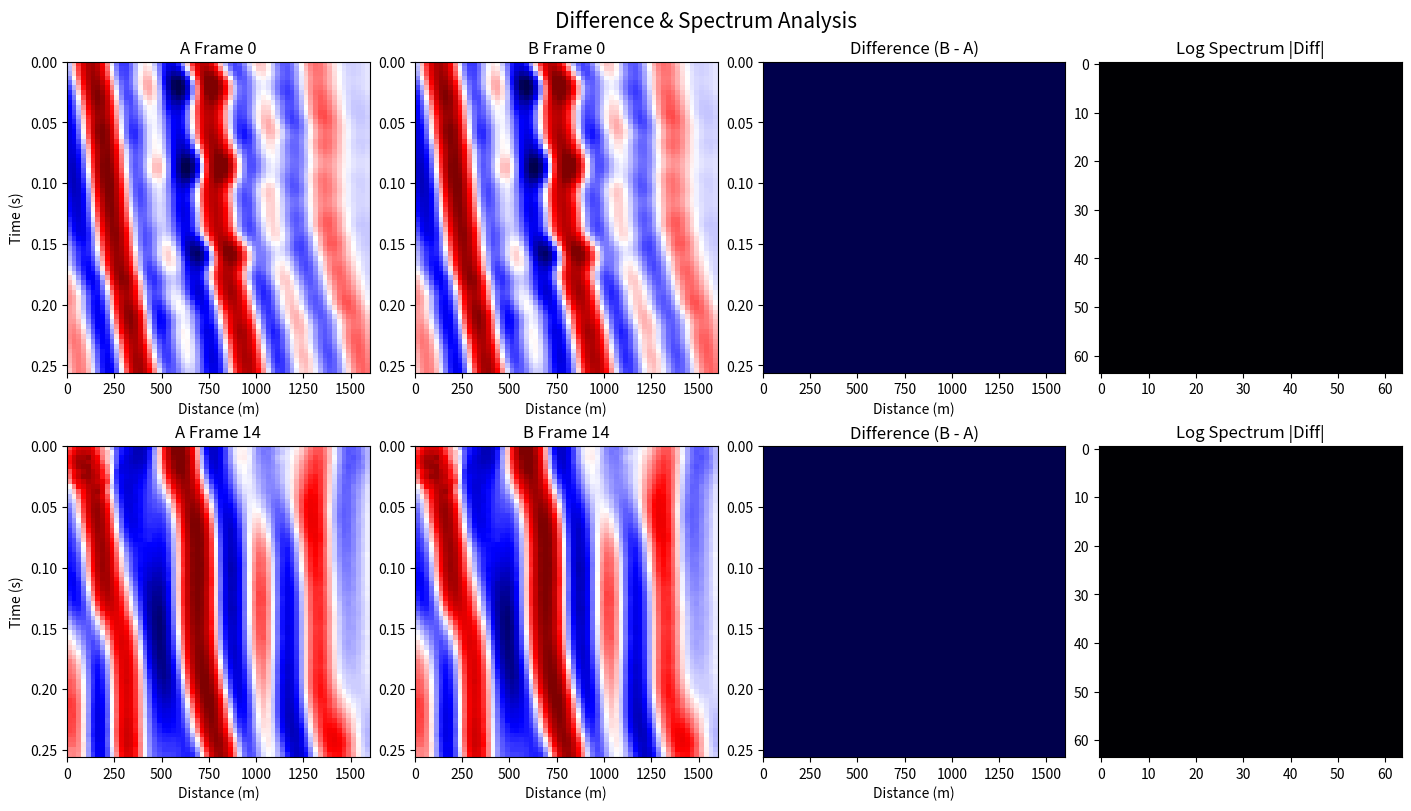

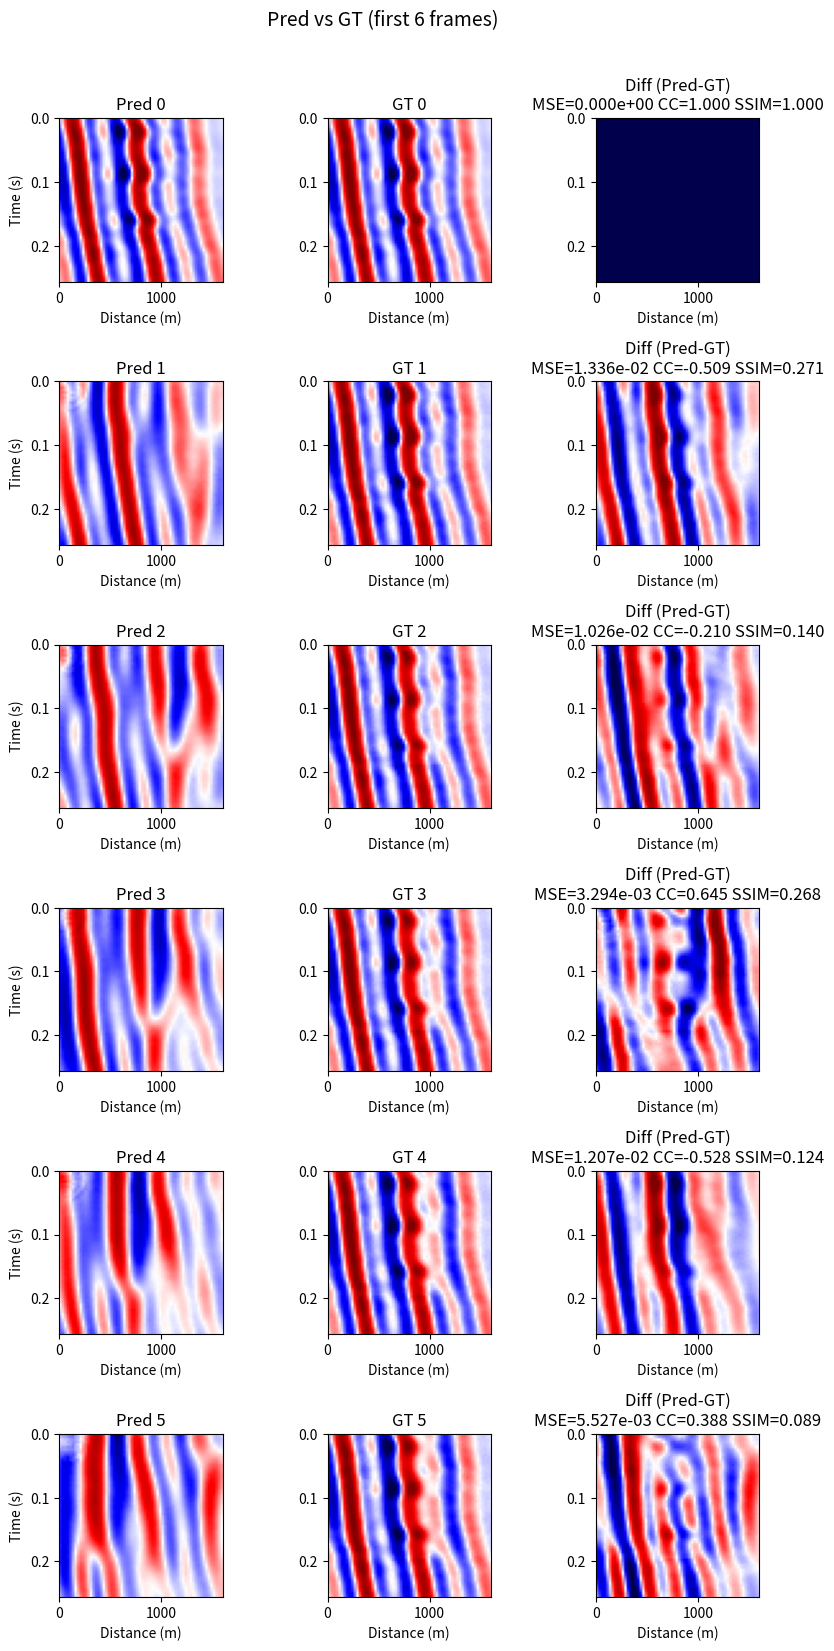

{'full_sequence': '/content/drive/MyDrive/SeismicWorld/exp001_full_sequence.pdf', 'incremental_first9': '/content/drive/MyDrive/SeismicWorld/exp001_incremental_first9.pdf', 'sequence_comparison': '/content/drive/MyDrive/SeismicWorld/exp001_sequence_comparison.pdf', 'wiggle_frame0': '/content/drive/MyDrive/SeismicWorld/exp001_wiggle_frame0.pdf', 'difference_spectrum': '/content/drive/MyDrive/SeismicWorld/exp001_difference_spectrum.pdf', 'pred_gt_comparison': '/content/drive/MyDrive/SeismicWorld/exp001_pred_gt_comparison.pdf'}


In [15]:
# demo_all(results['pair_rollout'],results['incremental'],GT_video.unsqueeze(1))
figs, paths = demo_all(
    gen_video_full=results['pair_rollout'],
    gen_video_inc=results['incremental'],
    ground_truth=GT_video.unsqueeze(1),
    dt=0.004,
    dx=25.0,
    save_dir=f_path,
    prefix="exp001",
    save_pdf=True,
    show=True,
    close_fig=False,
    gt_square=True,
    box_aspect=1.0
)
print(paths)


Processing 1280 samples to extract latent codes...


  0%|          | 0/1280 [00:00<?, ?it/s]


Data processing complete.
Shape of collected latent codes: (1280, 64)
Shape of collected labels: (1280,)
Unique labels found: [0 1 2]

Running UMAP for dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (1280, 2)
Plotting the results...


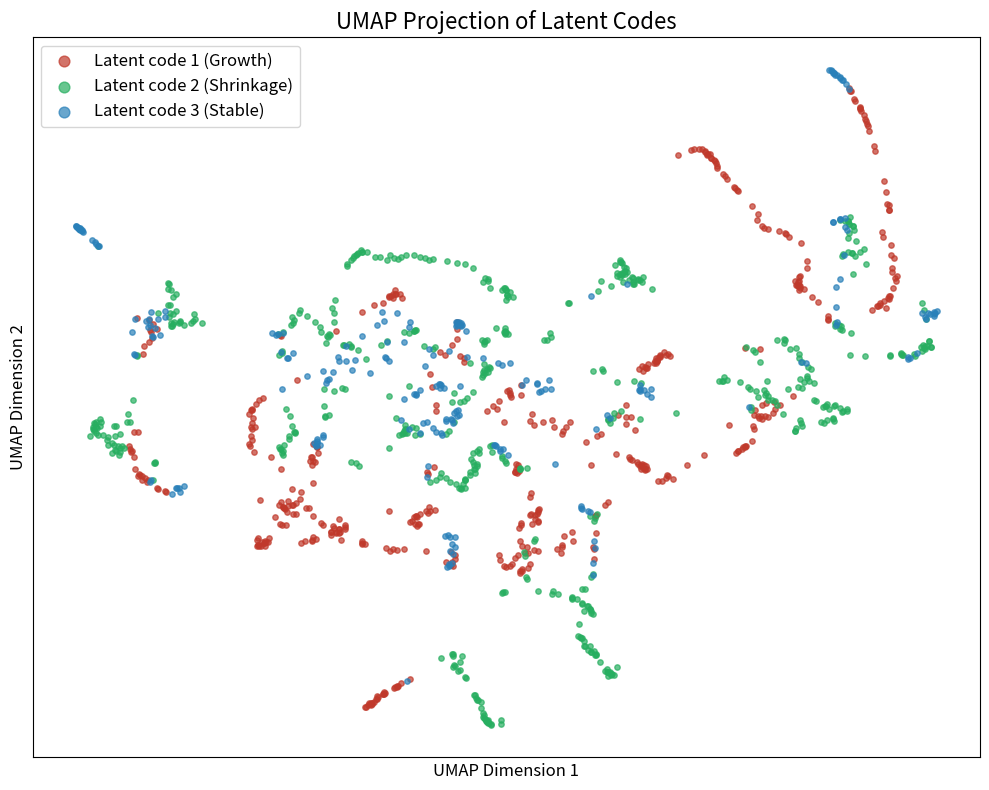

In [ ]:
#@title UMAP
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 用于显示漂亮的进度条

# 确保模型在评估模式
vqvae_model.eval()

# --- 1. 遍历整个数据集，提取所有 latent codes 和标签 ---
all_latent_codes = []
all_labels = []

# 定义标签逻辑：根据两帧之间的平均像素值变化来分类
# 你可以根据你的物理知识调整这个阈值
STABILITY_THRESHOLD = 1e-4 # 变化小于此值被认为是“稳定”

print(f"Processing {len(seismic_data_video)} samples to extract latent codes...")

# 使用 tqdm 创建一个进度条
for i in tqdm(range(len(seismic_data_video))):
    with torch.no_grad():
        # 获取第一帧和第二帧
        frame1 = seismic_data_video[i:i+1, 0:1, :, :].to(DEVICE) # [1, 1, 64, 64]
        frame2 = seismic_data_video[i:i+1, 1:2, :, :].to(DEVICE) # [1, 1, 64, 64]

        # a. 提取第一帧的 latent code (indices)
        # VQ-VAE编码器输出的是 [1, 1, 8, 8] 的 indices
        latent_indices = vqvae_model.encode_to_indices(frame1)

        # 将 latent code 展平为一维向量 [64] 并转为 numpy
        flattened_code = latent_indices.view(-1).cpu().numpy()
        all_latent_codes.append(flattened_code)

        # b. 创建标签
        # 计算两帧之间的平均变化
        mean_change = (frame2 - frame1).mean().item()

        if mean_change > STABILITY_THRESHOLD:
            label = 0  # 类别0: 增长 (e.g., CO2 plume growth)
        elif mean_change < -STABILITY_THRESHOLD:
            label = 1  # 类别1: 减少 (e.g., CO2 plume shrinkage)
        else:
            label = 2  # 类别2: 稳定 (Stable)
        all_labels.append(label)

# --- 2. 将数据转换为 Numpy 数组 ---
latent_codes_np = np.array(all_latent_codes)
labels_np = np.array(all_labels)

print(f"\nData processing complete.")
print(f"Shape of collected latent codes: {latent_codes_np.shape}") # 应该是 [num_samples, 64]
print(f"Shape of collected labels: {labels_np.shape}")          # 应该是 [num_samples]
print(f"Unique labels found: {np.unique(labels_np)}")

# --- 3. 使用 UMAP 进行降维 ---
print("\nRunning UMAP for dimensionality reduction...")
# n_neighbors 控制算法关注局部/全局结构，min_dist 控制聚类的紧凑程度
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(latent_codes_np)

print(f"UMAP embedding shape: {embedding.shape}") # 应该是 [num_samples, 2]

# --- 4. 可视化结果 ---
print("Plotting the results...")
fig, ax = plt.subplots(figsize=(10, 8))

# 定义标签名称和颜色，以匹配示例图
label_names = {0: 'Latent code 1 (Growth)', 1: 'Latent code 2 (Shrinkage)', 2: 'Latent code 3 (Stable)'}
colors = ['#C0392B', '#27AE60', '#2980B9'] # 红、绿、蓝

# 分类别绘制散点图，以便创建自定义图例
for label_id, name in label_names.items():
    # 找到属于当前类别的点的索引
    indices = np.where(labels_np == label_id)[0]
    if len(indices) > 0:
        ax.scatter(
            embedding[indices, 0],
            embedding[indices, 1],
            color=colors[label_id],
            label=name,
            s=15, # 点的大小
            alpha=0.7 # 透明度
        )

ax.set_title('UMAP Projection of Latent Codes', fontsize=16, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.legend(fontsize=12, markerscale=2)
ax.grid(True, linestyle='--', alpha=0.6)

# 移除坐标轴的刻度值，使图像更简洁
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(
    f_path+'/UMAP_Projection_of_Latent_Codes.pdf',
    format='pdf',
    dpi=300,
    bbox_inches='tight',
    facecolor='white',
    edgecolor='none',
    transparent=False
)
plt.tight_layout()
plt.show()


In [ ]:
# ================================================================================================
#@title SeismicWorld Kalman Filter Integration Cell
# 位置: 插入到 SeismicWorldVideoWorld 类中，在 InternLM 预测后、VQ-VAE 解码前
# 新增模块: SeismicKalmanFilter - 用于单步预测优化的状态空间模型
# 设计理念: 每次都是"输入t时刻 → 预测t+1时刻"，卡尔曼滤波优化预测质量
# ================================================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional

class SeismicKalmanState:
    """卡尔曼滤波状态容器 - 用于跟踪预测质量和不确定性"""
    def __init__(self, mean: torch.Tensor, covariance: torch.Tensor, prediction_confidence: torch.Tensor):
        self.mean = mean  # 预测状态均值 [B, latent_dim]
        self.covariance = covariance  # 预测不确定性 [B, latent_dim, latent_dim]
        self.prediction_confidence = prediction_confidence  # 预测置信度 [B, 1]

class SeismicKalmanFilter(nn.Module):
    """
    地震数据单步预测优化的卡尔曼滤波器
    核心思想: 不是多步预测，而是优化每个"t → t+1"的单步预测质量
    """

    def __init__(self,
                 token_dim: int = 4096,  # InternLM输出token维度
                 latent_dim: int = 512,  # 潜在状态维度
                 device: str = 'cuda'):
        super().__init__()
        self.token_dim = token_dim
        self.latent_dim = latent_dim
        self.device = device

        # InternLM token到潜在状态的映射
        self.token_encoder = nn.Sequential(
            nn.Linear(token_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Linear(latent_dim * 2, latent_dim),
            nn.LayerNorm(latent_dim),
            nn.Dropout(0.1)
        )

        # 预测质量评估网络
        self.quality_estimator = nn.Sequential(
            nn.Linear(latent_dim, latent_dim // 2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, 1),
            nn.Sigmoid()  # 输出0-1的质量分数
        )

        # 预测不确定性估计
        self.uncertainty_estimator = nn.Sequential(
            nn.Linear(latent_dim, latent_dim // 2),
            nn.ReLU(),
            nn.Linear(latent_dim // 2, latent_dim),
            nn.Softplus()  # 确保正值
        )

        # 预测优化网络 (基于历史预测质量调整当前预测)
        self.prediction_refiner = nn.Sequential(
            nn.Linear(latent_dim + 1, latent_dim),  # +1 for confidence
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.Residual()  # 残差连接保持原始预测
        )

        # 从优化后的潜在状态映射回token空间
        self.token_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Linear(latent_dim * 2, token_dim),
            nn.LayerNorm(token_dim)
        )

        # 历史状态记忆 (用于"瞻前顾后")
        self.history_buffer = []
        self.max_history = 5  # 记忆最近5步的预测状态

    def encode_prediction(self, llm_tokens: torch.Tensor) -> SeismicKalmanState:
        """
        将InternLM的预测tokens编码为卡尔曼状态
        Args:
            llm_tokens: [B, token_dim] InternLM对下一时刻的预测
        Returns:
            编码后的卡尔曼状态
        """
        batch_size = llm_tokens.shape[0]

        # 编码到潜在空间
        latent_state = self.token_encoder(llm_tokens)  # [B, latent_dim]

        # 估计预测质量
        prediction_confidence = self.quality_estimator(latent_state)  # [B, 1]

        # 估计预测不确定性
        uncertainty = self.uncertainty_estimator(latent_state)  # [B, latent_dim]
        covariance = torch.diag_embed(uncertainty)  # [B, latent_dim, latent_dim]

        return SeismicKalmanState(latent_state, covariance, prediction_confidence)

    def update_with_history(self, current_state: SeismicKalmanState) -> SeismicKalmanState:
        """
        基于历史预测状态优化当前预测 (卡尔曼滤波的"瞻前顾后")
        Args:
            current_state: 当前预测状态
        Returns:
            基于历史信息优化后的状态
        """
        if len(self.history_buffer) == 0:
            # 没有历史信息，直接返回当前状态
            return current_state

        # 计算历史状态的加权平均 (近期权重更高)
        weights = torch.softmax(torch.arange(len(self.history_buffer), dtype=torch.float32), dim=0)

        historical_mean = torch.zeros_like(current_state.mean)
        for i, hist_state in enumerate(self.history_buffer):
            historical_mean += weights[i] * hist_state.mean

        # 基于历史信息和当前置信度调整预测
        confidence_weighted_input = torch.cat([
            current_state.mean,
            current_state.prediction_confidence
        ], dim=-1)  # [B, latent_dim + 1]

        # 优化当前预测
        refined_state = self.prediction_refiner(confidence_weighted_input)

        # 结合历史信息 (卡尔曼滤波思想)
        alpha = current_state.prediction_confidence  # 置信度作为融合权重
        optimized_mean = alpha * refined_state + (1 - alpha) * historical_mean

        # 更新不确定性 (置信度高时不确定性降低)
        optimized_covariance = current_state.covariance * (1 - current_state.prediction_confidence.unsqueeze(-1))

        return SeismicKalmanState(optimized_mean, optimized_covariance, current_state.prediction_confidence)

    def decode_to_tokens(self, optimized_state: SeismicKalmanState) -> torch.Tensor:
        """
        将优化后的状态解码回token空间
        Args:
            optimized_state: 优化后的卡尔曼状态
        Returns:
            优化后的预测tokens [B, token_dim]
        """
        return self.token_decoder(optimized_state.mean)

    def single_step_optimize(self, llm_prediction_tokens: torch.Tensor) -> Tuple[torch.Tensor, SeismicKalmanState]:
        """
        单步预测优化 - 核心方法
        Args:
            llm_prediction_tokens: [B, token_dim] InternLM的原始预测
        Returns:
            optimized_tokens: 优化后的预测tokens
            kalman_state: 对应的卡尔曼状态
        """
        # 1. 编码当前预测
        current_state = self.encode_prediction(llm_prediction_tokens)

        # 2. 基于历史信息优化 ("瞻前顾后")
        optimized_state = self.update_with_history(current_state)

        # 3. 解码回token空间
        optimized_tokens = self.decode_to_tokens(optimized_state)

        # 4. 更新历史缓存
        self.history_buffer.append(optimized_state)
        if len(self.history_buffer) > self.max_history:
            self.history_buffer.pop(0)  # 保持固定长度

        return optimized_tokens, optimized_state

    def reset_history(self):
        """重置历史缓存 (新序列开始时调用)"""
        self.history_buffer = []

# ================================================================================================
# 集成到 SeismicWorldVideoWorld 类中的方法
# ================================================================================================

def integrate_kalman_optimization(self, input_ids: torch.Tensor) -> Tuple[torch.Tensor, SeismicKalmanState]:
    """
    集成卡尔曼滤波的单步预测优化
    在 SeismicWorldVideoWorld.forward() 中调用

    Args:
        input_ids: [B, seq_len] 当前时刻的输入 (t时刻)
    Returns:
        optimized_3d_model: [B, C, X, Y, Z] 优化后的t+1时刻预测
        kalman_state: 对应的卡尔曼状态
    """
    # 1. InternLM前向传播 (现有代码) - 预测t+1时刻
    with torch.no_grad():
        outputs = self.model(input_ids=input_ids)
        # 假设outputs.logits是对下一时刻的预测
        prediction_tokens = outputs.last_hidden_state[:, -1, :]  # [B, hidden_dim]

    # 2. 初始化卡尔曼滤波器 (新增)
    if not hasattr(self, 'kalman_filter'):
        self.kalman_filter = SeismicKalmanFilter(
            token_dim=self.model.config.hidden_size,
            latent_dim=512,
            device=input_ids.device
        )

    # 3. 卡尔曼单步优化 (新增) - 优化"t → t+1"的预测
    optimized_tokens, kalman_state = self.kalman_filter.single_step_optimize(prediction_tokens)

    # 4. 将优化后的tokens解码为3D模型 (连接到现有VQ-VAE)
    fsq_codes = self.token_to_fsq_codes(optimized_tokens)  # 需要实现
    optimized_3d_model = self.vqvae.decode(fsq_codes)

    return optimized_3d_model, kalman_state

# ================================================================================================
# 训练时的序列处理 (修正版)
# ================================================================================================

def train_with_kalman_optimization(self, batch_data: dict) -> torch.Tensor:
    """
    训练时的序列处理 - 每个时间步都是独立的"输入-输出"对
    Args:
        batch_data: 包含完整序列的批次数据
            - seismic_data: [B, 9, X, Y, Z] 完整时间序列
    Returns:
        总训练损失
    """
    seismic_sequence = batch_data['seismic_data']  # [B, 9, X, Y, Z]
    batch_size, seq_len = seismic_sequence.shape[:2]

    total_loss = 0.0
    kalman_states = []

    # 重置历史缓存 (新序列开始)
    self.kalman_filter.reset_history()

    # 对每个时间步进行独立的"t → t+1"预测
    for t in range(seq_len - 1):  # 0到7，预测1到8
        # 输入: t时刻的3D模型
        input_3d = seismic_sequence[:, t]  # [B, X, Y, Z]
        target_3d = seismic_sequence[:, t + 1]  # [B, X, Y, Z] 真实的t+1时刻

        # 编码为token ids (需要实现)
        input_ids = self.encode_3d_to_tokens(input_3d)  # [B, seq_len]

        # 卡尔曼优化的单步预测
        predicted_3d, kalman_state = self.integrate_kalman_optimization(input_ids)
        kalman_states.append(kalman_state)

        # 计算单步损失
        step_loss = F.mse_loss(predicted_3d, target_3d)

        # 添加卡尔曼状态正则化
        confidence_reg = torch.mean(1 - kalman_state.prediction_confidence)  # 鼓励高置信度
        uncertainty_reg = torch.mean(torch.diagonal(kalman_state.covariance, dim1=-2, dim2=-1))

        total_loss += step_loss + 0.01 * confidence_reg + 0.001 * uncertainty_reg

    return total_loss / (seq_len - 1)  # 平均损失

print("✅ SeismicWorld Kalman单步优化模块已就绪!")
print("📍 插入位置: SeismicWorldVideoWorld.forward() 中 InternLM预测后")
print("🎯 设计理念: 每次独立预测 t → t+1，卡尔曼滤波优化预测质量")
print("🔄 数据流: t时刻输入 → InternLM预测 → Kalman优化 → 高质量t+1预测")


# deprecated

In [ ]:
#@title 多物理场下的速度密度反演-工具函数包括-训练"地震-速度UNET"

def anisotropic_diffusion_3d(seismic, n_iter=10, K=0.1, lambda_=0.15):
    """
    3D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    seismic: (D, H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (D, H, W) tensor

    n_iter 越大，平滑越强。
    K 控制边缘的“敏感度”，越小越容易保留细节。
    lambda_ 是步长，建议不大于0.25。
    """
    I = seismic.clone()
    D, H, W = I.shape

    # 6邻域差分
    def get_gradients(I):
        grads = []
        # pad在边界复制
        I_pad = F.pad(I[None, None], (1,1,1,1,1,1), mode='replicate')[0,0]
        # x方向
        grads.append(I_pad[2:,1:-1,1:-1] - I)  # 前
        grads.append(I_pad[:-2,1:-1,1:-1] - I) # 后
        # y方向
        grads.append(I_pad[1:-1,2:,1:-1] - I)  # 上
        grads.append(I_pad[1:-1,:-2,1:-1] - I) # 下
        # z方向
        grads.append(I_pad[1:-1,1:-1,2:] - I)  # 右
        grads.append(I_pad[1:-1,1:-1,:-2] - I) # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（这里用exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I

def anisotropic_diffusion_2d(image, n_iter=10, K=0.1, lambda_=0.15):
    """
    2D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    image: (H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (H, W) tensor

    n_iter 越大，平滑越强。
    K 控制边缘的“敏感度”，越小越容易保留细节。
    lambda_ 是步长，建议不大于0.25。
    """
    import torch
    import torch.nn.functional as F

    I = image.clone()
    H, W = I.shape

    # 4邻域差分
    def get_gradients(I):
        grads = []
        I_pad = F.pad(I[None, None], (1,1,1,1), mode='replicate')[0,0]
        # y方向
        grads.append(I_pad[2:,1:-1] - I)   # 下
        grads.append(I_pad[:-2,1:-1] - I)  # 上
        # x方向
        grads.append(I_pad[1:-1,2:] - I)   # 右
        grads.append(I_pad[1:-1,:-2] - I)  # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I

def sobel3d_edge(seismic):
    """
    用三维Sobel算子提取边缘（可直接用于深度学习反向传播）；
    对三维地震体做Sobel边缘检测，返回边缘概率图（归一化到0~1）
    seismic: (B, 1, D, H, W) or (1, D, H, W)
    返回: edge_map (同shape)
    """
    # 3D Sobel核
    device = seismic.device if torch.is_tensor(seismic) else 'cpu'
    kernel = torch.tensor([
        [[-1, -3, -1], [-3, -6, -3], [-1, -3, -1]],
        [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
        [[ 1,  3,  1], [ 3,  6,  3], [ 1,  3,  1]]
    ], dtype=torch.float32, device=device)
    kernel = kernel[None, None, :, :, :]  # (out_c, in_c, D, H, W)
    # 对三个方向分别卷积
    gx = F.conv3d(seismic[None, None], kernel, padding=1)
    gy = F.conv3d(seismic[None, None], kernel.permute(0,1,4,2,3), padding=1)
    gz = F.conv3d(seismic[None, None], kernel.permute(0,1,3,4,2), padding=1)
    grad = torch.sqrt(gx**2 + gy**2 + gz**2) # 三维空间下反映每个点的“变化剧烈程度"
    # 归一化梯度幅值（通常到0~1区间），可作为“边缘概率”或“边缘响应”
    edge_map = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
    return edge_map[0,0]  # shape: (D,H,W)

def get_sobel3d_kernels_5x5(device='cpu'):
    # 一维平滑核和差分核
    G = torch.tensor([1, 4, 6, 4, 1], dtype=torch.float32, device=device)
    D = torch.tensor([-2, -1, 0, 1, 2], dtype=torch.float32, device=device)
    # 构造三维核
    # x方向
    kernel_x = D[:, None, None] * G[None, :, None] * G[None, None, :]
    # y方向
    kernel_y = G[:, None, None] * D[None, :, None] * G[None, None, :]
    # z方向
    kernel_z = G[:, None, None] * G[None, :, None] * D[None, None, :]
    # 归一化
    kernel_x = kernel_x / kernel_x.abs().sum()
    kernel_y = kernel_y / kernel_y.abs().sum()
    kernel_z = kernel_z / kernel_z.abs().sum()
    # 变为(1,1,5,5,5)
    return (kernel_x[None, None], kernel_y[None, None], kernel_z[None, None])

def sobel3d_edge_5x5(seismic):
    """
    用5x5x5三维Sobel算子提取边缘
    seismic: (D, H, W) or (1, D, H, W)
    返回: edge_map (D, H, W)
    """
    device = seismic.device if torch.is_tensor(seismic) else 'cpu'
    if seismic.dim() == 3:
        seismic = seismic.unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
    elif seismic.dim() == 4:
        seismic = seismic.unsqueeze(0)  # (1,1,D,H,W)
    kernel_x, kernel_y, kernel_z = get_sobel3d_kernels_5x5(device)
    gx = F.conv3d(seismic, kernel_x, padding=2)
    gy = F.conv3d(seismic, kernel_y, padding=2)
    gz = F.conv3d(seismic, kernel_z, padding=2)
    grad = torch.sqrt(gx**2 + gy**2 + gz**2)
    edge_map = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
    return edge_map[0,0]  # (D,H,W)

def get_mask(edge_map, thresh=0.5):
    """可微分二值化（训练时用sigmoid，推理可直接>thresh）"""
    return (edge_map > thresh).float()

from scipy.ndimage import label
def assign_vp_by_region(edge_mask, shape, device='cpu'):
    """
    给每个密闭体分配可学习参数miu和sigma，生成vp模型
    edge_mask: (D,H,W) 二值边缘mask，1表示边界
    shape: (D,H,W)
    返回:
        vp: (D,H,W) 每个体素的vp值
        region_ids: (D,H,W) 区域编号
        miu_list, sigma_list: 每个region的参数（torch.Parameter）
    """
    # 先用scipy标记连通域
    region_ids, n_region = label(1 - edge_mask.cpu().numpy()) # 0=边界，1=内部
    region_ids = torch.tensor(region_ids, device=device)
    # 初始化可学习参数
    miu_list = torch.nn.Parameter(torch.ones(n_region) * 3500)  # 初值可自定义
    sigma_list = torch.nn.Parameter(torch.ones(n_region) * 100)
    # 构造vp
    D, H, W = shape
    vp = torch.zeros(D, H, W, device=device)
    for idx in range(n_region):
        mask = (region_ids == idx)
        # 采样/赋值
        vp[mask] = torch.normal(miu_list[idx].item(), sigma_list[idx].item(), size=(mask.sum(),), device=device)
    return vp, region_ids, miu_list, sigma_list

def gardner_rho(vp, a=0.31, b=0.25):
    return a * vp ** b

# FFT方法计算重力异常，GeoModel类所使用的
def compute_gravity_fft(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    padding_factor=2,
    reference_density=2.67,
    G=6.67430e-11,
    mute=False
):
    """
    静态函数：根据三维密度体计算重力异常（mGal），基于Parker公式（FFT方法）

    Args:
        rho (np.ndarray): 三维密度体，单位g/cm³
        dX (float): x方向网格间距（米）
        dY (float): y方向网格间距（米）
        dZ (float): z方向网格间距（米）
        Zmin (float): 顶部深度（米）
        height (float): 观测高度（米），相对模型顶部
        padding_factor (int): 边缘填充因子
        reference_density (float): 参考密度（g/cm³），如2.67
        G (float): 万有引力常数
        mute (bool): 是否静默

    Returns:
        gravity (np.ndarray): 重力异常（mGal），shape与rho一致
    """
    if not mute:
        print('计算重力异常（Parker公式）...')

    # 密度反差
    rho_model = rho - reference_density  # 单位g/cm³

    # 获取模型尺寸
    ny, nx, nz = rho_model.shape

    # 填充以减少边缘效应
    padded_ny = ny * padding_factor
    padded_nx = nx * padding_factor
    rho_padded = np.zeros((padded_ny, padded_nx, nz), dtype=np.float32)
    start_y = (padded_ny - ny) // 2
    start_x = (padded_nx - nx) // 2
    rho_padded[start_y:start_y+ny, start_x:start_x+nx, :] = rho_model

    # 波数域
    kx = 2 * np.pi * np.fft.fftfreq(padded_nx, dX)
    ky = 2 * np.pi * np.fft.fftfreq(padded_ny, dY)
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    k = np.sqrt(kx_grid**2 + ky_grid**2)
    k[0, 0] = 1e-10

    # 频率域重力异常
    gravity_fft = np.zeros((padded_ny, padded_nx), dtype=np.complex64)

    # Parker公式级数展开
    for n in range(5):
        if not mute:
            print(f' Parker公式第{n+1}/5项...')
        depth_term = np.zeros((padded_ny, padded_nx), dtype=np.float32)
        for i in range(nz):
            z_val = Zmin + i * dZ
            z_term = z_val ** n
            depth_term += rho_padded[:, :, i] * z_term * dZ
        depth_term_fft = np.fft.fft2(depth_term)
        gravity_fft += (k**n / math.factorial(n)) * depth_term_fft

    # 应用高度衰减和常数
    gravity_fft *= 2 * np.pi * G * 1000 * np.exp(-k * height)  # 1000: g/cm³→kg/m³

    # 回到空间域
    gravity_padded = np.real(np.fft.ifft2(gravity_fft))

    # 提取原始区域
    gravity = gravity_padded[start_y:start_y+ny, start_x:start_x+nx]

    # 转换为mGal
    gravity *= 1e5

    if not mute:
        print(' 完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')

    return gravity

# 空间域直接积分计算重力异常
from concurrent.futures import ProcessPoolExecutor, as_completed
def _gravity_row(args):
    # 单独计算一行观测点的重力异常
    iy, drho, x, y, z, obs_z, dX, dY, dZ, G = args
    ny, nx, nz = drho.shape
    row = np.zeros(nx, dtype=np.float32)
    for ix in range(nx):
        gz = 0.0
        obs_x = x[ix]
        obs_y = y[iy]
        for iz in range(nz):
            dz = z[iz] - obs_z
            for jy in range(ny):
                dy = y[jy] - obs_y
                for jx in range(nx):
                    dx = x[jx] - obs_x
                    r2 = dx**2 + dy**2 + dz**2
                    if r2 == 0:
                        continue
                    dV = dX * dY * dZ
                    gz += G * drho[jy, jx, iz] * dV * dz / (r2**1.5)
        row[ix] = gz
    return iy, row

def compute_gravity_spatial_parallel(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11,
    n_workers=2,
    mute=False
):
    """
    并行空间域直接积分法：三维密度体重力异常（mGal）

    Args:
        rho (np.ndarray): 三维密度体，单位g/cm³
        dX, dY, dZ (float): 网格间距（米）
        Zmin (float): 模型顶部深度（米）
        height (float): 观测高度（米），相对模型顶部
        reference_density (float): 参考密度（g/cm³）
        G (float): 万有引力常数
        n_workers (int): 并行进程数
        mute (bool): 是否静默

    Returns:
        gravity (np.ndarray): 重力异常（mGal），shape为(rho.shape[0], rho.shape[1])
    """
    if not mute:
        print('并行计算空间域重力异常...')

    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape
    gravity = np.zeros((ny, nx), dtype=np.float32)

    x = (np.arange(nx) + 0.5) * dX
    y = (np.arange(ny) + 0.5) * dY
    z = Zmin + (np.arange(nz) + 0.5) * dZ
    obs_z = Zmin - height

    # 构造参数列表
    args_list = [
        (iy, drho, x, y, z, obs_z, dX, dY, dZ, G)
        for iy in range(ny)
    ]

    # 并行计算
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(_gravity_row, args) for args in args_list]
        for f in as_completed(futures):
            iy, row = f.result()
            gravity[iy, :] = row
            if not mute and iy % 8 == 0:
                print(f"  行 {iy+1}/{ny} 完成")

    gravity *= 1e5  # m/s² → mGal
    if not mute:
        print('完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')
    return gravity

import numpy as np
from numba import njit, prange

# numba并行
@njit(parallel=True, fastmath=True)
def gravity_direct_numba(drho, dX, dY, dZ, x, y, z, obs_z, G):
    ny, nx, nz = drho.shape
    gravity = np.zeros((ny, nx), dtype=np.float32)
    dV = dX * dY * dZ
    for iy in prange(ny):
        for ix in range(nx):
            gz = 0.0
            obs_x = x[ix]
            obs_y = y[iy]
            for iz in range(nz):
                dz = z[iz] - obs_z
                for jy in range(ny):
                    dy = y[jy] - obs_y
                    for jx in range(nx):
                        dx = x[jx] - obs_x
                        r2 = dx**2 + dy**2 + dz**2
                        if r2 == 0:
                            continue
                        gz += G * drho[jy, jx, iz] * dV * dz / (r2**1.5)
            gravity[iy, ix] = gz
    return gravity

def compute_gravity_direct_numba(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11,
    mute=False
):
    """
    Numba加速的空间域直接积分法
    """
    if not mute:
        print('Numba加速空间域重力异常...')
    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape
    x = (np.arange(nx) + 0.5) * dX
    y = (np.arange(ny) + 0.5) * dY
    z = Zmin + (np.arange(nz) + 0.5) * dZ
    obs_z = Zmin - height
    gravity = gravity_direct_numba(drho, dX, dY, dZ, x, y, z, obs_z, G)
    gravity *= 1e5  # m/s² → mGal
    if not mute:
        print('完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')
    return gravity

# torch自动微分计算
def gravity_forward_torch(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11
):
    """
    PyTorch端到端可微分的重力异常正演
    输入:
        rho: [ny, nx, nz]，密度模型
    输出:
        gravity: [ny, nx]，重力异常
    """
    device = rho.device
    dtype = rho.dtype

    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape

    # 观测点和模型网格
    x = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
    y = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
    z = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ
    obs_z = Zmin - height
    dV = dX * dY * dZ

    # 初始化输出
    gravity = torch.zeros((ny, nx), device=device, dtype=dtype)

    # 主循环，逐点计算（可进一步向量化）
    for iy in range(ny):
        for ix in range(nx):
            obs_x = x[ix]
            obs_y = y[iy]
            gz = 0.0

            for iz in range(nz):
                dz = z[iz] - obs_z  # 标量
                # 计算当前层所有体素到观测点的dx, dy
                dx = x - obs_x      # [nx]
                dy = y - obs_y      # [ny]
                # 网格化dx, dy
                dx_grid, dy_grid = torch.meshgrid(dx, dy, indexing='ij')  # [nx, ny]
                dx_grid = dx_grid.transpose(0,1)  # [ny, nx]
                dy_grid = dy_grid.transpose(0,1)  # [ny, nx]
                # 计算r^2
                r2 = dx_grid**2 + dy_grid**2 + dz**2  # [ny, nx]
                mask = r2 > 0
                # 取出当前dz层的密度差
                drho_layer = drho[:, :, iz]  # [ny, nx]
                # 贡献
                contrib = torch.zeros_like(r2)
                contrib[mask] = G * drho_layer[mask] * dV * dz / (r2[mask]**1.5)
                gz = gz + contrib.sum()
            gravity[iy, ix] = gz

    gravity = gravity * 1e5  # m/s² → mGal
    return gravity

def gravity_forward_torch_vectorized(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11
):
    """
    高效向量化的PyTorch重力异常正演
    输入:
        rho: [ny, nx, nz]
    输出:
        gravity: [ny, nx]
    """
    device = rho.device
    dtype = rho.dtype

    ny, nx, nz = rho.shape
    drho = (rho - reference_density) * 1000  # kg/m³

    # 观测点坐标
    x_obs = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX  # [nx]
    y_obs = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY  # [ny]
    obs_z = Zmin - height

    # 体素中心坐标
    x_grid = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX  # [nx]
    y_grid = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY  # [ny]
    z_grid = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ  # [nz]

    dV = dX * dY * dZ

    # 构建体素坐标 [ny, nx, nz, 3]
    grid_y, grid_x, grid_z = torch.meshgrid(y_grid, x_grid, z_grid, indexing='ij')  # [ny, nx, nz]

    # 展开体素 [N, 3]
    voxels = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)  # [N, 3]
    drho_flat = drho.reshape(-1)  # [N]

    # 构建观测点坐标 [M, 3]
    obs_xx, obs_yy = torch.meshgrid(x_obs, y_obs, indexing='ij')  # [nx, ny]
    obs_points = torch.stack([
        obs_xx.reshape(-1), obs_yy.reshape(-1),
        torch.full((nx*ny,), obs_z, device=device, dtype=dtype)
    ], dim=-1)  # [M, 3]

    # 计算观测点到每个体素的矢量差 [M, N, 3]
    diff = voxels.unsqueeze(0) - obs_points.unsqueeze(1)  # [M, N, 3]
    r2 = (diff ** 2).sum(dim=-1)  # [M, N]
    dz = diff[..., 2]  # [M, N]

    # 避免除零
    r2_safe = r2 + 1e-12

    # drho_flat [N] -> [1, N] -> [M, N] (自动广播)
    contrib = G * drho_flat.unsqueeze(0) * dV * dz / (r2_safe ** 1.5)  # [M, N]

    # 累加体素，得到每个观测点的重力异常 [M]
    gravity_flat = contrib.sum(dim=1) * 1e5  # mGal

    # reshape回 [ny, nx]
    gravity = gravity_flat.reshape(nx, ny).transpose(0, 1)  # [ny, nx]

    return gravity

def gravity_forward_tpu_batched_grad(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11,
    batch_size=16384  # 根据TPU内存调整的批次大小
):
    """
    为TPU优化、支持梯度计算的高效PyTorch重力异常正演函数。

    此函数通过对观测点进行分批处理，有效控制了内存峰值，使其能够处理
    大规模问题，同时保留了计算图以支持反向传播（梯度计算）。

    输入:
        rho: [ny, nx, nz] - 密度模型张量。为了计算梯度，它应该设置 requires_grad=True。
        batch_size: int - 每次处理的观测点数量。这是性能和内存的关键平衡点。
    输出:
        gravity: [ny, nx] - 计算出的重力异常张量。
    """
    device = rho.device
    dtype = rho.dtype

    ny, nx, nz = rho.shape
    # 密度差是计算的核心，梯度会通过这里传播
    drho = (rho - reference_density) * 1000  # kg/m³

    # --- 1. 准备体素（Source）坐标和密度 ---
    # 这部分计算与梯度无关，因此可以保持不变
    x_grid = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
    y_grid = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
    z_grid = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ
    dV = dX * dY * dZ

    grid_y, grid_x, grid_z = torch.meshgrid(y_grid, x_grid, z_grid, indexing='ij')

    # 将体素坐标和密度展平，形状为 [N, 3] 和 [N] (N = ny * nx * nz)
    voxels = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    drho_flat = drho.reshape(-1)

    # --- 2. 准备观测点（Observation）坐标 ---
    x_obs = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
    y_obs = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
    obs_z = Zmin - height

    obs_xx, obs_yy = torch.meshgrid(x_obs, y_obs, indexing='ij')

    # 将观测点坐标展平，形状为 [M, 3] (M = nx * ny)
    obs_points = torch.stack([
        obs_xx.reshape(-1), obs_yy.reshape(-1),
        torch.full((nx * ny,), obs_z, device=device, dtype=dtype)
    ], dim=-1)

    # --- 3. 分批计算重力异常 ---
    num_obs = obs_points.shape[0]
    gravity_flat = torch.zeros(num_obs, device=device, dtype=dtype)

    # 【关键改动】
    # 移除了 torch.no_grad() 上下文，以确保所有操作都被PyTorch的Autograd引擎追踪
    for i in range(0, num_obs, batch_size):
        obs_batch = obs_points[i:i + batch_size]

        # 核心计算步骤，所有这些操作现在都是可微分的
        # Broadcasting: [1, N, 3] - [batch_size, 1, 3] -> [batch_size, N, 3]
        diff = voxels.unsqueeze(0) - obs_batch.unsqueeze(1)

        r2 = (diff ** 2).sum(dim=-1)
        dz = diff[..., 2]
        r2_safe = r2 + 1e-12 # 加上一个极小值防止除零

        # drho_flat 是从 rho 来的，因此 contrib 会连接到 rho 的计算图上
        # Broadcasting: [1, N] * [batch_size, N] -> [batch_size, N]
        contrib = G * drho_flat.unsqueeze(0) * dV * dz / (r2_safe ** 1.5)

        gravity_batch = contrib.sum(dim=1) * 1e5  # mGal

        gravity_flat[i:i + batch_size] = gravity_batch

    # --- 4. Reshape回最终形状 ---
    # Reshape 和 transpose 也是可微分操作
    gravity = gravity_flat.reshape(nx, ny).transpose(0, 1)  # [ny, nx]

    return gravity

def gravity_forward_tpu_optimized(
    drho_flat,
    voxels,
    obs_points,
    dV,
    batch_size,
    G=6.67430e-11
):
    """
    专为TPU性能优化的重力正演核心计算函数。

    此函数假设所有不随密度变化的坐标张量 (`voxels`, `obs_points`)
    以及体积元 `dV` 都在外部预先计算好。它只执行最核心的分批计算，
    从而最大化TPU效率。

    输入:
        drho_flat: [N] - 展平的密度差张量 (drho * 1000)。这是每次迭代中唯一变化的部分。
        voxels: [N, 3] - 预计算好的体素坐标。
        obs_points: [M, 3] - 预计算好的观测点坐标。
        dV: float - 体素体积。
        batch_size: int - 批处理大小。
    输出:
        gravity_flat: [M] - 展平的重力异常张量。
    """
    device = drho_flat.device
    dtype = drho_flat.dtype
    num_obs = obs_points.shape[0]

    # 预分配结果张量
    gravity_flat = torch.zeros(num_obs, device=device, dtype=dtype)

    # 这个循环内的所有操作都在一个极简的、稳定的计算图上进行
    for i in range(0, num_obs, batch_size):
        obs_batch = obs_points[i:i + batch_size]

        # 核心计算步骤
        # Broadcasting: [1, N, 3] - [batch_size, 1, 3] -> [batch_size, N, 3]
        diff = voxels.unsqueeze(0) - obs_batch.unsqueeze(1)

        r2 = (diff ** 2).sum(dim=-1)
        dz = diff[..., 2]
        r2_safe = r2 + 1e-12

        # Broadcasting: [1, N] * [batch_size, N] -> [batch_size, N]
        contrib = G * drho_flat.unsqueeze(0) * dV * dz / (r2_safe ** 1.5)

        gravity_batch = contrib.sum(dim=1) * 1e5  # mGal
        gravity_flat[i:i + batch_size] = gravity_batch

    return gravity_flat

# --- 神经网络----
class SEBlock3D(nn.Module):
    """
    SE（Squeeze-and-Excitation）模块能够为每个通道分配不同的权重，突出模型关注的特征。
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention3D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention3D, self).__init__()
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention

class CBAM3D(nn.Module):
    """
    CBAM（Convolutional Block Attention Module）同时关注空间和通道维度。对于高异常值分布的关注，空间注意力尤其有效。
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM3D, self).__init__()
        self.channel_attention = SEBlock3D(channels, reduction)
        self.spatial_attention = SpatialAttention3D(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, attention=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = CBAM3D(out_channels) if attention else nn.Identity()
        # 适配通道数不一致的残差映射
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        res = self.residual(x)
        out = self.conv(x)
        out = out + res
        out = self.relu(out)
        out = self.attention(out)
        return out

class UNet3D_ResAtten(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_features=64):
        super().__init__()
        # 增加深度，base_features更大
        self.enc1 = ResidualConvBlock(in_channels, base_features)
        self.enc2 = ResidualConvBlock(base_features, base_features*2)
        self.enc3 = ResidualConvBlock(base_features*2, base_features*4)
        self.enc4 = ResidualConvBlock(base_features*4, base_features*8)
        self.enc5 = ResidualConvBlock(base_features*8, base_features*16)

        self.pool = nn.MaxPool3d(2)

        self.up4 = nn.ConvTranspose3d(base_features*16, base_features*8, 2, 2)
        self.dec4 = ResidualConvBlock(base_features*16, base_features*8)
        self.up3 = nn.ConvTranspose3d(base_features*8, base_features*4, 2, 2)
        self.dec3 = ResidualConvBlock(base_features*8, base_features*4)
        self.up2 = nn.ConvTranspose3d(base_features*4, base_features*2, 2, 2)
        self.dec2 = ResidualConvBlock(base_features*4, base_features*2)
        self.up1 = nn.ConvTranspose3d(base_features*2, base_features, 2, 2)
        self.dec1 = ResidualConvBlock(base_features*2, base_features)
        self.out_conv = nn.Conv3d(base_features, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        d4 = self.up4(e5)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.out_conv(d1)
        return out

# 标准3D UNet
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_features=32):
        super(UNet3D, self).__init__()
        # 编码器
        self.enc1 = self.conv_block(in_channels, base_features)
        self.enc2 = self.conv_block(base_features, base_features*2)
        self.enc3 = self.conv_block(base_features*2, base_features*4)
        self.enc4 = self.conv_block(base_features*4, base_features*8)
        # 下采样
        self.pool = nn.MaxPool3d(2)
        # 解码器
        self.up3 = nn.ConvTranspose3d(base_features*8, base_features*4, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(base_features*8, base_features*4)
        self.up2 = nn.ConvTranspose3d(base_features*4, base_features*2, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(base_features*4, base_features*2)
        self.up1 = nn.ConvTranspose3d(base_features*2, base_features, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(base_features*2, base_features)
        # 输出层
        self.out_conv = nn.Conv3d(base_features, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 编码
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # 解码
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.out_conv(d1)
        return out

from torch.utils.data import Dataset, DataLoader

def minmax_normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

def minmax_denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val + 1e-8) + min_val

# 1. 数据集封装
class SeismicVpDataset(Dataset):
    def __init__(self, seismic_vp_pairs, apply_diffusion=True):
        self.pairs = seismic_vp_pairs
        self.apply_diffusion = apply_diffusion

        # 计算vp全局min/max
        all_vp = torch.cat([vp.flatten() for _, vp in seismic_vp_pairs])
        self.vp_min = all_vp.min()
        self.vp_max = all_vp.max()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seismic, vp = self.pairs[idx]
        if self.apply_diffusion:
            seismic = anisotropic_diffusion_3d(seismic, n_iter=15, K=0.01, lambda_=0.18)
        seismic = seismic.unsqueeze(0)
        # 归一化vp
        vp_norm = minmax_normalize(vp, self.vp_min, self.vp_max).unsqueeze(0)
        return seismic, vp_norm

# --- 地震-速度UNET训练函数
def train_unet_on_seismic_vp(
    seismic_vp_train_pairs,
    device='cuda',
    batch_size=2,
    num_epochs=50,
    lr=1e-3,
    best_model_path='best_unet3d.pth',
    final_model_path='final_unet3d.pth',
    resume_path=None  # 新增参数：断点续训.pth路径
):
    dataset = SeismicVpDataset(seismic_vp_train_pairs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet3D_ResAtten(in_channels=1, out_channels=1).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # 默认归一化参数
    vp_min, vp_max = dataset.vp_min, dataset.vp_max

    start_epoch = 0
    best_loss = float('inf')
    best_state = None

    # ---- 断点续训 ----
    if resume_path is not None:
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        # 兼容保存的归一化参数
        vp_min = checkpoint.get('vp_min', vp_min)
        vp_max = checkpoint.get('vp_max', vp_max)
        print(f"Resumed training from checkpoint: {resume_path}")

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_iter = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for seismic, vp_norm in batch_iter:
            seismic = seismic.to(device)
            vp_norm = vp_norm.to(device)
            optimizer.zero_grad()
            pred_vp_norm = model(seismic)
            loss = criterion(pred_vp_norm, vp_norm)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seismic.size(0)
            batch_iter.set_postfix({'batch_loss': loss.item()})

        avg_loss = epoch_loss / len(dataset)
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()
            # 保存归一化参数
            torch.save({
                'model_state_dict': best_state,
                'vp_min': vp_min,
                'vp_max': vp_max,
            }, best_model_path)
            tqdm.write(f"Best model updated at epoch {epoch+1} (Avg Loss: {avg_loss:.6f})")

    torch.save({
        'model_state_dict': model.state_dict(),
        'vp_min': vp_min,
        'vp_max': vp_max,
    }, final_model_path)
    print("Training finished.")
    print(f"Best model saved to: {best_model_path}")
    print(f"Final model saved to: {final_model_path}")
    return model, vp_min, vp_max

# seismic_data 和 vp_data 已经加载并处理完成
# seismic_data 的形状: [20, 2, 64, 64, 64]
# vp_data 的形状: [20, 2, 64, 64, 64]

seismic_vp_train_pairs = []
num_samples = seismic_data.shape[0]  # 样本数量 (20)
num_timesteps = seismic_data.shape[1] # 时间步数量 (2)

for i in range(num_samples):
    for j in range(num_timesteps):
        # 提取单个样本在单个时间步的地震数据切片
        seismic_slice = seismic_data[i, j, :, :, :]
        # 提取单个样本在单个时间步的速度数据切片
        vp_slice = vp_data[i, j, :, :, :]
        # 将 (地震数据切片, 速度数据切片) 元组添加到列表中
        seismic_vp_train_pairs.append((seismic_slice, vp_slice))

print(f"生成的训练对数量: {len(seismic_vp_train_pairs)}")
if seismic_vp_train_pairs:
    print(f"第一个地震数据切片的形状: {seismic_vp_train_pairs[0][0].shape}")
    print(f"第一个速度数据切片的形状: {seismic_vp_train_pairs[0][1].shape}")
    print(f"列表包含 {len(seismic_vp_train_pairs)} 个 (seismic_slice, vp_slice) 对。")


# --- 训练 ---
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# trained_model = train_unet_on_seismic_vp(
#     seismic_vp_train_pairs,
#     device=device,
#     batch_size=4,
#     num_epochs=80,
#     lr=1e-3,
#     best_model_path='/content/drive/MyDrive/SeismicWorld/ckp_u_pre_ae/seismic_vp_unet_attn_best.pth',
#     final_model_path='/content/drive/MyDrive/SeismicWorld/ckp_u_pre_ae/seismic_vp_unet_attn_final.pth',
#     resume_path='/content/drive/MyDrive/SeismicWorld/ckp_u_pre_ae/seismic_vp_unet_attn_best.pth'
# )

# --- 推理---
# 推理时反归一化
def predict_and_denormalize(model, seismic, vp_min, vp_max, device='cuda'):
    model.eval()
    with torch.no_grad():
        seismic = seismic.unsqueeze(0).to(device)  # [1, 1, D, H, W]
        pred_vp_norm = model(seismic)
        pred_vp = minmax_denormalize(pred_vp_norm.cpu().squeeze(0), vp_min, vp_max)
    return pred_vp

# 载入模型
def load_unet3d_and_params(model_path, device='cuda'):
    checkpoint = torch.load(model_path, map_location=device)
    # model = UNet3D(in_channels=1, out_channels=1).to(device)
    model = UNet3D_ResAtten(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    vp_min = checkpoint['vp_min']
    vp_max = checkpoint['vp_max']
    return model, vp_min, vp_max

def predict_and_denormalize(model, seismic, vp_min, vp_max, device='cuda'):
    """
    seismic: torch.Tensor, shape [1, D, H, W] or [D, H, W]
    返回: 反归一化后的vp, shape [D, H, W]
    """
    model.eval()
    with torch.no_grad():
        if seismic.ndim == 3:
            seismic = seismic.unsqueeze(0)  # [1, D, H, W]
        seismic = seismic.unsqueeze(0).to(device)  # [1, 1, D, H, W]
        pred_vp_norm = model(seismic)
        pred_vp_norm = pred_vp_norm.squeeze(0).squeeze(0)  # [D, H, W]
        pred_vp = minmax_denormalize(pred_vp_norm, vp_min, vp_max)
    return pred_vp



生成的训练对数量: 40
第一个地震数据切片的形状: torch.Size([64, 64, 64])
第一个速度数据切片的形状: torch.Size([64, 64, 64])
列表包含 40 个 (seismic_slice, vp_slice) 对。


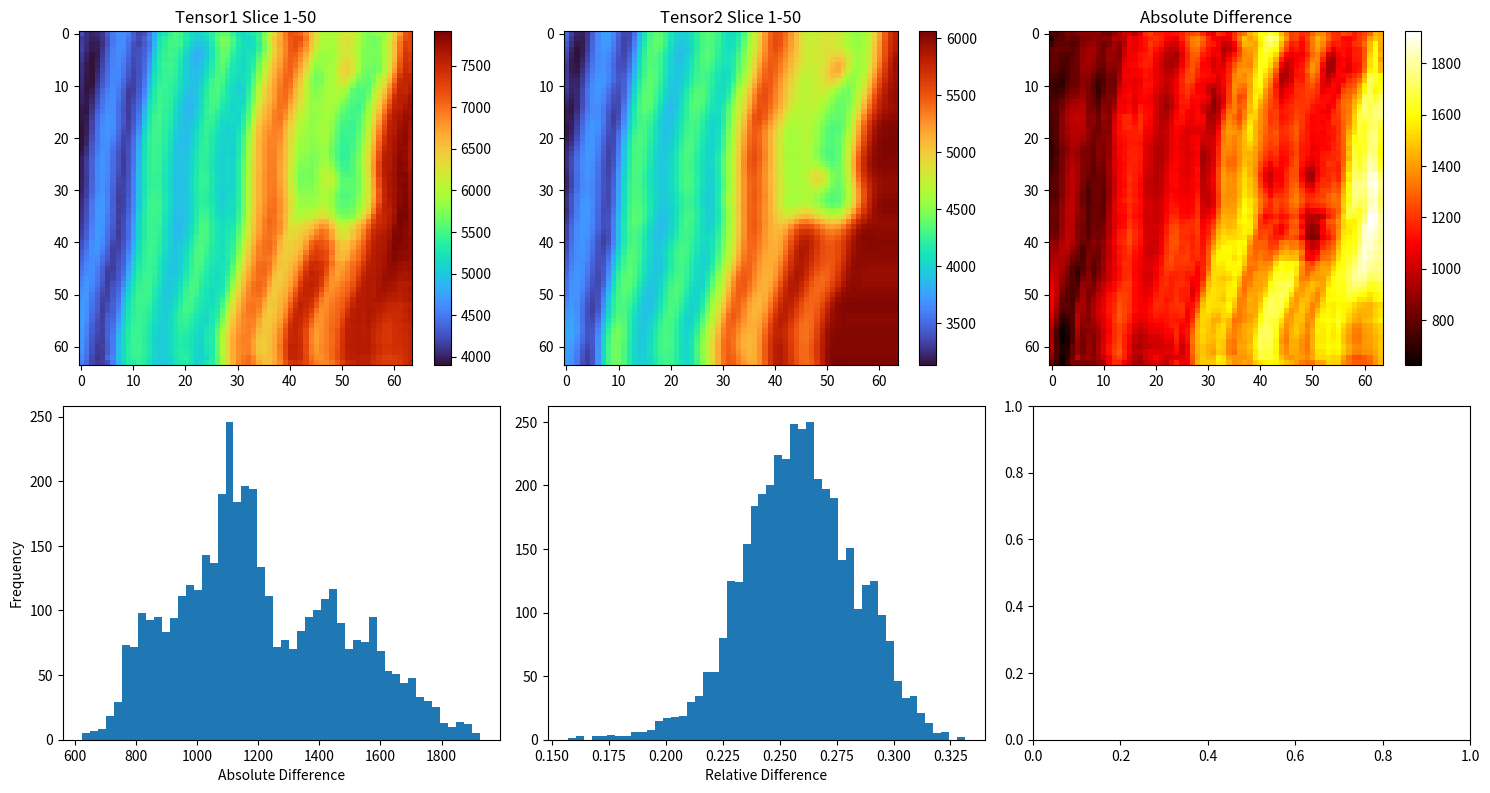

{'max_abs': 1925.4970703125, 'mean_abs': 1205.187255859375, 'rel_over_threshold': 1.0}


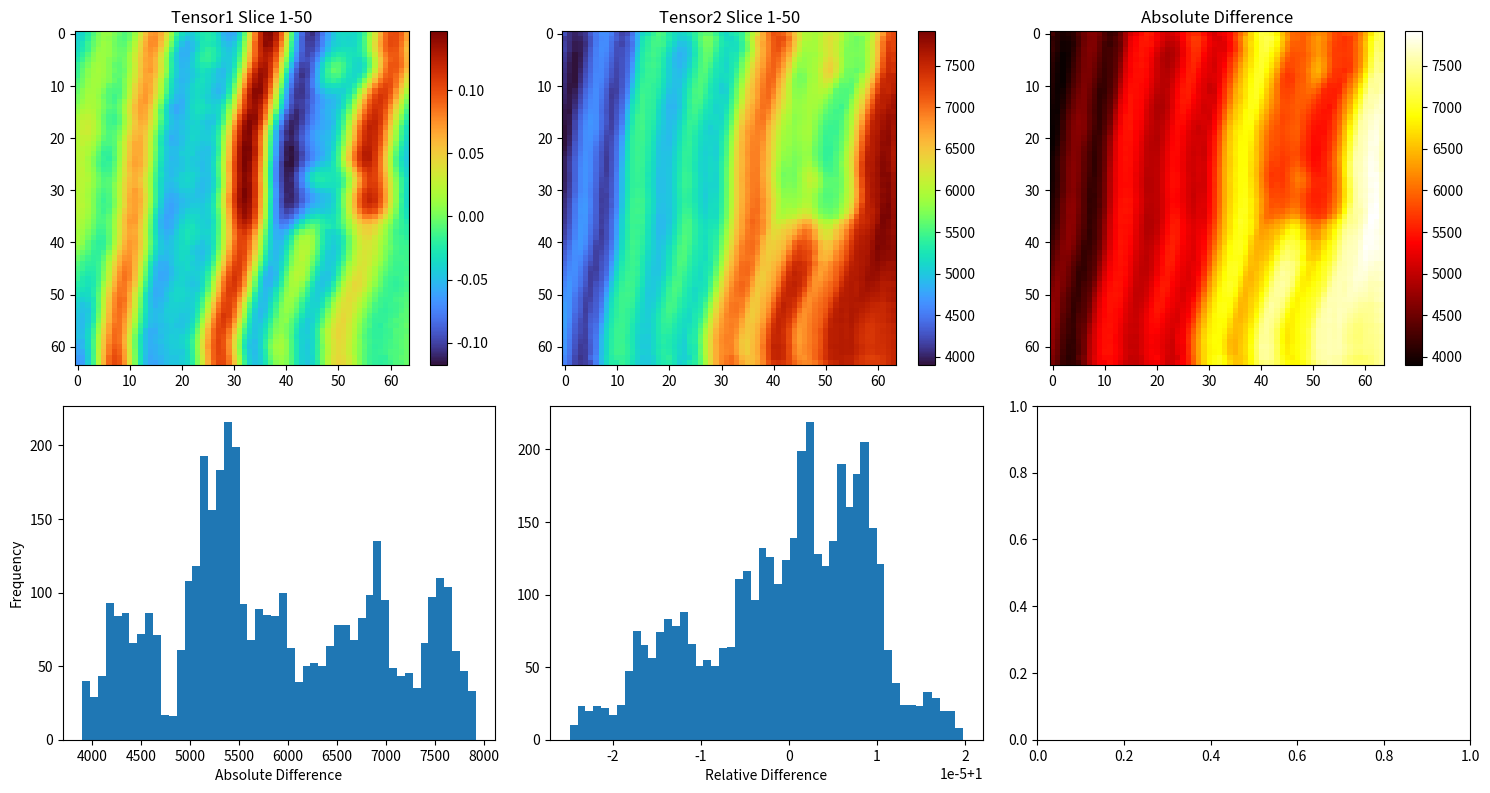

{'max_abs': 7913.46923828125, 'mean_abs': 5848.50244140625, 'rel_over_threshold': 1.0}


In [ ]:
#@title 多物理场下的速度密度反演-推理"地震-速度UNET",比较SW预测的地震和真实速度模型

# 路径与设备
model_path = '/content/drive/MyDrive/SeismicWorld/ckp_u_pre_ae/seismic_vp_unet_attn_best.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 载入模型与参数
model, vp_min, vp_max = load_unet3d_and_params(model_path, device=device)

# 随机索引, 用于获得地震, 速度, 磁异常数据
import random
random.seed(42)
# RANDOM_INDEX = random.randint(0, len(seismic_vp_train_pairs) - 1) # 固定了因为设置了seed
RANDOM_INDEX = 3+4*2

# 获取一组地震数据和vp（这里只用地震数据）
seismic_new, vp_new = seismic_vp_train_pairs[RANDOM_INDEX]

# # 磁异常索引
# magnetic_tensor_idx = RANDOM_INDEX // 4      # 第几个tensor
# magnetic_inner_idx = RANDOM_INDEX % 4        # tensor中的第几个样本
# # 取出对应的磁异常
# magnetic_anomaly = magnetic_list[magnetic_tensor_idx][magnetic_inner_idx]

# 神经网络预测
pred_vp = predict_and_denormalize(model, seismic_new.to(device), vp_min.to(device), vp_max.to(device), device=device)
# pred_vp 形状为 [D, H, W]

# 比较预测速度和真实速度
stats, fig = compare_4d_slices(pred_vp.cpu().detach().unsqueeze(0), vp_new.cpu().unsqueeze(0).detach(), dim=1, index=50)
plt.show()
print(stats)

# 比较SW预测的地震和预测速度模型
stats, fig = compare_4d_slices(seismic_new.cpu().detach().unsqueeze(0), pred_vp.cpu().detach().unsqueeze(0), dim=1, index=50)
plt.show()
print(stats)

# 二进制保存预测速度&真实速度
pred_vp_numpy = pred_vp.detach().cpu().numpy()
pred_vp_numpy.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/pred_vp_vanilla_{RANDOM_INDEX}.bin")
vp_new_numpy = vp_new.detach().cpu().numpy()
vp_new_numpy.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/vp_true_{RANDOM_INDEX}.bin")
# diff_vp_numpy = pred_vp_numpy - vp_new_numpy
# diff_vp_numpy.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/vp_diff_{RANDOM_INDEX}.bin")

## 重力异常约束


正在预计算目标(Target)重力异常...
目标重力异常计算完成。
正在计算预测(Computed)重力异常...
预测重力异常计算完成。

正在生成对比图像...


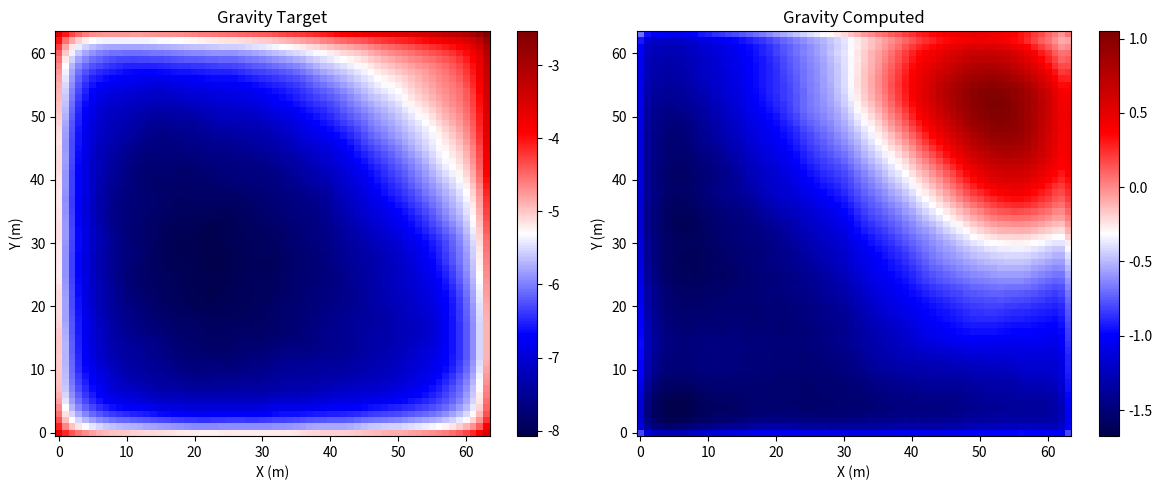

In [ ]:
#@title 从速度依据gardner推导到密度

# --- 计算rho ---
vp_new = vp_new.to(device)
pred_vp = pred_vp.to(device)

# --- 计算重力异常 ---
# --- 强烈建议：在优化循环外预计算目标值 ---
# 这个过程只执行一次，因为它在整个优化过程中是固定不变的
print("\n正在预计算目标(Target)重力异常...")
with torch.no_grad(): # 无需为目标值计算梯度
    vp_target = vp_new.clone().detach()
    rho_target = gardner_rho(vp_target)
    # 使用较大的batch_size，因为没有梯度计算，内存更宽裕
    gravity_target = gravity_forward_tpu_batched_grad(rho_target, height=10.0, batch_size=2048)
print("目标重力异常计算完成。")

# --- 执行一次正向传播（模拟优化循环中的一步） ---
print("正在计算预测(Computed)重力异常...")
# 1. 从速度推导密度 (这一步仍在计算图内)
rho_computed = gardner_rho(pred_vp)

# 2. 计算重力异常 (这是计算图的主要部分)
gravity_computed = gravity_forward_tpu_batched_grad(
    rho_computed,
    height=10.0,
    batch_size=1024 # 训练时batch_size可能需要小一些以节省内存
)
print("预测重力异常计算完成。")

# --- 关键步骤：触发TPU执行 ---
# 在实际的训练循环中，这一步会在 optimizer.step() 之后
# 这里我们为了获取 `gravity_computed` 的实际值，需要手动标记
if 'xla' in str(device):
    xm.mark_step()
    print("XLA图已执行，计算结果已同步。")

import matplotlib.pyplot as plt
# --- 可视化对比 ---
print("\n正在生成对比图像...")
# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 第一个子图
im1 = ax1.imshow(gravity_target,
                 cmap='seismic',
                 origin='lower',
                 aspect='auto')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Gravity Target')
plt.colorbar(im1, ax=ax1)

# 第二个子图
im2 = ax2.imshow(gravity_computed,
                 cmap='seismic',
                 origin='lower',
                 aspect='auto')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Gravity Computed')
plt.colorbar(im2, ax=ax2)

# 调整布局
plt.tight_layout()

# 保存为PDF
plt.savefig('/content/drive/MyDrive/SeismicWorld/gravity_comparison_before_11.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


正在执行一次性预计算...
预计算完成。所有坐标张量已生成并存储在TPU上。

正在计算目标(Target)重力异常...
目标重力异常计算完成。
正在计算预测(Computed)重力异常...
预测重力异常计算完成。
正在生成对比图像...


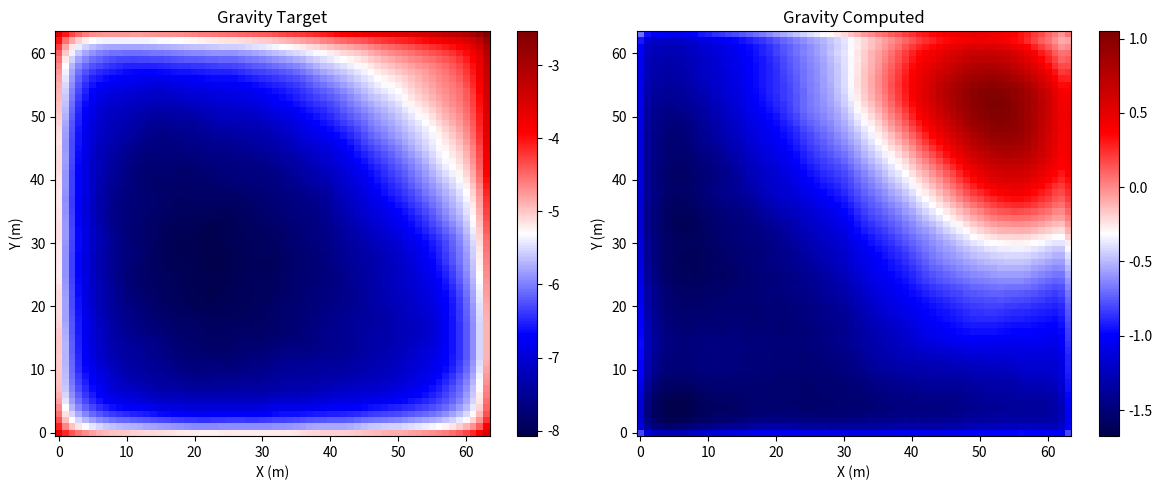

In [ ]:
# @title Default title text
import torch
import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt

# --- 首先，定义专为TPU优化的核心计算函数 ---
def gravity_forward_tpu_optimized(
    drho_flat,
    voxels,
    obs_points,
    dV,
    batch_size,
    G=6.67430e-11
):
    """
    专为TPU性能优化的重力正演核心计算函数。
    """
    device = drho_flat.device
    dtype = drho_flat.dtype
    num_obs = obs_points.shape[0]

    gravity_flat = torch.zeros(num_obs, device=device, dtype=dtype)

    for i in range(0, num_obs, batch_size):
        obs_batch = obs_points[i:i + batch_size]
        diff = voxels.unsqueeze(0) - obs_batch.unsqueeze(1)
        r2 = (diff ** 2).sum(dim=-1)
        dz = diff[..., 2]
        r2_safe = r2 + 1e-12
        contrib = G * drho_flat.unsqueeze(0) * dV * dz / (r2_safe ** 1.5)
        gravity_batch = contrib.sum(dim=1) * 1e5
        gravity_flat[i:i + batch_size] = gravity_batch

    return gravity_flat

# --- 假设 gardner_rho, vp_new, pred_vp 已经定义并加载到TPU设备 ---
# 示例:
# def gardner_rho(vp):
#     return 0.31 * (vp ** 0.25)
# device = xm.xla_device()
# vp_new = torch.randn(64, 64, 64, device=device)
# pred_vp = torch.randn(64, 64, 64, device=device, requires_grad=True)


# ===================================================================
# 1. 在所有计算开始前，执行一次性的预计算
# ===================================================================
print("正在执行一次性预计算...")
# --- 定义常量 ---
dX, dY, dZ = 100.0, 100.0, 20.0
Zmin, height = 0.0, 10.0
G = 6.67430e-11
reference_density = 2.67

# --- 从模型获取尺寸和设备信息 ---
ny, nx, nz = vp_new.shape
device = vp_new.device
dtype = vp_new.dtype

# --- 准备体素坐标和体积元 ---
x_grid = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
y_grid = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
z_grid = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ
dV = dX * dY * dZ
grid_y, grid_x, grid_z = torch.meshgrid(y_grid, x_grid, z_grid, indexing='ij')
voxels_precomputed = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)

# --- 准备观测点坐标 ---
x_obs = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
y_obs = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
obs_z = Zmin - height
obs_xx, obs_yy = torch.meshgrid(x_obs, y_obs, indexing='ij')
obs_points_precomputed = torch.stack([
    obs_xx.reshape(-1), obs_yy.reshape(-1),
    torch.full((nx * ny,), obs_z, device=device, dtype=dtype)
], dim=-1)
print("预计算完成。所有坐标张量已生成并存储在TPU上。")

# ===================================================================
# 2. 计算目标(Target)重力异常
# ===================================================================
print("\n正在计算目标(Target)重力异常...")
with torch.no_grad():
    rho_target = gardner_rho(vp_new.detach())
    drho_target_flat = ((rho_target - reference_density) * 1000).reshape(-1)

    # 调用优化后的核心函数
    gravity_target_flat = gravity_forward_tpu_optimized(
        drho_target_flat,
        voxels_precomputed,
        obs_points_precomputed,
        dV,
        batch_size=2048, # 无梯度，使用较大批次
        G=G
    )
    # Reshape回2D图像
    gravity_target = gravity_target_flat.reshape(nx, ny).transpose(0, 1)
print("目标重力异常计算完成。")

# ===================================================================
# 3. 计算预测(Computed)重力异常
# ===================================================================
print("正在计算预测(Computed)重力异常...")
rho_computed = gardner_rho(pred_vp)
drho_computed_flat = ((rho_computed - reference_density) * 1000).reshape(-1)

# 再次调用优化后的核心函数
gravity_computed_flat = gravity_forward_tpu_optimized(
    drho_computed_flat,
    voxels_precomputed,
    obs_points_precomputed,
    dV,
    batch_size=1024, # 训练时批次
    G=G
)
# Reshape回2D图像
gravity_computed = gravity_computed_flat.reshape(nx, ny).transpose(0, 1)
print("预测重力异常计算完成。")


# ===================================================================
# 4. 触发TPU执行并可视化
# ===================================================================
if 'xla' in str(device):
    xm.mark_step()
    print("\nXLA图已执行，计算结果已同步。")

# --- 可视化对比 ---
print("正在生成对比图像...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 从TPU将数据移至CPU进行绘图
im1 = ax1.imshow(gravity_target.cpu().numpy(), cmap='seismic', origin='lower', aspect='auto')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Gravity Target')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(gravity_computed.cpu().numpy(), cmap='seismic', origin='lower', aspect='auto')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Gravity Computed')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/SeismicWorld/gravity_comparison_before_11.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



Optimizing on TPU:   0%|          | 1/200 [00:46<2:33:23, 46.25s/it]

tensor(0.0241)
Epoch 0, loss=833919.875000, gravity=0.829974, smooth=39457.398438, bound=0.000000


Optimizing on TPU:   1%|          | 2/200 [01:32<2:32:17, 46.15s/it]

tensor(0.0240)


Optimizing on TPU:   2%|▏         | 3/200 [02:17<2:30:03, 45.70s/it]

tensor(0.0238)


Optimizing on TPU:   2%|▏         | 4/200 [03:03<2:29:48, 45.86s/it]

tensor(0.0236)


Optimizing on TPU:   2%|▎         | 5/200 [03:49<2:29:19, 45.95s/it]

tensor(0.0235)


Optimizing on TPU:   3%|▎         | 6/200 [04:34<2:27:46, 45.71s/it]

tensor(0.0233)


Optimizing on TPU:   4%|▎         | 7/200 [05:21<2:27:45, 45.93s/it]

tensor(0.0231)


Optimizing on TPU:   4%|▍         | 8/200 [06:06<2:26:21, 45.74s/it]

tensor(0.0230)


Optimizing on TPU:   4%|▍         | 9/200 [06:52<2:25:44, 45.78s/it]

tensor(0.0228)


Optimizing on TPU:   5%|▌         | 10/200 [07:38<2:25:01, 45.80s/it]

tensor(0.0226)


Optimizing on TPU:   6%|▌         | 11/200 [08:24<2:24:45, 45.96s/it]

tensor(0.0225)
Epoch 10, loss=712286.625000, gravity=0.708337, smooth=39500.773438, bound=0.000000


Optimizing on TPU:   6%|▌         | 12/200 [09:11<2:24:33, 46.14s/it]

tensor(0.0223)


Optimizing on TPU:   6%|▋         | 13/200 [09:57<2:23:35, 46.07s/it]

tensor(0.0221)


Optimizing on TPU:   7%|▋         | 14/200 [10:43<2:22:56, 46.11s/it]

tensor(0.0220)


Optimizing on TPU:   8%|▊         | 15/200 [11:28<2:20:53, 45.70s/it]

tensor(0.0218)


Optimizing on TPU:   8%|▊         | 16/200 [12:13<2:20:00, 45.65s/it]

tensor(0.0216)


Optimizing on TPU:   8%|▊         | 17/200 [12:59<2:19:30, 45.74s/it]

tensor(0.0215)


Optimizing on TPU:   9%|▉         | 18/200 [13:45<2:18:43, 45.73s/it]

tensor(0.0213)


Optimizing on TPU:  10%|▉         | 19/200 [14:31<2:18:14, 45.83s/it]

tensor(0.0211)


Optimizing on TPU:  10%|█         | 20/200 [15:16<2:16:46, 45.59s/it]

tensor(0.0210)


Optimizing on TPU:  10%|█         | 21/200 [16:02<2:16:30, 45.76s/it]

tensor(0.0208)
Epoch 20, loss=601305.750000, gravity=0.597346, smooth=39595.718750, bound=0.000123


Optimizing on TPU:  11%|█         | 22/200 [16:47<2:15:23, 45.64s/it]

tensor(0.0206)


Optimizing on TPU:  12%|█▏        | 23/200 [17:34<2:15:24, 45.90s/it]

tensor(0.0205)


Optimizing on TPU:  12%|█▏        | 24/200 [18:20<2:14:48, 45.96s/it]

tensor(0.0203)


Optimizing on TPU:  12%|█▎        | 25/200 [19:05<2:12:53, 45.56s/it]

tensor(0.0201)


Optimizing on TPU:  13%|█▎        | 26/200 [19:51<2:12:49, 45.80s/it]

tensor(0.0200)


Optimizing on TPU:  14%|█▎        | 27/200 [20:36<2:11:35, 45.64s/it]

tensor(0.0198)


Optimizing on TPU:  14%|█▍        | 28/200 [21:22<2:11:01, 45.71s/it]

tensor(0.0196)


Optimizing on TPU:  14%|█▍        | 29/200 [22:08<2:10:35, 45.82s/it]

tensor(0.0195)


Optimizing on TPU:  15%|█▌        | 30/200 [22:54<2:09:34, 45.73s/it]

tensor(0.0193)


Optimizing on TPU:  16%|█▌        | 31/200 [23:40<2:09:36, 46.02s/it]

tensor(0.0191)
Epoch 30, loss=501363.187500, gravity=0.497392, smooth=39710.410156, bound=0.001646


Optimizing on TPU:  16%|█▌        | 32/200 [24:25<2:07:50, 45.66s/it]

tensor(0.0189)


Optimizing on TPU:  16%|█▋        | 33/200 [25:12<2:07:43, 45.89s/it]

tensor(0.0188)


Optimizing on TPU:  17%|█▋        | 34/200 [25:57<2:06:53, 45.86s/it]

tensor(0.0186)


Optimizing on TPU:  18%|█▊        | 35/200 [26:43<2:05:32, 45.65s/it]

tensor(0.0184)


Optimizing on TPU:  18%|█▊        | 36/200 [27:29<2:05:38, 45.96s/it]

tensor(0.0182)


Optimizing on TPU:  18%|█▊        | 37/200 [28:15<2:04:23, 45.79s/it]

tensor(0.0181)


Optimizing on TPU:  19%|█▉        | 38/200 [29:01<2:04:04, 45.96s/it]

tensor(0.0179)


Optimizing on TPU:  20%|█▉        | 39/200 [29:47<2:03:16, 45.94s/it]

tensor(0.0177)


Optimizing on TPU:  20%|██        | 40/200 [30:32<2:02:08, 45.80s/it]

tensor(0.0175)


Optimizing on TPU:  20%|██        | 41/200 [31:18<2:01:25, 45.82s/it]

tensor(0.0173)
Epoch 40, loss=412595.000000, gravity=0.408612, smooth=39831.527344, bound=0.005950


Optimizing on TPU:  21%|██        | 42/200 [32:04<2:00:17, 45.68s/it]

tensor(0.0172)


Optimizing on TPU:  22%|██▏       | 43/200 [32:50<1:59:55, 45.83s/it]

tensor(0.0170)


Optimizing on TPU:  22%|██▏       | 44/200 [33:35<1:58:39, 45.64s/it]

tensor(0.0168)


Optimizing on TPU:  22%|██▎       | 45/200 [34:21<1:57:50, 45.61s/it]

tensor(0.0166)


Optimizing on TPU:  23%|██▎       | 46/200 [35:07<1:57:32, 45.80s/it]

tensor(0.0164)


Optimizing on TPU:  24%|██▎       | 47/200 [35:52<1:56:26, 45.66s/it]

tensor(0.0162)


Optimizing on TPU:  24%|██▍       | 48/200 [36:38<1:55:58, 45.78s/it]

tensor(0.0160)


Optimizing on TPU:  24%|██▍       | 49/200 [37:23<1:54:46, 45.61s/it]

tensor(0.0158)


Optimizing on TPU:  25%|██▌       | 50/200 [38:09<1:54:19, 45.73s/it]

tensor(0.0156)


Optimizing on TPU:  26%|██▌       | 51/200 [38:56<1:53:49, 45.84s/it]

tensor(0.0154)
Epoch 50, loss=335275.812500, gravity=0.331281, smooth=39947.843750, bound=0.011430


Optimizing on TPU:  26%|██▌       | 52/200 [39:41<1:52:51, 45.76s/it]

tensor(0.0153)


Optimizing on TPU:  26%|██▋       | 53/200 [40:27<1:52:11, 45.80s/it]

tensor(0.0151)


Optimizing on TPU:  27%|██▋       | 54/200 [41:12<1:50:56, 45.59s/it]

tensor(0.0149)


Optimizing on TPU:  28%|██▊       | 55/200 [41:58<1:50:31, 45.73s/it]

tensor(0.0147)


Optimizing on TPU:  28%|██▊       | 56/200 [42:44<1:49:46, 45.74s/it]

tensor(0.0145)


Optimizing on TPU:  28%|██▊       | 57/200 [43:30<1:49:09, 45.80s/it]

tensor(0.0143)


Optimizing on TPU:  29%|██▉       | 58/200 [44:16<1:48:40, 45.92s/it]

tensor(0.0141)


Optimizing on TPU:  30%|██▉       | 59/200 [45:02<1:47:41, 45.83s/it]

tensor(0.0139)


Optimizing on TPU:  30%|███       | 60/200 [45:48<1:47:36, 46.12s/it]

tensor(0.0137)


Optimizing on TPU:  30%|███       | 61/200 [46:34<1:46:32, 45.99s/it]

tensor(0.0135)
Epoch 60, loss=269481.218750, gravity=0.265476, smooth=40050.828125, bound=0.017226


Optimizing on TPU:  31%|███       | 62/200 [47:21<1:46:02, 46.11s/it]

tensor(0.0133)


Optimizing on TPU:  32%|███▏      | 63/200 [48:07<1:45:21, 46.14s/it]

tensor(0.0131)


Optimizing on TPU:  32%|███▏      | 64/200 [48:53<1:44:27, 46.09s/it]

tensor(0.0129)


Optimizing on TPU:  32%|███▎      | 65/200 [49:39<1:43:41, 46.09s/it]

tensor(0.0127)


Optimizing on TPU:  33%|███▎      | 66/200 [50:24<1:42:06, 45.72s/it]

tensor(0.0125)


Optimizing on TPU:  34%|███▎      | 67/200 [51:10<1:41:32, 45.81s/it]

tensor(0.0123)


Optimizing on TPU:  34%|███▍      | 68/200 [51:56<1:41:06, 45.96s/it]

tensor(0.0122)


Optimizing on TPU:  34%|███▍      | 69/200 [52:41<1:40:02, 45.82s/it]

tensor(0.0120)


Optimizing on TPU:  35%|███▌      | 70/200 [53:27<1:38:54, 45.65s/it]

tensor(0.0118)


Optimizing on TPU:  36%|███▌      | 71/200 [54:13<1:38:17, 45.71s/it]

tensor(0.0116)
Epoch 70, loss=214769.765625, gravity=0.210756, smooth=40133.507812, bound=0.025570


Optimizing on TPU:  36%|███▌      | 72/200 [54:59<1:37:45, 45.83s/it]

tensor(0.0114)


Optimizing on TPU:  36%|███▋      | 73/200 [55:44<1:36:39, 45.66s/it]

tensor(0.0112)


Optimizing on TPU:  37%|███▋      | 74/200 [56:29<1:35:47, 45.62s/it]

tensor(0.0111)


Optimizing on TPU:  38%|███▊      | 75/200 [57:18<1:36:35, 46.36s/it]

tensor(0.0109)


Optimizing on TPU:  38%|███▊      | 76/200 [58:03<1:35:26, 46.18s/it]

tensor(0.0107)


Optimizing on TPU:  38%|███▊      | 77/200 [58:49<1:34:37, 46.16s/it]

tensor(0.0106)


Optimizing on TPU:  39%|███▉      | 78/200 [59:35<1:33:24, 45.94s/it]

tensor(0.0104)


Optimizing on TPU:  40%|███▉      | 79/200 [1:00:21<1:32:32, 45.89s/it]

tensor(0.0102)


Optimizing on TPU:  40%|████      | 80/200 [1:01:07<1:31:54, 45.95s/it]

tensor(0.0101)


Optimizing on TPU:  40%|████      | 81/200 [1:01:53<1:31:11, 45.98s/it]

tensor(0.0099)
Epoch 80, loss=170163.796875, gravity=0.166145, smooth=40190.406250, bound=0.040506


Optimizing on TPU:  41%|████      | 82/200 [1:02:39<1:30:40, 46.11s/it]

tensor(0.0097)


Optimizing on TPU:  42%|████▏     | 83/200 [1:03:24<1:29:14, 45.76s/it]

tensor(0.0096)


Optimizing on TPU:  42%|████▏     | 84/200 [1:04:10<1:28:26, 45.74s/it]

tensor(0.0094)


Optimizing on TPU:  42%|████▎     | 85/200 [1:04:56<1:28:02, 45.93s/it]

tensor(0.0093)


Optimizing on TPU:  43%|████▎     | 86/200 [1:05:42<1:26:59, 45.78s/it]

tensor(0.0091)


Optimizing on TPU:  44%|████▎     | 87/200 [1:06:27<1:26:10, 45.76s/it]

tensor(0.0090)


Optimizing on TPU:  44%|████▍     | 88/200 [1:07:13<1:25:29, 45.80s/it]

tensor(0.0088)


Optimizing on TPU:  44%|████▍     | 89/200 [1:08:00<1:25:21, 46.14s/it]

tensor(0.0087)


Optimizing on TPU:  45%|████▌     | 90/200 [1:08:46<1:24:36, 46.15s/it]

tensor(0.0085)


Optimizing on TPU:  46%|████▌     | 91/200 [1:09:32<1:23:25, 45.92s/it]

tensor(0.0084)
Epoch 90, loss=134349.031250, gravity=0.130327, smooth=40218.117188, bound=0.060099


Optimizing on TPU:  46%|████▌     | 92/200 [1:10:19<1:23:10, 46.21s/it]

tensor(0.0083)


Optimizing on TPU:  46%|████▋     | 93/200 [1:11:04<1:21:50, 45.90s/it]

tensor(0.0081)


Optimizing on TPU:  47%|████▋     | 94/200 [1:11:50<1:21:29, 46.12s/it]

tensor(0.0080)


Optimizing on TPU:  48%|████▊     | 95/200 [1:12:36<1:20:37, 46.07s/it]

tensor(0.0079)


Optimizing on TPU:  48%|████▊     | 96/200 [1:13:22<1:19:42, 45.99s/it]

tensor(0.0077)


Optimizing on TPU:  48%|████▊     | 97/200 [1:14:09<1:19:21, 46.23s/it]

tensor(0.0076)


Optimizing on TPU:  49%|████▉     | 98/200 [1:14:54<1:18:10, 45.98s/it]

tensor(0.0075)


Optimizing on TPU:  50%|████▉     | 99/200 [1:15:40<1:17:21, 45.95s/it]

tensor(0.0073)


Optimizing on TPU:  50%|█████     | 100/200 [1:16:26<1:16:35, 45.95s/it]

tensor(0.0072)


Optimizing on TPU:  50%|█████     | 101/200 [1:17:13<1:16:05, 46.12s/it]

tensor(0.0071)
Epoch 100, loss=105918.992188, gravity=0.101897, smooth=40216.058594, bound=0.081912


Optimizing on TPU:  51%|█████     | 102/200 [1:17:59<1:15:13, 46.05s/it]

tensor(0.0070)


Optimizing on TPU:  52%|█████▏    | 103/200 [1:18:44<1:14:21, 45.99s/it]

tensor(0.0069)


Optimizing on TPU:  52%|█████▏    | 104/200 [1:19:31<1:13:58, 46.24s/it]

tensor(0.0067)


Optimizing on TPU:  52%|█████▎    | 105/200 [1:20:17<1:12:58, 46.09s/it]

tensor(0.0066)


Optimizing on TPU:  53%|█████▎    | 106/200 [1:21:03<1:12:08, 46.05s/it]

tensor(0.0065)


Optimizing on TPU:  54%|█████▎    | 107/200 [1:21:49<1:11:18, 46.00s/it]

tensor(0.0064)


Optimizing on TPU:  54%|█████▍    | 108/200 [1:22:35<1:10:45, 46.14s/it]

tensor(0.0063)


Optimizing on TPU:  55%|█████▍    | 109/200 [1:23:22<1:10:12, 46.29s/it]

tensor(0.0062)


Optimizing on TPU:  55%|█████▌    | 110/200 [1:24:07<1:08:43, 45.81s/it]

tensor(0.0061)


Optimizing on TPU:  56%|█████▌    | 111/200 [1:24:53<1:08:08, 45.94s/it]

tensor(0.0060)
Epoch 110, loss=83541.484375, gravity=0.079523, smooth=40185.964844, bound=0.104516


Optimizing on TPU:  56%|█████▌    | 112/200 [1:25:38<1:07:07, 45.77s/it]

tensor(0.0059)


Optimizing on TPU:  56%|█████▋    | 113/200 [1:26:24<1:06:12, 45.66s/it]

tensor(0.0058)


Optimizing on TPU:  57%|█████▋    | 114/200 [1:27:10<1:05:36, 45.77s/it]

tensor(0.0057)


Optimizing on TPU:  57%|█████▊    | 115/200 [1:27:56<1:04:50, 45.77s/it]

tensor(0.0056)


Optimizing on TPU:  58%|█████▊    | 116/200 [1:28:42<1:04:29, 46.07s/it]

tensor(0.0055)


Optimizing on TPU:  58%|█████▊    | 117/200 [1:29:28<1:03:38, 46.01s/it]

tensor(0.0054)


Optimizing on TPU:  59%|█████▉    | 118/200 [1:30:15<1:03:06, 46.18s/it]

tensor(0.0053)


Optimizing on TPU:  60%|█████▉    | 119/200 [1:31:01<1:02:12, 46.08s/it]

tensor(0.0052)


Optimizing on TPU:  60%|██████    | 120/200 [1:31:47<1:01:29, 46.12s/it]

tensor(0.0051)


Optimizing on TPU:  60%|██████    | 121/200 [1:32:34<1:01:01, 46.35s/it]

tensor(0.0050)
Epoch 120, loss=66036.515625, gravity=0.062023, smooth=40130.898438, bound=0.124358


Optimizing on TPU:  61%|██████    | 122/200 [1:33:19<1:00:00, 46.16s/it]

tensor(0.0050)


Optimizing on TPU:  62%|██████▏   | 123/200 [1:34:06<59:31, 46.38s/it]  

tensor(0.0049)


Optimizing on TPU:  62%|██████▏   | 124/200 [1:34:52<58:38, 46.29s/it]

tensor(0.0048)


Optimizing on TPU:  62%|██████▎   | 125/200 [1:35:38<57:47, 46.23s/it]

tensor(0.0047)


Optimizing on TPU:  63%|██████▎   | 126/200 [1:36:25<57:03, 46.26s/it]

tensor(0.0046)


Optimizing on TPU:  64%|██████▎   | 127/200 [1:37:11<56:09, 46.15s/it]

tensor(0.0046)


Optimizing on TPU:  64%|██████▍   | 128/200 [1:37:57<55:32, 46.29s/it]

tensor(0.0045)


Optimizing on TPU:  64%|██████▍   | 129/200 [1:38:43<54:27, 46.03s/it]

tensor(0.0044)


Optimizing on TPU:  65%|██████▌   | 130/200 [1:39:29<53:49, 46.14s/it]

tensor(0.0043)


Optimizing on TPU:  66%|██████▌   | 131/200 [1:40:15<53:02, 46.12s/it]

tensor(0.0043)
Epoch 130, loss=52403.472656, gravity=0.048398, smooth=40054.519531, bound=0.137790


Optimizing on TPU:  66%|██████▌   | 132/200 [1:41:01<52:17, 46.14s/it]

tensor(0.0042)


Optimizing on TPU:  66%|██████▋   | 133/200 [1:41:48<51:31, 46.14s/it]

tensor(0.0041)


Optimizing on TPU:  67%|██████▋   | 134/200 [1:42:33<50:35, 45.99s/it]

tensor(0.0041)


Optimizing on TPU:  68%|██████▊   | 135/200 [1:43:20<49:58, 46.13s/it]

tensor(0.0040)


Optimizing on TPU:  68%|██████▊   | 136/200 [1:44:05<49:02, 45.97s/it]

tensor(0.0039)


Optimizing on TPU:  68%|██████▊   | 137/200 [1:44:51<48:14, 45.94s/it]

tensor(0.0039)


Optimizing on TPU:  69%|██████▉   | 138/200 [1:45:37<47:28, 45.94s/it]

tensor(0.0038)


Optimizing on TPU:  70%|██████▉   | 139/200 [1:46:23<46:35, 45.83s/it]

tensor(0.0038)


Optimizing on TPU:  70%|███████   | 140/200 [1:47:08<45:49, 45.83s/it]

tensor(0.0037)


Optimizing on TPU:  70%|███████   | 141/200 [1:47:54<44:57, 45.72s/it]

tensor(0.0036)
Epoch 140, loss=41821.527344, gravity=0.037825, smooth=39960.671875, bound=0.144175


Optimizing on TPU:  71%|███████   | 142/200 [1:48:40<44:12, 45.73s/it]

tensor(0.0036)


Optimizing on TPU:  72%|███████▏  | 143/200 [1:49:26<43:36, 45.89s/it]

tensor(0.0035)


Optimizing on TPU:  72%|███████▏  | 144/200 [1:50:11<42:41, 45.74s/it]

tensor(0.0035)


Optimizing on TPU:  72%|███████▎  | 145/200 [1:50:57<41:53, 45.71s/it]

tensor(0.0034)


Optimizing on TPU:  73%|███████▎  | 146/200 [1:51:43<41:09, 45.73s/it]

tensor(0.0034)


Optimizing on TPU:  74%|███████▎  | 147/200 [1:52:29<40:32, 45.89s/it]

tensor(0.0033)


Optimizing on TPU:  74%|███████▍  | 148/200 [1:53:15<39:46, 45.90s/it]

tensor(0.0033)


Optimizing on TPU:  74%|███████▍  | 149/200 [1:54:01<38:56, 45.82s/it]

tensor(0.0032)


Optimizing on TPU:  75%|███████▌  | 150/200 [1:54:47<38:23, 46.08s/it]

tensor(0.0032)


Optimizing on TPU:  76%|███████▌  | 151/200 [1:55:33<37:30, 45.92s/it]

tensor(0.0031)
Epoch 150, loss=33630.359375, gravity=0.029645, smooth=39852.914062, bound=0.144018


Optimizing on TPU:  76%|███████▌  | 152/200 [1:56:19<36:45, 45.95s/it]

tensor(0.0031)


Optimizing on TPU:  76%|███████▋  | 153/200 [1:57:04<35:51, 45.77s/it]

tensor(0.0030)


Optimizing on TPU:  77%|███████▋  | 154/200 [1:57:49<34:51, 45.46s/it]

tensor(0.0030)


Optimizing on TPU:  78%|███████▊  | 155/200 [1:58:35<34:17, 45.73s/it]

tensor(0.0029)


Optimizing on TPU:  78%|███████▊  | 156/200 [1:59:21<33:29, 45.68s/it]

tensor(0.0029)


Optimizing on TPU:  78%|███████▊  | 157/200 [2:00:07<32:47, 45.77s/it]

tensor(0.0028)


Optimizing on TPU:  79%|███████▉  | 158/200 [2:00:52<31:59, 45.71s/it]

tensor(0.0028)


Optimizing on TPU:  80%|███████▉  | 159/200 [2:01:38<31:14, 45.72s/it]

tensor(0.0027)


Optimizing on TPU:  80%|████████  | 160/200 [2:02:25<30:41, 46.03s/it]

tensor(0.0027)


Optimizing on TPU:  80%|████████  | 161/200 [2:03:11<29:54, 46.00s/it]

tensor(0.0027)
Epoch 160, loss=27302.779297, gravity=0.023329, smooth=39734.289062, bound=0.139211


Optimizing on TPU:  81%|████████  | 162/200 [2:03:58<29:19, 46.30s/it]

tensor(0.0026)


Optimizing on TPU:  82%|████████▏ | 163/200 [2:04:44<28:32, 46.29s/it]

tensor(0.0026)


Optimizing on TPU:  82%|████████▏ | 164/200 [2:05:31<27:51, 46.43s/it]

tensor(0.0025)


Optimizing on TPU:  82%|████████▎ | 165/200 [2:06:18<27:10, 46.59s/it]

tensor(0.0025)


Optimizing on TPU:  83%|████████▎ | 166/200 [2:07:03<26:14, 46.32s/it]

tensor(0.0025)


Optimizing on TPU:  84%|████████▎ | 167/200 [2:07:49<25:18, 46.03s/it]

tensor(0.0024)


Optimizing on TPU:  84%|████████▍ | 168/200 [2:08:34<24:28, 45.89s/it]

tensor(0.0024)


Optimizing on TPU:  84%|████████▍ | 169/200 [2:09:21<23:48, 46.10s/it]

tensor(0.0024)


Optimizing on TPU:  85%|████████▌ | 170/200 [2:10:07<23:01, 46.04s/it]

tensor(0.0023)


Optimizing on TPU:  86%|████████▌ | 171/200 [2:10:53<22:15, 46.04s/it]

tensor(0.0023)
Epoch 170, loss=22418.861328, gravity=0.018458, smooth=39607.300781, bound=0.132119


Optimizing on TPU:  86%|████████▌ | 172/200 [2:11:39<21:32, 46.16s/it]

tensor(0.0023)


Optimizing on TPU:  86%|████████▋ | 173/200 [2:12:25<20:41, 45.99s/it]

tensor(0.0022)


Optimizing on TPU:  87%|████████▋ | 174/200 [2:13:11<19:59, 46.15s/it]

tensor(0.0022)


Optimizing on TPU:  88%|████████▊ | 175/200 [2:13:57<19:09, 45.98s/it]

tensor(0.0022)


Optimizing on TPU:  88%|████████▊ | 176/200 [2:14:43<18:24, 46.01s/it]

tensor(0.0021)


Optimizing on TPU:  88%|████████▊ | 177/200 [2:15:29<17:35, 45.88s/it]

tensor(0.0021)


Optimizing on TPU:  89%|████████▉ | 178/200 [2:16:15<16:50, 45.92s/it]

tensor(0.0021)


Optimizing on TPU:  90%|████████▉ | 179/200 [2:17:01<16:05, 45.96s/it]

tensor(0.0020)


Optimizing on TPU:  90%|█████████ | 180/200 [2:17:46<15:12, 45.61s/it]

tensor(0.0020)


Optimizing on TPU:  90%|█████████ | 181/200 [2:18:32<14:33, 45.95s/it]

tensor(0.0020)
Epoch 180, loss=18645.568359, gravity=0.014698, smooth=39474.050781, bound=0.123762


Optimizing on TPU:  91%|█████████ | 182/200 [2:19:18<13:46, 45.93s/it]

tensor(0.0019)


Optimizing on TPU:  92%|█████████▏| 183/200 [2:20:04<12:59, 45.87s/it]

tensor(0.0019)


Optimizing on TPU:  92%|█████████▏| 184/200 [2:20:50<12:15, 45.97s/it]

tensor(0.0019)


Optimizing on TPU:  92%|█████████▎| 185/200 [2:21:35<11:24, 45.66s/it]

tensor(0.0018)


Optimizing on TPU:  93%|█████████▎| 186/200 [2:22:21<10:42, 45.89s/it]

tensor(0.0018)


Optimizing on TPU:  94%|█████████▎| 187/200 [2:23:07<09:53, 45.67s/it]

tensor(0.0018)


Optimizing on TPU:  94%|█████████▍| 188/200 [2:23:52<09:07, 45.64s/it]

tensor(0.0018)


Optimizing on TPU:  94%|█████████▍| 189/200 [2:24:38<08:24, 45.82s/it]

tensor(0.0017)


Optimizing on TPU:  95%|█████████▌| 190/200 [2:25:24<07:38, 45.85s/it]

tensor(0.0017)


Optimizing on TPU:  96%|█████████▌| 191/200 [2:26:11<06:54, 46.04s/it]

tensor(0.0017)
Epoch 190, loss=15721.302734, gravity=0.011788, smooth=39336.292969, bound=0.115304


Optimizing on TPU:  96%|█████████▌| 192/200 [2:26:56<06:05, 45.75s/it]

tensor(0.0017)


Optimizing on TPU:  96%|█████████▋| 193/200 [2:27:42<05:21, 45.88s/it]

tensor(0.0016)


Optimizing on TPU:  97%|█████████▋| 194/200 [2:28:29<04:36, 46.12s/it]

tensor(0.0016)


Optimizing on TPU:  98%|█████████▊| 195/200 [2:29:15<03:50, 46.09s/it]

tensor(0.0016)


Optimizing on TPU:  98%|█████████▊| 196/200 [2:30:01<03:04, 46.21s/it]

tensor(0.0016)


Optimizing on TPU:  98%|█████████▊| 197/200 [2:30:47<02:18, 46.04s/it]

tensor(0.0015)


Optimizing on TPU:  99%|█████████▉| 198/200 [2:31:33<01:32, 46.09s/it]

tensor(0.0015)


Optimizing on TPU: 100%|█████████▉| 199/200 [2:32:19<00:45, 45.91s/it]

tensor(0.0015)


Optimizing on TPU: 100%|██████████| 200/200 [2:33:04<00:00, 45.92s/it]

tensor(0.0015)


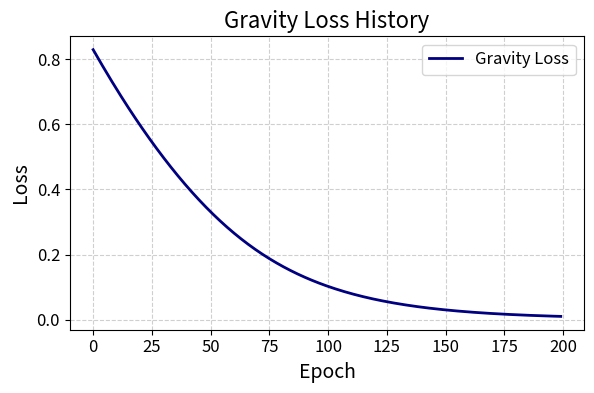

In [ ]:
#@title 重力-地震联合反演
import torch
from torch import nn, optim
from tqdm import trange
import torch.nn.functional as F

# --- 将数据和模型参数上载到TPU设备 ---
# 确保目标数据和初始预测都在TPU上
gravity_target_tpu = gravity_target.to(device)
pred_vp_tpu = pred_vp.to(device)

def bound_loss(vp, vmin, vmax):
    return torch.relu(vp - vmax).mean() + torch.relu(vmin - vp).mean()

def smoothness_loss(vp, mask=None):
    """
    计算vp的平滑正则项，支持2D和3D，并可选mask。
    vp: [ny, nx] 或 [nz, ny, nx]，float tensor
    mask: 可选，bool型，与vp同shape，仅对True区域加正则
    返回: 标量loss
    """
    dims = vp.dim()
    if dims == 2:
        diff_x = vp[:, 1:] - vp[:, :-1]
        diff_y = vp[1:, :] - vp[:-1, :]
        loss = (diff_x**2).mean() + (diff_y**2).mean()
        if mask is not None:
            # mask_x: [ny, nx-1], mask_y: [ny-1, nx]
            mask_x = mask[:, 1:] & mask[:, :-1]
            mask_y = mask[1:, :] & mask[:-1, :]
            loss = ((diff_x**2)[mask_x].mean() if mask_x.any() else 0) + \
                   ((diff_y**2)[mask_y].mean() if mask_y.any() else 0)
    elif dims == 3:
        diff_x = vp[:, :, 1:] - vp[:, :, :-1]
        diff_y = vp[:, 1:, :] - vp[:, :-1, :]
        diff_z = vp[1:, :, :] - vp[:-1, :, :]
        loss = (diff_x**2).mean() + (diff_y**2).mean() + (diff_z**2).mean()
        if mask is not None:
            # mask_x: [nz, ny, nx-1], mask_y: [nz, ny-1, nx], mask_z: [nz-1, ny, nx]
            mask_x = mask[:, :, 1:] & mask[:, :, :-1]
            mask_y = mask[:, 1:, :] & mask[:, :-1, :]
            mask_z = mask[1:, :, :] & mask[:-1, :, :]
            loss = ((diff_x**2)[mask_x].mean() if mask_x.any() else 0) + \
                   ((diff_y**2)[mask_y].mean() if mask_y.any() else 0) + \
                   ((diff_z**2)[mask_z].mean() if mask_z.any() else 0)
    else:
        raise ValueError("vp must be 2D or 3D tensor")
    return loss

# 在速度反演当中，我们需要使用稀疏性约束吗？
def sparsity_loss(vp, mask=None):
    """
    计算vp的稀疏正则项（L1范数），支持2D和3D，并可选mask。
    vp: [ny, nx] 或 [nz, ny, nx]，float tensor
    mask: 可选，bool型，与vp同shape，仅对True区域加正则
    返回: 标量loss
    """
    if mask is not None:
        if mask.any():
            loss = vp[mask].abs().mean()
        else:
            loss = vp.new_tensor(0.0)
    else:
        loss = vp.abs().mean()
    return loss

# 不同于前面多部迭代的方向性扩散，这里实现了单步作为正则化函数参与计算loss
def anisotropic_diffusion_loss(vp, kx=1.0, ky=1.0, epsilon=1e-6):
    """
    计算vp的方向性扩散正则项，抑制噪声的方向性特征。
    vp: [ny, nx] 或 [batch, ny, nx]，float tensor
    kx, ky: x/y方向的扩散系数，越小则该方向扩散越弱（结构保护越强）
    返回: 标量loss
    """
    # 计算x方向梯度
    grad_x = vp[..., :, 1:] - vp[..., :, :-1]
    # 计算y方向梯度
    grad_y = vp[..., 1:, :] - vp[..., :-1, :]

    # 方向性扩散系数（可以是常数，也可以是随梯度变化的函数）
    # 这里采用Perona-Malik形式
    coeff_x = torch.exp(- (grad_x / kx)**2)
    coeff_y = torch.exp(- (grad_y / ky)**2)

    # 方向性扩散正则项
    loss_x = (coeff_x * grad_x**2).mean()
    loss_y = (coeff_y * grad_y**2).mean()
    loss = loss_x + loss_y
    return loss

# --- 在训练循环开始前，执行一次性的预计算 ---

# 1. 定义常量
dX, dY, dZ = 100.0, 100.0, 20.0
Zmin, height = 0.0, 10.0
G = 6.67430e-11
reference_density = 2.67
batch_size = 16384 # 保持或继续增大此值

# 2. 获取模型尺寸 (假设 pred_vp_tpu 已在TPU上)
ny, nx, nz = pred_vp_tpu.shape
device = pred_vp_tpu.device
dtype = pred_vp_tpu.dtype

# 3. 准备体素（Source）坐标
x_grid = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
y_grid = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
z_grid = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ
dV = dX * dY * dZ
grid_y, grid_x, grid_z = torch.meshgrid(y_grid, x_grid, z_grid, indexing='ij')
voxels_precomputed = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)

# 4. 准备观测点（Observation）坐标
x_obs = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
y_obs = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
obs_z = Zmin - height
obs_xx, obs_yy = torch.meshgrid(x_obs, y_obs, indexing='ij')
obs_points_precomputed = torch.stack([
    obs_xx.reshape(-1), obs_yy.reshape(-1),
    torch.full((nx * ny,), obs_z, device=device, dtype=dtype)
], dim=-1)

# 1. 需要优化的参数
pred_vp_param = torch.nn.Parameter(pred_vp.clone().detach().requires_grad_(True)) # pred_vp.shape: torch.Size([64, 64, 64])

# 2. 优化参数
optimizer = torch.optim.Adam([pred_vp_param], lr=1)
max_epochs = 200
lambda_smooth = 0.1
mu_bound = 1
scale = 1e6
loss_gravity_history = []
# --- 训练循环 ---
for epoch in trange(max_epochs, desc="Optimizing on TPU"):
    # 1. 速度 -> 密度 -> 密度差 (这部分在循环内，因为 pred_vp_param 在变)
    rho = gardner_rho(pred_vp_param)
    drho = (rho - reference_density) * 1000
    drho_flat = drho.reshape(-1)

    # 2. 正演 (调用优化后的核心函数)
    gravity_flat_computed = gravity_forward_tpu_optimized(
        drho_flat,
        voxels_precomputed,
        obs_points_precomputed,
        dV,
        batch_size,
        G
    )
    # Reshape回2D
    gravity_computed = gravity_flat_computed.reshape(nx, ny).transpose(0, 1)

    # 5. 主损失
    loss_gravity = ((gravity_computed - gravity_target)**2).mean()

    # 6. 平滑正则项（可选）
    loss_smooth = smoothness_loss(pred_vp_param)  # 只对可调区域

    # 7. 上下界约束（可选）
    loss_bound = bound_loss(pred_vp_param, pred_vp.min(), pred_vp.max())

    # 8. 总损失
    gravity_computed_norm = (gravity_computed - gravity_computed.mean()) / gravity_computed.std()
    gravity_target_norm = (gravity_target - gravity_target.mean()) / gravity_target.std()
    loss_gravity = ((gravity_computed_norm - gravity_target_norm)**2).mean()
    loss = scale * loss_gravity + lambda_smooth * loss_smooth + mu_bound * loss_bound

    optimizer.zero_grad()
    loss.backward()
    # 使用 xm.optimizer_step 来更新权重，这是torch_xla的核心
    xm.optimizer_step(optimizer)

    print(pred_vp_param.grad.abs().mean())
    optimizer.step()

    # 保存loss_gravity
    loss_gravity_history.append(loss_gravity.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.6f}, gravity={loss_gravity.item():.6f}, smooth={loss_smooth.item():.6f}, bound={loss_bound.item():.6f}")

# 输出优化后的 pred_vp
pred_vp_optimized = pred_vp_param.detach().clone()
# 保存loss_gravity_history为 .npy 文件
np.save(f_path+'/loss_gravity_history_11.npy', np.array(loss_gravity_history))

# 载入 .npy 文件
loss_gravity_history = np.load(f_path+'/loss_gravity_history_11.npy')

plt.figure(figsize=(6, 4))
plt.plot(loss_gravity_history, label='Gravity Loss', color='navy', linewidth=2)

# 学术风格美化
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Gravity Loss History', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 可选：使用 LaTeX 字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.tick_params(labelsize=12)

# 保存图片
plt.savefig(f_path+'/loss_gravity_history_11.pdf', dpi=300)
plt.show()

# 20mins

In [ ]:
# --- 5. 保存计算结果 ---
print("\n正在保存张量...")
pred_vp_numpy = pred_vp_param.detach().cpu().numpy()
pred_vp_numpy.tofile(f"/content/drive/MyDrive/SeismicWorld/dataset/self_constructed_64/pred_vp_physicsInformed_{RANDOM_INDEX}.bin")



正在保存张量...


In [ ]:
stats, fig = compare_4d_slices(pred_vp_param.detach().unsqueeze(0), pred_vp.unsqueeze(0).detach(), dim=1, index=50, save_path=f_path+'/8_to_11_重力约束下的速度体改变_更加平滑.pdf')
plt.show()
print(stats)

In [ ]:
#@title 比较重力物理约束的结果与"地震-速度"UNET直接预测的结果
index_attr = 1
# stats, fig = compare_4d_slices(pred_vp.detach().unsqueeze(0), pred_vp_optimized.unsqueeze(0).detach(), dim=1, index=50, save_path=f'/content/drive/MyDrive/SeismicWorld/"地震-速度"UNET&重力物理约束_{index_attr}.pdf') # 暂时保存在这里
# plt.show()
# print(stats)
# 比较重力物理约束的结果与真实速度模型
# stats, fig = compare_4d_slices(pred_vp_optimized.unsqueeze(0).detach(), vp_case.unsqueeze(0).detach(), dim=1, index=50, save_path=f'/content/drive/MyDrive/SeismicWorld/重力物理约束&真实速度_{index_attr}.pdf')
# plt.show()
# print(stats)

# 创建一个figure和两个子图
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# 第一张：目标重力异常
im0 = axs[0].imshow(gravity_target,
                    cmap='seismic',
                    origin='lower',
                    aspect='auto')
axs[0].set_title('Target Gravity Anomaly')
axs[0].set_xlabel('X (m)')
axs[0].set_ylabel('Y (m)')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# 第二张：计算得到的重力异常
im1 = axs[1].imshow(gravity_computed.detach().numpy(),
                    cmap='seismic',
                    origin='lower',
                    aspect='auto')
axs[1].set_title('Computed Gravity Anomaly')
axs[1].set_xlabel('X (m)')
axs[1].set_ylabel('Y (m)')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
# plt.savefig(f'/content/drive/MyDrive/SeismicWorld/重力异常&约束重力异常_{index_attr}.pdf', format='pdf')
plt.savefig(f'/content/drive/MyDrive/SeismicWorld/重力异常&约束重力异常_8_to_11.pdf', format='pdf')
plt.show()

In [ ]:
#@title 多物理场下的速度密度反演-语义分割端到端物理约束

# ----------- 优化参数设置 -----------
miu_min, miu_max = 3000, 6000   # 速度物理范围
sigma_min, sigma_max = 20, 100  # 方差物理范围
lambda_miu = 0.1                # miu范围正则权重
lambda_sigma = 0.1              # sigma范围正则权重
lambda_edge = 0.01              # 边缘惩罚
lambda_region = 0.001           # 区域数惩罚
lambda_sigma_min = 0.01         # sigma最小值惩罚

# ----------- 主循环 -----------
# 1. 用一帧初始化参数
edge_map = sobel3d_edge_5x5(seismic)
edge_mask = get_mask(edge_map, thresh=0.15)
vp, region_ids, miu_list, sigma_list = assign_vp_by_region(edge_mask, seismic.shape)

# 2. 包装为 ParameterList（可选，视 assign_vp_by_region 返回类型而定）
if not isinstance(miu_list, torch.nn.ParameterList):
    miu_list = torch.nn.ParameterList([miu_list])
if not isinstance(sigma_list, torch.nn.ParameterList):
    sigma_list = torch.nn.ParameterList([sigma_list])

# 3. 初始化优化器
params = list(miu_list.parameters()) + list(sigma_list.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)
# optimizer = torch.optim.Adam([miu_list, sigma_list], lr=1e-2)
num_epochs = 10
for epoch in range(num_epochs):
    # 1. 提取边缘
    edge_map = sobel3d_edge(seismic)
    edge_mask = get_mask(edge_map, thresh=0.5)

    # 2. 区域分配参数并生成vp
    vp, region_ids, miu_list, sigma_list = assign_vp_by_region(edge_mask, seismic.shape)

    # 3. 计算rho
    rho = gardner_rho(vp)

    # 4. 计算重力异常
    gravity_pred = compute_gravity_static(
        rho.cpu().numpy(),  # FFT部分用numpy实现，若有torch实现可直接用
        height=10.0,
    )
    gravity_pred = torch.tensor(gravity_pred, dtype=torch.float32)

    # 5. 主损失
    loss_physics = F.mse_loss(gravity_pred, target_gravity)

    # 6. 正则项
    # miu范围正则
    loss_miu = F.relu(miu_list - miu_max).sum() + F.relu(miu_min - miu_list).sum()
    # sigma范围正则
    loss_sigma = F.relu(sigma_list - sigma_max).sum() + F.relu(sigma_min - sigma_list).sum()
    # 区域数量正则
    n_region = len(miu_list)
    loss_region = lambda_region * n_region
    # 边缘长度正则
    loss_edge = edge_map.sum() * lambda_edge
    # sigma最小值惩罚
    loss_sigma_min = lambda_sigma_min * F.relu(sigma_min - sigma_list).sum()

    # 总损失
    loss = loss_physics \
         + lambda_miu * loss_miu \
         + lambda_sigma * loss_sigma \
         + loss_region \
         + loss_edge \
         + loss_sigma_min

    # 反向传播与优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 日志输出
    print(f"Epoch {epoch}: Loss={loss.item():.4f}  Physics={loss_physics.item():.4f}  "
          f"miu_reg={loss_miu.item():.4f}  sigma_reg={loss_sigma.item():.4f}  "
          f"edge={loss_edge.item():.4f}  n_region={n_region}")


In [ ]:
stats, fig = compare_4d_slices(seismic.detach()[None,...], smoothed.detach()[None,], dim=1, index=50)
plt.show()
print(stats)
stats, fig = compare_4d_slices(smoothed.detach()[None,], targets_list[0][0,t].cpu().detach()[None,], dim=1, index=50)
plt.show()
print(stats)

In [ ]:
#@title 多物理场下的速度密度反演-反卷积
sys.path.append('/content/drive/MyDrive/SeismicWorld/MoE')
from functions import * # 调用GeoModel
# 得到rc
# 各向异性扩散方程自适应平滑高斯噪声
def anisotropic_diffusion_3d(seismic, n_iter=10, K=0.1, lambda_=0.15):
    """
    3D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    seismic: (D, H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (D, H, W) tensor
    """
    I = seismic.clone() if isinstance(seismic, torch.Tensor) else seismic
    D, H, W = I.shape

    # 6邻域差分
    def get_gradients(I):
        grads = []
        # pad在边界复制
        I_pad = F.pad(I[None, None], (1,1,1,1,1,1), mode='replicate')[0,0]
        # x方向
        grads.append(I_pad[2:,1:-1,1:-1] - I)  # 前
        grads.append(I_pad[:-2,1:-1,1:-1] - I) # 后
        # y方向
        grads.append(I_pad[1:-1,2:,1:-1] - I)  # 上
        grads.append(I_pad[1:-1,:-2,1:-1] - I) # 下
        # z方向
        grads.append(I_pad[1:-1,1:-1,2:] - I)  # 右
        grads.append(I_pad[1:-1,1:-1,:-2] - I) # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（这里用exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I

# 生成wavelet
A = 1.0 # Maximum amplitude of the wavelet.
length = 0.1 # Time duration of the wavelet (unit: s).
dt  = 0.002 # (float): Sampling time interval of the wavelet (unit: s).
t = np.arange(-length / 2, length / 2, dt, dtype=np.float32)
f_ricker = 25
wavelet = (1 - 2 * np.pi ** 2 * f_ricker ** 2 * t ** 2) * np.exp(-np.pi ** 2 * f_ricker ** 2 * t ** 2) # ricker wavelet
wavelet *= A

# 反卷积
t = 0 # 预测的四帧当中取第几帧
seismic = predictions_list[0][0,t].cpu().detach() # 神经网络预测的结果
seismic_pre = anisotropic_diffusion_3d(seismic, n_iter=20, K=0.08, lambda_=0.18)
rc_4_rho = GeoModel.seismic_to_rc(seismic_pre, wavelet,1e-2)

def rc2vp_gardner(rc, vp0, b=0.25):
    """
    根据Gardner关系和反射系数序列递推恢复Vp剖面
    rc: 1D numpy array, 反射系数序列
    vp0: float, 首层速度（假定或已知）
    b: Gardner指数，默认0.25
    返回: vp (1D numpy array, 长度为len(rc)+1)
    """
    nz = len(rc) + 1
    S = np.zeros(nz)
    vp = np.zeros(nz)
    S[0] = vp0 ** (b + 1)
    vp[0] = vp0
    for i in range(len(rc)):
        S[i+1] = S[i] * (1 + rc[i]) / (1 - rc[i])
        vp[i+1] = S[i+1] ** (1/(b + 1))
    return vp

def generate_density_model(vp, method='gardner', params=None):
    """
    根据速度体生成密度体，支持多种密度-速度关系

    Args:
        vp (np.ndarray): 三维速度体（单位：m/s）
        method (str): 密度计算方法，支持 'gardner', 'nafe_drake', 'castagna', 'lindseth'
        params (dict): 相关方法参数，见下

    Returns:
        rho (np.ndarray): 三维密度体（单位：g/cm³）
    """
    # 单位换算
    vp_kms = vp / 1000.0  # km/s

    if method == 'gardner':
        a = 0.31 if params is None or 'a' not in params else params['a']
        b = 0.25 if params is None or 'b' not in params else params['b']
        rho = a * (vp ** b)

    elif method == 'nafe_drake':
        a = 1.6612 if params is None or 'a' not in params else params['a']
        b = 0.4721 if params is None or 'b' not in params else params['b']
        c = -0.0671 if params is None or 'c' not in params else params['c']
        d = 0.0043 if params is None or 'd' not in params else params['d']
        e = -0.000106 if params is None or 'e' not in params else params['e']
        rho = a + b*vp_kms + c*(vp_kms**2) + d*(vp_kms**3) + e*(vp_kms**4)

    elif method == 'castagna':
        a = 1.36 if params is None or 'a' not in params else params['a']
        b = 0.49 if params is None or 'b' not in params else params['b']
        rho = a + b * vp_kms

    elif method == 'lindseth':
        a = 3.2 if params is None or 'a' not in params else params['a']
        b = 3.2 if params is None or 'b' not in params else params['b']
        vp_safe = np.copy(vp_kms)
        vp_safe[vp_safe < 0.1] = 0.1
        rho = a - b / vp_safe

    else:
        raise ValueError(f"未知的密度计算方法: {method}")

    # 限制密度范围在合理区间
    rho = np.clip(rho, 1.0, 5.0)
    return rho


ny, nx, nz = rc_4_rho.shape
vp0 = 3000
b = 0.25
vp_cube = np.zeros((ny, nx, nz+1), dtype=np.float32) # nz+1 递推

for i in range(ny):
    for j in range(nx):
        vp_cube[i, j, :] = rc2vp_gardner(rc_4_rho[i, j, :], vp0, b)
vp_4_rho = vp_cube[:, :, :-1]

# --- Gardner关系得到密度模型 ---
rho_4_rho = generate_density_model(vp_4_rho, method='gardner')
# 假设你已有rho_4_rho，且每个格点25m×25m×4m
gravity_ThruOperator = compute_gravity_static(
    rho_4_rho,
    height=10.0,
)
gravity_target = target_gravity_anomoly[0,t]

torch.isnan(torch.from_numpy(vp_cube)).any()
print(seismic_pre.max(), seismic_pre.min()) # tensor(0.3313) tensor(-0.2869)
print(np.max(rc_4_rho), np.min(rc_4_rho)) # 0.59560627 -0.5514526
print(rho_4_rho.max(),rho_4_rho.min()) # 4.093064 1.5583433
print(vp_cube.max(),vp_cube.min()) # 30391.166 638.566
print(gravity_target.max(),gravity_target.min())

# 转为 numpy
arr1 = gravity_ThruOperator
arr2 = gravity_target.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个张量，并添加独立色条
im1 = axs[0].imshow(arr1, cmap='viridis')
axs[0].set_title('Gravity ThruOperator', fontsize=14)
axs[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Value', fontsize=12)

# 绘制第二个张量，并添加独立色条
im2 = axs[1].imshow(arr2, cmap='viridis')
axs[1].set_title('Gravity Target', fontsize=14)
axs[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('Value', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#@title 验证反卷积seismic能不能得到rc
import numpy as np

# 1. 建模
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.
# data generation
for i in range(1):
  # 为每个模型使用不同的种子
  current_seed = seed_val + i
  # Initialize the geomodel.
  model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                  resolution=[dx, dy, dz],
                  mute=mute)

  # Assign Vp.
  model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
              fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
              vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
              vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
              vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
              smooth=False,  # Whether to smooth the Vp model, we will do it later.
              seed=current_seed,  # Random seed.
              mute=mute)

  # Add channels.
  model.add_meandering_channel(N=1,
                              X_pos_range=[0.2, 0.3],  # Range of channel centerline's X-coordinate which the model starts at.
                              Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                              Z_pos_range=[0.2, 0.8],  # Channel Z-coordinate range (fraction of geomodel's Z-range).
                              strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                              W_range=[200, 250],  # Channel width range used for centerline simulation (m).
                              D_range=[15, 20],  # Channel depth range used for centerline simulation (m).
                              kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                              Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                              n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                              kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                              aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                              t_incision=None,  # Vertical incision time period.
                              t_aggradation=None,  # Vertical aggradation time period.
                              Wx_range=[300, 300],  # Channel width used to define channel geometry (m).
                              Dx_range=[15, 15],  # Channel depth used to define channel geometry (m).
                              epsilon_range = [0.5, 0.5],  # Vp contrast between channel fill and its upper layer.
                              incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                              seed=current_seed,
                              instance_label=False,  # Whether to make instance label.
                              mute=mute)

  # Smooth Vp and channel model.
  model.smooth(param=['vp', 'channel'], sigma=1.5)

  # Add inclination to the geomodel.
  model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                    b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                    seed=current_seed,
                    mute=mute)

  # Add folds to the geomodel.
  model.add_fold(N=10,  # Number of folds.
                sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                seed=current_seed,
                mute=mute)

  # Resample the geomodel.
  model.resample_z(param=['vp', 'channel'],  # Vp model and channel model.
                  z_range=(200, 1480),  # Crop models between z_range.
                  mute=mute)

  # Compute P-wave impedance.
  model.compute_Ip(rho=2.4)

  # Seismic.
  model.compute_rc(mute=mute)
  model.make_synseis(f_ricker=25,
                    mark_channel=True)

# 2. 生成与make_synseis一致的Ricker子波
f_ricker = 25
dt = 0.002
length = 0.1
A = 1.0
t = np.arange(-length/2, length/2, dt, dtype=np.float32)
wavelet = (1 - 2 * np.pi ** 2 * f_ricker ** 2 * t ** 2) * np.exp(-np.pi ** 2 * f_ricker ** 2 * t ** 2)
wavelet *= A

# 3. 反卷积恢复rc
smoothed_seismic = anisotropic_diffusion_3d(torch.from_numpy(model.seismic), n_iter=20, K=0.08, lambda_=0.18)
rc_est = GeoModel.seismic_to_rc(smoothed_seismic, wavelet, eps=1e-2)

# 4. 验证效果（如对比rc_est和gm.rc）
import matplotlib.pyplot as plt
ix, iy = 5, 5  # 任意一条道
plt.plot(model.rc[ix, iy, :], label='True RC')
plt.plot(rc_est[ix, iy, :], label='Recovered RC')
plt.legend()
plt.title('RC Recovery (single trace)')
plt.show()


## 磁异常约束

In [ ]:
#@title 导入TPU相关的库 (deprecated)
import os
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met

def get_tpu_device():
    """
    检查并获取TPU设备。如果TPU不可用，则回退到CPU。
    这是在Colab中连接到TPU的更稳健的方法。
    """
    if 'XLA_USE_BF16' not in os.environ:
        os.environ['XLA_USE_BF16'] = '1'

    try:
        # 尝试获取XLA设备，这是检查可用性的最直接方法
        device = xm.xla_device()
        print("TPU设备成功连接！")
        return device
    except RuntimeError as e:
        # 如果xm.xla_device()失败，它会抛出RuntimeError
        print(f"未能找到TPU设备，错误信息: {e}")
        print("将使用CPU进行计算。")
        return torch.device("cpu")

# --- 获取设备 ---
device = get_tpu_device()
print(f"计算将在设备: {device} 上进行")



TPU设备成功连接！
计算将在设备: xla:0 上进行
